In [1]:
%reload_ext autoreload
%autoreload 2

In [51]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import numpy as np
from functools import partial

import warnings
warnings.filterwarnings('ignore')

from probatus.feature_elimination import ShapRFECV
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import optuna
import lightgbm as lgbm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV


import talib.abstract as ta
from scipy.stats import linregress, entropy

import matplotlib.pyplot as plt

from source.backward_fs import backward_by_fi, select_feature_index
from source.feature_generation_ta import generate_features
from source.TE import transfer_entropy
from source.optimizing import objective_lgbm_model
from source.pipeline import pipe

In [4]:
# optuna==3.3.0
# xgboost==1.6.2
# mlflow
# probatus==1.5.1
# lightgbm==4.5.0

import talib
talib.__version__

'0.6.1'

# Задание

В рамках проекта №2 требуется реализовать автоматизированный пайплайн для прогнозирования значений верменного ряда на следуюбщий день.
Ряды представляют из себя срезы в обозначенные моменты времени притоков, оттоков и сальдо показателя, связанного с потоками ликвидности Банка
Прогноз требуется строить для значения сальдо (разнинцы между притоками и оттоками)
Заказчик модели высказал пожелание, чтобы ошибка прогноза составляла не более 0.42 в абсолютном значении


**Требования к модели:**
1. Выбор оптимизируемой метрики должен быть основан на потребностях бизнеса
2. Модель может использовать внешние факторы (см подсказки)
3. Модель должна иметь модуль отбора признаков. Метод отбора должен быть болеее стабильным относительно альтернатив. Сравнение должно быть проведено минимум с одним методом из каждой категории: встроенные, оберточные и фильтрационные. При этом как минимум одна из альтернатив должа исследовать нелинейную зависимость.
4. Модель должна втоматически подбирать гиперпараметры, оптимизируя целевую метрику
5. Для модели должна быть подобрана частота калиброки, если модель калибруется долго, и проверена ее достаточность
6. Блоки должны быть подписаны и кратко описаны (чем руководствовались при реализации, как работает)
7. Модель должна автоматически дообучаться. Все модули должны работать без ручных корректировок. Выбор периода для дообучения должен быть обоснован.
8. В модели должен быть модуль выявления разладки для подачи сигнала о возможной необходимости переключения на на ручное управление процессом/внеплановое дообучение

**Подсказки:**
- Можно использовать факторы, сконструированные из таргета (лаги, средние и т.п.)
- Могут помочь макроэкономические факторы
- Могут помочь даты налоговых дней

**Описание бизнес-процесса:**
1. Прогнозная величина позволяет установить сальдо поступлений и списаний за день.
2. На основании прогноза позиционер (управляет ликвидностью) принимает решение о выделении средств на размещение на рынке деривативов для получения дополнительной маржи (доходность считать примерно ключ+0.5%)
3. В случае, если на конец дня образуется профицит ликвидности, его можно разместить в ЦБ по overnight ставке, равной ключу-0.9%
4. В случае, если на конец дня образуется дефицит ликвидности, его можно покрыть за счет займа по overnight ставке, равной ключ+1%

# Загрузка данных

In [52]:
df = pd.read_excel('Project 2_2023.xlsx')
df['Date'] = pd.to_datetime(df['Date'])

df['target_Income'] = df['Income'].shift(1) # предсказание следующего дня
df['target_Outcome'] = df['Outcome'].shift(1)

df.head()

,Date,Income,Outcome,Balance,target_Income,target_Outcome
0,2017-01-09,1.343028,1.487865,-0.155904,NaN,NaN
1,2017-01-10,1.068610,1.194182,-0.125572,1.343028,1.487865
2,2017-01-11,0.944429,0.936663,0.007767,1.068610,1.194182
3,2017-01-12,1.672202,0.875379,0.800391,0.944429,0.936663
4,2017-01-13,0.955924,0.975645,-0.019721,1.672202,0.875379


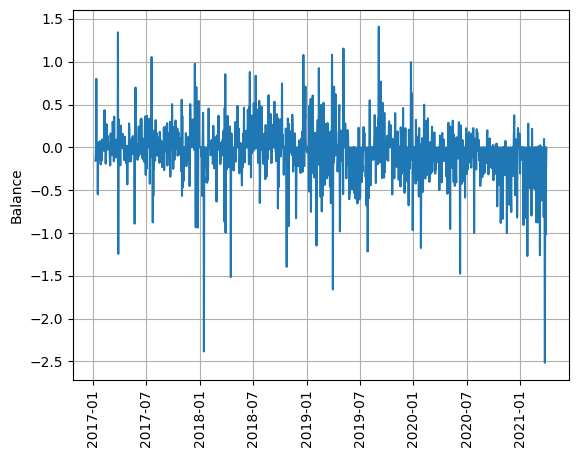

In [5]:
plt.plot(df['Date'], df['Balance'])
plt.xticks(rotation = 90)
plt.ylabel('Balance')
plt.grid()

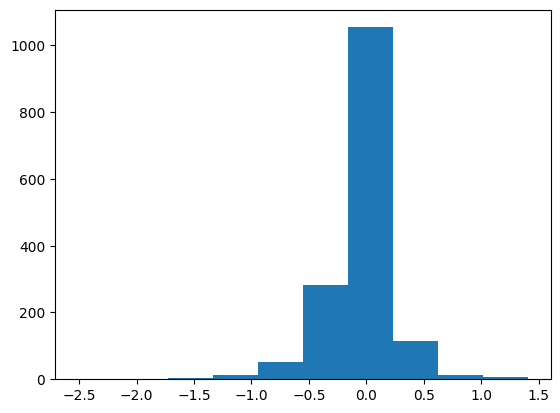

In [6]:
plt.hist(df['Balance']);

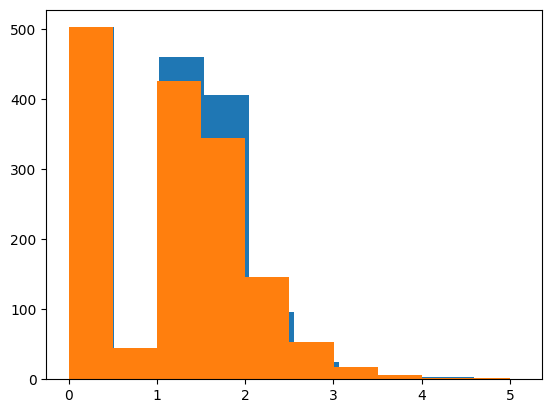

In [7]:
plt.hist(df['Income'])
plt.hist(df['Outcome']);

# Генерация фичей теханализа

In [53]:
df_new = generate_features(df)
df_new['period'] = df_new['%-year'].astype(str) +'-' + df_new['%-month'].astype(str)
df_new = df_new.iloc[1:] # удаляем первую строчку тк там нет лага таргета

# real_balance
df_new["Balance"] = df_new["Income"] - df_new["Outcome"]

longlist = [x for x in df_new.columns if '%' in x]
print(len(longlist))

66


In [ ]:
# проверка на адекватность фичей
# df_new[longlist].mean()
# df_new[longlist].isna().sum() / df_new[longlist].shape[0] * 100

In [117]:
inplace_type = '-1e10' # '-1e10' or 'mean'
dict_in = None # заглушка

TEST_DAYS = 30
df_results = pd.DataFrame(columns = ['Date', 'MAE_Balance', 'Retrained', 'best_model_income', 'best_model_outcome'])
prev_mae = None
model = None
min_train_days = 60 # We need at least 2 months (~60 days) for initial train + 30 days test

for idx in range(min_train_days, len(df_new) - TEST_DAYS + 1): # [:50]
    print(idx)

    train_end_idx = idx
    test_end_idx = idx + TEST_DAYS

    df_train = df_new.iloc[:train_end_idx]
    df_test  = df_new.iloc[train_end_idx:test_end_idx]

    train, valid = train_test_split(df_train, test_size=0.2, random_state = 42)

    y_train_in = train['target_Income']
    y_train_out = train['target_Outcome']
    x_train = train[longlist]
    
    y_valid_in = valid['target_Income']
    y_valid_out = valid['target_Outcome']
    x_valid = valid[longlist]
    
    y_test_in = df_test['target_Income']
    y_test_out = df_test['target_Outcome']
    x_test = df_test[longlist]

    # заполнение пропусков
    if inplace_type == '-1e10':
        x_train.fillna(-1e10, inplace=True)
        x_valid.fillna(-1e10, inplace=True)
        x_test.fillna(-1e10, inplace=True)
        
    if inplace_type == 'mean':
        x_train.fillna(x_train.mean(), inplace=True)
        x_valid.fillna(x_train.mean(), inplace=True)
        x_test.fillna(x_train.mean(), inplace=True)

    if dict_in is None:
        dict_in = pipe(x_train, x_valid, x_test,
                             y_train_in, y_valid_in, y_test_in, 
                             longlist)
        dict_out = pipe(x_train, x_valid, x_test,
                            y_train_out, y_valid_out, y_test_out,
                            longlist)
        retrained = True
    else:
        retrained = False

    # in -------------------------------------
    selected_features_in = dict_in['features']
    model_in = dict_in['model']

    if isinstance(model, Lasso):
        X_test_scaled = dict_in['X_test_scaled']
        y_pred_in = model_in.predict(X_test_scaled)
    else:
        y_pred_in = model_in.predict(x_test[selected_features_in])

    # out -------------------------------------
    selected_features_out = dict_out['features']
    model_out = dict_out['model']

    if isinstance(model, Lasso):
        X_test_scaled = dict_out['X_test_scaled']
        y_pred_out = model_out.predict(X_test_scaled)
    else:
        y_pred_out = model_out.predict(x_test[selected_features_out])

    df_test['predicted_Balance'] = y_pred_in - y_pred_out
    mae = mean_absolute_error(df_test["Balance"], df_test['predicted_Balance'])
    print('mae:', mae)

    
    # Compare to previous MAE
    if prev_mae is not None:
        improvement = (mae - prev_mae) / prev_mae
        print('LINE:', prev_mae, mae, improvement)
        if improvement >= 0.01: 
            dict_in = pipe(x_train, x_valid, x_test,
                             y_train_in, y_valid_in, y_test_in, 
                             longlist)
            dict_out = pipe(x_train, x_valid, x_test,
                                y_train_out, y_valid_out, y_test_out,
                                longlist)
            retrained = True
            # re-compute predictions and MAE after retraining

            # in -------------------------------------
            selected_features_in = dict_in['features']
            model_in = dict_in['model']

            if isinstance(model, Lasso):
                X_test_scaled = dict_in['X_test_scaled']
                y_pred_in = model_in.predict(X_test_scaled)
            else:
                y_pred_in = model_in.predict(x_test[selected_features_in])

            # out -------------------------------------
            selected_features_out = dict_out['features']
            model_out = dict_out['model']

            if isinstance(model, Lasso):
                X_test_scaled = dict_out['X_test_scaled']
                y_pred_out = model_out.predict(X_test_scaled)
            else:
                y_pred_out = model_out.predict(x_test[selected_features_out])

            
            df_test['predicted_Balance'] = y_pred_in - y_pred_out
            mae = mean_absolute_error(df_test["Balance"], df_test['predicted_Balance'])
            print('mae:', mae)

    # Store results
    df_results.loc[len(df_results)+ 1] = [df_test["Date"].iloc[-1],
                                          mae,
                                          retrained,
                                          dict_in['best_model'] if retrained else None,
                                          dict_out['best_model'] if retrained else None
                                                 ]

    prev_mae = mae

    print('--------------------------------')


df_results = df_results.reset_index(drop=True)   

60
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.363189
2       df_metric_lgbm     0.316323
3      df_metric_lasso     0.093009
best_algo = Lasso
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.382785
2       df_metric_lgbm     0.342582
3      df_metric_lasso     0.211885
best_algo = Lasso
mae: 0.3483149999065981
--------------------------------
61
mae: 0.3458496237218766
LINE: 0.3483149999065981 0.3458496237218766 -0.00707800750867054
--------------------------------
62
mae: 0.34240130655381434
LINE: 0.3458496237218766 0.34240130655381434 -0.00997056793340713
--------------------------------
63
mae: 0.34769112082391124
LINE: 0.34240130655381434 0.34769112082391124 0.015449164967673703
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.379157
2       df_metric_lgbm     0.317385
3      df_metric_lasso     0.092730
best_algo = Lasso
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.426589
2       df_

[I 2025-04-24 17:19:04,557] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:04,618] Trial 0 finished with value: -0.5531814736183782 and parameters: {'learning_rate': 0.09426668814579821, 'reg_alpha': 62.9800309585351, 'reg_lambda': 1.56667751444289e-05, 'colsample_bytree': 0.9944478841955685, 'min_child_samples': 1317, 'n_estimators': 1587, 'num_leaves': 80, 'max_depth': 4}. Best is trial 0 with value: -0.5531814736183782.
[I 2025-04-24 17:19:04,631] Trial 1 finished with value: -0.5531814736183782 and parameters: {'learning_rate': 0.34393554318352015, 'reg_alpha': 0.7684025796550865, 'reg_lambda': 0.3244798840782019, 'colsample_bytree': 0.5014577892243122, 'min_child_samples': 275, 'n_estimators': 128, 'num_leaves': 75, 'max_depth': 4}. Best is trial 0 with value: -0.5531814736183782.
[I 2025-04-24 17:19:04,648] Trial 3 finished with value: -0.5531814736183782 and parameters: {'learning_rate': 0.08569513451156703, 'reg_alpha': 0.3103749145713883, 're

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.317449
2       df_metric_lgbm     0.151938
3      df_metric_lasso     0.168147
best_algo = LGBM


[I 2025-04-24 17:19:04,772] Trial 7 finished with value: -0.5531814736183782 and parameters: {'learning_rate': 0.021219640017427592, 'reg_alpha': 0.0001854335627622808, 'reg_lambda': 0.0005700864044631721, 'colsample_bytree': 0.7782403395100697, 'min_child_samples': 834, 'n_estimators': 1662, 'num_leaves': 124, 'max_depth': 6}. Best is trial 0 with value: -0.5531814736183782.
[I 2025-04-24 17:19:04,802] Trial 8 finished with value: -0.5531814736183782 and parameters: {'learning_rate': 0.20099219621044898, 'reg_alpha': 0.011108406785221916, 'reg_lambda': 2.199733174427259, 'colsample_bytree': 0.7765150037637965, 'min_child_samples': 330, 'n_estimators': 1217, 'num_leaves': 103, 'max_depth': 3}. Best is trial 0 with value: -0.5531814736183782.
[I 2025-04-24 17:19:04,822] Trial 10 finished with value: -0.5531814736183782 and parameters: {'learning_rate': 0.4697505030417651, 'reg_alpha': 7.214579256261365e-05, 'reg_lambda': 1.044331093682954e-05, 'colsample_bytree': 0.7165206708080634, 'mi

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.377192
mae: 0.5251097057490041
--------------------------------
92
mae: 0.5309753927569496
LINE: 0.5251097057490041 0.5309753927569496 0.011170402953376884
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.278112
2       df_metric_lgbm     0.111639
3      df_metric_lasso     0.097886
best_algo = Lasso


[I 2025-04-24 17:19:05,872] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:05,967] Trial 0 finished with value: -0.5621814604207236 and parameters: {'learning_rate': 0.23533776317705615, 'reg_alpha': 16.975876856212693, 'reg_lambda': 32.06082203787598, 'colsample_bytree': 0.7745431218142033, 'min_child_samples': 1088, 'n_estimators': 1030, 'num_leaves': 79, 'max_depth': 7}. Best is trial 0 with value: -0.5621814604207236.
[I 2025-04-24 17:19:05,984] Trial 1 finished with value: -0.5621814604207236 and parameters: {'learning_rate': 0.37801154704068374, 'reg_alpha': 0.006810617666824607, 'reg_lambda': 0.0370886071031304, 'colsample_bytree': 0.560582552969394, 'min_child_samples': 1460, 'n_estimators': 1624, 'num_leaves': 72, 'max_depth': 4}. Best is trial 0 with value: -0.5621814604207236.
[I 2025-04-24 17:19:05,987] Trial 3 finished with value: -0.5621814604207236 and parameters: {'learning_rate': 0.31396579481896, 'reg_alpha': 0.03310971502263422, 're

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.328413
2       df_metric_lgbm     0.130474
3      df_metric_lasso     0.192152
best_algo = LGBM


[I 2025-04-24 17:19:06,076] Trial 5 finished with value: -0.5621814604207236 and parameters: {'learning_rate': 0.37057369476805074, 'reg_alpha': 0.8485724540459412, 'reg_lambda': 29.063408627935594, 'colsample_bytree': 0.7090328624775041, 'min_child_samples': 227, 'n_estimators': 544, 'num_leaves': 32, 'max_depth': 1}. Best is trial 0 with value: -0.5621814604207236.
[I 2025-04-24 17:19:06,097] Trial 4 finished with value: -0.5621814604207236 and parameters: {'learning_rate': 0.49937263812951604, 'reg_alpha': 0.35510427595380495, 'reg_lambda': 10.911275337794745, 'colsample_bytree': 0.7494058022861012, 'min_child_samples': 1473, 'n_estimators': 1003, 'num_leaves': 66, 'max_depth': 5}. Best is trial 0 with value: -0.5621814604207236.
[I 2025-04-24 17:19:06,099] Trial 6 finished with value: -0.5621814604207236 and parameters: {'learning_rate': 0.3381291054261067, 'reg_alpha': 0.0004424051065830352, 'reg_lambda': 7.773312965068177e-05, 'colsample_bytree': 0.8181285886487359, 'min_child_sa

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	valid_0's l2: 0.398449
mae: 0.5746206182931608
--------------------------------
93
mae: 0.5805711024466138
LINE: 0.5746206182931608 0.5805711024466138 0.010355500592944577
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.274438
2       df_metric_lgbm     0.110369
3      df_metric_lasso     0.098960
best_algo = Lasso


[I 2025-04-24 17:19:07,284] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:07,359] Trial 2 finished with value: -0.5616511204462061 and parameters: {'learning_rate': 0.0839812491396756, 'reg_alpha': 3.0285171315831296, 'reg_lambda': 0.0008683323842298939, 'colsample_bytree': 0.8679580818455858, 'min_child_samples': 708, 'n_estimators': 1390, 'num_leaves': 100, 'max_depth': 4}. Best is trial 2 with value: -0.5616511204462061.
[I 2025-04-24 17:19:07,389] Trial 3 finished with value: -0.5616511204462061 and parameters: {'learning_rate': 0.008449011807976881, 'reg_alpha': 1.2379984904137735, 'reg_lambda': 0.9269681653819617, 'colsample_bytree': 0.7951231974482627, 'min_child_samples': 743, 'n_estimators': 406, 'num_leaves': 39, 'max_depth': 2}. Best is trial 2 with value: -0.5616511204462061.
[I 2025-04-24 17:19:07,397] Trial 0 finished with value: -0.5616511204462061 and parameters: {'learning_rate': 0.39893000753627533, 'reg_alpha': 0.003672397948928415

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.325706
2       df_metric_lgbm     0.158764
3      df_metric_lasso     0.190458
best_algo = LGBM


[I 2025-04-24 17:19:07,503] Trial 7 finished with value: -0.5616511204462061 and parameters: {'learning_rate': 0.45827712238794227, 'reg_alpha': 0.04371549361378424, 'reg_lambda': 0.0008607810230628551, 'colsample_bytree': 0.889062185844854, 'min_child_samples': 977, 'n_estimators': 573, 'num_leaves': 27, 'max_depth': 1}. Best is trial 2 with value: -0.5616511204462061.
[I 2025-04-24 17:19:07,504] Trial 6 finished with value: -0.5616511204462061 and parameters: {'learning_rate': 0.10195878044051968, 'reg_alpha': 0.23831083952793533, 'reg_lambda': 0.0013440710644990969, 'colsample_bytree': 0.9011832959106767, 'min_child_samples': 370, 'n_estimators': 1011, 'num_leaves': 89, 'max_depth': 3}. Best is trial 2 with value: -0.5616511204462061.
[I 2025-04-24 17:19:07,537] Trial 5 finished with value: -0.5616511204462061 and parameters: {'learning_rate': 0.24058010886387676, 'reg_alpha': 22.461249231517844, 'reg_lambda': 0.0008307244592814924, 'colsample_bytree': 0.6699615713506497, 'min_child

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.398561
mae: 0.6876291527431817
--------------------------------
94
mae: 0.7075871911806156
LINE: 0.6876291527431817 0.7075871911806156 0.02902442160547538
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.266503
2       df_metric_lgbm     0.119182
3      df_metric_lasso     0.096666
best_algo = Lasso


[I 2025-04-24 17:19:08,698] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:08,748] Trial 1 finished with value: -0.5610038938758296 and parameters: {'learning_rate': 0.21739303165534463, 'reg_alpha': 0.014270074918963246, 'reg_lambda': 0.9666039062524959, 'colsample_bytree': 0.934094298001905, 'min_child_samples': 627, 'n_estimators': 950, 'num_leaves': 128, 'max_depth': 1}. Best is trial 1 with value: -0.5610038938758296.
[I 2025-04-24 17:19:08,762] Trial 0 finished with value: -0.5610038938758296 and parameters: {'learning_rate': 0.310289607046124, 'reg_alpha': 0.08999796315378944, 'reg_lambda': 0.0008488993027620206, 'colsample_bytree': 0.508738807228698, 'min_child_samples': 1344, 'n_estimators': 707, 'num_leaves': 50, 'max_depth': 5}. Best is trial 1 with value: -0.5610038938758296.
[I 2025-04-24 17:19:08,777] Trial 2 finished with value: -0.5610038938758296 and parameters: {'learning_rate': 0.37397398437749724, 'reg_alpha': 4.910125782539919, 'r

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.310459
2       df_metric_lgbm     0.175441
3      df_metric_lasso     0.189776
best_algo = LGBM


[I 2025-04-24 17:19:08,934] Trial 8 finished with value: -0.5610038938758296 and parameters: {'learning_rate': 0.31281974911686516, 'reg_alpha': 0.025152274981957802, 'reg_lambda': 4.081882084342342, 'colsample_bytree': 0.700048130417823, 'min_child_samples': 1311, 'n_estimators': 981, 'num_leaves': 41, 'max_depth': 6}. Best is trial 1 with value: -0.5610038938758296.
[I 2025-04-24 17:19:08,958] Trial 9 finished with value: -0.5610038938758296 and parameters: {'learning_rate': 0.21728831213832434, 'reg_alpha': 0.019017782446744968, 'reg_lambda': 0.004013938527621321, 'colsample_bytree': 0.5738730953485058, 'min_child_samples': 104, 'n_estimators': 1102, 'num_leaves': 80, 'max_depth': 1}. Best is trial 1 with value: -0.5610038938758296.
[I 2025-04-24 17:19:09,012] Trial 10 finished with value: -0.5610038938758296 and parameters: {'learning_rate': 0.06318080281759428, 'reg_alpha': 2.3591662869643346, 'reg_lambda': 0.00020245119026640593, 'colsample_bytree': 0.7208094309915442, 'min_child

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.398707
mae: 0.7097170602511648
--------------------------------
95
mae: 0.6977399993022279
LINE: 0.7097170602511648 0.6977399993022279 -0.01687582505723943
--------------------------------
96
mae: 0.6755914578329238
LINE: 0.6977399993022279 0.6755914578329238 -0.0317432589380766
--------------------------------
97
mae: 0.6974721660429108
LINE: 0.6755914578329238 0.6974721660429108 0.03238748500487727
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.254337
2       df_metric_lgbm     0.114109
3      df_metric_lasso     0.091783
best_algo = Lasso


[I 2025-04-24 17:19:10,033] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:10,095] Trial 0 finished with value: -0.557099090339924 and parameters: {'learning_rate': 0.15924853745053122, 'reg_alpha': 1.2756996363009963, 'reg_lambda': 2.631955096247625, 'colsample_bytree': 0.687420868322564, 'min_child_samples': 666, 'n_estimators': 1740, 'num_leaves': 113, 'max_depth': 7}. Best is trial 0 with value: -0.557099090339924.
[I 2025-04-24 17:19:10,105] Trial 1 finished with value: -0.557099090339924 and parameters: {'learning_rate': 0.0875084093935011, 'reg_alpha': 0.0018441563837382142, 'reg_lambda': 1.902362492483967e-05, 'colsample_bytree': 0.6183781366272438, 'min_child_samples': 1319, 'n_estimators': 1491, 'num_leaves': 74, 'max_depth': 3}. Best is trial 0 with value: -0.557099090339924.
[I 2025-04-24 17:19:10,106] Trial 2 finished with value: -0.557099090339924 and parameters: {'learning_rate': 0.07924041193737762, 'reg_alpha': 0.0001536284240123942, 

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.312041
2       df_metric_lgbm     0.166587
3      df_metric_lasso     0.172951
best_algo = LGBM


[I 2025-04-24 17:19:10,253] Trial 8 finished with value: -0.557099090339924 and parameters: {'learning_rate': 0.1811891306628399, 'reg_alpha': 0.42511906957074946, 'reg_lambda': 0.0009862287477947265, 'colsample_bytree': 0.6473433657570102, 'min_child_samples': 1038, 'n_estimators': 1313, 'num_leaves': 13, 'max_depth': 8}. Best is trial 0 with value: -0.557099090339924.
[I 2025-04-24 17:19:10,264] Trial 9 finished with value: -0.557099090339924 and parameters: {'learning_rate': 0.1588470362607864, 'reg_alpha': 2.0554604860443778e-05, 'reg_lambda': 0.8984250810024547, 'colsample_bytree': 0.9924251329195073, 'min_child_samples': 1416, 'n_estimators': 1856, 'num_leaves': 58, 'max_depth': 4}. Best is trial 0 with value: -0.557099090339924.
[I 2025-04-24 17:19:10,279] Trial 7 finished with value: -0.557099090339924 and parameters: {'learning_rate': 0.14571521629651116, 'reg_alpha': 8.863893617337764, 'reg_lambda': 3.316874619108537, 'colsample_bytree': 0.5531842921179704, 'min_child_samples

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.378324
mae: 0.6369324454164217
--------------------------------
98
mae: 0.6631353510088911
LINE: 0.6369324454164217 0.6631353510088911 0.04113922250473226
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.236068
2       df_metric_lgbm     0.127939
3      df_metric_lasso     0.080041
best_algo = Lasso


[I 2025-04-24 17:19:11,353] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:11,397] Trial 1 finished with value: -0.5561588128955959 and parameters: {'learning_rate': 0.038259721377115405, 'reg_alpha': 6.443034339931948e-05, 'reg_lambda': 0.0021344907214223834, 'colsample_bytree': 0.8637942696174651, 'min_child_samples': 486, 'n_estimators': 503, 'num_leaves': 18, 'max_depth': 7}. Best is trial 1 with value: -0.5561588128955959.
[I 2025-04-24 17:19:11,422] Trial 0 finished with value: -0.5561588128955959 and parameters: {'learning_rate': 0.29716495852818786, 'reg_alpha': 0.00014446671377407651, 'reg_lambda': 0.032420682995899223, 'colsample_bytree': 0.7985709138521397, 'min_child_samples': 1426, 'n_estimators': 441, 'num_leaves': 64, 'max_depth': 2}. Best is trial 1 with value: -0.5561588128955959.
[I 2025-04-24 17:19:11,432] Trial 3 finished with value: -0.5561588128955959 and parameters: {'learning_rate': 0.2510234469638288, 'reg_alpha': 0.0002497123

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.301099
2       df_metric_lgbm     0.146185
3      df_metric_lasso     0.169986
best_algo = LGBM


[I 2025-04-24 17:19:11,584] Trial 8 finished with value: -0.5561588128955959 and parameters: {'learning_rate': 0.08274808498324154, 'reg_alpha': 4.745323366281772, 'reg_lambda': 80.89274525116004, 'colsample_bytree': 0.5038921236673872, 'min_child_samples': 179, 'n_estimators': 180, 'num_leaves': 38, 'max_depth': 3}. Best is trial 1 with value: -0.5561588128955959.
[I 2025-04-24 17:19:11,609] Trial 9 finished with value: -0.5561588128955959 and parameters: {'learning_rate': 0.31444220014168067, 'reg_alpha': 0.00015372894223515215, 'reg_lambda': 1.0739758115875058, 'colsample_bytree': 0.7696337957045594, 'min_child_samples': 128, 'n_estimators': 1748, 'num_leaves': 121, 'max_depth': 2}. Best is trial 1 with value: -0.5561588128955959.
[I 2025-04-24 17:19:11,636] Trial 10 finished with value: -0.5561588128955959 and parameters: {'learning_rate': 0.24223546630222245, 'reg_alpha': 0.003989971307233061, 'reg_lambda': 8.435271214953571e-05, 'colsample_bytree': 0.5424104978953213, 'min_child_

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.375729
mae: 0.5389922236345022
--------------------------------
99
mae: 0.5312897001014993
LINE: 0.5389922236345022 0.5312897001014993 -0.014290602341279806
--------------------------------
100
mae: 0.5458725107029594
LINE: 0.5312897001014993 0.5458725107029594 0.027447945252230755
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.187242
2       df_metric_lgbm     0.084932
3      df_metric_lasso     0.061251
best_algo = Lasso
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.310562
2       df_metric_lgbm     0.148541
3      df_metric_lasso     0.131719
best_algo = Lasso
mae: 1.6213085155456026
--------------------------------
101
mae: 1.636149944266117
LINE: 1.6213085155456026 1.636149944266117 0.009153981847507825
--------------------------------
102
mae: 1.6651292139152483
LINE: 1.636149944266117 1.6651292139152483 0.01771186666

[I 2025-04-24 17:19:16,279] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:16,359] Trial 0 finished with value: -0.5521756702346812 and parameters: {'learning_rate': 0.4089235186127519, 'reg_alpha': 1.7134821585445235, 'reg_lambda': 0.0001983206520760731, 'colsample_bytree': 0.580690132850897, 'min_child_samples': 742, 'n_estimators': 803, 'num_leaves': 80, 'max_depth': 6}. Best is trial 0 with value: -0.5521756702346812.
[I 2025-04-24 17:19:16,376] Trial 2 finished with value: -0.5521756702346812 and parameters: {'learning_rate': 0.21281565329087804, 'reg_alpha': 1.688826429968166e-05, 'reg_lambda': 45.72218937445297, 'colsample_bytree': 0.8895256383824921, 'min_child_samples': 140, 'n_estimators': 1852, 'num_leaves': 101, 'max_depth': 6}. Best is trial 0 with value: -0.5521756702346812.
[I 2025-04-24 17:19:16,404] Trial 1 finished with value: -0.5521756702346812 and parameters: {'learning_rate': 0.025453745006195978, 'reg_alpha': 0.03929469069831318

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.277412
2       df_metric_lgbm     0.151156
3      df_metric_lasso     0.195923
best_algo = LGBM


[I 2025-04-24 17:19:16,501] Trial 5 finished with value: -0.5521756702346812 and parameters: {'learning_rate': 0.2237378837538434, 'reg_alpha': 0.008392169767127445, 'reg_lambda': 0.00019867833241043686, 'colsample_bytree': 0.5714777343398737, 'min_child_samples': 588, 'n_estimators': 682, 'num_leaves': 85, 'max_depth': 8}. Best is trial 0 with value: -0.5521756702346812.
[I 2025-04-24 17:19:16,525] Trial 6 finished with value: -0.5521756702346812 and parameters: {'learning_rate': 0.27608833569955016, 'reg_alpha': 2.415187463928435e-05, 'reg_lambda': 0.0017218216963390248, 'colsample_bytree': 0.925334476123777, 'min_child_samples': 1039, 'n_estimators': 507, 'num_leaves': 37, 'max_depth': 7}. Best is trial 0 with value: -0.5521756702346812.
[I 2025-04-24 17:19:16,575] Trial 7 finished with value: -0.5521756702346812 and parameters: {'learning_rate': 0.30044667699841815, 'reg_alpha': 0.26003401828905376, 'reg_lambda': 0.19762554939170535, 'colsample_bytree': 0.5886249245135295, 'min_chi

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.376454
mae: 1.0822559180817939
--------------------------------
115
mae: 1.1023155847871304
LINE: 1.0822559180817939 1.1023155847871304 0.018535049215430106
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.172387
2       df_metric_lgbm     0.106664
3      df_metric_lasso     0.079332
best_algo = Lasso


[I 2025-04-24 17:19:17,878] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:17,962] Trial 2 finished with value: -0.5028050443197399 and parameters: {'learning_rate': 0.2842643328515144, 'reg_alpha': 0.003597410889652954, 'reg_lambda': 0.19568144141361252, 'colsample_bytree': 0.9167021967665125, 'min_child_samples': 777, 'n_estimators': 1254, 'num_leaves': 68, 'max_depth': 4}. Best is trial 2 with value: -0.5028050443197399.
[I 2025-04-24 17:19:17,974] Trial 3 finished with value: -0.5028050443197399 and parameters: {'learning_rate': 0.15214371881802893, 'reg_alpha': 0.0020860678215311283, 'reg_lambda': 0.02119545484277302, 'colsample_bytree': 0.6968853598652283, 'min_child_samples': 965, 'n_estimators': 1155, 'num_leaves': 76, 'max_depth': 2}. Best is trial 2 with value: -0.5028050443197399.
[I 2025-04-24 17:19:18,003] Trial 1 finished with value: -0.5028050443197399 and parameters: {'learning_rate': 0.016510746006379903, 'reg_alpha': 0.00214048032822

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.243034
2       df_metric_lgbm     0.168527
3      df_metric_lasso     0.187271
best_algo = LGBM


[I 2025-04-24 17:19:18,092] Trial 4 finished with value: -0.5028050443197399 and parameters: {'learning_rate': 0.3296862340958331, 'reg_alpha': 0.06732574613843015, 'reg_lambda': 0.11849611165666965, 'colsample_bytree': 0.838650985341099, 'min_child_samples': 393, 'n_estimators': 1975, 'num_leaves': 116, 'max_depth': 4}. Best is trial 2 with value: -0.5028050443197399.
[I 2025-04-24 17:19:18,113] Trial 5 finished with value: -0.5028050443197399 and parameters: {'learning_rate': 0.13457538400012278, 'reg_alpha': 0.00017313261554332456, 'reg_lambda': 5.6910509315655076e-05, 'colsample_bytree': 0.744845359553562, 'min_child_samples': 1347, 'n_estimators': 774, 'num_leaves': 61, 'max_depth': 6}. Best is trial 2 with value: -0.5028050443197399.
[I 2025-04-24 17:19:18,118] Trial 6 finished with value: -0.5028050443197399 and parameters: {'learning_rate': 0.47791003870935517, 'reg_alpha': 0.038604914805282324, 'reg_lambda': 0.7383720705763677, 'colsample_bytree': 0.6736772605649693, 'min_chil

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	valid_0's l2: 0.321975
mae: 1.2326778634223503
--------------------------------
116
mae: 1.2267227774791927
LINE: 1.2326778634223503 1.2267227774791927 -0.004831015563647916
--------------------------------
117
mae: 1.198597648646453
LINE: 1.2267227774791927 1.198597648646453 -0.022927045416515725
--------------------------------
118
mae: 1.2136874636546044
LINE: 1.198597648646453 1.2136874636546044 0.012589558326926556
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.292199
2       df_metric_lgbm     0.138206
3      df_metric_lasso     0.075133
best_algo = Lasso


[I 2025-04-24 17:19:19,480] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:19,535] Trial 0 finished with value: -0.5174120311391739 and parameters: {'learning_rate': 0.26709415072234416, 'reg_alpha': 0.9529406883953729, 'reg_lambda': 3.215326818650865, 'colsample_bytree': 0.531024625954655, 'min_child_samples': 466, 'n_estimators': 1320, 'num_leaves': 42, 'max_depth': 2}. Best is trial 0 with value: -0.5174120311391739.
[I 2025-04-24 17:19:19,552] Trial 1 finished with value: -0.5174120311391739 and parameters: {'learning_rate': 0.44132982891658235, 'reg_alpha': 0.16996294430755854, 'reg_lambda': 0.03787592165061511, 'colsample_bytree': 0.5252339881130834, 'min_child_samples': 832, 'n_estimators': 1352, 'num_leaves': 56, 'max_depth': 8}. Best is trial 0 with value: -0.5174120311391739.
[I 2025-04-24 17:19:19,587] Trial 2 finished with value: -0.5174120311391739 and parameters: {'learning_rate': 0.1583543084507911, 'reg_alpha': 66.76567940275487, 'reg_

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.327551
2       df_metric_lgbm     0.142371
3      df_metric_lasso     0.171911
best_algo = LGBM


[I 2025-04-24 17:19:19,687] Trial 6 finished with value: -0.5174120311391739 and parameters: {'learning_rate': 0.41605266378136657, 'reg_alpha': 0.01832880939178571, 'reg_lambda': 0.0005617777571368656, 'colsample_bytree': 0.5362325824528034, 'min_child_samples': 1314, 'n_estimators': 978, 'num_leaves': 41, 'max_depth': 8}. Best is trial 0 with value: -0.5174120311391739.
[I 2025-04-24 17:19:19,707] Trial 4 finished with value: -0.5174120311391739 and parameters: {'learning_rate': 0.06314928468182274, 'reg_alpha': 0.058102763528882766, 'reg_lambda': 3.4206876972587605e-05, 'colsample_bytree': 0.6895093451100855, 'min_child_samples': 319, 'n_estimators': 945, 'num_leaves': 115, 'max_depth': 7}. Best is trial 0 with value: -0.5174120311391739.
[I 2025-04-24 17:19:19,733] Trial 7 finished with value: -0.5174120311391739 and parameters: {'learning_rate': 0.28122339096780546, 'reg_alpha': 0.644663618065156, 'reg_lambda': 1.5678037084436966e-05, 'colsample_bytree': 0.9706526908514144, 'min_c

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	valid_0's l2: 0.362468
mae: 0.47426167709090294
--------------------------------
119
mae: 0.5054906828713158
LINE: 0.47426167709090294 0.5054906828713158 0.06584762650857648
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.314656
2       df_metric_lgbm     0.108317
3      df_metric_lasso     0.078517
best_algo = Lasso


[I 2025-04-24 17:19:20,969] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:21,033] Trial 1 finished with value: -0.5312296850635235 and parameters: {'learning_rate': 0.28075297399888527, 'reg_alpha': 16.268348066460604, 'reg_lambda': 2.219544646159498, 'colsample_bytree': 0.9026610288454722, 'min_child_samples': 1197, 'n_estimators': 1856, 'num_leaves': 112, 'max_depth': 2}. Best is trial 1 with value: -0.5312296850635235.
[I 2025-04-24 17:19:21,057] Trial 3 finished with value: -0.5312296850635235 and parameters: {'learning_rate': 0.39779167816340766, 'reg_alpha': 0.0760946755646297, 'reg_lambda': 13.766532480896903, 'colsample_bytree': 0.7077107437636356, 'min_child_samples': 1100, 'n_estimators': 487, 'num_leaves': 94, 'max_depth': 6}. Best is trial 1 with value: -0.5312296850635235.
[I 2025-04-24 17:19:21,073] Trial 0 finished with value: -0.5312296850635235 and parameters: {'learning_rate': 0.2260443656798577, 'reg_alpha': 7.319455419387744e-05, 

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.301276
2       df_metric_lgbm     0.179063
3      df_metric_lasso     0.179166
best_algo = LGBM


[I 2025-04-24 17:19:21,181] Trial 4 finished with value: -0.5312296850635235 and parameters: {'learning_rate': 0.43233404946666615, 'reg_alpha': 0.23703820062897304, 'reg_lambda': 0.04129307043636607, 'colsample_bytree': 0.6202336784117152, 'min_child_samples': 246, 'n_estimators': 1663, 'num_leaves': 42, 'max_depth': 5}. Best is trial 1 with value: -0.5312296850635235.
[I 2025-04-24 17:19:21,212] Trial 5 finished with value: -0.5312296850635235 and parameters: {'learning_rate': 0.03224062564743072, 'reg_alpha': 0.07021389898283911, 'reg_lambda': 0.0001225886126755968, 'colsample_bytree': 0.892540046153609, 'min_child_samples': 1471, 'n_estimators': 599, 'num_leaves': 125, 'max_depth': 5}. Best is trial 1 with value: -0.5312296850635235.
[I 2025-04-24 17:19:21,236] Trial 8 finished with value: -0.5312296850635235 and parameters: {'learning_rate': 0.2878320908234447, 'reg_alpha': 0.00043516171739902456, 'reg_lambda': 0.40801449322508804, 'colsample_bytree': 0.6629385959631029, 'min_chil

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.374036
mae: 0.7711038875378502
--------------------------------
120
mae: 0.7832820317103691
LINE: 0.7711038875378502 0.7832820317103691 0.015793130302330597
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.198764
2       df_metric_lgbm     0.100249
3      df_metric_lasso     0.075689
best_algo = Lasso
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.252497
2       df_metric_lgbm     0.209248
3      df_metric_lasso     0.184103
best_algo = Lasso
mae: 0.25555020175548443
--------------------------------
121
mae: 0.26649276051352394
LINE: 0.25555020175548443 0.26649276051352394 0.04281960523948078
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.187453
2       df_metric_lgbm     0.140037
3      df_metric_lasso     0.072371
best_algo = Lasso
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0

[I 2025-04-24 17:19:23,863] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:23,926] Trial 3 finished with value: -0.5309673187320696 and parameters: {'learning_rate': 0.12132935563777224, 'reg_alpha': 11.504146938836206, 'reg_lambda': 0.012088742593398458, 'colsample_bytree': 0.7006647821323277, 'min_child_samples': 376, 'n_estimators': 1006, 'num_leaves': 71, 'max_depth': 7}. Best is trial 3 with value: -0.5309673187320696.
[I 2025-04-24 17:19:23,945] Trial 1 finished with value: -0.5309673187320696 and parameters: {'learning_rate': 0.4914422604060019, 'reg_alpha': 6.577742015699487, 'reg_lambda': 0.18149735629143077, 'colsample_bytree': 0.8946939652966666, 'min_child_samples': 1165, 'n_estimators': 1068, 'num_leaves': 42, 'max_depth': 2}. Best is trial 3 with value: -0.5309673187320696.
[I 2025-04-24 17:19:23,968] Trial 0 finished with value: -0.5309673187320696 and parameters: {'learning_rate': 0.04961082725072853, 'reg_alpha': 1.1316328303308372e-0

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.186441
2       df_metric_lgbm     0.144465
3      df_metric_lasso     0.148039
best_algo = LGBM


[I 2025-04-24 17:19:24,070] Trial 6 finished with value: -0.5309673187320696 and parameters: {'learning_rate': 0.3748440663541208, 'reg_alpha': 0.04460914660233869, 'reg_lambda': 0.11381638105569294, 'colsample_bytree': 0.9173397735272304, 'min_child_samples': 533, 'n_estimators': 1426, 'num_leaves': 43, 'max_depth': 4}. Best is trial 3 with value: -0.5309673187320696.
[I 2025-04-24 17:19:24,106] Trial 7 finished with value: -0.5309673187320696 and parameters: {'learning_rate': 0.059667144420580555, 'reg_alpha': 0.045311672884039124, 'reg_lambda': 0.011761944498426626, 'colsample_bytree': 0.8944181883582001, 'min_child_samples': 656, 'n_estimators': 1218, 'num_leaves': 118, 'max_depth': 6}. Best is trial 3 with value: -0.5309673187320696.
[I 2025-04-24 17:19:24,131] Trial 5 finished with value: -0.5309673187320696 and parameters: {'learning_rate': 0.13809183207720957, 'reg_alpha': 2.7059200890274e-05, 'reg_lambda': 0.004931696231466991, 'colsample_bytree': 0.7429626400622262, 'min_chil

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	valid_0's l2: 0.40166
mae: 0.609890034951878
--------------------------------
126
mae: 0.6424752999892883
LINE: 0.609890034951878 0.6424752999892883 0.05342809878830271
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.176471
2       df_metric_lgbm     0.094015
3      df_metric_lasso     0.063691
best_algo = Lasso


[I 2025-04-24 17:19:25,377] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:25,446] Trial 0 finished with value: -0.5591552030720269 and parameters: {'learning_rate': 0.3988092442882294, 'reg_alpha': 0.0017199364585067027, 'reg_lambda': 4.864268264963314e-05, 'colsample_bytree': 0.7780667264209103, 'min_child_samples': 263, 'n_estimators': 401, 'num_leaves': 9, 'max_depth': 5}. Best is trial 0 with value: -0.5591552030720269.
[I 2025-04-24 17:19:25,470] Trial 2 finished with value: -0.5591552030720269 and parameters: {'learning_rate': 0.20342410989412485, 'reg_alpha': 2.8897391729413326e-05, 'reg_lambda': 0.002000843753290669, 'colsample_bytree': 0.7665284879128622, 'min_child_samples': 1187, 'n_estimators': 1296, 'num_leaves': 10, 'max_depth': 2}. Best is trial 0 with value: -0.5591552030720269.
[I 2025-04-24 17:19:25,484] Trial 3 finished with value: -0.5591552030720269 and parameters: {'learning_rate': 0.24352960841522736, 'reg_alpha': 0.01074550374

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.218698
2       df_metric_lgbm     0.140524
3      df_metric_lasso     0.153825
best_algo = LGBM


[I 2025-04-24 17:19:25,588] Trial 5 finished with value: -0.5591552030720269 and parameters: {'learning_rate': 0.3352494335392143, 'reg_alpha': 1.401738770382241e-05, 'reg_lambda': 83.24643511576325, 'colsample_bytree': 0.622507156881021, 'min_child_samples': 281, 'n_estimators': 1012, 'num_leaves': 98, 'max_depth': 5}. Best is trial 0 with value: -0.5591552030720269.
[I 2025-04-24 17:19:25,594] Trial 6 finished with value: -0.5591552030720269 and parameters: {'learning_rate': 0.0261155850466935, 'reg_alpha': 2.0874834036801535, 'reg_lambda': 0.05825948292804768, 'colsample_bytree': 0.6635674683665487, 'min_child_samples': 1109, 'n_estimators': 756, 'num_leaves': 108, 'max_depth': 1}. Best is trial 0 with value: -0.5591552030720269.
[I 2025-04-24 17:19:25,627] Trial 7 finished with value: -0.5591552030720269 and parameters: {'learning_rate': 0.005058571537420493, 'reg_alpha': 0.00880375308772611, 'reg_lambda': 0.00021036728882828026, 'colsample_bytree': 0.5160062648943932, 'min_child_s

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.437419
mae: 0.49418848787908154
--------------------------------
127
mae: 0.48724235497567736
LINE: 0.49418848787908154 0.48724235497567736 -0.014055634790715248
--------------------------------
128
mae: 0.48984262964386366
LINE: 0.48724235497567736 0.48984262964386366 0.005336717224257117
--------------------------------
129
mae: 0.5002609790197763
LINE: 0.48984262964386366 0.5002609790197763 0.021268768264385663
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.163243
2       df_metric_lgbm     0.105207
3      df_metric_lasso     0.077222
best_algo = Lasso


[I 2025-04-24 17:19:26,916] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:26,972] Trial 0 finished with value: -0.5213183515937293 and parameters: {'learning_rate': 0.01608060669392026, 'reg_alpha': 0.059296770745922996, 'reg_lambda': 0.010815591799359396, 'colsample_bytree': 0.7457465167469266, 'min_child_samples': 1001, 'n_estimators': 910, 'num_leaves': 95, 'max_depth': 8}. Best is trial 0 with value: -0.5213183515937293.
[I 2025-04-24 17:19:26,989] Trial 1 finished with value: -0.5213183515937293 and parameters: {'learning_rate': 0.18651877516311713, 'reg_alpha': 4.2112226116381395, 'reg_lambda': 0.07531080665602635, 'colsample_bytree': 0.7479210645241723, 'min_child_samples': 1436, 'n_estimators': 994, 'num_leaves': 122, 'max_depth': 8}. Best is trial 0 with value: -0.5213183515937293.
[I 2025-04-24 17:19:27,048] Trial 2 finished with value: -0.5213183515937293 and parameters: {'learning_rate': 0.24204314151179954, 'reg_alpha': 0.004114364231865

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.191506
2       df_metric_lgbm     0.126668
3      df_metric_lasso     0.158352
best_algo = LGBM


[I 2025-04-24 17:19:27,150] Trial 7 finished with value: -0.5213183515937293 and parameters: {'learning_rate': 0.18364736086555764, 'reg_alpha': 0.034807874110266895, 'reg_lambda': 12.330830338902764, 'colsample_bytree': 0.7323133676681822, 'min_child_samples': 255, 'n_estimators': 366, 'num_leaves': 37, 'max_depth': 4}. Best is trial 0 with value: -0.5213183515937293.
[I 2025-04-24 17:19:27,152] Trial 6 finished with value: -0.5213183515937293 and parameters: {'learning_rate': 0.49945687474434236, 'reg_alpha': 3.010845407843456, 'reg_lambda': 93.9976272762385, 'colsample_bytree': 0.8017329608623325, 'min_child_samples': 1130, 'n_estimators': 1531, 'num_leaves': 46, 'max_depth': 7}. Best is trial 0 with value: -0.5213183515937293.
[I 2025-04-24 17:19:27,159] Trial 8 finished with value: -0.5213183515937293 and parameters: {'learning_rate': 0.328072365023668, 'reg_alpha': 0.000592044725765734, 'reg_lambda': 0.0008108628725106505, 'colsample_bytree': 0.8410220151696153, 'min_child_sample

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.341069
mae: 0.6762850002753099
--------------------------------
130
mae: 0.6503693172370544
LINE: 0.6762850002753099 0.6503693172370544 -0.038320653315843875
--------------------------------
131
mae: 0.6256527528599538
LINE: 0.6503693172370544 0.6256527528599538 -0.03800389059266088
--------------------------------
132
mae: 0.643954667799191
LINE: 0.6256527528599538 0.643954667799191 0.029252512444924647
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.166748
2       df_metric_lgbm     0.101448
3      df_metric_lasso     0.066229
best_algo = Lasso


[I 2025-04-24 17:19:28,329] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:28,383] Trial 3 finished with value: -0.5380670167721734 and parameters: {'learning_rate': 0.4728385113123849, 'reg_alpha': 2.139116478769999e-05, 'reg_lambda': 6.945068752351663e-05, 'colsample_bytree': 0.5267449230681502, 'min_child_samples': 383, 'n_estimators': 1591, 'num_leaves': 119, 'max_depth': 3}. Best is trial 3 with value: -0.5380670167721734.
[I 2025-04-24 17:19:28,401] Trial 0 finished with value: -0.5380670167721734 and parameters: {'learning_rate': 0.3611896952573244, 'reg_alpha': 7.22849420371831e-05, 'reg_lambda': 16.777383634007855, 'colsample_bytree': 0.6272674128830044, 'min_child_samples': 727, 'n_estimators': 1992, 'num_leaves': 25, 'max_depth': 2}. Best is trial 3 with value: -0.5380670167721734.
[I 2025-04-24 17:19:28,416] Trial 1 finished with value: -0.5380670167721734 and parameters: {'learning_rate': 0.3693766457488602, 'reg_alpha': 2.164729859049475

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.158261
2       df_metric_lgbm     0.147751
3      df_metric_lasso     0.156161
best_algo = LGBM


[I 2025-04-24 17:19:28,563] Trial 8 finished with value: -0.5380670167721734 and parameters: {'learning_rate': 0.2638831056826149, 'reg_alpha': 0.007827916386696727, 'reg_lambda': 5.747475463927845, 'colsample_bytree': 0.7163074792043203, 'min_child_samples': 1333, 'n_estimators': 110, 'num_leaves': 59, 'max_depth': 8}. Best is trial 3 with value: -0.5380670167721734.
[I 2025-04-24 17:19:28,565] Trial 9 finished with value: -0.5380670167721734 and parameters: {'learning_rate': 0.33548226528532443, 'reg_alpha': 17.97774945724492, 'reg_lambda': 0.0012307952877997313, 'colsample_bytree': 0.7689128487055452, 'min_child_samples': 1237, 'n_estimators': 1536, 'num_leaves': 69, 'max_depth': 2}. Best is trial 3 with value: -0.5380670167721734.
[I 2025-04-24 17:19:28,577] Trial 7 finished with value: -0.5380670167721734 and parameters: {'learning_rate': 0.33351721313875643, 'reg_alpha': 0.00024968283675574936, 'reg_lambda': 53.80459013845355, 'colsample_bytree': 0.7537436741550513, 'min_child_sa

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.345419
mae: 0.46449486098868176
--------------------------------
133
mae: 0.483849301937138
LINE: 0.46449486098868176 0.483849301937138 0.041667718147107416
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.161054
2       df_metric_lgbm     0.117222
3      df_metric_lasso     0.080918
best_algo = Lasso
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.221973
2       df_metric_lgbm     0.158868
3      df_metric_lasso     0.158270
best_algo = Lasso
mae: 0.19407734486687922
--------------------------------
134
mae: 0.16781153812151187
LINE: 0.19407734486687922 0.16781153812151187 -0.13533679968356685
--------------------------------
135
mae: 0.16973586603975607
LINE: 0.16781153812151187 0.16973586603975607 0.011467196712366737
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.160030
2       df_metric_lgbm     0.1

[I 2025-04-24 17:19:30,822] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:30,884] Trial 2 finished with value: -0.5541460096357552 and parameters: {'learning_rate': 0.30759415796661205, 'reg_alpha': 0.0007028785308552375, 'reg_lambda': 0.0005113536896314594, 'colsample_bytree': 0.7390364237433418, 'min_child_samples': 1056, 'n_estimators': 270, 'num_leaves': 62, 'max_depth': 4}. Best is trial 2 with value: -0.5541460096357552.
[I 2025-04-24 17:19:30,893] Trial 0 finished with value: -0.5541460096357552 and parameters: {'learning_rate': 0.4918632375639546, 'reg_alpha': 0.08120517168521647, 'reg_lambda': 0.00016798148654012028, 'colsample_bytree': 0.8706358484138284, 'min_child_samples': 573, 'n_estimators': 423, 'num_leaves': 26, 'max_depth': 6}. Best is trial 2 with value: -0.5541460096357552.
[I 2025-04-24 17:19:30,914] Trial 1 finished with value: -0.5541460096357552 and parameters: {'learning_rate': 0.34898915808725717, 'reg_alpha': 1.326049693060

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.190775
2       df_metric_lgbm     0.105613
3      df_metric_lasso     0.157399
best_algo = LGBM


[I 2025-04-24 17:19:31,051] Trial 7 finished with value: -0.5541460096357552 and parameters: {'learning_rate': 0.4324633377044886, 'reg_alpha': 2.457014323064521e-05, 'reg_lambda': 0.0003433532486309231, 'colsample_bytree': 0.7364103354920879, 'min_child_samples': 918, 'n_estimators': 864, 'num_leaves': 107, 'max_depth': 5}. Best is trial 2 with value: -0.5541460096357552.
[I 2025-04-24 17:19:31,082] Trial 8 finished with value: -0.5541460096357552 and parameters: {'learning_rate': 0.13188637394269773, 'reg_alpha': 52.51141504623699, 'reg_lambda': 0.0006294070458852059, 'colsample_bytree': 0.5888377845156562, 'min_child_samples': 1153, 'n_estimators': 923, 'num_leaves': 73, 'max_depth': 2}. Best is trial 2 with value: -0.5541460096357552.
[I 2025-04-24 17:19:31,095] Trial 9 finished with value: -0.5541460096357552 and parameters: {'learning_rate': 0.1290045834840521, 'reg_alpha': 0.5588024200664632, 'reg_lambda': 0.00031742445061631506, 'colsample_bytree': 0.8917181986795109, 'min_chil

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.36964
mae: 0.44205263642399273
--------------------------------
136
mae: 0.45100948593993895
LINE: 0.44205263642399273 0.45100948593993895 0.02026195248693257
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.152948
2       df_metric_lgbm     0.112839
3      df_metric_lasso     0.080051
best_algo = Lasso


[I 2025-04-24 17:19:32,274] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:32,338] Trial 0 finished with value: -0.5299421502131356 and parameters: {'learning_rate': 0.28864280201346754, 'reg_alpha': 0.00021609792363167448, 'reg_lambda': 58.480402031360484, 'colsample_bytree': 0.7546506863945803, 'min_child_samples': 1250, 'n_estimators': 1978, 'num_leaves': 31, 'max_depth': 8}. Best is trial 0 with value: -0.5299421502131356.
[I 2025-04-24 17:19:32,350] Trial 1 finished with value: -0.5299421502131356 and parameters: {'learning_rate': 0.3215354891485928, 'reg_alpha': 9.373144003763249e-05, 'reg_lambda': 0.0004896281492725879, 'colsample_bytree': 0.9616952865428169, 'min_child_samples': 1195, 'n_estimators': 1617, 'num_leaves': 42, 'max_depth': 6}. Best is trial 0 with value: -0.5299421502131356.
[I 2025-04-24 17:19:32,365] Trial 3 finished with value: -0.5299421502131356 and parameters: {'learning_rate': 0.04832358552617966, 'reg_alpha': 0.3866847330

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.186685
2       df_metric_lgbm     0.130366
3      df_metric_lasso     0.171081
best_algo = LGBM


[I 2025-04-24 17:19:32,473] Trial 5 finished with value: -0.5299421502131356 and parameters: {'learning_rate': 0.3278454932811922, 'reg_alpha': 0.008104082963963317, 'reg_lambda': 0.0005335342433074651, 'colsample_bytree': 0.6377267396598948, 'min_child_samples': 379, 'n_estimators': 644, 'num_leaves': 23, 'max_depth': 7}. Best is trial 0 with value: -0.5299421502131356.
[I 2025-04-24 17:19:32,500] Trial 7 finished with value: -0.5299421502131356 and parameters: {'learning_rate': 0.36896386937727726, 'reg_alpha': 0.6161816268801328, 'reg_lambda': 10.735804611807064, 'colsample_bytree': 0.6277195074505479, 'min_child_samples': 1129, 'n_estimators': 101, 'num_leaves': 84, 'max_depth': 7}. Best is trial 0 with value: -0.5299421502131356.
[I 2025-04-24 17:19:32,543] Trial 8 finished with value: -0.5299421502131356 and parameters: {'learning_rate': 0.4586640068453734, 'reg_alpha': 1.374951584349765e-05, 'reg_lambda': 0.015594817398657227, 'colsample_bytree': 0.9832177059652677, 'min_child_s

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.349239
mae: 0.5570691799763081
--------------------------------
137
mae: 0.5599938282634281
LINE: 0.5570691799763081 0.5599938282634281 0.005250062994410152
--------------------------------
138
mae: 0.5245851479531162
LINE: 0.5599938282634281 0.5245851479531162 -0.06323048312892349
--------------------------------
139
mae: 0.5356577730082609
LINE: 0.5245851479531162 0.5356577730082609 0.021107393334235836
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.145438
2       df_metric_lgbm     0.103783
3      df_metric_lasso     0.074885
best_algo = Lasso


[I 2025-04-24 17:19:33,672] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:33,751] Trial 0 finished with value: -0.6155074542788844 and parameters: {'learning_rate': 0.38666131888287414, 'reg_alpha': 5.9815926116137295, 'reg_lambda': 0.06302275579701914, 'colsample_bytree': 0.5220636910314759, 'min_child_samples': 1354, 'n_estimators': 1988, 'num_leaves': 22, 'max_depth': 6}. Best is trial 0 with value: -0.6155074542788844.
[I 2025-04-24 17:19:33,756] Trial 1 finished with value: -0.6155074542788844 and parameters: {'learning_rate': 0.49533039865015827, 'reg_alpha': 0.9578293364351524, 'reg_lambda': 12.301347168403113, 'colsample_bytree': 0.9196525466149472, 'min_child_samples': 481, 'n_estimators': 298, 'num_leaves': 125, 'max_depth': 1}. Best is trial 0 with value: -0.6155074542788844.
[I 2025-04-24 17:19:33,782] Trial 3 finished with value: -0.6155074542788844 and parameters: {'learning_rate': 0.27548072481118313, 'reg_alpha': 0.12508575128199034, 

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.155368
2       df_metric_lgbm     0.116565
3      df_metric_lasso     0.139914
best_algo = LGBM


[I 2025-04-24 17:19:33,895] Trial 7 finished with value: -0.6155074542788844 and parameters: {'learning_rate': 0.46630203854416297, 'reg_alpha': 0.013256908310739701, 'reg_lambda': 23.266973651588028, 'colsample_bytree': 0.6781978591611422, 'min_child_samples': 992, 'n_estimators': 1037, 'num_leaves': 95, 'max_depth': 3}. Best is trial 0 with value: -0.6155074542788844.
[I 2025-04-24 17:19:33,954] Trial 8 finished with value: -0.6155074542788844 and parameters: {'learning_rate': 0.3967448375352848, 'reg_alpha': 0.16230458806542308, 'reg_lambda': 58.95390814272834, 'colsample_bytree': 0.7310892383531848, 'min_child_samples': 766, 'n_estimators': 213, 'num_leaves': 20, 'max_depth': 5}. Best is trial 0 with value: -0.6155074542788844.
[I 2025-04-24 17:19:33,970] Trial 10 finished with value: -0.6155074542788844 and parameters: {'learning_rate': 0.17708995075249523, 'reg_alpha': 66.37634490799448, 'reg_lambda': 0.013750785371476238, 'colsample_bytree': 0.8382573190221606, 'min_child_sample

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.518861
mae: 0.8351504176955067
--------------------------------
140
mae: 0.8545021034102884
LINE: 0.8351504176955067 0.8545021034102884 0.023171497379095254
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.119147
2       df_metric_lgbm     0.103892
3      df_metric_lasso     0.080410
best_algo = Lasso


[I 2025-04-24 17:19:35,124] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:35,188] Trial 0 finished with value: -0.6381204132025731 and parameters: {'learning_rate': 0.26540430041028906, 'reg_alpha': 0.008336434563403848, 'reg_lambda': 0.0015729698613372806, 'colsample_bytree': 0.5510258521101838, 'min_child_samples': 558, 'n_estimators': 988, 'num_leaves': 14, 'max_depth': 7}. Best is trial 0 with value: -0.6381204132025731.
[I 2025-04-24 17:19:35,189] Trial 1 finished with value: -0.6381204132025731 and parameters: {'learning_rate': 0.47660800434498113, 'reg_alpha': 0.0017179247378314815, 'reg_lambda': 28.620497241811176, 'colsample_bytree': 0.9444667807270135, 'min_child_samples': 1335, 'n_estimators': 383, 'num_leaves': 17, 'max_depth': 8}. Best is trial 0 with value: -0.6381204132025731.
[I 2025-04-24 17:19:35,219] Trial 3 finished with value: -0.6381204132025731 and parameters: {'learning_rate': 0.18865371381545754, 'reg_alpha': 4.86995285232776

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.147140
2       df_metric_lgbm     0.106460
3      df_metric_lasso     0.142298
best_algo = LGBM


[I 2025-04-24 17:19:35,333] Trial 7 finished with value: -0.6381204132025731 and parameters: {'learning_rate': 0.01963089849208141, 'reg_alpha': 0.10809820606231836, 'reg_lambda': 2.6356467944014734e-05, 'colsample_bytree': 0.9951316021334378, 'min_child_samples': 963, 'n_estimators': 226, 'num_leaves': 47, 'max_depth': 8}. Best is trial 0 with value: -0.6381204132025731.
[I 2025-04-24 17:19:35,380] Trial 8 finished with value: -0.6381204132025731 and parameters: {'learning_rate': 0.2503549807409477, 'reg_alpha': 0.001835233212556217, 'reg_lambda': 5.908832005096097e-05, 'colsample_bytree': 0.5012343993585241, 'min_child_samples': 1277, 'n_estimators': 1135, 'num_leaves': 90, 'max_depth': 2}. Best is trial 0 with value: -0.6381204132025731.
[I 2025-04-24 17:19:35,400] Trial 9 finished with value: -0.6381204132025731 and parameters: {'learning_rate': 0.3398343265760353, 'reg_alpha': 0.005978658929595479, 'reg_lambda': 0.06416863689859315, 'colsample_bytree': 0.5438954103086645, 'min_chi

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.532669
mae: 0.8991136221013619
--------------------------------
141
mae: 0.9154539808617845
LINE: 0.8991136221013619 0.9154539808617845 0.018173852957797224
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.088228
2       df_metric_lgbm     0.135557
3      df_metric_lasso     0.083841
best_algo = Lasso


[I 2025-04-24 17:19:36,545] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:36,595] Trial 1 finished with value: -0.5579072155837175 and parameters: {'learning_rate': 0.3397948654179578, 'reg_alpha': 4.311076017890592, 'reg_lambda': 6.595397614515313, 'colsample_bytree': 0.6439726450673787, 'min_child_samples': 1326, 'n_estimators': 791, 'num_leaves': 125, 'max_depth': 7}. Best is trial 1 with value: -0.5579072155837175.
[I 2025-04-24 17:19:36,616] Trial 2 finished with value: -0.5579072155837175 and parameters: {'learning_rate': 0.07872016594907748, 'reg_alpha': 1.7550205897135651, 'reg_lambda': 35.860461079401055, 'colsample_bytree': 0.7084744424389786, 'min_child_samples': 1160, 'n_estimators': 1002, 'num_leaves': 122, 'max_depth': 8}. Best is trial 1 with value: -0.5579072155837175.
[I 2025-04-24 17:19:36,618] Trial 0 finished with value: -0.5579072155837175 and parameters: {'learning_rate': 0.15233020880618667, 'reg_alpha': 64.85200639444047, 'reg

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.159674
2       df_metric_lgbm     0.130900
3      df_metric_lasso     0.138035
best_algo = LGBM


[I 2025-04-24 17:19:36,759] Trial 7 finished with value: -0.5579072155837175 and parameters: {'learning_rate': 0.27371842197097523, 'reg_alpha': 0.001721391308651411, 'reg_lambda': 0.002508374009921124, 'colsample_bytree': 0.8316035055278995, 'min_child_samples': 1473, 'n_estimators': 1030, 'num_leaves': 62, 'max_depth': 3}. Best is trial 1 with value: -0.5579072155837175.
[I 2025-04-24 17:19:36,785] Trial 8 finished with value: -0.5579072155837175 and parameters: {'learning_rate': 0.3385250719051301, 'reg_alpha': 0.0010677765169127041, 'reg_lambda': 25.643694951278235, 'colsample_bytree': 0.7973092389636065, 'min_child_samples': 1204, 'n_estimators': 1167, 'num_leaves': 63, 'max_depth': 1}. Best is trial 1 with value: -0.5579072155837175.
[I 2025-04-24 17:19:36,801] Trial 10 finished with value: -0.5579072155837175 and parameters: {'learning_rate': 0.41806898824676963, 'reg_alpha': 43.043550681623756, 'reg_lambda': 0.031097154290784957, 'colsample_bytree': 0.7054681001451855, 'min_chi

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.406695
mae: 0.5621476747135283
--------------------------------
142
mae: 0.5791743647223774
LINE: 0.5621476747135283 0.5791743647223774 0.030288642601832127
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.128236
2       df_metric_lgbm     0.120148
3      df_metric_lasso     0.089712
best_algo = Lasso


[I 2025-04-24 17:19:37,914] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:37,959] Trial 2 finished with value: -0.547515761883562 and parameters: {'learning_rate': 0.07592194506253179, 'reg_alpha': 15.923358270480184, 'reg_lambda': 13.602881332188105, 'colsample_bytree': 0.8182841317046499, 'min_child_samples': 935, 'n_estimators': 449, 'num_leaves': 29, 'max_depth': 8}. Best is trial 2 with value: -0.547515761883562.
[I 2025-04-24 17:19:37,983] Trial 1 finished with value: -0.547515761883562 and parameters: {'learning_rate': 0.25452877526629186, 'reg_alpha': 0.561801329930521, 'reg_lambda': 1.3440386614937487, 'colsample_bytree': 0.9042435234377814, 'min_child_samples': 604, 'n_estimators': 774, 'num_leaves': 98, 'max_depth': 5}. Best is trial 2 with value: -0.547515761883562.
[I 2025-04-24 17:19:37,992] Trial 0 finished with value: -0.547515761883562 and parameters: {'learning_rate': 0.1826302019816725, 'reg_alpha': 47.94462776123182, 'reg_lambda':

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.185596
2       df_metric_lgbm     0.142248
3      df_metric_lasso     0.154353
best_algo = LGBM


[I 2025-04-24 17:19:38,138] Trial 7 finished with value: -0.547515761883562 and parameters: {'learning_rate': 0.37533292400625246, 'reg_alpha': 0.0005204020738981072, 'reg_lambda': 6.691826614126121, 'colsample_bytree': 0.5643415737384421, 'min_child_samples': 1290, 'n_estimators': 136, 'num_leaves': 39, 'max_depth': 2}. Best is trial 2 with value: -0.547515761883562.
[I 2025-04-24 17:19:38,165] Trial 8 finished with value: -0.547515761883562 and parameters: {'learning_rate': 0.11104305508583948, 'reg_alpha': 0.007984341668006488, 'reg_lambda': 0.018160794281582193, 'colsample_bytree': 0.9486734004399366, 'min_child_samples': 1107, 'n_estimators': 1333, 'num_leaves': 93, 'max_depth': 4}. Best is trial 2 with value: -0.547515761883562.
[I 2025-04-24 17:19:38,191] Trial 10 finished with value: -0.547515761883562 and parameters: {'learning_rate': 0.03153801376214491, 'reg_alpha': 0.04747337301427893, 'reg_lambda': 1.284119776344794e-05, 'colsample_bytree': 0.8302459687026138, 'min_child_s

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.394826
mae: 0.7555670770295211
--------------------------------
143
mae: 0.7681106856730011
LINE: 0.7555670770295211 0.7681106856730011 0.016601581811630385
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.117440
2       df_metric_lgbm     0.145559
3      df_metric_lasso     0.091348
best_algo = Lasso


[I 2025-04-24 17:19:39,302] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:39,363] Trial 0 finished with value: -0.6106725714770379 and parameters: {'learning_rate': 0.32350901020341233, 'reg_alpha': 0.0003358861309246577, 'reg_lambda': 0.008938574406938439, 'colsample_bytree': 0.7500340078028089, 'min_child_samples': 1314, 'n_estimators': 1910, 'num_leaves': 71, 'max_depth': 2}. Best is trial 0 with value: -0.6106725714770379.
[I 2025-04-24 17:19:39,390] Trial 3 finished with value: -0.6106725714770379 and parameters: {'learning_rate': 0.48429598793632384, 'reg_alpha': 0.006162241568017866, 'reg_lambda': 16.48483764641045, 'colsample_bytree': 0.6863026997151351, 'min_child_samples': 1071, 'n_estimators': 319, 'num_leaves': 45, 'max_depth': 5}. Best is trial 0 with value: -0.6106725714770379.
[I 2025-04-24 17:19:39,409] Trial 1 finished with value: -0.6106725714770379 and parameters: {'learning_rate': 0.3259563718130416, 'reg_alpha': 0.630625949780825

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.181240
2       df_metric_lgbm     0.163881
3      df_metric_lasso     0.176705
best_algo = LGBM


[I 2025-04-24 17:19:39,508] Trial 6 finished with value: -0.6106725714770379 and parameters: {'learning_rate': 0.24077551451416113, 'reg_alpha': 0.07513209798599964, 'reg_lambda': 0.007551737789145914, 'colsample_bytree': 0.9135399616202183, 'min_child_samples': 473, 'n_estimators': 231, 'num_leaves': 102, 'max_depth': 5}. Best is trial 0 with value: -0.6106725714770379.
[I 2025-04-24 17:19:39,542] Trial 7 finished with value: -0.6106725714770379 and parameters: {'learning_rate': 0.12740558420082715, 'reg_alpha': 0.00010464510359647986, 'reg_lambda': 0.4765044403842445, 'colsample_bytree': 0.6304223137382005, 'min_child_samples': 1332, 'n_estimators': 960, 'num_leaves': 70, 'max_depth': 6}. Best is trial 0 with value: -0.6106725714770379.
[I 2025-04-24 17:19:39,577] Trial 8 finished with value: -0.6106725714770379 and parameters: {'learning_rate': 0.45107945399628324, 'reg_alpha': 0.20707860674493925, 'reg_lambda': 0.6471679423275578, 'colsample_bytree': 0.8099484891286531, 'min_child_

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.52037
mae: 0.7332080159140656
--------------------------------
144
mae: 0.7125994116420153
LINE: 0.7332080159140656 0.7125994116420153 -0.0281074453971404
--------------------------------
145
mae: 0.6967397935001372
LINE: 0.7125994116420153 0.6967397935001372 -0.022256007909596066
--------------------------------
146
mae: 0.7061449591874583
LINE: 0.6967397935001372 0.7061449591874583 0.01349882090137764
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.182558
2       df_metric_lgbm     0.126072
3      df_metric_lasso     0.092693
best_algo = Lasso


[I 2025-04-24 17:19:40,797] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:40,864] Trial 0 finished with value: -0.4964020589182018 and parameters: {'learning_rate': 0.10258880761923261, 'reg_alpha': 7.318494374337334, 'reg_lambda': 0.000182108173455655, 'colsample_bytree': 0.6931267066522455, 'min_child_samples': 1402, 'n_estimators': 750, 'num_leaves': 53, 'max_depth': 8}. Best is trial 0 with value: -0.4964020589182018.
[I 2025-04-24 17:19:40,880] Trial 3 finished with value: -0.4964020589182018 and parameters: {'learning_rate': 0.0934678331928679, 'reg_alpha': 0.0004038296503399697, 'reg_lambda': 0.799496480344683, 'colsample_bytree': 0.8138387176619881, 'min_child_samples': 1195, 'n_estimators': 1501, 'num_leaves': 79, 'max_depth': 6}. Best is trial 0 with value: -0.4964020589182018.
[I 2025-04-24 17:19:40,900] Trial 2 finished with value: -0.4964020589182018 and parameters: {'learning_rate': 0.3495618927214363, 'reg_alpha': 5.3549261594761916e-0

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.225638
2       df_metric_lgbm     0.165465
3      df_metric_lasso     0.184688
best_algo = LGBM


[I 2025-04-24 17:19:41,009] Trial 6 finished with value: -0.4964020589182018 and parameters: {'learning_rate': 0.2566328599079656, 'reg_alpha': 1.1510337248385437e-05, 'reg_lambda': 9.27317399394548e-05, 'colsample_bytree': 0.9002112632935895, 'min_child_samples': 627, 'n_estimators': 656, 'num_leaves': 119, 'max_depth': 7}. Best is trial 0 with value: -0.4964020589182018.
[I 2025-04-24 17:19:41,024] Trial 7 finished with value: -0.4964020589182018 and parameters: {'learning_rate': 0.41940895705430986, 'reg_alpha': 0.002789409195962188, 'reg_lambda': 83.00725194542575, 'colsample_bytree': 0.8352575009699046, 'min_child_samples': 1435, 'n_estimators': 189, 'num_leaves': 61, 'max_depth': 1}. Best is trial 0 with value: -0.4964020589182018.
[I 2025-04-24 17:19:41,076] Trial 8 finished with value: -0.4964020589182018 and parameters: {'learning_rate': 0.23216273777123891, 'reg_alpha': 0.010010029731190613, 'reg_lambda': 8.537352558993706e-05, 'colsample_bytree': 0.9374513945169289, 'min_chi

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.377285
mae: 0.4233522300924944
--------------------------------
147
mae: 0.4383251593309829
LINE: 0.4233522300924944 0.4383251593309829 0.03536754544842537
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.122869
2       df_metric_lgbm     0.092764
3      df_metric_lasso     0.077753
best_algo = Lasso


[I 2025-04-24 17:19:42,308] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:42,369] Trial 2 finished with value: -0.55760222432197 and parameters: {'learning_rate': 0.08292850785536196, 'reg_alpha': 0.007807289525999941, 'reg_lambda': 18.73942051132878, 'colsample_bytree': 0.9772053688830495, 'min_child_samples': 1484, 'n_estimators': 1798, 'num_leaves': 103, 'max_depth': 6}. Best is trial 2 with value: -0.55760222432197.
[I 2025-04-24 17:19:42,392] Trial 1 finished with value: -0.55760222432197 and parameters: {'learning_rate': 0.2295495984391384, 'reg_alpha': 2.7245749891064928e-05, 'reg_lambda': 0.048471748579312204, 'colsample_bytree': 0.9444706770904858, 'min_child_samples': 463, 'n_estimators': 1483, 'num_leaves': 64, 'max_depth': 3}. Best is trial 2 with value: -0.55760222432197.
[I 2025-04-24 17:19:42,405] Trial 0 finished with value: -0.55760222432197 and parameters: {'learning_rate': 0.03258181497680852, 'reg_alpha': 5.905727071616438, 'reg_l

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.187149
2       df_metric_lgbm     0.164527
3      df_metric_lasso     0.172528
best_algo = LGBM


[I 2025-04-24 17:19:42,522] Trial 7 finished with value: -0.55760222432197 and parameters: {'learning_rate': 0.1513668449122015, 'reg_alpha': 9.406287205577283e-05, 'reg_lambda': 0.5888211649433621, 'colsample_bytree': 0.7379025884048116, 'min_child_samples': 105, 'n_estimators': 1689, 'num_leaves': 127, 'max_depth': 1}. Best is trial 2 with value: -0.55760222432197.
[I 2025-04-24 17:19:42,537] Trial 6 finished with value: -0.55760222432197 and parameters: {'learning_rate': 0.3040137014611779, 'reg_alpha': 6.288972251127771e-05, 'reg_lambda': 3.718635199848531e-05, 'colsample_bytree': 0.7409791892651828, 'min_child_samples': 343, 'n_estimators': 538, 'num_leaves': 23, 'max_depth': 1}. Best is trial 2 with value: -0.55760222432197.
[I 2025-04-24 17:19:42,570] Trial 9 finished with value: -0.55760222432197 and parameters: {'learning_rate': 0.25850376335674485, 'reg_alpha': 12.902035989347167, 'reg_lambda': 0.00019468853223785575, 'colsample_bytree': 0.8316477618452547, 'min_child_samples

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.405275
mae: 0.7990546018467185
--------------------------------
148
mae: 0.810879555065238
LINE: 0.7990546018467185 0.810879555065238 0.014798679828875913


[I 2025-04-24 17:19:43,460] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:43,535] Trial 2 finished with value: -0.5472300753061414 and parameters: {'learning_rate': 0.18794307861413595, 'reg_alpha': 0.062459516452818116, 'reg_lambda': 2.6721700667058956e-05, 'colsample_bytree': 0.925328054585203, 'min_child_samples': 1113, 'n_estimators': 1383, 'num_leaves': 111, 'max_depth': 3}. Best is trial 2 with value: -0.5472300753061414.
[I 2025-04-24 17:19:43,536] Trial 0 finished with value: -0.5472300753061414 and parameters: {'learning_rate': 0.4131526176399678, 'reg_alpha': 2.8577469508404656, 'reg_lambda': 0.009550951695981752, 'colsample_bytree': 0.6008657549122911, 'min_child_samples': 758, 'n_estimators': 107, 'num_leaves': 19, 'max_depth': 6}. Best is trial 2 with value: -0.5472300753061414.
[I 2025-04-24 17:19:43,559] Trial 1 finished with value: -0.5472300753061414 and parameters: {'learning_rate': 0.031739134894307845, 'reg_alpha': 0.0001790204987

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.170764
2       df_metric_lgbm     0.068628
3      df_metric_lasso     0.075856
best_algo = LGBM


[I 2025-04-24 17:19:43,684] Trial 5 finished with value: -0.5472300753061414 and parameters: {'learning_rate': 0.3998908191308038, 'reg_alpha': 14.243373444459914, 'reg_lambda': 46.73976583024078, 'colsample_bytree': 0.6092027892841383, 'min_child_samples': 449, 'n_estimators': 1508, 'num_leaves': 123, 'max_depth': 6}. Best is trial 2 with value: -0.5472300753061414.
[I 2025-04-24 17:19:43,721] Trial 7 finished with value: -0.5472300753061414 and parameters: {'learning_rate': 0.4840159789934665, 'reg_alpha': 18.63169605009691, 'reg_lambda': 45.659970159633964, 'colsample_bytree': 0.5927829262149089, 'min_child_samples': 800, 'n_estimators': 1422, 'num_leaves': 21, 'max_depth': 3}. Best is trial 2 with value: -0.5472300753061414.
[I 2025-04-24 17:19:43,752] Trial 8 finished with value: -0.5472300753061414 and parameters: {'learning_rate': 0.002933965026350058, 'reg_alpha': 2.680362007341749e-05, 'reg_lambda': 1.0900866599989359e-05, 'colsample_bytree': 0.7282162476684105, 'min_child_sam

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.398998


[I 2025-04-24 17:19:44,567] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:44,612] Trial 1 finished with value: -0.5417185450175244 and parameters: {'learning_rate': 0.2767626794297531, 'reg_alpha': 0.08529344005591075, 'reg_lambda': 0.05299669768116959, 'colsample_bytree': 0.5904758764164961, 'min_child_samples': 413, 'n_estimators': 1762, 'num_leaves': 89, 'max_depth': 7}. Best is trial 1 with value: -0.5417185450175244.
[I 2025-04-24 17:19:44,623] Trial 0 finished with value: -0.5417185450175244 and parameters: {'learning_rate': 0.33816773449477355, 'reg_alpha': 43.98907411784756, 'reg_lambda': 0.013045402266604575, 'colsample_bytree': 0.901737329443414, 'min_child_samples': 280, 'n_estimators': 1528, 'num_leaves': 37, 'max_depth': 5}. Best is trial 1 with value: -0.5417185450175244.
[I 2025-04-24 17:19:44,645] Trial 3 finished with value: -0.5417185450175244 and parameters: {'learning_rate': 0.06356046028200676, 'reg_alpha': 8.133866477694964, 're

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.227622
2       df_metric_lgbm     0.162466
3      df_metric_lasso     0.188775
best_algo = LGBM


[I 2025-04-24 17:19:44,787] Trial 7 finished with value: -0.5417185450175244 and parameters: {'learning_rate': 0.28566790837321204, 'reg_alpha': 0.17944870420124612, 'reg_lambda': 9.20446615743683, 'colsample_bytree': 0.8596726436433463, 'min_child_samples': 1121, 'n_estimators': 1998, 'num_leaves': 65, 'max_depth': 2}. Best is trial 1 with value: -0.5417185450175244.
[I 2025-04-24 17:19:44,835] Trial 8 finished with value: -0.5417185450175244 and parameters: {'learning_rate': 0.1815880862708046, 'reg_alpha': 0.3787386232364249, 'reg_lambda': 86.65699631682449, 'colsample_bytree': 0.8097955802321972, 'min_child_samples': 501, 'n_estimators': 1797, 'num_leaves': 33, 'max_depth': 2}. Best is trial 1 with value: -0.5417185450175244.
[I 2025-04-24 17:19:44,852] Trial 9 finished with value: -0.5417185450175244 and parameters: {'learning_rate': 0.39720315455653793, 'reg_alpha': 4.378853197130018, 'reg_lambda': 3.3799704241720806e-05, 'colsample_bytree': 0.8530842132834722, 'min_child_samples

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	valid_0's l2: 0.388212
mae: 0.12601081708156645
--------------------------------
149
mae: 0.12594908509470434
LINE: 0.12601081708156645 0.12594908509470434 -0.000489894346309511
--------------------------------
150
mae: 0.12009111399430114
LINE: 0.12594908509470434 0.12009111399430114 -0.046510628449571066
--------------------------------
151
mae: 0.1135104218547897
LINE: 0.12009111399430114 0.1135104218547897 -0.054797494341036146
--------------------------------
152
mae: 0.12401167945872202
LINE: 0.1135104218547897 0.12401167945872202 0.09251359859596195
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.109702
2       df_metric_lgbm     0.152741
3      df_metric_lasso     0.083236
best_algo = Lasso
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.188432
2       df_metric_lgbm     0.199638
3      df_metric_lasso     0.162718
best_algo = Lasso
m

[I 2025-04-24 17:19:46,424] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:46,499] Trial 0 finished with value: -0.4874908664438507 and parameters: {'learning_rate': 0.4980844097335015, 'reg_alpha': 0.06530239510145075, 'reg_lambda': 0.0014732420808362561, 'colsample_bytree': 0.5506324378980569, 'min_child_samples': 1062, 'n_estimators': 1559, 'num_leaves': 98, 'max_depth': 7}. Best is trial 0 with value: -0.4874908664438507.
[I 2025-04-24 17:19:46,518] Trial 1 finished with value: -0.4874908664438507 and parameters: {'learning_rate': 0.30022238614849905, 'reg_alpha': 0.772259649756298, 'reg_lambda': 17.69635828713642, 'colsample_bytree': 0.5639870919905611, 'min_child_samples': 1446, 'n_estimators': 745, 'num_leaves': 50, 'max_depth': 8}. Best is trial 0 with value: -0.4874908664438507.
[I 2025-04-24 17:19:46,538] Trial 3 finished with value: -0.4874908664438507 and parameters: {'learning_rate': 0.3717604522948579, 'reg_alpha': 0.13993653428053504, '

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.118011
2       df_metric_lgbm     0.073801
3      df_metric_lasso     0.086693
best_algo = LGBM


[I 2025-04-24 17:19:46,635] Trial 5 finished with value: -0.4874908664438507 and parameters: {'learning_rate': 0.30964784213183866, 'reg_alpha': 0.059221180276360495, 'reg_lambda': 0.05686932514199485, 'colsample_bytree': 0.7053316961277601, 'min_child_samples': 837, 'n_estimators': 1564, 'num_leaves': 42, 'max_depth': 6}. Best is trial 0 with value: -0.4874908664438507.
[I 2025-04-24 17:19:46,650] Trial 6 finished with value: -0.4874908664438507 and parameters: {'learning_rate': 0.3053394034905581, 'reg_alpha': 0.16666714641033173, 'reg_lambda': 0.041066941863801915, 'colsample_bytree': 0.6559695646388517, 'min_child_samples': 237, 'n_estimators': 165, 'num_leaves': 63, 'max_depth': 3}. Best is trial 0 with value: -0.4874908664438507.
[I 2025-04-24 17:19:46,675] Trial 7 finished with value: -0.4874908664438507 and parameters: {'learning_rate': 0.1668199573729493, 'reg_alpha': 4.0354004492619744e-05, 'reg_lambda': 5.963333295996459, 'colsample_bytree': 0.5902480780978063, 'min_child_sa

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.302259


[I 2025-04-24 17:19:47,590] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:47,645] Trial 2 finished with value: -0.5463978076408011 and parameters: {'learning_rate': 0.2953078737966472, 'reg_alpha': 0.0010228001273488048, 'reg_lambda': 3.0231761123143755e-05, 'colsample_bytree': 0.9748311458936023, 'min_child_samples': 812, 'n_estimators': 440, 'num_leaves': 128, 'max_depth': 4}. Best is trial 2 with value: -0.5463978076408011.
[I 2025-04-24 17:19:47,672] Trial 3 finished with value: -0.5463978076408011 and parameters: {'learning_rate': 0.47629249750478586, 'reg_alpha': 73.14008787933483, 'reg_lambda': 0.0011051142149664265, 'colsample_bytree': 0.6691079575153709, 'min_child_samples': 1436, 'n_estimators': 1892, 'num_leaves': 9, 'max_depth': 8}. Best is trial 2 with value: -0.5463978076408011.
[I 2025-04-24 17:19:47,722] Trial 1 finished with value: -0.5463978076408011 and parameters: {'learning_rate': 0.4339165208459804, 'reg_alpha': 5.70259262652745

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.171041
2       df_metric_lgbm     0.140238
3      df_metric_lasso     0.172815
best_algo = LGBM


[I 2025-04-24 17:19:47,826] Trial 6 finished with value: -0.5463978076408011 and parameters: {'learning_rate': 0.262188886691326, 'reg_alpha': 1.027225663289664, 'reg_lambda': 0.2013361831107811, 'colsample_bytree': 0.8139058434007971, 'min_child_samples': 803, 'n_estimators': 378, 'num_leaves': 123, 'max_depth': 5}. Best is trial 2 with value: -0.5463978076408011.
[I 2025-04-24 17:19:47,839] Trial 8 finished with value: -0.5463978076408011 and parameters: {'learning_rate': 0.1575937620772096, 'reg_alpha': 0.004527681031623338, 'reg_lambda': 4.994452550857693, 'colsample_bytree': 0.8059904714487088, 'min_child_samples': 387, 'n_estimators': 210, 'num_leaves': 48, 'max_depth': 8}. Best is trial 2 with value: -0.5463978076408011.
[I 2025-04-24 17:19:47,846] Trial 7 finished with value: -0.5463978076408011 and parameters: {'learning_rate': 0.37778425873192434, 'reg_alpha': 0.010135269239831863, 'reg_lambda': 89.50967650247694, 'colsample_bytree': 0.5058958869131831, 'min_child_samples': 5

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.427911
mae: 0.1341576714263726
--------------------------------
154
mae: 0.1345423748792588
LINE: 0.1341576714263726 0.1345423748792588 0.002867547183817342
--------------------------------
155
mae: 0.13496644344525696
LINE: 0.1345423748792588 0.13496644344525696 0.003151933109391988
--------------------------------
156
mae: 0.14639401066905575
LINE: 0.13496644344525696 0.14639401066905575 0.0846696921997049
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.158514
2       df_metric_lgbm     0.075783
3      df_metric_lasso     0.071868
best_algo = Lasso


[I 2025-04-24 17:19:49,041] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:49,113] Trial 2 finished with value: -0.5878187134974022 and parameters: {'learning_rate': 0.3065294182818157, 'reg_alpha': 0.09147346344189385, 'reg_lambda': 0.04567478087196126, 'colsample_bytree': 0.5084004082240287, 'min_child_samples': 653, 'n_estimators': 851, 'num_leaves': 86, 'max_depth': 6}. Best is trial 2 with value: -0.5878187134974022.
[I 2025-04-24 17:19:49,143] Trial 0 finished with value: -0.5878187134974022 and parameters: {'learning_rate': 0.3705789763982212, 'reg_alpha': 0.4914301429331141, 'reg_lambda': 7.003708735204283, 'colsample_bytree': 0.6523523701446197, 'min_child_samples': 458, 'n_estimators': 1755, 'num_leaves': 56, 'max_depth': 3}. Best is trial 2 with value: -0.5878187134974022.
[I 2025-04-24 17:19:49,154] Trial 3 finished with value: -0.5878187134974022 and parameters: {'learning_rate': 0.3874641850448331, 'reg_alpha': 4.183384847620415e-05, 're

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.224419
2       df_metric_lgbm     0.167433
3      df_metric_lasso     0.183676
best_algo = LGBM


[I 2025-04-24 17:19:49,257] Trial 5 finished with value: -0.5878187134974022 and parameters: {'learning_rate': 0.4426869926577566, 'reg_alpha': 0.00011937991391031766, 'reg_lambda': 0.006819768244512402, 'colsample_bytree': 0.9142896546110801, 'min_child_samples': 403, 'n_estimators': 703, 'num_leaves': 106, 'max_depth': 4}. Best is trial 2 with value: -0.5878187134974022.
[I 2025-04-24 17:19:49,290] Trial 6 finished with value: -0.5878187134974022 and parameters: {'learning_rate': 0.08594690853506683, 'reg_alpha': 5.5506737172872755, 'reg_lambda': 0.19762529927054723, 'colsample_bytree': 0.963239699226393, 'min_child_samples': 1362, 'n_estimators': 686, 'num_leaves': 21, 'max_depth': 8}. Best is trial 2 with value: -0.5878187134974022.
[I 2025-04-24 17:19:49,315] Trial 7 finished with value: -0.5878187134974022 and parameters: {'learning_rate': 0.20417036555498963, 'reg_alpha': 3.074781105483705e-05, 'reg_lambda': 0.10922136166205472, 'colsample_bytree': 0.9240126580962107, 'min_child

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.504128
mae: 0.5436589399034072
--------------------------------
157
mae: 0.5566500194665048
LINE: 0.5436589399034072 0.5566500194665048 0.023895642303621067
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.097773
2       df_metric_lgbm     0.075403
3      df_metric_lasso     0.073363
best_algo = Lasso


[I 2025-04-24 17:19:50,598] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:50,646] Trial 1 finished with value: -0.5044632167251392 and parameters: {'learning_rate': 0.13915893453621392, 'reg_alpha': 0.0021178358434129126, 'reg_lambda': 0.012977265998787874, 'colsample_bytree': 0.7404539355950434, 'min_child_samples': 1022, 'n_estimators': 1497, 'num_leaves': 64, 'max_depth': 5}. Best is trial 1 with value: -0.5044632167251392.
[I 2025-04-24 17:19:50,673] Trial 2 finished with value: -0.5044632167251392 and parameters: {'learning_rate': 0.4554124080328455, 'reg_alpha': 5.483158511041034, 'reg_lambda': 0.039455094068905586, 'colsample_bytree': 0.6790537308139697, 'min_child_samples': 885, 'n_estimators': 1577, 'num_leaves': 114, 'max_depth': 6}. Best is trial 1 with value: -0.5044632167251392.
[I 2025-04-24 17:19:50,719] Trial 3 finished with value: -0.5044632167251392 and parameters: {'learning_rate': 0.4898439399864772, 'reg_alpha': 0.048379362589547

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.157907
2       df_metric_lgbm     0.166891
3      df_metric_lasso     0.199641
best_algo = LGBM Corr


[I 2025-04-24 17:19:50,809] Trial 6 finished with value: -0.5044632167251392 and parameters: {'learning_rate': 0.10799906841250273, 'reg_alpha': 0.0022068664093200722, 'reg_lambda': 1.1221328001168962, 'colsample_bytree': 0.5536299773929069, 'min_child_samples': 684, 'n_estimators': 1783, 'num_leaves': 33, 'max_depth': 7}. Best is trial 1 with value: -0.5044632167251392.
[I 2025-04-24 17:19:50,837] Trial 8 finished with value: -0.5044632167251392 and parameters: {'learning_rate': 0.4400720736041931, 'reg_alpha': 0.00035135296238000645, 'reg_lambda': 0.09399821762735068, 'colsample_bytree': 0.6095005181481326, 'min_child_samples': 594, 'n_estimators': 436, 'num_leaves': 54, 'max_depth': 3}. Best is trial 1 with value: -0.5044632167251392.
[I 2025-04-24 17:19:50,853] Trial 7 finished with value: -0.5044632167251392 and parameters: {'learning_rate': 0.4308826420102726, 'reg_alpha': 1.8538471222850366, 'reg_lambda': 1.4216449001411654e-05, 'colsample_bytree': 0.8649735509986483, 'min_child

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.33508
mae: 0.5397911948078412
--------------------------------
158
mae: 0.5139295362095122
LINE: 0.5397911948078412 0.5139295362095122 -0.04791048621594398
--------------------------------
159
mae: 0.4904088951239359
LINE: 0.5139295362095122 0.4904088951239359 -0.04576627616901111
--------------------------------
160
mae: 0.5177802735093072
LINE: 0.4904088951239359 0.5177802735093072 0.055813380747211094
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.095783
2       df_metric_lgbm     0.119954
3      df_metric_lasso     0.074960
best_algo = Lasso


[I 2025-04-24 17:19:52,151] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:52,218] Trial 1 finished with value: -0.49394212281328714 and parameters: {'learning_rate': 0.33149577147522036, 'reg_alpha': 1.1995518258191529, 'reg_lambda': 1.3256738404114612e-05, 'colsample_bytree': 0.7621836326464216, 'min_child_samples': 1287, 'n_estimators': 1165, 'num_leaves': 13, 'max_depth': 1}. Best is trial 1 with value: -0.49394212281328714.
[I 2025-04-24 17:19:52,242] Trial 3 finished with value: -0.49394212281328714 and parameters: {'learning_rate': 0.08610549447152378, 'reg_alpha': 88.2460803129097, 'reg_lambda': 0.2207230536962529, 'colsample_bytree': 0.9627663499489545, 'min_child_samples': 145, 'n_estimators': 776, 'num_leaves': 54, 'max_depth': 7}. Best is trial 1 with value: -0.49394212281328714.
[I 2025-04-24 17:19:52,244] Trial 0 finished with value: -0.49394212281328714 and parameters: {'learning_rate': 0.47467521010279673, 'reg_alpha': 0.04260016333750

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.194309
2       df_metric_lgbm     0.174279
3      df_metric_lasso     0.178458
best_algo = LGBM


[I 2025-04-24 17:19:52,358] Trial 7 finished with value: -0.49394212281328714 and parameters: {'learning_rate': 0.2693512872533255, 'reg_alpha': 2.022578933062679, 'reg_lambda': 6.417330632954484, 'colsample_bytree': 0.8164891616471475, 'min_child_samples': 641, 'n_estimators': 268, 'num_leaves': 101, 'max_depth': 6}. Best is trial 1 with value: -0.49394212281328714.
[I 2025-04-24 17:19:52,377] Trial 6 finished with value: -0.49394212281328714 and parameters: {'learning_rate': 0.4736773023918165, 'reg_alpha': 0.00016133808117976584, 'reg_lambda': 0.0003581236812592015, 'colsample_bytree': 0.9220842732414931, 'min_child_samples': 556, 'n_estimators': 269, 'num_leaves': 126, 'max_depth': 1}. Best is trial 1 with value: -0.49394212281328714.
[I 2025-04-24 17:19:52,421] Trial 8 finished with value: -0.49394212281328714 and parameters: {'learning_rate': 0.3228003023105264, 'reg_alpha': 0.000692419045957278, 'reg_lambda': 0.0001584048808920573, 'colsample_bytree': 0.5275939313593385, 'min_ch

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.353761
mae: 0.49092227171577546
--------------------------------
161
mae: 0.5015565672317904
LINE: 0.49092227171577546 0.5015565672317904 0.02166187221216927
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.094991
2       df_metric_lgbm     0.100333
3      df_metric_lasso     0.071760
best_algo = Lasso


[I 2025-04-24 17:19:53,806] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:53,902] Trial 2 finished with value: -0.4863156096047344 and parameters: {'learning_rate': 0.3995707315756088, 'reg_alpha': 0.003902601251357832, 'reg_lambda': 0.28351587990274296, 'colsample_bytree': 0.6561982257304074, 'min_child_samples': 1185, 'n_estimators': 729, 'num_leaves': 90, 'max_depth': 7}. Best is trial 2 with value: -0.4863156096047344.
[I 2025-04-24 17:19:53,921] Trial 1 finished with value: -0.4863156096047344 and parameters: {'learning_rate': 0.24991348186285461, 'reg_alpha': 2.9823815811839185, 'reg_lambda': 24.827455491137286, 'colsample_bytree': 0.6664188984803546, 'min_child_samples': 192, 'n_estimators': 1949, 'num_leaves': 32, 'max_depth': 8}. Best is trial 2 with value: -0.4863156096047344.
[I 2025-04-24 17:19:53,933] Trial 0 finished with value: -0.4863156096047344 and parameters: {'learning_rate': 0.3655680827250089, 'reg_alpha': 0.47752716293790765, '

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.183331
2       df_metric_lgbm     0.169725
3      df_metric_lasso     0.181022
best_algo = LGBM


[I 2025-04-24 17:19:54,048] Trial 5 finished with value: -0.4863156096047344 and parameters: {'learning_rate': 0.48474904902650845, 'reg_alpha': 0.0008417734425845306, 'reg_lambda': 0.012566671068836539, 'colsample_bytree': 0.8316140666321192, 'min_child_samples': 196, 'n_estimators': 942, 'num_leaves': 122, 'max_depth': 7}. Best is trial 2 with value: -0.4863156096047344.
[I 2025-04-24 17:19:54,050] Trial 4 finished with value: -0.4863156096047344 and parameters: {'learning_rate': 0.3673229535074996, 'reg_alpha': 0.0008267426004314407, 'reg_lambda': 0.04148135808393747, 'colsample_bytree': 0.7731152214665115, 'min_child_samples': 441, 'n_estimators': 1218, 'num_leaves': 119, 'max_depth': 7}. Best is trial 2 with value: -0.4863156096047344.
[I 2025-04-24 17:19:54,085] Trial 6 finished with value: -0.4863156096047344 and parameters: {'learning_rate': 0.3187649588386562, 'reg_alpha': 50.76943370185713, 'reg_lambda': 1.8244449558994043, 'colsample_bytree': 0.7142620508820843, 'min_child_s

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.34585
mae: 0.5016001071984416
--------------------------------
162
mae: 0.5120691679226371
LINE: 0.5016001071984416 0.5120691679226371 0.02087132872173365
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.099429
2       df_metric_lgbm     0.100778
3      df_metric_lasso     0.086025
best_algo = Lasso
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.190557
2       df_metric_lgbm     0.194231
3      df_metric_lasso     0.184821
best_algo = Lasso
mae: 0.1864908623802045
--------------------------------
163
mae: 0.18648300918733948
LINE: 0.1864908623802045 0.18648300918733948 -4.211033594232256e-05
--------------------------------
164
mae: 0.18882415424411236
LINE: 0.18648300918733948 0.18882415424411236 0.012554200336937847
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.122807
2       df_metric_lgbm     0.116

[I 2025-04-24 17:19:56,193] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:56,256] Trial 2 finished with value: -0.5224437322068469 and parameters: {'learning_rate': 0.15258258827366378, 'reg_alpha': 9.873174720506117e-05, 'reg_lambda': 0.0005804928860471617, 'colsample_bytree': 0.6137895659373098, 'min_child_samples': 482, 'n_estimators': 130, 'num_leaves': 81, 'max_depth': 8}. Best is trial 2 with value: -0.5224437322068469.
[I 2025-04-24 17:19:56,273] Trial 0 finished with value: -0.5224437322068469 and parameters: {'learning_rate': 0.12783256974686005, 'reg_alpha': 0.00011185307974621324, 'reg_lambda': 0.00040380375301351395, 'colsample_bytree': 0.530593989706817, 'min_child_samples': 360, 'n_estimators': 628, 'num_leaves': 47, 'max_depth': 8}. Best is trial 2 with value: -0.5224437322068469.
[I 2025-04-24 17:19:56,292] Trial 1 finished with value: -0.5224437322068469 and parameters: {'learning_rate': 0.4354999992575222, 'reg_alpha': 22.2000033383

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.191523
2       df_metric_lgbm     0.164657
3      df_metric_lasso     0.209665
best_algo = LGBM


[I 2025-04-24 17:19:56,414] Trial 7 finished with value: -0.5224437322068469 and parameters: {'learning_rate': 0.403857842763166, 'reg_alpha': 8.722295689485442, 'reg_lambda': 0.16443586185579637, 'colsample_bytree': 0.9601882523481444, 'min_child_samples': 675, 'n_estimators': 1018, 'num_leaves': 59, 'max_depth': 8}. Best is trial 2 with value: -0.5224437322068469.
[I 2025-04-24 17:19:56,459] Trial 8 finished with value: -0.5224437322068469 and parameters: {'learning_rate': 0.024014882333008667, 'reg_alpha': 0.00028728036086510754, 'reg_lambda': 0.01090285141242618, 'colsample_bytree': 0.6340055040232129, 'min_child_samples': 825, 'n_estimators': 794, 'num_leaves': 54, 'max_depth': 7}. Best is trial 2 with value: -0.5224437322068469.
[I 2025-04-24 17:19:56,487] Trial 9 finished with value: -0.5224437322068469 and parameters: {'learning_rate': 0.4963972187785473, 'reg_alpha': 0.0005788865003361472, 'reg_lambda': 2.945353072979027e-05, 'colsample_bytree': 0.598992432652983, 'min_child_s

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	valid_0's l2: 0.40378
mae: 0.5297144821246937
--------------------------------
165
mae: 0.5127940188376486
LINE: 0.5297144821246937 0.5127940188376486 -0.03194261032693847
--------------------------------
166
mae: 0.5042078120226974
LINE: 0.5127940188376486 0.5042078120226974 -0.016743968337254854
--------------------------------
167
mae: 0.5246099759049835
LINE: 0.5042078120226974 0.5246099759049835 0.040463799639359185
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.128552
2       df_metric_lgbm     0.134913
3      df_metric_lasso     0.086068
best_algo = Lasso


[I 2025-04-24 17:19:57,678] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:57,738] Trial 0 finished with value: -0.5444043838012994 and parameters: {'learning_rate': 0.4415589779804587, 'reg_alpha': 0.07746671339447671, 'reg_lambda': 0.00441099620397537, 'colsample_bytree': 0.9667768717882215, 'min_child_samples': 430, 'n_estimators': 961, 'num_leaves': 102, 'max_depth': 1}. Best is trial 0 with value: -0.5444043838012994.
[I 2025-04-24 17:19:57,760] Trial 1 finished with value: -0.5444043838012994 and parameters: {'learning_rate': 0.004161397128998167, 'reg_alpha': 0.1569627142008906, 'reg_lambda': 0.0011010740787101203, 'colsample_bytree': 0.7762970266252311, 'min_child_samples': 1172, 'n_estimators': 1582, 'num_leaves': 34, 'max_depth': 5}. Best is trial 0 with value: -0.5444043838012994.
[I 2025-04-24 17:19:57,779] Trial 3 finished with value: -0.5444043838012994 and parameters: {'learning_rate': 0.23218787963421272, 'reg_alpha': 38.52224014854364

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.247368
2       df_metric_lgbm     0.203307
3      df_metric_lasso     0.228518
best_algo = LGBM


[I 2025-04-24 17:19:57,911] Trial 6 finished with value: -0.5444043838012994 and parameters: {'learning_rate': 0.2609875131146672, 'reg_alpha': 0.14329077935449477, 'reg_lambda': 8.558456610042002, 'colsample_bytree': 0.8265568154035494, 'min_child_samples': 1444, 'n_estimators': 1646, 'num_leaves': 123, 'max_depth': 1}. Best is trial 0 with value: -0.5444043838012994.
[I 2025-04-24 17:19:57,914] Trial 7 finished with value: -0.5444043838012994 and parameters: {'learning_rate': 0.1203742777825683, 'reg_alpha': 6.769412314917672e-05, 'reg_lambda': 45.97727187184531, 'colsample_bytree': 0.6511949459613746, 'min_child_samples': 761, 'n_estimators': 1229, 'num_leaves': 56, 'max_depth': 4}. Best is trial 0 with value: -0.5444043838012994.
[I 2025-04-24 17:19:57,976] Trial 9 finished with value: -0.5444043838012994 and parameters: {'learning_rate': 0.1645996318624922, 'reg_alpha': 0.9635921800992184, 'reg_lambda': 0.13248837919776765, 'colsample_bytree': 0.9299528903710971, 'min_child_sample

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.412956
mae: 0.5173124120377405
--------------------------------
168
mae: 0.5631738237450951
LINE: 0.5173124120377405 0.5631738237450951 0.08865322122603307
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.098446
2       df_metric_lgbm     0.093650
3      df_metric_lasso     0.087433
best_algo = Lasso


[I 2025-04-24 17:19:59,105] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:19:59,199] Trial 2 finished with value: -0.5277403559994711 and parameters: {'learning_rate': 0.4465630211721007, 'reg_alpha': 0.0021858514323108776, 'reg_lambda': 0.0037421112979259845, 'colsample_bytree': 0.9893885029940392, 'min_child_samples': 806, 'n_estimators': 466, 'num_leaves': 14, 'max_depth': 3}. Best is trial 2 with value: -0.5277403559994711.
[I 2025-04-24 17:19:59,209] Trial 0 finished with value: -0.5277403559994711 and parameters: {'learning_rate': 0.3638202586617568, 'reg_alpha': 0.002744746008112674, 'reg_lambda': 0.01380012177988936, 'colsample_bytree': 0.8667681049725404, 'min_child_samples': 420, 'n_estimators': 1005, 'num_leaves': 23, 'max_depth': 3}. Best is trial 2 with value: -0.5277403559994711.
[I 2025-04-24 17:19:59,226] Trial 1 finished with value: -0.5277403559994711 and parameters: {'learning_rate': 0.26159240566929953, 'reg_alpha': 0.065451753420675

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.204583
2       df_metric_lgbm     0.196619
3      df_metric_lasso     0.225039
best_algo = LGBM


[I 2025-04-24 17:19:59,310] Trial 5 finished with value: -0.5277403559994711 and parameters: {'learning_rate': 0.35006441304697095, 'reg_alpha': 24.798116998682282, 'reg_lambda': 0.02688509630604864, 'colsample_bytree': 0.5458181913466071, 'min_child_samples': 1020, 'n_estimators': 1145, 'num_leaves': 98, 'max_depth': 1}. Best is trial 2 with value: -0.5277403559994711.
[I 2025-04-24 17:19:59,323] Trial 4 finished with value: -0.5277403559994711 and parameters: {'learning_rate': 0.17073742477609974, 'reg_alpha': 0.0011882168441493134, 'reg_lambda': 0.2530249988300534, 'colsample_bytree': 0.9645825548718794, 'min_child_samples': 715, 'n_estimators': 713, 'num_leaves': 124, 'max_depth': 2}. Best is trial 2 with value: -0.5277403559994711.
[I 2025-04-24 17:19:59,358] Trial 7 finished with value: -0.5277403559994711 and parameters: {'learning_rate': 0.22821327593888238, 'reg_alpha': 0.00014731046647853467, 'reg_lambda': 39.87621717153628, 'colsample_bytree': 0.9624569511741583, 'min_child_

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.34304
mae: 0.5585987031470715
--------------------------------
169
mae: 0.555550995192485
LINE: 0.5585987031470715 0.555550995192485 -0.005455988238812848
--------------------------------
170
mae: 0.5809704066889784
LINE: 0.555550995192485 0.5809704066889784 0.045755316283226516
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.141724
2       df_metric_lgbm     0.131566
3      df_metric_lasso     0.074592
best_algo = Lasso


[I 2025-04-24 17:20:00,641] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:00,708] Trial 1 finished with value: -0.49955736210396845 and parameters: {'learning_rate': 0.03580333333562567, 'reg_alpha': 1.4740898487225307, 'reg_lambda': 0.24091248791986744, 'colsample_bytree': 0.6294871582973272, 'min_child_samples': 1373, 'n_estimators': 840, 'num_leaves': 107, 'max_depth': 2}. Best is trial 1 with value: -0.49955736210396845.
[I 2025-04-24 17:20:00,712] Trial 0 finished with value: -0.49955736210396845 and parameters: {'learning_rate': 0.15671343816142408, 'reg_alpha': 0.018217408575170745, 'reg_lambda': 2.490098288594414e-05, 'colsample_bytree': 0.9978904792686858, 'min_child_samples': 1485, 'n_estimators': 803, 'num_leaves': 38, 'max_depth': 3}. Best is trial 1 with value: -0.49955736210396845.
[I 2025-04-24 17:20:00,749] Trial 3 finished with value: -0.49955736210396845 and parameters: {'learning_rate': 0.16755185203844308, 'reg_alpha': 0.001371021

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.200535
2       df_metric_lgbm     0.223895
3      df_metric_lasso     0.233406
best_algo = LGBM Corr


[I 2025-04-24 17:20:00,842] Trial 7 finished with value: -0.49955736210396845 and parameters: {'learning_rate': 0.25798451092156893, 'reg_alpha': 43.621648926594304, 'reg_lambda': 0.00023149243986334537, 'colsample_bytree': 0.7702444095007472, 'min_child_samples': 102, 'n_estimators': 1484, 'num_leaves': 36, 'max_depth': 5}. Best is trial 1 with value: -0.49955736210396845.
[I 2025-04-24 17:20:00,854] Trial 6 finished with value: -0.49955736210396845 and parameters: {'learning_rate': 0.10319737137379081, 'reg_alpha': 9.830468695137865, 'reg_lambda': 0.005755522432393935, 'colsample_bytree': 0.6530864634261974, 'min_child_samples': 228, 'n_estimators': 1191, 'num_leaves': 21, 'max_depth': 2}. Best is trial 1 with value: -0.49955736210396845.
[I 2025-04-24 17:20:00,896] Trial 8 finished with value: -0.49955736210396845 and parameters: {'learning_rate': 0.1478276511008672, 'reg_alpha': 1.0968836884907514, 'reg_lambda': 0.10497627043424619, 'colsample_bytree': 0.7336673564252544, 'min_chil

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	valid_0's l2: 0.338108
mae: 0.8971622149248577
--------------------------------
171
mae: 0.8921840705701138
LINE: 0.8971622149248577 0.8921840705701138 -0.005548767293059495
--------------------------------
172
mae: 0.8641358472442008
LINE: 0.8921840705701138 0.8641358472442008 -0.031437709157920726
--------------------------------
173
mae: 0.8187675349630038
LINE: 0.8641358472442008 0.8187675349630038 -0.05250136587422012
--------------------------------
174
mae: 0.8535028652104308
LINE: 0.8187675349630038 0.8535028652104308 0.042423922254070025
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.139480
2       df_metric_lgbm     0.125187
3      df_metric_lasso     0.067214
best_algo = Lasso


[I 2025-04-24 17:20:02,095] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:02,167] Trial 3 finished with value: -0.5243513690967679 and parameters: {'learning_rate': 0.06602720249357531, 'reg_alpha': 1.4793427961062564, 'reg_lambda': 0.004107227200600998, 'colsample_bytree': 0.8113164633868747, 'min_child_samples': 1191, 'n_estimators': 539, 'num_leaves': 35, 'max_depth': 6}. Best is trial 3 with value: -0.5243513690967679.
[I 2025-04-24 17:20:02,204] Trial 2 finished with value: -0.5243513690967679 and parameters: {'learning_rate': 0.19166338468386154, 'reg_alpha': 0.00518168492458042, 'reg_lambda': 0.003067254886371768, 'colsample_bytree': 0.557085318532569, 'min_child_samples': 1141, 'n_estimators': 1198, 'num_leaves': 58, 'max_depth': 7}. Best is trial 3 with value: -0.5243513690967679.
[I 2025-04-24 17:20:02,208] Trial 1 finished with value: -0.5243513690967679 and parameters: {'learning_rate': 0.2745810038439504, 'reg_alpha': 6.803545989474955, 

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.210048
2       df_metric_lgbm     0.188616
3      df_metric_lasso     0.233886
best_algo = LGBM


[I 2025-04-24 17:20:02,303] Trial 0 finished with value: -0.5243513690967679 and parameters: {'learning_rate': 0.42600180606110366, 'reg_alpha': 0.010847173733995916, 'reg_lambda': 0.00013012359007491994, 'colsample_bytree': 0.5086767170503559, 'min_child_samples': 1260, 'n_estimators': 847, 'num_leaves': 24, 'max_depth': 4}. Best is trial 3 with value: -0.5243513690967679.
[I 2025-04-24 17:20:02,350] Trial 5 finished with value: -0.5243513690967679 and parameters: {'learning_rate': 0.11361238385882798, 'reg_alpha': 0.019775364810352403, 'reg_lambda': 2.42396133381883, 'colsample_bytree': 0.5100030873238272, 'min_child_samples': 840, 'n_estimators': 1029, 'num_leaves': 79, 'max_depth': 8}. Best is trial 3 with value: -0.5243513690967679.
[I 2025-04-24 17:20:02,350] Trial 6 finished with value: -0.5243513690967679 and parameters: {'learning_rate': 0.14257563284522784, 'reg_alpha': 0.09952470614259103, 'reg_lambda': 23.613966904700284, 'colsample_bytree': 0.991917757000863, 'min_child_sa

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.393941
mae: 0.7232825611108941
--------------------------------
175
mae: 0.7311764462651401
LINE: 0.7232825611108941 0.7311764462651401 0.010913971355982625
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.158152
2       df_metric_lgbm     0.130237
3      df_metric_lasso     0.064034
best_algo = Lasso


[I 2025-04-24 17:20:03,832] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:03,864] Trial 0 finished with value: -0.5423082195588573 and parameters: {'learning_rate': 0.4195605487450745, 'reg_alpha': 0.00016506755364029338, 'reg_lambda': 13.61236678644944, 'colsample_bytree': 0.5451699287019237, 'min_child_samples': 460, 'n_estimators': 1172, 'num_leaves': 35, 'max_depth': 5}. Best is trial 0 with value: -0.5423082195588573.
[I 2025-04-24 17:20:03,886] Trial 1 finished with value: -0.5423082195588573 and parameters: {'learning_rate': 0.4058912880861472, 'reg_alpha': 0.011158457342658707, 'reg_lambda': 9.050775844705012e-05, 'colsample_bytree': 0.5002397867225585, 'min_child_samples': 646, 'n_estimators': 1556, 'num_leaves': 87, 'max_depth': 6}. Best is trial 0 with value: -0.5423082195588573.
[I 2025-04-24 17:20:03,910] Trial 2 finished with value: -0.5423082195588573 and parameters: {'learning_rate': 0.005624549399845641, 'reg_alpha': 0.00368568717838

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.210829
2       df_metric_lgbm     0.204357
3      df_metric_lasso     0.229592
best_algo = LGBM


[I 2025-04-24 17:20:04,041] Trial 3 finished with value: -0.5423082195588573 and parameters: {'learning_rate': 0.17127458656625913, 'reg_alpha': 0.019333821849641566, 'reg_lambda': 0.3637532192125664, 'colsample_bytree': 0.8528539169296903, 'min_child_samples': 642, 'n_estimators': 1627, 'num_leaves': 97, 'max_depth': 2}. Best is trial 0 with value: -0.5423082195588573.
[I 2025-04-24 17:20:04,090] Trial 7 finished with value: -0.5423082195588573 and parameters: {'learning_rate': 0.49079455465676736, 'reg_alpha': 0.10007899042613738, 'reg_lambda': 0.0004168371455949366, 'colsample_bytree': 0.5470606472675766, 'min_child_samples': 999, 'n_estimators': 1971, 'num_leaves': 24, 'max_depth': 4}. Best is trial 0 with value: -0.5423082195588573.
[I 2025-04-24 17:20:04,117] Trial 8 finished with value: -0.5423082195588573 and parameters: {'learning_rate': 0.4478249155936619, 'reg_alpha': 72.74315909012104, 'reg_lambda': 0.08205788511041161, 'colsample_bytree': 0.8798141839169203, 'min_child_sam

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.414745
mae: 0.7070082149587654
--------------------------------
176
mae: 0.7130823805285947
LINE: 0.7070082149587654 0.7130823805285947 0.008591364911061997
--------------------------------
177
mae: 0.7048005813179729
LINE: 0.7130823805285947 0.7048005813179729 -0.011614084763225735
--------------------------------
178
mae: 0.7149175868111528
LINE: 0.7048005813179729 0.7149175868111528 0.014354422742190726
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.114854
2       df_metric_lgbm     0.120231
3      df_metric_lasso     0.063644
best_algo = Lasso


[I 2025-04-24 17:20:05,504] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:05,548] Trial 1 finished with value: -0.5068994272597597 and parameters: {'learning_rate': 0.14654326662345327, 'reg_alpha': 0.046680041505717224, 'reg_lambda': 0.027839305156425964, 'colsample_bytree': 0.9149392356048113, 'min_child_samples': 1006, 'n_estimators': 1754, 'num_leaves': 79, 'max_depth': 2}. Best is trial 1 with value: -0.5068994272597597.
[I 2025-04-24 17:20:05,579] Trial 0 finished with value: -0.5068994272597597 and parameters: {'learning_rate': 0.22404834753394484, 'reg_alpha': 0.09532549766730944, 'reg_lambda': 4.079953445218326, 'colsample_bytree': 0.799601178721626, 'min_child_samples': 506, 'n_estimators': 972, 'num_leaves': 15, 'max_depth': 4}. Best is trial 1 with value: -0.5068994272597597.
[I 2025-04-24 17:20:05,616] Trial 2 finished with value: -0.5068994272597597 and parameters: {'learning_rate': 0.2026601935425415, 'reg_alpha': 0.030764834553265362,

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.189819
2       df_metric_lgbm     0.160835
3      df_metric_lasso     0.197587
best_algo = LGBM


[I 2025-04-24 17:20:05,717] Trial 5 finished with value: -0.5068994272597597 and parameters: {'learning_rate': 0.14097366117826943, 'reg_alpha': 6.157821522942304e-05, 'reg_lambda': 1.0256918038888012, 'colsample_bytree': 0.6845905470414022, 'min_child_samples': 683, 'n_estimators': 979, 'num_leaves': 63, 'max_depth': 4}. Best is trial 1 with value: -0.5068994272597597.
[I 2025-04-24 17:20:05,743] Trial 6 finished with value: -0.5068994272597597 and parameters: {'learning_rate': 0.46588131842551395, 'reg_alpha': 68.60151445546377, 'reg_lambda': 0.00012134480933962025, 'colsample_bytree': 0.904405303312136, 'min_child_samples': 1089, 'n_estimators': 1426, 'num_leaves': 52, 'max_depth': 2}. Best is trial 1 with value: -0.5068994272597597.
[I 2025-04-24 17:20:05,790] Trial 7 finished with value: -0.5068994272597597 and parameters: {'learning_rate': 0.2970343374407718, 'reg_alpha': 6.582170553059442e-05, 'reg_lambda': 0.21869184438498757, 'colsample_bytree': 0.9759004681351726, 'min_child_

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.352085
mae: 0.5713501032217565
--------------------------------
179
mae: 0.5538398139953347
LINE: 0.5713501032217565 0.5538398139953347 -0.0306472146021922
--------------------------------
180
mae: 0.5455569938870678
LINE: 0.5538398139953347 0.5455569938870678 -0.014955263054339816
--------------------------------
181
mae: 0.5684733297109259
LINE: 0.5455569938870678 0.5684733297109259 0.042005392801548185
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.100923
2       df_metric_lgbm     0.108766
3      df_metric_lasso     0.061080
best_algo = Lasso


[I 2025-04-24 17:20:07,257] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:07,311] Trial 0 finished with value: -0.5915944141843159 and parameters: {'learning_rate': 0.3528834712719703, 'reg_alpha': 1.6138469063927965, 'reg_lambda': 0.0002988782807949999, 'colsample_bytree': 0.5023731423342359, 'min_child_samples': 1433, 'n_estimators': 1506, 'num_leaves': 21, 'max_depth': 6}. Best is trial 0 with value: -0.5915944141843159.
[I 2025-04-24 17:20:07,369] Trial 3 finished with value: -0.5915944141843159 and parameters: {'learning_rate': 0.17943818034218376, 'reg_alpha': 0.01252049959486269, 'reg_lambda': 43.67413419818799, 'colsample_bytree': 0.7873836033868082, 'min_child_samples': 218, 'n_estimators': 124, 'num_leaves': 15, 'max_depth': 7}. Best is trial 0 with value: -0.5915944141843159.
[I 2025-04-24 17:20:07,385] Trial 1 finished with value: -0.5915944141843159 and parameters: {'learning_rate': 0.017186469479357817, 'reg_alpha': 0.001140697572118107

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.182186
2       df_metric_lgbm     0.163134
3      df_metric_lasso     0.220286
best_algo = LGBM


[I 2025-04-24 17:20:07,489] Trial 5 finished with value: -0.5915944141843159 and parameters: {'learning_rate': 0.3989527392081668, 'reg_alpha': 8.625111271001058e-05, 'reg_lambda': 0.0025430237113826444, 'colsample_bytree': 0.8359536523909527, 'min_child_samples': 1373, 'n_estimators': 1208, 'num_leaves': 62, 'max_depth': 2}. Best is trial 0 with value: -0.5915944141843159.
[I 2025-04-24 17:20:07,512] Trial 6 finished with value: -0.5915944141843159 and parameters: {'learning_rate': 0.4386314210477966, 'reg_alpha': 2.516964428621605e-05, 'reg_lambda': 0.0001183871820894137, 'colsample_bytree': 0.7593923470455441, 'min_child_samples': 930, 'n_estimators': 281, 'num_leaves': 16, 'max_depth': 3}. Best is trial 0 with value: -0.5915944141843159.
[I 2025-04-24 17:20:07,547] Trial 8 finished with value: -0.5915944141843159 and parameters: {'learning_rate': 0.2088398247895803, 'reg_alpha': 0.016534242028101116, 'reg_lambda': 6.0501660715419485e-05, 'colsample_bytree': 0.5691206125594275, 'min

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.484713
mae: 0.6974266408100912
--------------------------------
182
mae: 0.7135372338925028
LINE: 0.6974266408100912 0.7135372338925028 0.023100054026755322
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.148022
2       df_metric_lgbm     0.091550
3      df_metric_lasso     0.062955
best_algo = Lasso


[I 2025-04-24 17:20:08,938] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:08,977] Trial 0 finished with value: -0.5084803207460461 and parameters: {'learning_rate': 0.2901405544116036, 'reg_alpha': 4.335899823342982, 'reg_lambda': 70.00397455143064, 'colsample_bytree': 0.512645544599456, 'min_child_samples': 1399, 'n_estimators': 1791, 'num_leaves': 103, 'max_depth': 4}. Best is trial 0 with value: -0.5084803207460461.
[I 2025-04-24 17:20:09,035] Trial 1 finished with value: -0.5084803207460461 and parameters: {'learning_rate': 0.30641863392761265, 'reg_alpha': 18.044988425746535, 'reg_lambda': 0.0038124582296714333, 'colsample_bytree': 0.9769646063761173, 'min_child_samples': 211, 'n_estimators': 386, 'num_leaves': 99, 'max_depth': 7}. Best is trial 0 with value: -0.5084803207460461.
[I 2025-04-24 17:20:09,036] Trial 3 finished with value: -0.5084803207460461 and parameters: {'learning_rate': 0.12621182548458718, 'reg_alpha': 0.0008129199955374445, 

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.238506
2       df_metric_lgbm     0.151273
3      df_metric_lasso     0.216897
best_algo = LGBM


[I 2025-04-24 17:20:09,160] Trial 5 finished with value: -0.5084803207460461 and parameters: {'learning_rate': 0.33773756153828394, 'reg_alpha': 0.6005891200875141, 'reg_lambda': 12.40563392042072, 'colsample_bytree': 0.7224514872602313, 'min_child_samples': 1216, 'n_estimators': 551, 'num_leaves': 89, 'max_depth': 5}. Best is trial 0 with value: -0.5084803207460461.
[I 2025-04-24 17:20:09,173] Trial 8 finished with value: -0.5084803207460461 and parameters: {'learning_rate': 0.06462448724546274, 'reg_alpha': 1.239848263566711, 'reg_lambda': 1.0328052778840568e-05, 'colsample_bytree': 0.7058134162594012, 'min_child_samples': 234, 'n_estimators': 1553, 'num_leaves': 95, 'max_depth': 1}. Best is trial 0 with value: -0.5084803207460461.
[I 2025-04-24 17:20:09,209] Trial 6 finished with value: -0.5084803207460461 and parameters: {'learning_rate': 0.10770760594171659, 'reg_alpha': 7.118728585965563e-05, 'reg_lambda': 0.0010277452981465158, 'colsample_bytree': 0.9734119707788803, 'min_child_

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.364382
mae: 0.5628227049646062
--------------------------------
183
mae: 0.5650882620757753
LINE: 0.5628227049646062 0.5650882620757753 0.0040253477537151435
--------------------------------
184
mae: 0.5601945991473
LINE: 0.5650882620757753 0.5601945991473 -0.008659997485170129
--------------------------------
185
mae: 0.5793681060299736
LINE: 0.5601945991473 0.5793681060299736 0.03422651148700569
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.107820
2       df_metric_lgbm     0.117991
3      df_metric_lasso     0.060928
best_algo = Lasso


[I 2025-04-24 17:20:10,620] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:10,666] Trial 0 finished with value: -0.5076864071122865 and parameters: {'learning_rate': 0.4965664223568243, 'reg_alpha': 5.699321850359991, 'reg_lambda': 2.360735633003046e-05, 'colsample_bytree': 0.8463362666535136, 'min_child_samples': 1185, 'n_estimators': 1020, 'num_leaves': 23, 'max_depth': 4}. Best is trial 0 with value: -0.5076864071122865.
[I 2025-04-24 17:20:10,678] Trial 1 finished with value: -0.5076864071122865 and parameters: {'learning_rate': 0.2860076284871919, 'reg_alpha': 0.0034809669054097878, 'reg_lambda': 1.549292229311763e-05, 'colsample_bytree': 0.5141402926842878, 'min_child_samples': 1307, 'n_estimators': 1306, 'num_leaves': 102, 'max_depth': 8}. Best is trial 0 with value: -0.5076864071122865.
[I 2025-04-24 17:20:10,696] Trial 3 finished with value: -0.5076864071122865 and parameters: {'learning_rate': 0.20628744043797723, 'reg_alpha': 2.140872341276

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.167947
2       df_metric_lgbm     0.188290
3      df_metric_lasso     0.205725
best_algo = LGBM Corr


[I 2025-04-24 17:20:10,825] Trial 7 finished with value: -0.5076864071122865 and parameters: {'learning_rate': 0.3240764404104974, 'reg_alpha': 99.13134434733367, 'reg_lambda': 0.013399654152504723, 'colsample_bytree': 0.9317855277997491, 'min_child_samples': 776, 'n_estimators': 1092, 'num_leaves': 99, 'max_depth': 1}. Best is trial 0 with value: -0.5076864071122865.
[I 2025-04-24 17:20:10,865] Trial 8 finished with value: -0.5076864071122865 and parameters: {'learning_rate': 0.3987082239873953, 'reg_alpha': 0.6281141944474326, 'reg_lambda': 6.375258533890758, 'colsample_bytree': 0.8308013928865945, 'min_child_samples': 295, 'n_estimators': 923, 'num_leaves': 94, 'max_depth': 4}. Best is trial 0 with value: -0.5076864071122865.
[I 2025-04-24 17:20:10,881] Trial 9 finished with value: -0.5076864071122865 and parameters: {'learning_rate': 0.48602600719325906, 'reg_alpha': 0.00017033174300900455, 'reg_lambda': 51.92980238809812, 'colsample_bytree': 0.8643750378319199, 'min_child_samples'

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.330917
mae: 0.5980646061726866
--------------------------------
186
mae: 0.5601267578557214
LINE: 0.5980646061726866 0.5601267578557214 -0.06343436465793958
--------------------------------
187
mae: 0.5427479629848287
LINE: 0.5601267578557214 0.5427479629848287 -0.031026539309463114
--------------------------------
188
mae: 0.5623744295149261
LINE: 0.5427479629848287 0.5623744295149261 0.036161290080504595
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.103395
2       df_metric_lgbm     0.098169
3      df_metric_lasso     0.058252
best_algo = Lasso


[I 2025-04-24 17:20:12,157] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:12,204] Trial 3 finished with value: -0.5371215982243465 and parameters: {'learning_rate': 0.28495543196855383, 'reg_alpha': 5.097171944408293e-05, 'reg_lambda': 0.08229528156288511, 'colsample_bytree': 0.8679701304991065, 'min_child_samples': 975, 'n_estimators': 1416, 'num_leaves': 73, 'max_depth': 6}. Best is trial 3 with value: -0.5371215982243465.
[I 2025-04-24 17:20:12,237] Trial 0 finished with value: -0.5371215982243465 and parameters: {'learning_rate': 0.35595986625129955, 'reg_alpha': 1.6544817210094106e-05, 'reg_lambda': 0.04666087256209984, 'colsample_bytree': 0.7024076095513816, 'min_child_samples': 1002, 'n_estimators': 1026, 'num_leaves': 119, 'max_depth': 2}. Best is trial 3 with value: -0.5371215982243465.
[I 2025-04-24 17:20:12,245] Trial 2 finished with value: -0.5371215982243465 and parameters: {'learning_rate': 0.3599773485445448, 'reg_alpha': 1.12165641662

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.174730
2       df_metric_lgbm     0.136866
3      df_metric_lasso     0.189782
best_algo = LGBM


[I 2025-04-24 17:20:12,368] Trial 6 finished with value: -0.5371215982243465 and parameters: {'learning_rate': 0.498351134584635, 'reg_alpha': 4.7486139693554, 'reg_lambda': 9.869321131367103e-05, 'colsample_bytree': 0.9528203182514752, 'min_child_samples': 580, 'n_estimators': 1694, 'num_leaves': 58, 'max_depth': 5}. Best is trial 3 with value: -0.5371215982243465.
[I 2025-04-24 17:20:12,407] Trial 7 finished with value: -0.5371215982243465 and parameters: {'learning_rate': 0.011500341378007187, 'reg_alpha': 0.1786987033996519, 'reg_lambda': 0.024947143525037265, 'colsample_bytree': 0.9656978251853231, 'min_child_samples': 1366, 'n_estimators': 1041, 'num_leaves': 110, 'max_depth': 6}. Best is trial 3 with value: -0.5371215982243465.
[I 2025-04-24 17:20:12,470] Trial 8 finished with value: -0.5371215982243465 and parameters: {'learning_rate': 0.09389806099304317, 'reg_alpha': 0.018226849318600136, 'reg_lambda': 9.75098050167726, 'colsample_bytree': 0.7075855031227344, 'min_child_sampl

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.41183
mae: 0.8996888890113636
--------------------------------
189
mae: 0.9353387150609852
LINE: 0.8996888890113636 0.9353387150609852 0.03962461522537638
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.123441
2       df_metric_lgbm     0.083173
3      df_metric_lasso     0.059387
best_algo = Lasso


[I 2025-04-24 17:20:13,832] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:13,885] Trial 0 finished with value: -0.5330775365593734 and parameters: {'learning_rate': 0.04142945872869355, 'reg_alpha': 0.0016744383333305037, 'reg_lambda': 3.3130931248572204, 'colsample_bytree': 0.9879892215761983, 'min_child_samples': 1047, 'n_estimators': 1588, 'num_leaves': 31, 'max_depth': 8}. Best is trial 0 with value: -0.5330775365593734.
[I 2025-04-24 17:20:13,909] Trial 1 finished with value: -0.5330775365593734 and parameters: {'learning_rate': 0.11345645411420438, 'reg_alpha': 0.08003480867964795, 'reg_lambda': 6.54660030206095, 'colsample_bytree': 0.854075502779353, 'min_child_samples': 891, 'n_estimators': 1328, 'num_leaves': 118, 'max_depth': 8}. Best is trial 0 with value: -0.5330775365593734.
[I 2025-04-24 17:20:13,948] Trial 3 finished with value: -0.5330775365593734 and parameters: {'learning_rate': 0.19152577498504192, 'reg_alpha': 0.000349478904711112

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.171098
2       df_metric_lgbm     0.154798
3      df_metric_lasso     0.194230
best_algo = LGBM


[I 2025-04-24 17:20:14,061] Trial 5 finished with value: -0.5330775365593734 and parameters: {'learning_rate': 0.246994518010003, 'reg_alpha': 2.208842544509018e-05, 'reg_lambda': 0.0004011015317899033, 'colsample_bytree': 0.6162543074680792, 'min_child_samples': 246, 'n_estimators': 1800, 'num_leaves': 44, 'max_depth': 7}. Best is trial 0 with value: -0.5330775365593734.
[I 2025-04-24 17:20:14,090] Trial 7 finished with value: -0.5330775365593734 and parameters: {'learning_rate': 0.10569132711659798, 'reg_alpha': 4.224426595032674e-05, 'reg_lambda': 0.783155670343224, 'colsample_bytree': 0.821208317266945, 'min_child_samples': 116, 'n_estimators': 561, 'num_leaves': 87, 'max_depth': 5}. Best is trial 0 with value: -0.5330775365593734.
[I 2025-04-24 17:20:14,123] Trial 8 finished with value: -0.5330775365593734 and parameters: {'learning_rate': 0.4020903052997877, 'reg_alpha': 2.516786378014191e-05, 'reg_lambda': 0.04657579048451054, 'colsample_bytree': 0.9107686703658167, 'min_child_s

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.415168
mae: 0.9705880578737499
--------------------------------
190
mae: 0.9565240499008103
LINE: 0.9705880578737499 0.9565240499008103 -0.014490192681485676
--------------------------------
191
mae: 0.9620520123703148
LINE: 0.9565240499008103 0.9620520123703148 0.005779219529375898
--------------------------------
192
mae: 0.9905002988824038
LINE: 0.9620520123703148 0.9905002988824038 0.029570424619764328
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.074615
2       df_metric_lgbm     0.103003
3      df_metric_lasso     0.045273
best_algo = Lasso


[I 2025-04-24 17:20:15,600] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:15,635] Trial 0 finished with value: -0.5376158915636174 and parameters: {'learning_rate': 0.36897442284214543, 'reg_alpha': 0.0033427850038483895, 'reg_lambda': 20.766464734839232, 'colsample_bytree': 0.8338099718001515, 'min_child_samples': 930, 'n_estimators': 1879, 'num_leaves': 83, 'max_depth': 5}. Best is trial 0 with value: -0.5376158915636174.
[I 2025-04-24 17:20:15,638] Trial 1 finished with value: -0.5376158915636174 and parameters: {'learning_rate': 0.28618955396830426, 'reg_alpha': 0.001371752332702642, 'reg_lambda': 0.09741251370308951, 'colsample_bytree': 0.8842950791221283, 'min_child_samples': 1112, 'n_estimators': 324, 'num_leaves': 8, 'max_depth': 5}. Best is trial 0 with value: -0.5376158915636174.
[I 2025-04-24 17:20:15,651] Trial 2 finished with value: -0.5376158915636174 and parameters: {'learning_rate': 0.07342287914213357, 'reg_alpha': 0.0001153196290303

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.142720
2       df_metric_lgbm     0.167783
3      df_metric_lasso     0.186543
best_algo = LGBM Corr


[I 2025-04-24 17:20:15,858] Trial 10 finished with value: -0.5376158915636174 and parameters: {'learning_rate': 0.15257931707737382, 'reg_alpha': 0.00015744823320499113, 'reg_lambda': 0.00019715235088620537, 'colsample_bytree': 0.6902991271851184, 'min_child_samples': 1066, 'n_estimators': 1827, 'num_leaves': 13, 'max_depth': 3}. Best is trial 0 with value: -0.5376158915636174.
[I 2025-04-24 17:20:15,944] Trial 11 finished with value: -0.5376158915636174 and parameters: {'learning_rate': 0.35086288740898486, 'reg_alpha': 20.13767758204521, 'reg_lambda': 0.023801549307456427, 'colsample_bytree': 0.922497257560379, 'min_child_samples': 422, 'n_estimators': 1045, 'num_leaves': 92, 'max_depth': 1}. Best is trial 0 with value: -0.5376158915636174.
[I 2025-04-24 17:20:15,999] Trial 13 finished with value: -0.5376158915636174 and parameters: {'learning_rate': 0.4779079907795251, 'reg_alpha': 1.1703139906335597e-05, 'reg_lambda': 1.179055816371695, 'colsample_bytree': 0.9509344243760695, 'min_

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.41033
mae: 0.944457075449715
--------------------------------
193
mae: 0.9073675804348371
LINE: 0.944457075449715 0.9073675804348371 -0.0392707048091278
--------------------------------
194
mae: 0.870255445516423
LINE: 0.9073675804348371 0.870255445516423 -0.04090088263967831
--------------------------------
195
mae: 0.8981110842006408
LINE: 0.870255445516423 0.8981110842006408 0.032008577283521446
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.088611
2       df_metric_lgbm     0.057830
3      df_metric_lasso     0.048572
best_algo = Lasso


[I 2025-04-24 17:20:17,130] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:17,173] Trial 2 finished with value: -0.496623275705912 and parameters: {'learning_rate': 0.03659782287027019, 'reg_alpha': 2.2086201183802503, 'reg_lambda': 0.03032103727122396, 'colsample_bytree': 0.9844691842839008, 'min_child_samples': 1499, 'n_estimators': 1691, 'num_leaves': 103, 'max_depth': 2}. Best is trial 2 with value: -0.496623275705912.
[I 2025-04-24 17:20:17,216] Trial 1 finished with value: -0.496623275705912 and parameters: {'learning_rate': 0.4829962434401402, 'reg_alpha': 0.1846005219775289, 'reg_lambda': 2.413456807408953, 'colsample_bytree': 0.5231087917699786, 'min_child_samples': 182, 'n_estimators': 808, 'num_leaves': 42, 'max_depth': 2}. Best is trial 2 with value: -0.496623275705912.
[I 2025-04-24 17:20:17,219] Trial 0 finished with value: -0.496623275705912 and parameters: {'learning_rate': 0.25398067289619003, 'reg_alpha': 0.00025068890332382475, 'reg

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.146359
2       df_metric_lgbm     0.143544
3      df_metric_lasso     0.158571
best_algo = LGBM


[I 2025-04-24 17:20:17,357] Trial 5 finished with value: -0.496623275705912 and parameters: {'learning_rate': 0.32613064441143874, 'reg_alpha': 1.5021009445302409e-05, 'reg_lambda': 0.005454477475256259, 'colsample_bytree': 0.5719697196725427, 'min_child_samples': 902, 'n_estimators': 421, 'num_leaves': 74, 'max_depth': 1}. Best is trial 2 with value: -0.496623275705912.
[I 2025-04-24 17:20:17,359] Trial 6 finished with value: -0.496623275705912 and parameters: {'learning_rate': 0.49774823932268325, 'reg_alpha': 0.4455945412926444, 'reg_lambda': 0.0020798229308709956, 'colsample_bytree': 0.8165963865756196, 'min_child_samples': 752, 'n_estimators': 204, 'num_leaves': 41, 'max_depth': 2}. Best is trial 2 with value: -0.496623275705912.
[I 2025-04-24 17:20:17,438] Trial 7 finished with value: -0.496623275705912 and parameters: {'learning_rate': 0.4067573272863416, 'reg_alpha': 1.048782562359182e-05, 'reg_lambda': 77.80354172297255, 'colsample_bytree': 0.8562236183821711, 'min_child_sampl

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.351497
mae: 0.5234600263355944
--------------------------------
196
mae: 0.5197761729926808
LINE: 0.5234600263355944 0.5197761729926808 -0.007037506509717533
--------------------------------
197
mae: 0.5157265155845627
LINE: 0.5197761729926808 0.5157265155845627 -0.007791156306380072
--------------------------------
198
mae: 0.498456359433735
LINE: 0.5157265155845627 0.498456359433735 -0.033487043285436745
--------------------------------
199
mae: 0.5157955392444388
LINE: 0.498456359433735 0.5157955392444388 0.03478575302038822


[I 2025-04-24 17:20:18,483] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:18,518] Trial 0 finished with value: -0.5295054561215322 and parameters: {'learning_rate': 0.3152706406185616, 'reg_alpha': 2.653716499189013e-05, 'reg_lambda': 0.006832067126461799, 'colsample_bytree': 0.9191831408073713, 'min_child_samples': 171, 'n_estimators': 274, 'num_leaves': 57, 'max_depth': 7}. Best is trial 0 with value: -0.5295054561215322.
[I 2025-04-24 17:20:18,542] Trial 3 finished with value: -0.5295054561215322 and parameters: {'learning_rate': 0.09200210769624517, 'reg_alpha': 0.03928838723148677, 'reg_lambda': 1.1314429429115682, 'colsample_bytree': 0.5181650638674691, 'min_child_samples': 940, 'n_estimators': 497, 'num_leaves': 91, 'max_depth': 3}. Best is trial 0 with value: -0.5295054561215322.
[I 2025-04-24 17:20:18,563] Trial 2 finished with value: -0.5295054561215322 and parameters: {'learning_rate': 0.11276894482958218, 'reg_alpha': 0.03902941050081162,

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.058201
2       df_metric_lgbm     0.051593
3      df_metric_lasso     0.052156
best_algo = LGBM


[I 2025-04-24 17:20:18,721] Trial 10 finished with value: -0.5295054561215322 and parameters: {'learning_rate': 0.41231830835255545, 'reg_alpha': 0.000418144501841353, 'reg_lambda': 0.009425940743506769, 'colsample_bytree': 0.6388051968482084, 'min_child_samples': 1119, 'n_estimators': 568, 'num_leaves': 45, 'max_depth': 7}. Best is trial 0 with value: -0.5295054561215322.
[I 2025-04-24 17:20:18,734] Trial 9 finished with value: -0.5295054561215322 and parameters: {'learning_rate': 0.2301146425548901, 'reg_alpha': 3.8849461211354556e-05, 'reg_lambda': 0.005386637897314292, 'colsample_bytree': 0.5056926220893747, 'min_child_samples': 944, 'n_estimators': 484, 'num_leaves': 95, 'max_depth': 1}. Best is trial 0 with value: -0.5295054561215322.
[I 2025-04-24 17:20:18,737] Trial 8 finished with value: -0.5295054561215322 and parameters: {'learning_rate': 0.23157207668390287, 'reg_alpha': 0.01861104918327335, 'reg_lambda': 0.1513082047383969, 'colsample_bytree': 0.5299727355660413, 'min_chil

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.367345
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.138441
2       df_metric_lgbm     0.146878
3      df_metric_lasso     0.138086
best_algo = Lasso
mae: 1.9220813473645002
--------------------------------
200
mae: 1.925953680378049
LINE: 1.9220813473645002 1.925953680378049 0.0020146561532676335
--------------------------------
201
mae: 1.8826856403077643
LINE: 1.925953680378049 1.8826856403077643 -0.022465773975307426
--------------------------------
202
mae: 1.8936382522668855
LINE: 1.8826856403077643 1.8936382522668855 0.005817546872738029
--------------------------------
203
mae: 1.9250790219318143
LINE: 1.8936382522668855 1.9250790219318143 0.016603366364875066


[I 2025-04-24 17:20:20,000] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:20,034] Trial 0 finished with value: -0.4987570528815364 and parameters: {'learning_rate': 0.04315865988026841, 'reg_alpha': 32.74365193987497, 'reg_lambda': 0.21910439164915949, 'colsample_bytree': 0.7740240385985346, 'min_child_samples': 1058, 'n_estimators': 1172, 'num_leaves': 67, 'max_depth': 6}. Best is trial 0 with value: -0.4987570528815364.
[I 2025-04-24 17:20:20,053] Trial 2 finished with value: -0.4987570528815364 and parameters: {'learning_rate': 0.08974145120806207, 'reg_alpha': 0.00401367115231055, 'reg_lambda': 5.063192517494206, 'colsample_bytree': 0.5811905954700394, 'min_child_samples': 165, 'n_estimators': 1048, 'num_leaves': 20, 'max_depth': 7}. Best is trial 0 with value: -0.4987570528815364.
[I 2025-04-24 17:20:20,074] Trial 1 finished with value: -0.4987570528815364 and parameters: {'learning_rate': 0.15353834128809465, 'reg_alpha': 1.9383315557329887e-05

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.056090
2       df_metric_lgbm     0.047079
3      df_metric_lasso     0.058097
best_algo = LGBM


[I 2025-04-24 17:20:20,209] Trial 9 finished with value: -0.4987570528815364 and parameters: {'learning_rate': 0.34668179078696465, 'reg_alpha': 0.0016547484141026612, 'reg_lambda': 2.7591351058766387, 'colsample_bytree': 0.6228697023740619, 'min_child_samples': 117, 'n_estimators': 1493, 'num_leaves': 31, 'max_depth': 8}. Best is trial 0 with value: -0.4987570528815364.
[I 2025-04-24 17:20:20,272] Trial 10 finished with value: -0.4987570528815364 and parameters: {'learning_rate': 0.41803866433932707, 'reg_alpha': 1.0326245756130117, 'reg_lambda': 4.56597159398381, 'colsample_bytree': 0.730303009439701, 'min_child_samples': 711, 'n_estimators': 1723, 'num_leaves': 104, 'max_depth': 4}. Best is trial 0 with value: -0.4987570528815364.
[I 2025-04-24 17:20:20,323] Trial 12 finished with value: -0.4987570528815364 and parameters: {'learning_rate': 0.4853394241411844, 'reg_alpha': 5.957865382354903, 'reg_lambda': 0.000591033153111221, 'colsample_bytree': 0.7097530495733952, 'min_child_sampl

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	valid_0's l2: 0.329624


[I 2025-04-24 17:20:21,014] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:21,054] Trial 0 finished with value: -0.49269608879238236 and parameters: {'learning_rate': 0.05386623113683901, 'reg_alpha': 0.0021068235919537255, 'reg_lambda': 0.0028121944242784206, 'colsample_bytree': 0.6211873593133999, 'min_child_samples': 379, 'n_estimators': 1962, 'num_leaves': 34, 'max_depth': 3}. Best is trial 0 with value: -0.49269608879238236.
[I 2025-04-24 17:20:21,066] Trial 1 finished with value: -0.49269608879238236 and parameters: {'learning_rate': 0.48056511609244607, 'reg_alpha': 1.8469270315038134e-05, 'reg_lambda': 0.009098777792377399, 'colsample_bytree': 0.7382013017778603, 'min_child_samples': 367, 'n_estimators': 872, 'num_leaves': 31, 'max_depth': 2}. Best is trial 0 with value: -0.49269608879238236.
[I 2025-04-24 17:20:21,075] Trial 2 finished with value: -0.49269608879238236 and parameters: {'learning_rate': 0.2553236860780607, 'reg_alpha': 7.900665

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.107877
2       df_metric_lgbm     0.092210
3      df_metric_lasso     0.133300
best_algo = LGBM


[I 2025-04-24 17:20:21,223] Trial 9 finished with value: -0.49269608879238236 and parameters: {'learning_rate': 0.4777195168929287, 'reg_alpha': 0.0011804334378133477, 'reg_lambda': 6.38158257162907e-05, 'colsample_bytree': 0.8974678212313831, 'min_child_samples': 531, 'n_estimators': 1302, 'num_leaves': 43, 'max_depth': 2}. Best is trial 0 with value: -0.49269608879238236.
[I 2025-04-24 17:20:21,252] Trial 8 finished with value: -0.49269608879238236 and parameters: {'learning_rate': 0.20982087389937254, 'reg_alpha': 4.78274493023239e-05, 'reg_lambda': 0.39086292719653537, 'colsample_bytree': 0.760720883606874, 'min_child_samples': 1119, 'n_estimators': 332, 'num_leaves': 66, 'max_depth': 1}. Best is trial 0 with value: -0.49269608879238236.
[I 2025-04-24 17:20:21,283] Trial 10 finished with value: -0.49269608879238236 and parameters: {'learning_rate': 0.3177242584444628, 'reg_alpha': 0.9044182253007128, 'reg_lambda': 5.255905995041523, 'colsample_bytree': 0.9002455483947466, 'min_chil

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.366125
mae: 0.08819878698667737
--------------------------------
204
mae: 0.09029112189396331
LINE: 0.08819878698667737 0.09029112189396331 0.02372294425774806
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.078304
2       df_metric_lgbm     0.072349
3      df_metric_lasso     0.046835
best_algo = Lasso
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.149766
2       df_metric_lgbm     0.157401
3      df_metric_lasso     0.122647
best_algo = Lasso
mae: 0.6482245621294905
--------------------------------
205
mae: 0.6315771084417385
LINE: 0.6482245621294905 0.6315771084417385 -0.02568161507651491
--------------------------------
206
mae: 0.6223040815843583
LINE: 0.6315771084417385 0.6223040815843583 -0.014682335273770612
--------------------------------
207
mae: 0.6223980906898697
LINE: 0.6223040815843583 0.6223980906898697 0.0001

[I 2025-04-24 17:20:23,166] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:23,199] Trial 0 finished with value: -0.49479245592416665 and parameters: {'learning_rate': 0.4041998368083735, 'reg_alpha': 0.00013998463008354703, 'reg_lambda': 0.0009253841028537939, 'colsample_bytree': 0.9604658220976219, 'min_child_samples': 1166, 'n_estimators': 1861, 'num_leaves': 30, 'max_depth': 1}. Best is trial 0 with value: -0.49479245592416665.
[I 2025-04-24 17:20:23,226] Trial 1 finished with value: -0.49479245592416665 and parameters: {'learning_rate': 0.23366218042537346, 'reg_alpha': 0.00010879238660618296, 'reg_lambda': 1.989438028506699e-05, 'colsample_bytree': 0.5712905524479494, 'min_child_samples': 600, 'n_estimators': 1072, 'num_leaves': 15, 'max_depth': 5}. Best is trial 0 with value: -0.49479245592416665.
[I 2025-04-24 17:20:23,231] Trial 4 finished with value: -0.49479245592416665 and parameters: {'learning_rate': 0.33268939584443424, 'reg_alpha': 13.9

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.082017
2       df_metric_lgbm     0.064489
3      df_metric_lasso     0.066510
best_algo = LGBM


[I 2025-04-24 17:20:23,421] Trial 8 finished with value: -0.49479245592416665 and parameters: {'learning_rate': 0.09937249668830118, 'reg_alpha': 0.34257762533920955, 'reg_lambda': 1.4377028789254444e-05, 'colsample_bytree': 0.5266515991435183, 'min_child_samples': 642, 'n_estimators': 207, 'num_leaves': 89, 'max_depth': 1}. Best is trial 0 with value: -0.49479245592416665.
[I 2025-04-24 17:20:23,428] Trial 9 finished with value: -0.49479245592416665 and parameters: {'learning_rate': 0.08418690276087706, 'reg_alpha': 0.460226413401863, 'reg_lambda': 4.713066637974406, 'colsample_bytree': 0.5564706651996814, 'min_child_samples': 1327, 'n_estimators': 1438, 'num_leaves': 89, 'max_depth': 6}. Best is trial 0 with value: -0.49479245592416665.
[I 2025-04-24 17:20:23,512] Trial 10 finished with value: -0.49479245592416665 and parameters: {'learning_rate': 0.013816995743855308, 'reg_alpha': 1.2908103319479146e-05, 'reg_lambda': 91.84339267775943, 'colsample_bytree': 0.5198109903624015, 'min_c

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.317843


[I 2025-04-24 17:20:24,272] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:24,310] Trial 0 finished with value: -0.4601293896345142 and parameters: {'learning_rate': 0.15933465639987185, 'reg_alpha': 0.0009621804365248619, 'reg_lambda': 1.8402253133188135e-05, 'colsample_bytree': 0.8461743556879353, 'min_child_samples': 378, 'n_estimators': 676, 'num_leaves': 23, 'max_depth': 6}. Best is trial 0 with value: -0.4601293896345142.
[I 2025-04-24 17:20:24,333] Trial 2 finished with value: -0.4601293896345142 and parameters: {'learning_rate': 0.11330378148761834, 'reg_alpha': 0.001013827948280112, 'reg_lambda': 6.556679238106613, 'colsample_bytree': 0.8083618070172547, 'min_child_samples': 125, 'n_estimators': 566, 'num_leaves': 9, 'max_depth': 2}. Best is trial 0 with value: -0.4601293896345142.
[I 2025-04-24 17:20:24,351] Trial 4 finished with value: -0.4601293896345142 and parameters: {'learning_rate': 0.26784369384749257, 'reg_alpha': 70.90642928276041,

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.124940
2       df_metric_lgbm     0.142069
3      df_metric_lasso     0.135709
best_algo = LGBM Corr


[I 2025-04-24 17:20:24,490] Trial 8 finished with value: -0.4601293896345142 and parameters: {'learning_rate': 0.49189420414786056, 'reg_alpha': 0.04801271741385976, 'reg_lambda': 0.6509807419198282, 'colsample_bytree': 0.9949213242468871, 'min_child_samples': 1390, 'n_estimators': 1449, 'num_leaves': 99, 'max_depth': 2}. Best is trial 0 with value: -0.4601293896345142.
[I 2025-04-24 17:20:24,528] Trial 9 finished with value: -0.4601293896345142 and parameters: {'learning_rate': 0.03711667851926412, 'reg_alpha': 0.024543584269043392, 'reg_lambda': 0.0008557945803824342, 'colsample_bytree': 0.7152256651102177, 'min_child_samples': 1293, 'n_estimators': 1326, 'num_leaves': 71, 'max_depth': 2}. Best is trial 0 with value: -0.4601293896345142.
[I 2025-04-24 17:20:24,538] Trial 10 finished with value: -0.4601293896345142 and parameters: {'learning_rate': 0.34626375112455826, 'reg_alpha': 0.6825382263795005, 'reg_lambda': 0.00038011677816657605, 'colsample_bytree': 0.6183971569533733, 'min_c

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.304899
mae: 0.08625982346888585
--------------------------------
212
mae: 0.08652319168631475
LINE: 0.08625982346888585 0.08652319168631475 0.003053196805160467
--------------------------------
213
mae: 0.08366211304459806
LINE: 0.08652319168631475 0.08366211304459806 -0.033067187952212695
--------------------------------
214
mae: 0.08022200216705078
LINE: 0.08366211304459806 0.08022200216705078 -0.04111910101665074
--------------------------------
215
mae: 0.08896475273505573
LINE: 0.08022200216705078 0.08896475273505573 0.1089819542249698
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.070984
2       df_metric_lgbm     0.062149
3      df_metric_lasso     0.056251
best_algo = Lasso


[I 2025-04-24 17:20:26,070] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:26,097] Trial 1 finished with value: -0.501202495152289 and parameters: {'learning_rate': 0.31269951705294385, 'reg_alpha': 8.033471188991892e-05, 'reg_lambda': 0.0004987363246529268, 'colsample_bytree': 0.6001546344739954, 'min_child_samples': 548, 'n_estimators': 1413, 'num_leaves': 16, 'max_depth': 6}. Best is trial 1 with value: -0.501202495152289.
[I 2025-04-24 17:20:26,104] Trial 0 finished with value: -0.501202495152289 and parameters: {'learning_rate': 0.0759306516467603, 'reg_alpha': 0.038006546272910925, 'reg_lambda': 0.028332877892253402, 'colsample_bytree': 0.9237516956555132, 'min_child_samples': 311, 'n_estimators': 470, 'num_leaves': 106, 'max_depth': 5}. Best is trial 1 with value: -0.501202495152289.
[I 2025-04-24 17:20:26,135] Trial 5 finished with value: -0.501202495152289 and parameters: {'learning_rate': 0.06218643000371348, 'reg_alpha': 0.02258818901866852

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.111754
2       df_metric_lgbm     0.102221
3      df_metric_lasso     0.115156
best_algo = LGBM


[I 2025-04-24 17:20:26,301] Trial 9 finished with value: -0.501202495152289 and parameters: {'learning_rate': 0.36102828979391943, 'reg_alpha': 0.6326392691592521, 'reg_lambda': 0.0040815812843180655, 'colsample_bytree': 0.8278744643426919, 'min_child_samples': 529, 'n_estimators': 1080, 'num_leaves': 86, 'max_depth': 8}. Best is trial 1 with value: -0.501202495152289.
[I 2025-04-24 17:20:26,357] Trial 10 finished with value: -0.501202495152289 and parameters: {'learning_rate': 0.23078405708991068, 'reg_alpha': 0.7966334535239037, 'reg_lambda': 33.7820228567056, 'colsample_bytree': 0.792461928399504, 'min_child_samples': 1174, 'n_estimators': 1255, 'num_leaves': 17, 'max_depth': 7}. Best is trial 1 with value: -0.501202495152289.
[I 2025-04-24 17:20:26,362] Trial 11 finished with value: -0.501202495152289 and parameters: {'learning_rate': 0.02835400221498322, 'reg_alpha': 0.0004525640991070764, 'reg_lambda': 0.03470449475074424, 'colsample_bytree': 0.5664215905528582, 'min_child_sample

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.330463
mae: 0.458341930456305
--------------------------------
216
mae: 0.49250712572913535
LINE: 0.458341930456305 0.49250712572913535 0.07454084604220476


[I 2025-04-24 17:20:27,197] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:27,224] Trial 0 finished with value: -0.542155050573548 and parameters: {'learning_rate': 0.4080201096196866, 'reg_alpha': 3.7450477002162645e-05, 'reg_lambda': 0.00048107667511112037, 'colsample_bytree': 0.7988732364017219, 'min_child_samples': 1492, 'n_estimators': 1965, 'num_leaves': 28, 'max_depth': 1}. Best is trial 0 with value: -0.542155050573548.
[I 2025-04-24 17:20:27,246] Trial 4 finished with value: -0.542155050573548 and parameters: {'learning_rate': 0.2667543442030194, 'reg_alpha': 3.190871090931619e-05, 'reg_lambda': 8.161450963054077e-05, 'colsample_bytree': 0.8663002732464913, 'min_child_samples': 1118, 'n_estimators': 1321, 'num_leaves': 39, 'max_depth': 8}. Best is trial 0 with value: -0.542155050573548.
[I 2025-04-24 17:20:27,262] Trial 2 finished with value: -0.542155050573548 and parameters: {'learning_rate': 0.13782509200569473, 'reg_alpha': 0.000127435919

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.045651
2       df_metric_lgbm     0.050483
3      df_metric_lasso     0.058500
best_algo = LGBM Corr


[I 2025-04-24 17:20:27,396] Trial 8 finished with value: -0.542155050573548 and parameters: {'learning_rate': 0.17115382688719524, 'reg_alpha': 0.013699413797650791, 'reg_lambda': 0.7091659153841395, 'colsample_bytree': 0.7462879235991056, 'min_child_samples': 397, 'n_estimators': 336, 'num_leaves': 115, 'max_depth': 1}. Best is trial 0 with value: -0.542155050573548.
[I 2025-04-24 17:20:27,434] Trial 7 finished with value: -0.542155050573548 and parameters: {'learning_rate': 0.17987498901190124, 'reg_alpha': 0.1264464029589685, 'reg_lambda': 12.723235659713245, 'colsample_bytree': 0.6391857368031053, 'min_child_samples': 543, 'n_estimators': 555, 'num_leaves': 66, 'max_depth': 8}. Best is trial 0 with value: -0.542155050573548.
[I 2025-04-24 17:20:27,452] Trial 9 finished with value: -0.542155050573548 and parameters: {'learning_rate': 0.3726884142108304, 'reg_alpha': 1.2514719853408056, 'reg_lambda': 0.10437127824800131, 'colsample_bytree': 0.6010655519488964, 'min_child_samples': 40

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	valid_0's l2: 0.385252


[I 2025-04-24 17:20:28,292] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:28,338] Trial 2 finished with value: -0.5068817426407736 and parameters: {'learning_rate': 0.2097882062144936, 'reg_alpha': 1.2501859294052728, 'reg_lambda': 6.989395984838013, 'colsample_bytree': 0.9188098664313188, 'min_child_samples': 1424, 'n_estimators': 251, 'num_leaves': 108, 'max_depth': 4}. Best is trial 2 with value: -0.5068817426407736.
[I 2025-04-24 17:20:28,346] Trial 3 finished with value: -0.5068817426407736 and parameters: {'learning_rate': 0.47114558347680324, 'reg_alpha': 0.0037217471945208305, 'reg_lambda': 70.06997716234093, 'colsample_bytree': 0.6186513171865959, 'min_child_samples': 1494, 'n_estimators': 813, 'num_leaves': 64, 'max_depth': 4}. Best is trial 2 with value: -0.5068817426407736.
[I 2025-04-24 17:20:28,373] Trial 0 finished with value: -0.5068817426407736 and parameters: {'learning_rate': 0.2948814412135931, 'reg_alpha': 90.30811458292264, 'reg

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.102405
2       df_metric_lgbm     0.123059
3      df_metric_lasso     0.132149
best_algo = LGBM Corr


[I 2025-04-24 17:20:28,516] Trial 7 finished with value: -0.5068817426407736 and parameters: {'learning_rate': 0.19781016578275168, 'reg_alpha': 0.0015008700575903878, 'reg_lambda': 0.00038004318019968893, 'colsample_bytree': 0.520515798936697, 'min_child_samples': 223, 'n_estimators': 1595, 'num_leaves': 45, 'max_depth': 3}. Best is trial 2 with value: -0.5068817426407736.
[I 2025-04-24 17:20:28,545] Trial 9 finished with value: -0.5068817426407736 and parameters: {'learning_rate': 0.0038579362596523367, 'reg_alpha': 6.498543948676007e-05, 'reg_lambda': 0.029945437048219704, 'colsample_bytree': 0.8509346639482338, 'min_child_samples': 699, 'n_estimators': 978, 'num_leaves': 54, 'max_depth': 2}. Best is trial 2 with value: -0.5068817426407736.
[I 2025-04-24 17:20:28,564] Trial 8 finished with value: -0.5068817426407736 and parameters: {'learning_rate': 0.32311922078660965, 'reg_alpha': 0.00010405847604765553, 'reg_lambda': 27.910246325863362, 'colsample_bytree': 0.8330071351709437, 'mi

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.349353
mae: 0.09587327908675788
--------------------------------
217
mae: 0.09614385513326791
LINE: 0.09587327908675788 0.09614385513326791 0.0028222258494483765
--------------------------------
218
mae: 0.0996694827803878
LINE: 0.09614385513326791 0.0996694827803878 0.03667033782068453


[I 2025-04-24 17:20:29,422] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:29,484] Trial 1 finished with value: -0.5397003159921989 and parameters: {'learning_rate': 0.2759120667291668, 'reg_alpha': 0.09975738879228006, 'reg_lambda': 0.003045828628284086, 'colsample_bytree': 0.7091315005204295, 'min_child_samples': 620, 'n_estimators': 615, 'num_leaves': 44, 'max_depth': 2}. Best is trial 1 with value: -0.5397003159921989.
[I 2025-04-24 17:20:29,518] Trial 2 finished with value: -0.5397003159921989 and parameters: {'learning_rate': 0.40317493626261197, 'reg_alpha': 0.23617097045746702, 'reg_lambda': 0.39794334542339277, 'colsample_bytree': 0.7952268445462785, 'min_child_samples': 642, 'n_estimators': 500, 'num_leaves': 61, 'max_depth': 2}. Best is trial 1 with value: -0.5397003159921989.
[I 2025-04-24 17:20:29,520] Trial 0 finished with value: -0.5397003159921989 and parameters: {'learning_rate': 0.44219427849102255, 'reg_alpha': 0.0002894460529582188

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.048062
2       df_metric_lgbm     0.051164
3      df_metric_lasso     0.058305
best_algo = LGBM Corr


[I 2025-04-24 17:20:29,646] Trial 7 finished with value: -0.5397003159921989 and parameters: {'learning_rate': 0.3273181136858227, 'reg_alpha': 0.5026153660861578, 'reg_lambda': 91.2031848675302, 'colsample_bytree': 0.6232266185867441, 'min_child_samples': 329, 'n_estimators': 698, 'num_leaves': 40, 'max_depth': 7}. Best is trial 1 with value: -0.5397003159921989.
[I 2025-04-24 17:20:29,680] Trial 5 finished with value: -0.5397003159921989 and parameters: {'learning_rate': 0.46142767723879546, 'reg_alpha': 0.0002640573291375038, 'reg_lambda': 14.287114632201165, 'colsample_bytree': 0.6387944083363204, 'min_child_samples': 1195, 'n_estimators': 1875, 'num_leaves': 87, 'max_depth': 3}. Best is trial 1 with value: -0.5397003159921989.
[I 2025-04-24 17:20:29,713] Trial 8 finished with value: -0.5397003159921989 and parameters: {'learning_rate': 0.07409303643322265, 'reg_alpha': 0.002726921177826363, 'reg_lambda': 0.3310611470873614, 'colsample_bytree': 0.8693171747994706, 'min_child_sample

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.362809


[I 2025-04-24 17:20:30,660] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:30,709] Trial 0 finished with value: -0.47857394032879114 and parameters: {'learning_rate': 0.49956960325757155, 'reg_alpha': 0.0005057054023870492, 'reg_lambda': 0.00020495102898898226, 'colsample_bytree': 0.5335171395304519, 'min_child_samples': 1348, 'n_estimators': 236, 'num_leaves': 46, 'max_depth': 4}. Best is trial 0 with value: -0.47857394032879114.
[I 2025-04-24 17:20:30,722] Trial 1 finished with value: -0.47857394032879114 and parameters: {'learning_rate': 0.038181898226146295, 'reg_alpha': 4.137689745740161, 'reg_lambda': 1.9595927118403988, 'colsample_bytree': 0.7527832497457423, 'min_child_samples': 1388, 'n_estimators': 1633, 'num_leaves': 102, 'max_depth': 6}. Best is trial 0 with value: -0.47857394032879114.
[I 2025-04-24 17:20:30,767] Trial 5 finished with value: -0.47857394032879114 and parameters: {'learning_rate': 0.4677587962924387, 'reg_alpha': 0.05538761

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.102366
2       df_metric_lgbm     0.121461
3      df_metric_lasso     0.141006
best_algo = LGBM Corr


[I 2025-04-24 17:20:30,865] Trial 7 finished with value: -0.47857394032879114 and parameters: {'learning_rate': 0.09168129361442064, 'reg_alpha': 6.161282461468371e-05, 'reg_lambda': 74.80739307957032, 'colsample_bytree': 0.9833241670003625, 'min_child_samples': 747, 'n_estimators': 1432, 'num_leaves': 28, 'max_depth': 8}. Best is trial 0 with value: -0.47857394032879114.
[I 2025-04-24 17:20:30,872] Trial 6 finished with value: -0.47857394032879114 and parameters: {'learning_rate': 0.03300695796192473, 'reg_alpha': 0.0009186532163272884, 'reg_lambda': 0.03854819852037773, 'colsample_bytree': 0.9268213067811824, 'min_child_samples': 859, 'n_estimators': 898, 'num_leaves': 45, 'max_depth': 3}. Best is trial 0 with value: -0.47857394032879114.
[I 2025-04-24 17:20:30,895] Trial 8 finished with value: -0.47857394032879114 and parameters: {'learning_rate': 0.09815957594421773, 'reg_alpha': 10.237601924022222, 'reg_lambda': 5.8019847846858745, 'colsample_bytree': 0.7384628924875842, 'min_chil

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	valid_0's l2: 0.310126
mae: 0.09795273555736868
--------------------------------
219
mae: 0.0976211541437337
LINE: 0.09795273555736868 0.0976211541437337 -0.0033851164211823894
--------------------------------
220
mae: 0.09155835050880883
LINE: 0.0976211541437337 0.09155835050880883 -0.062105428768012984
--------------------------------
221
mae: 0.08770582702266519
LINE: 0.09155835050880883 0.08770582702266519 -0.04207724871335449
--------------------------------
222
mae: 0.08877765581271996
LINE: 0.08770582702266519 0.08877765581271996 0.012220724967085522


[I 2025-04-24 17:20:31,829] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:31,855] Trial 0 finished with value: -0.5296117231298936 and parameters: {'learning_rate': 0.14882702315976148, 'reg_alpha': 4.39555940381248, 'reg_lambda': 0.16315118107336843, 'colsample_bytree': 0.8055777670995272, 'min_child_samples': 1094, 'n_estimators': 1200, 'num_leaves': 81, 'max_depth': 1}. Best is trial 0 with value: -0.5296117231298936.
[I 2025-04-24 17:20:31,869] Trial 1 finished with value: -0.5296117231298936 and parameters: {'learning_rate': 0.3727633296395842, 'reg_alpha': 2.8218160709184947, 'reg_lambda': 0.0001708326023487064, 'colsample_bytree': 0.7321007092001754, 'min_child_samples': 525, 'n_estimators': 172, 'num_leaves': 47, 'max_depth': 3}. Best is trial 0 with value: -0.5296117231298936.
[I 2025-04-24 17:20:31,887] Trial 3 finished with value: -0.5296117231298936 and parameters: {'learning_rate': 0.1484356659812979, 'reg_alpha': 0.00017863407737785878,

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.061174
2       df_metric_lgbm     0.039668
3      df_metric_lasso     0.057965
best_algo = LGBM


[I 2025-04-24 17:20:32,054] Trial 9 finished with value: -0.5296117231298936 and parameters: {'learning_rate': 0.28765562799941974, 'reg_alpha': 6.472565612457366e-05, 'reg_lambda': 87.2231672521746, 'colsample_bytree': 0.8175850598014998, 'min_child_samples': 966, 'n_estimators': 375, 'num_leaves': 33, 'max_depth': 7}. Best is trial 0 with value: -0.5296117231298936.
[I 2025-04-24 17:20:32,078] Trial 8 finished with value: -0.5296117231298936 and parameters: {'learning_rate': 0.4746508450763002, 'reg_alpha': 7.006491285643737e-05, 'reg_lambda': 2.258289563325914, 'colsample_bytree': 0.6349218874131144, 'min_child_samples': 1253, 'n_estimators': 1238, 'num_leaves': 103, 'max_depth': 5}. Best is trial 0 with value: -0.5296117231298936.
[I 2025-04-24 17:20:32,095] Trial 10 finished with value: -0.5296117231298936 and parameters: {'learning_rate': 0.3665398943673713, 'reg_alpha': 1.12613991508089, 'reg_lambda': 9.857436350153224e-05, 'colsample_bytree': 0.9284879272718711, 'min_child_samp

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	valid_0's l2: 0.371202


[I 2025-04-24 17:20:32,962] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:32,989] Trial 0 finished with value: -0.5046464323434369 and parameters: {'learning_rate': 0.4830472708188245, 'reg_alpha': 25.89900118852443, 'reg_lambda': 0.0052988782247768585, 'colsample_bytree': 0.8555977842763405, 'min_child_samples': 1112, 'n_estimators': 1502, 'num_leaves': 120, 'max_depth': 2}. Best is trial 0 with value: -0.5046464323434369.
[I 2025-04-24 17:20:33,030] Trial 2 finished with value: -0.5046464323434369 and parameters: {'learning_rate': 0.0627679836912268, 'reg_alpha': 1.8727140550389714, 'reg_lambda': 0.033419586682024945, 'colsample_bytree': 0.6094392338419548, 'min_child_samples': 735, 'n_estimators': 1498, 'num_leaves': 75, 'max_depth': 8}. Best is trial 0 with value: -0.5046464323434369.
[I 2025-04-24 17:20:33,051] Trial 1 finished with value: -0.5046464323434369 and parameters: {'learning_rate': 0.12273820199124917, 'reg_alpha': 0.00215945616395262

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.097004
2       df_metric_lgbm     0.097653
3      df_metric_lasso     0.122632
best_algo = LGBM Corr


[I 2025-04-24 17:20:33,170] Trial 7 finished with value: -0.5046464323434369 and parameters: {'learning_rate': 0.24686431277281073, 'reg_alpha': 0.10733539950537524, 'reg_lambda': 0.25235736645483053, 'colsample_bytree': 0.9680448981347081, 'min_child_samples': 1475, 'n_estimators': 1396, 'num_leaves': 112, 'max_depth': 6}. Best is trial 0 with value: -0.5046464323434369.
[I 2025-04-24 17:20:33,198] Trial 8 finished with value: -0.5046464323434369 and parameters: {'learning_rate': 0.29928767126597766, 'reg_alpha': 2.2423299389177846, 'reg_lambda': 0.0024930539408358067, 'colsample_bytree': 0.7880261793796515, 'min_child_samples': 1363, 'n_estimators': 694, 'num_leaves': 65, 'max_depth': 6}. Best is trial 0 with value: -0.5046464323434369.
[I 2025-04-24 17:20:33,223] Trial 9 finished with value: -0.5046464323434369 and parameters: {'learning_rate': 0.2093359206580581, 'reg_alpha': 0.0043531363915186505, 'reg_lambda': 2.099700155030759, 'colsample_bytree': 0.5817427896345955, 'min_child_

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	valid_0's l2: 0.357496
mae: 0.09181462820266793
--------------------------------
223
mae: 0.0967487224754901
LINE: 0.09181462820266793 0.0967487224754901 0.05373974027244161
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.059283
2       df_metric_lgbm     0.063412
3      df_metric_lasso     0.056053
best_algo = Lasso


[I 2025-04-24 17:20:34,584] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:34,611] Trial 1 finished with value: -0.4887168824912999 and parameters: {'learning_rate': 0.4734170515480487, 'reg_alpha': 0.00034244367299091376, 'reg_lambda': 81.3050508629442, 'colsample_bytree': 0.7221179195746981, 'min_child_samples': 924, 'n_estimators': 692, 'num_leaves': 114, 'max_depth': 1}. Best is trial 1 with value: -0.4887168824912999.
[I 2025-04-24 17:20:34,627] Trial 0 finished with value: -0.4887168824912999 and parameters: {'learning_rate': 0.1917375233002472, 'reg_alpha': 0.00012609467350676822, 'reg_lambda': 0.009274524974867122, 'colsample_bytree': 0.9127724511719004, 'min_child_samples': 1098, 'n_estimators': 457, 'num_leaves': 74, 'max_depth': 6}. Best is trial 1 with value: -0.4887168824912999.
[I 2025-04-24 17:20:34,639] Trial 2 finished with value: -0.4887168824912999 and parameters: {'learning_rate': 0.2525384047670104, 'reg_alpha': 8.428894702781588e

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.094537
2       df_metric_lgbm     0.099496
3      df_metric_lasso     0.113951
best_algo = LGBM Corr


[I 2025-04-24 17:20:34,815] Trial 10 finished with value: -0.4887168824912999 and parameters: {'learning_rate': 0.3239229838577301, 'reg_alpha': 57.11179365341056, 'reg_lambda': 5.404757799638761e-05, 'colsample_bytree': 0.7833302742764008, 'min_child_samples': 1125, 'n_estimators': 520, 'num_leaves': 11, 'max_depth': 7}. Best is trial 1 with value: -0.4887168824912999.
[I 2025-04-24 17:20:34,820] Trial 9 finished with value: -0.4887168824912999 and parameters: {'learning_rate': 0.2047588288627839, 'reg_alpha': 0.03995055119078801, 'reg_lambda': 39.264603046569285, 'colsample_bytree': 0.5101424287861862, 'min_child_samples': 1357, 'n_estimators': 1290, 'num_leaves': 81, 'max_depth': 7}. Best is trial 1 with value: -0.4887168824912999.
[I 2025-04-24 17:20:34,867] Trial 11 finished with value: -0.4887168824912999 and parameters: {'learning_rate': 0.2813819402491322, 'reg_alpha': 0.16839612641083296, 'reg_lambda': 6.5534688319351275, 'colsample_bytree': 0.7774924981601821, 'min_child_samp

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.334613
mae: 0.4883573028482158
--------------------------------
224
mae: 0.4961063980964918
LINE: 0.4883573028482158 0.4961063980964918 0.015867675579092255
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.067716
2       df_metric_lgbm     0.055425
3      df_metric_lasso     0.054373
best_algo = Lasso


[I 2025-04-24 17:20:36,138] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:36,169] Trial 0 finished with value: -0.4543011523192587 and parameters: {'learning_rate': 0.14733375473450055, 'reg_alpha': 7.345576016295538e-05, 'reg_lambda': 0.0015538257912679362, 'colsample_bytree': 0.5783921674087069, 'min_child_samples': 327, 'n_estimators': 1654, 'num_leaves': 44, 'max_depth': 4}. Best is trial 0 with value: -0.4543011523192587.
[I 2025-04-24 17:20:36,182] Trial 1 finished with value: -0.4543011523192587 and parameters: {'learning_rate': 0.09050727453742947, 'reg_alpha': 1.72099262816625, 'reg_lambda': 0.08127042729123457, 'colsample_bytree': 0.5323802010760936, 'min_child_samples': 353, 'n_estimators': 1301, 'num_leaves': 103, 'max_depth': 3}. Best is trial 0 with value: -0.4543011523192587.
[I 2025-04-24 17:20:36,202] Trial 2 finished with value: -0.4543011523192587 and parameters: {'learning_rate': 0.43824656413871727, 'reg_alpha': 0.008584775690804

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.121755
2       df_metric_lgbm     0.112963
3      df_metric_lasso     0.119689
best_algo = LGBM


[I 2025-04-24 17:20:36,363] Trial 8 finished with value: -0.4543011523192587 and parameters: {'learning_rate': 0.1834701074440345, 'reg_alpha': 4.182121635071034e-05, 'reg_lambda': 0.00031109934384081494, 'colsample_bytree': 0.5202525626832144, 'min_child_samples': 885, 'n_estimators': 1518, 'num_leaves': 123, 'max_depth': 4}. Best is trial 0 with value: -0.4543011523192587.
[I 2025-04-24 17:20:36,409] Trial 9 finished with value: -0.4543011523192587 and parameters: {'learning_rate': 0.22818729082009268, 'reg_alpha': 7.843844025853169, 'reg_lambda': 0.00026549841089722735, 'colsample_bytree': 0.9872063122014687, 'min_child_samples': 694, 'n_estimators': 1221, 'num_leaves': 83, 'max_depth': 5}. Best is trial 0 with value: -0.4543011523192587.
[I 2025-04-24 17:20:36,475] Trial 12 finished with value: -0.4543011523192587 and parameters: {'learning_rate': 0.1934776397204779, 'reg_alpha': 1.4529939655681574, 'reg_lambda': 0.5789348202866343, 'colsample_bytree': 0.8256132663803657, 'min_chil

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.29002
mae: 0.48626553810184314
--------------------------------
225
mae: 0.4627482628250333
LINE: 0.48626553810184314 0.4627482628250333 -0.04836303096577742
--------------------------------
226
mae: 0.48760076721914214
LINE: 0.4627482628250333 0.48760076721914214 0.05370631591869567
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.063963
2       df_metric_lgbm     0.071535
3      df_metric_lasso     0.057043
best_algo = Lasso


[I 2025-04-24 17:20:37,829] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:37,865] Trial 0 finished with value: -0.504058297459804 and parameters: {'learning_rate': 0.12546077969564493, 'reg_alpha': 0.6772691204350578, 'reg_lambda': 0.4993023893351346, 'colsample_bytree': 0.9112739306240872, 'min_child_samples': 1413, 'n_estimators': 440, 'num_leaves': 75, 'max_depth': 2}. Best is trial 0 with value: -0.504058297459804.
[I 2025-04-24 17:20:37,878] Trial 1 finished with value: -0.504058297459804 and parameters: {'learning_rate': 0.14404295243616325, 'reg_alpha': 6.215912676795504, 'reg_lambda': 0.0005555743511528188, 'colsample_bytree': 0.9871001289279024, 'min_child_samples': 378, 'n_estimators': 1098, 'num_leaves': 82, 'max_depth': 2}. Best is trial 0 with value: -0.504058297459804.
[I 2025-04-24 17:20:37,901] Trial 2 finished with value: -0.504058297459804 and parameters: {'learning_rate': 0.3064288311095456, 'reg_alpha': 3.7400241963847526e-05, 're

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.108851
2       df_metric_lgbm     0.117882
3      df_metric_lasso     0.114955
best_algo = LGBM Corr


[I 2025-04-24 17:20:38,033] Trial 7 finished with value: -0.504058297459804 and parameters: {'learning_rate': 0.4012182078189919, 'reg_alpha': 58.35595555259309, 'reg_lambda': 5.883364194838625, 'colsample_bytree': 0.5548333224271302, 'min_child_samples': 1068, 'n_estimators': 999, 'num_leaves': 20, 'max_depth': 4}. Best is trial 0 with value: -0.504058297459804.
[I 2025-04-24 17:20:38,058] Trial 8 finished with value: -0.504058297459804 and parameters: {'learning_rate': 0.1464687094797801, 'reg_alpha': 4.780768042369705, 'reg_lambda': 0.0006849716643128795, 'colsample_bytree': 0.9964542098195377, 'min_child_samples': 1369, 'n_estimators': 777, 'num_leaves': 25, 'max_depth': 7}. Best is trial 0 with value: -0.504058297459804.
[I 2025-04-24 17:20:38,075] Trial 9 finished with value: -0.504058297459804 and parameters: {'learning_rate': 0.0057182810212601555, 'reg_alpha': 0.023828700575176918, 'reg_lambda': 9.15859206929076e-05, 'colsample_bytree': 0.8474062186340554, 'min_child_samples':

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	valid_0's l2: 0.342909
mae: 0.484084532060117
--------------------------------
227
mae: 0.4966484770486847
LINE: 0.484084532060117 0.4966484770486847 0.02595403107614156


[I 2025-04-24 17:20:38,965] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:38,997] Trial 0 finished with value: -0.6001721077929938 and parameters: {'learning_rate': 0.0017670826780574144, 'reg_alpha': 0.019264255750174476, 'reg_lambda': 0.015286007145209893, 'colsample_bytree': 0.6599590296074737, 'min_child_samples': 872, 'n_estimators': 621, 'num_leaves': 52, 'max_depth': 8}. Best is trial 0 with value: -0.6001721077929938.
[I 2025-04-24 17:20:38,998] Trial 1 finished with value: -0.6001721077929938 and parameters: {'learning_rate': 0.0096344370875566, 'reg_alpha': 0.001136027501368231, 'reg_lambda': 0.00010022102306464022, 'colsample_bytree': 0.8925432168875371, 'min_child_samples': 1454, 'n_estimators': 1838, 'num_leaves': 63, 'max_depth': 5}. Best is trial 0 with value: -0.6001721077929938.
[I 2025-04-24 17:20:39,026] Trial 2 finished with value: -0.6001721077929938 and parameters: {'learning_rate': 0.472418673491661, 'reg_alpha': 8.829212361825

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.048560
2       df_metric_lgbm     0.063438
3      df_metric_lasso     0.059341
best_algo = LGBM Corr


[I 2025-04-24 17:20:39,199] Trial 9 finished with value: -0.6001721077929938 and parameters: {'learning_rate': 0.47346940570518786, 'reg_alpha': 0.17239729820834038, 'reg_lambda': 1.2284689353939593e-05, 'colsample_bytree': 0.5665690912651034, 'min_child_samples': 674, 'n_estimators': 1509, 'num_leaves': 101, 'max_depth': 3}. Best is trial 0 with value: -0.6001721077929938.
[I 2025-04-24 17:20:39,248] Trial 11 finished with value: -0.6001721077929938 and parameters: {'learning_rate': 0.40202075688035394, 'reg_alpha': 0.0002394898539854094, 'reg_lambda': 0.7876712906461066, 'colsample_bytree': 0.9211003819147496, 'min_child_samples': 217, 'n_estimators': 1445, 'num_leaves': 68, 'max_depth': 7}. Best is trial 0 with value: -0.6001721077929938.
[I 2025-04-24 17:20:39,251] Trial 10 finished with value: -0.6001721077929938 and parameters: {'learning_rate': 0.11979000842008444, 'reg_alpha': 1.5679682387323727e-05, 'reg_lambda': 8.964726325699067e-05, 'colsample_bytree': 0.7817392269787202, '

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	valid_0's l2: 0.472166


[I 2025-04-24 17:20:40,018] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:40,069] Trial 0 finished with value: -0.5470256202515987 and parameters: {'learning_rate': 0.40358850603195123, 'reg_alpha': 12.200862917751369, 'reg_lambda': 2.1537994434775247, 'colsample_bytree': 0.668265448125519, 'min_child_samples': 1268, 'n_estimators': 396, 'num_leaves': 101, 'max_depth': 6}. Best is trial 0 with value: -0.5470256202515987.
[I 2025-04-24 17:20:40,120] Trial 1 finished with value: -0.5470256202515987 and parameters: {'learning_rate': 0.4130328472135372, 'reg_alpha': 0.0015631246428790728, 'reg_lambda': 5.836916199459816e-05, 'colsample_bytree': 0.6665146177563932, 'min_child_samples': 1484, 'n_estimators': 1186, 'num_leaves': 94, 'max_depth': 3}. Best is trial 0 with value: -0.5470256202515987.
[I 2025-04-24 17:20:40,135] Trial 3 finished with value: -0.5470256202515987 and parameters: {'learning_rate': 0.08239468711766669, 'reg_alpha': 0.000304593986090

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.122816
2       df_metric_lgbm     0.116105
3      df_metric_lasso     0.135753
best_algo = LGBM


[I 2025-04-24 17:20:40,230] Trial 6 finished with value: -0.5470256202515987 and parameters: {'learning_rate': 0.12166763589238615, 'reg_alpha': 4.732842787678778e-05, 'reg_lambda': 18.089324138460785, 'colsample_bytree': 0.8875680818714162, 'min_child_samples': 120, 'n_estimators': 1782, 'num_leaves': 35, 'max_depth': 3}. Best is trial 0 with value: -0.5470256202515987.
[I 2025-04-24 17:20:40,247] Trial 5 finished with value: -0.5470256202515987 and parameters: {'learning_rate': 0.1523329087424489, 'reg_alpha': 0.00048315090078414227, 'reg_lambda': 0.0008626215188956094, 'colsample_bytree': 0.7075480373634655, 'min_child_samples': 988, 'n_estimators': 668, 'num_leaves': 29, 'max_depth': 6}. Best is trial 0 with value: -0.5470256202515987.
[I 2025-04-24 17:20:40,264] Trial 8 finished with value: -0.5470256202515987 and parameters: {'learning_rate': 0.4767262946729484, 'reg_alpha': 0.8495380030382095, 'reg_lambda': 0.0009296244354927015, 'colsample_bytree': 0.5791941807556762, 'min_chil

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.424186
mae: 0.11183069835839626
--------------------------------
228
mae: 0.10414587630251496
LINE: 0.11183069835839626 0.10414587630251496 -0.06871835881103867
--------------------------------
229
mae: 0.1045847744872195
LINE: 0.10414587630251496 0.1045847744872195 0.0042142636874999495
--------------------------------
230
mae: 0.10471975813304729
LINE: 0.1045847744872195 0.10471975813304729 0.0012906624935571345
--------------------------------
231
mae: 0.10384937337803206
LINE: 0.10471975813304729 0.10384937337803206 -0.008311561929978886
--------------------------------
232
mae: 0.11890340527889041
LINE: 0.10384937337803206 0.11890340527889041 0.1449602574495922


[I 2025-04-24 17:20:41,258] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:41,301] Trial 0 finished with value: -0.5182035846312553 and parameters: {'learning_rate': 0.006596735489482128, 'reg_alpha': 1.4401628307920188e-05, 'reg_lambda': 63.51843066752415, 'colsample_bytree': 0.7813357066175719, 'min_child_samples': 839, 'n_estimators': 226, 'num_leaves': 95, 'max_depth': 3}. Best is trial 0 with value: -0.5182035846312553.
[I 2025-04-24 17:20:41,312] Trial 1 finished with value: -0.5182035846312553 and parameters: {'learning_rate': 0.1766182903213619, 'reg_alpha': 0.020475483644543848, 'reg_lambda': 33.23468436916021, 'colsample_bytree': 0.9262075782683175, 'min_child_samples': 255, 'n_estimators': 1650, 'num_leaves': 28, 'max_depth': 6}. Best is trial 0 with value: -0.5182035846312553.
[I 2025-04-24 17:20:41,352] Trial 3 finished with value: -0.5182035846312553 and parameters: {'learning_rate': 0.3914627535319589, 'reg_alpha': 0.3004373805354702, '

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.056966
2       df_metric_lgbm     0.074910
3      df_metric_lasso     0.074287
best_algo = LGBM Corr


[I 2025-04-24 17:20:41,464] Trial 6 finished with value: -0.5182035846312553 and parameters: {'learning_rate': 0.24212322890781518, 'reg_alpha': 0.003091325015698896, 'reg_lambda': 0.11369090760535215, 'colsample_bytree': 0.5792590928469734, 'min_child_samples': 1201, 'n_estimators': 328, 'num_leaves': 60, 'max_depth': 5}. Best is trial 0 with value: -0.5182035846312553.
[I 2025-04-24 17:20:41,515] Trial 7 finished with value: -0.5182035846312553 and parameters: {'learning_rate': 0.21275071237490625, 'reg_alpha': 6.799605407013433, 'reg_lambda': 0.16258858288820066, 'colsample_bytree': 0.926404752433157, 'min_child_samples': 354, 'n_estimators': 1274, 'num_leaves': 73, 'max_depth': 5}. Best is trial 0 with value: -0.5182035846312553.
[I 2025-04-24 17:20:41,523] Trial 8 finished with value: -0.5182035846312553 and parameters: {'learning_rate': 0.4761566823465938, 'reg_alpha': 42.373502349269025, 'reg_lambda': 0.20517881106839334, 'colsample_bytree': 0.676454633819549, 'min_child_samples

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.346091


[I 2025-04-24 17:20:42,419] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:42,494] Trial 0 finished with value: -0.4748807391276231 and parameters: {'learning_rate': 0.3792424191292794, 'reg_alpha': 1.8227262636172393e-05, 'reg_lambda': 0.00030821759342960803, 'colsample_bytree': 0.8212740425121707, 'min_child_samples': 1005, 'n_estimators': 1589, 'num_leaves': 126, 'max_depth': 1}. Best is trial 0 with value: -0.4748807391276231.
[I 2025-04-24 17:20:42,527] Trial 1 finished with value: -0.4748807391276231 and parameters: {'learning_rate': 0.11271216292122882, 'reg_alpha': 2.3327494846665213e-05, 'reg_lambda': 0.00024020049450193488, 'colsample_bytree': 0.5767775701194775, 'min_child_samples': 1038, 'n_estimators': 1628, 'num_leaves': 35, 'max_depth': 1}. Best is trial 0 with value: -0.4748807391276231.
[I 2025-04-24 17:20:42,557] Trial 2 finished with value: -0.4748807391276231 and parameters: {'learning_rate': 0.16431399887221307, 'reg_alpha': 0.002

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.127891
2       df_metric_lgbm     0.114630
3      df_metric_lasso     0.142597
best_algo = LGBM


[I 2025-04-24 17:20:42,621] Trial 3 finished with value: -0.4748807391276231 and parameters: {'learning_rate': 0.18646888790348956, 'reg_alpha': 0.00011020070402743419, 'reg_lambda': 79.71749246718971, 'colsample_bytree': 0.6515211470960036, 'min_child_samples': 1235, 'n_estimators': 136, 'num_leaves': 96, 'max_depth': 4}. Best is trial 0 with value: -0.4748807391276231.
[I 2025-04-24 17:20:42,640] Trial 4 finished with value: -0.4748807391276231 and parameters: {'learning_rate': 0.25965391521839787, 'reg_alpha': 1.4443127154565157e-05, 'reg_lambda': 0.23006920446623286, 'colsample_bytree': 0.6885580469386098, 'min_child_samples': 1391, 'n_estimators': 1500, 'num_leaves': 44, 'max_depth': 8}. Best is trial 0 with value: -0.4748807391276231.
[I 2025-04-24 17:20:42,681] Trial 5 finished with value: -0.4748807391276231 and parameters: {'learning_rate': 0.19040607365958254, 'reg_alpha': 0.82049505970744, 'reg_lambda': 0.062868620623728, 'colsample_bytree': 0.5198221166036641, 'min_child_sa

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.312569
mae: 0.11900940175611519
--------------------------------
233
mae: 0.12028904766858801
LINE: 0.11900940175611519 0.12028904766858801 0.010752477481528688


[I 2025-04-24 17:20:43,845] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:43,881] Trial 2 finished with value: -0.521846938757499 and parameters: {'learning_rate': 0.42407693772739047, 'reg_alpha': 7.701074939446324e-05, 'reg_lambda': 61.06983368404296, 'colsample_bytree': 0.6939455357700097, 'min_child_samples': 602, 'n_estimators': 281, 'num_leaves': 109, 'max_depth': 1}. Best is trial 2 with value: -0.521846938757499.
[I 2025-04-24 17:20:43,884] Trial 1 finished with value: -0.521846938757499 and parameters: {'learning_rate': 0.272306245749453, 'reg_alpha': 0.0069886661175833165, 'reg_lambda': 0.6450390537170347, 'colsample_bytree': 0.8203987879014377, 'min_child_samples': 590, 'n_estimators': 614, 'num_leaves': 57, 'max_depth': 2}. Best is trial 2 with value: -0.521846938757499.
[I 2025-04-24 17:20:43,920] Trial 0 finished with value: -0.521846938757499 and parameters: {'learning_rate': 0.019374728171378214, 'reg_alpha': 7.38889818100988e-05, 're

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.083369
2       df_metric_lgbm     0.072924
3      df_metric_lasso     0.085663
best_algo = LGBM


[I 2025-04-24 17:20:44,046] Trial 8 finished with value: -0.521846938757499 and parameters: {'learning_rate': 0.2710570155624341, 'reg_alpha': 1.6326328452728678e-05, 'reg_lambda': 0.08073061231396784, 'colsample_bytree': 0.789284275436673, 'min_child_samples': 200, 'n_estimators': 542, 'num_leaves': 105, 'max_depth': 7}. Best is trial 2 with value: -0.521846938757499.
[I 2025-04-24 17:20:44,101] Trial 9 finished with value: -0.521846938757499 and parameters: {'learning_rate': 0.0041709059643053985, 'reg_alpha': 0.22113382502153855, 'reg_lambda': 1.5740967568021318e-05, 'colsample_bytree': 0.7158760167330727, 'min_child_samples': 1421, 'n_estimators': 1878, 'num_leaves': 117, 'max_depth': 2}. Best is trial 2 with value: -0.521846938757499.
[I 2025-04-24 17:20:44,143] Trial 11 finished with value: -0.521846938757499 and parameters: {'learning_rate': 0.06347933543922914, 'reg_alpha': 3.0321413327577154e-05, 'reg_lambda': 50.64375979739, 'colsample_bytree': 0.9261837500276172, 'min_child_

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.349352


[I 2025-04-24 17:20:44,966] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:45,026] Trial 0 finished with value: -0.505189087420192 and parameters: {'learning_rate': 0.4745012728002373, 'reg_alpha': 0.005124605128667718, 'reg_lambda': 6.626359922491891, 'colsample_bytree': 0.800666495357499, 'min_child_samples': 504, 'n_estimators': 1866, 'num_leaves': 58, 'max_depth': 5}. Best is trial 0 with value: -0.505189087420192.
[I 2025-04-24 17:20:45,056] Trial 2 finished with value: -0.505189087420192 and parameters: {'learning_rate': 0.46312906336929377, 'reg_alpha': 0.0044879425788438695, 'reg_lambda': 67.0280039663246, 'colsample_bytree': 0.7550975810140406, 'min_child_samples': 1480, 'n_estimators': 878, 'num_leaves': 113, 'max_depth': 7}. Best is trial 0 with value: -0.505189087420192.
[I 2025-04-24 17:20:45,085] Trial 1 finished with value: -0.505189087420192 and parameters: {'learning_rate': 0.4965714812211043, 'reg_alpha': 0.04954676517107851, 'reg_la

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.125802
2       df_metric_lgbm     0.111722
3      df_metric_lasso     0.138162
best_algo = LGBM


[I 2025-04-24 17:20:45,186] Trial 6 finished with value: -0.505189087420192 and parameters: {'learning_rate': 0.4325533184145868, 'reg_alpha': 0.0030798963583966873, 'reg_lambda': 8.105936924526956, 'colsample_bytree': 0.7486415455896418, 'min_child_samples': 1015, 'n_estimators': 788, 'num_leaves': 51, 'max_depth': 1}. Best is trial 0 with value: -0.505189087420192.
[I 2025-04-24 17:20:45,215] Trial 7 finished with value: -0.505189087420192 and parameters: {'learning_rate': 0.27119828116171274, 'reg_alpha': 0.00013185206739782504, 'reg_lambda': 3.083936616451555e-05, 'colsample_bytree': 0.6763230613763793, 'min_child_samples': 316, 'n_estimators': 1201, 'num_leaves': 109, 'max_depth': 2}. Best is trial 0 with value: -0.505189087420192.
[I 2025-04-24 17:20:45,256] Trial 9 finished with value: -0.505189087420192 and parameters: {'learning_rate': 0.190862294472673, 'reg_alpha': 0.856768110498735, 'reg_lambda': 0.00015043510238920977, 'colsample_bytree': 0.7443688891852289, 'min_child_sam

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.342144
mae: 0.12108083756265826
--------------------------------
234
mae: 0.113770056603499
LINE: 0.12108083756265826 0.113770056603499 -0.06037933917805949
--------------------------------
235
mae: 0.10491900318285913
LINE: 0.113770056603499 0.10491900318285913 -0.07779774120607806
--------------------------------
236
mae: 0.11313612099313973
LINE: 0.10491900318285913 0.11313612099313973 0.07831867975298352


[I 2025-04-24 17:20:46,177] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:46,216] Trial 2 finished with value: -0.4675675522211373 and parameters: {'learning_rate': 0.2910499083140642, 'reg_alpha': 0.07112661788726848, 'reg_lambda': 0.8077623944988083, 'colsample_bytree': 0.6989532776190597, 'min_child_samples': 153, 'n_estimators': 739, 'num_leaves': 86, 'max_depth': 3}. Best is trial 2 with value: -0.4675675522211373.
[I 2025-04-24 17:20:46,221] Trial 0 finished with value: -0.4675675522211373 and parameters: {'learning_rate': 0.1761017036447081, 'reg_alpha': 0.00039965363298308725, 'reg_lambda': 0.019229104432049338, 'colsample_bytree': 0.53246083768576, 'min_child_samples': 638, 'n_estimators': 1669, 'num_leaves': 61, 'max_depth': 6}. Best is trial 2 with value: -0.4675675522211373.
[I 2025-04-24 17:20:46,256] Trial 1 finished with value: -0.4675675522211373 and parameters: {'learning_rate': 0.46135773495522825, 'reg_alpha': 0.0002333733585390407

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.095608
2       df_metric_lgbm     0.086174
3      df_metric_lasso     0.089487
best_algo = LGBM


[I 2025-04-24 17:20:46,380] Trial 8 finished with value: -0.4675675522211373 and parameters: {'learning_rate': 0.46773380730394626, 'reg_alpha': 18.043275084139797, 'reg_lambda': 1.886096496291398e-05, 'colsample_bytree': 0.929015490632706, 'min_child_samples': 305, 'n_estimators': 1357, 'num_leaves': 29, 'max_depth': 1}. Best is trial 2 with value: -0.4675675522211373.
[I 2025-04-24 17:20:46,423] Trial 9 finished with value: -0.4675675522211373 and parameters: {'learning_rate': 0.29194194644904187, 'reg_alpha': 1.5778431350635952e-05, 'reg_lambda': 0.7712108030492839, 'colsample_bytree': 0.9011317286148028, 'min_child_samples': 1179, 'n_estimators': 888, 'num_leaves': 86, 'max_depth': 1}. Best is trial 2 with value: -0.4675675522211373.
[I 2025-04-24 17:20:46,480] Trial 10 finished with value: -0.4675675522211373 and parameters: {'learning_rate': 0.4447588239877348, 'reg_alpha': 0.007328026730881027, 'reg_lambda': 0.013150730097975431, 'colsample_bytree': 0.6252374220809314, 'min_chil

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.294159


[I 2025-04-24 17:20:47,310] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:47,342] Trial 0 finished with value: -0.4564175934800671 and parameters: {'learning_rate': 0.16924153286789861, 'reg_alpha': 0.018492717401791363, 'reg_lambda': 5.036357105460811, 'colsample_bytree': 0.8257596563032537, 'min_child_samples': 1284, 'n_estimators': 873, 'num_leaves': 117, 'max_depth': 8}. Best is trial 0 with value: -0.4564175934800671.
[I 2025-04-24 17:20:47,356] Trial 1 finished with value: -0.4564175934800671 and parameters: {'learning_rate': 0.05958381710048028, 'reg_alpha': 0.00019812400305115095, 'reg_lambda': 0.006605881581871295, 'colsample_bytree': 0.7334476532969156, 'min_child_samples': 594, 'n_estimators': 1291, 'num_leaves': 116, 'max_depth': 4}. Best is trial 0 with value: -0.4564175934800671.
[I 2025-04-24 17:20:47,372] Trial 3 finished with value: -0.4564175934800671 and parameters: {'learning_rate': 0.1669057852592445, 'reg_alpha': 0.0289700065016

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.160463
2       df_metric_lgbm     0.122382
3      df_metric_lasso     0.125134
best_algo = LGBM


[I 2025-04-24 17:20:47,514] Trial 4 finished with value: -0.4564175934800671 and parameters: {'learning_rate': 0.16824289459867509, 'reg_alpha': 0.12583889886438418, 'reg_lambda': 0.07303466797461447, 'colsample_bytree': 0.8207297877096009, 'min_child_samples': 757, 'n_estimators': 536, 'num_leaves': 78, 'max_depth': 3}. Best is trial 0 with value: -0.4564175934800671.
[I 2025-04-24 17:20:47,534] Trial 6 finished with value: -0.4564175934800671 and parameters: {'learning_rate': 0.17165175491603737, 'reg_alpha': 8.186753167403964e-05, 'reg_lambda': 2.828657317802223, 'colsample_bytree': 0.7001777379952295, 'min_child_samples': 813, 'n_estimators': 1848, 'num_leaves': 40, 'max_depth': 8}. Best is trial 0 with value: -0.4564175934800671.
[I 2025-04-24 17:20:47,562] Trial 7 finished with value: -0.4564175934800671 and parameters: {'learning_rate': 0.0026930908099871954, 'reg_alpha': 0.0049311980679761286, 'reg_lambda': 0.0016230889752626547, 'colsample_bytree': 0.6458454581063667, 'min_chi

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.286245
mae: 0.11312204690792635
--------------------------------
237
mae: 0.11722614566739015
LINE: 0.11312204690792635 0.11722614566739015 0.036280273135476895


[I 2025-04-24 17:20:48,530] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:48,569] Trial 0 finished with value: -0.4835915050807657 and parameters: {'learning_rate': 0.24530578529054106, 'reg_alpha': 0.0013762287701699642, 'reg_lambda': 0.00014284023649796307, 'colsample_bytree': 0.7206797290986082, 'min_child_samples': 568, 'n_estimators': 885, 'num_leaves': 44, 'max_depth': 8}. Best is trial 0 with value: -0.4835915050807657.
[I 2025-04-24 17:20:48,586] Trial 1 finished with value: -0.4835915050807657 and parameters: {'learning_rate': 0.06578879660415793, 'reg_alpha': 0.5512464573965857, 'reg_lambda': 6.056055430618899e-05, 'colsample_bytree': 0.5346925958435761, 'min_child_samples': 258, 'n_estimators': 839, 'num_leaves': 96, 'max_depth': 1}. Best is trial 0 with value: -0.4835915050807657.
[I 2025-04-24 17:20:48,600] Trial 2 finished with value: -0.4835915050807657 and parameters: {'learning_rate': 0.11967939570682326, 'reg_alpha': 0.0005809583640

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.076523
2       df_metric_lgbm     0.103878
3      df_metric_lasso     0.087468
best_algo = LGBM Corr


[I 2025-04-24 17:20:48,737] Trial 7 finished with value: -0.4835915050807657 and parameters: {'learning_rate': 0.3628101624693507, 'reg_alpha': 81.79133634755377, 'reg_lambda': 94.6111690157566, 'colsample_bytree': 0.7089084778693834, 'min_child_samples': 1459, 'n_estimators': 818, 'num_leaves': 91, 'max_depth': 2}. Best is trial 0 with value: -0.4835915050807657.
[I 2025-04-24 17:20:48,758] Trial 8 finished with value: -0.4835915050807657 and parameters: {'learning_rate': 0.1464115210804049, 'reg_alpha': 0.46051620550741207, 'reg_lambda': 73.91526681546218, 'colsample_bytree': 0.5024523694182166, 'min_child_samples': 1087, 'n_estimators': 1114, 'num_leaves': 111, 'max_depth': 2}. Best is trial 0 with value: -0.4835915050807657.
[I 2025-04-24 17:20:48,774] Trial 9 finished with value: -0.4835915050807657 and parameters: {'learning_rate': 0.3129132221522685, 'reg_alpha': 0.016565749178880415, 'reg_lambda': 0.01587965937223185, 'colsample_bytree': 0.6987890563039143, 'min_child_samples':

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.299176
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.147650
2       df_metric_lgbm     0.154500
3      df_metric_lasso     0.124307
best_algo = Lasso
mae: 0.52862276972367
--------------------------------
238
mae: 0.5459979541239798
LINE: 0.52862276972367 0.5459979541239798 0.032868777879909446


[I 2025-04-24 17:20:50,166] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:50,197] Trial 0 finished with value: -0.47261668399094264 and parameters: {'learning_rate': 0.2358671770262454, 'reg_alpha': 0.3632143970679406, 'reg_lambda': 0.024963720440850885, 'colsample_bytree': 0.7502409897515963, 'min_child_samples': 259, 'n_estimators': 1727, 'num_leaves': 32, 'max_depth': 8}. Best is trial 0 with value: -0.47261668399094264.
[I 2025-04-24 17:20:50,208] Trial 1 finished with value: -0.47261668399094264 and parameters: {'learning_rate': 0.22602512668085642, 'reg_alpha': 1.1553976419691628e-05, 'reg_lambda': 94.68590008643758, 'colsample_bytree': 0.754076242778413, 'min_child_samples': 824, 'n_estimators': 1983, 'num_leaves': 16, 'max_depth': 6}. Best is trial 0 with value: -0.47261668399094264.
[I 2025-04-24 17:20:50,209] Trial 2 finished with value: -0.47261668399094264 and parameters: {'learning_rate': 0.2249113506843148, 'reg_alpha': 0.45982167166541

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.088726
2       df_metric_lgbm     0.080493
3      df_metric_lasso     0.082973
best_algo = LGBM


[I 2025-04-24 17:20:50,385] Trial 8 finished with value: -0.47261668399094264 and parameters: {'learning_rate': 0.02964381191372956, 'reg_alpha': 2.6028487546274347e-05, 'reg_lambda': 6.082635633446098, 'colsample_bytree': 0.9287630898539332, 'min_child_samples': 765, 'n_estimators': 1980, 'num_leaves': 86, 'max_depth': 7}. Best is trial 0 with value: -0.47261668399094264.
[I 2025-04-24 17:20:50,424] Trial 10 finished with value: -0.47261668399094264 and parameters: {'learning_rate': 0.3502192633976493, 'reg_alpha': 0.03227024175144232, 'reg_lambda': 0.18222091800834675, 'colsample_bytree': 0.961351757560702, 'min_child_samples': 423, 'n_estimators': 1784, 'num_leaves': 34, 'max_depth': 3}. Best is trial 0 with value: -0.47261668399094264.
[I 2025-04-24 17:20:50,430] Trial 9 finished with value: -0.47261668399094264 and parameters: {'learning_rate': 0.1096851106081585, 'reg_alpha': 0.0055776330905683725, 'reg_lambda': 9.989897922639269e-05, 'colsample_bytree': 0.9191725425949528, 'min_

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	valid_0's l2: 0.30382
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.174281
2       df_metric_lgbm     0.141478
3      df_metric_lasso     0.120372
best_algo = Lasso
mae: 0.5457419092658091
--------------------------------
239
mae: 0.5556201987635138
LINE: 0.5457419092658091 0.5556201987635138 0.018100661374886858
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.085561
2       df_metric_lgbm     0.087238
3      df_metric_lasso     0.084172
best_algo = Lasso
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.141375
2       df_metric_lgbm     0.138692
3      df_metric_lasso     0.122918
best_algo = Lasso
mae: 0.1427527085302565
--------------------------------
240
mae: 0.14729234870428598
LINE: 0.1427527085302565 0.14729234870428598 0.03180072883217687
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.10

[I 2025-04-24 17:20:54,382] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:54,435] Trial 0 finished with value: -0.5375806278651146 and parameters: {'learning_rate': 0.10489944308421552, 'reg_alpha': 0.00015329961902728857, 'reg_lambda': 0.019575868941392544, 'colsample_bytree': 0.6663870029533953, 'min_child_samples': 1115, 'n_estimators': 540, 'num_leaves': 10, 'max_depth': 7}. Best is trial 0 with value: -0.5375806278651146.
[I 2025-04-24 17:20:54,446] Trial 1 finished with value: -0.5375806278651146 and parameters: {'learning_rate': 0.44910082842910354, 'reg_alpha': 0.0005444518941216358, 'reg_lambda': 0.003504750526998725, 'colsample_bytree': 0.7554064316162945, 'min_child_samples': 1301, 'n_estimators': 817, 'num_leaves': 84, 'max_depth': 3}. Best is trial 0 with value: -0.5375806278651146.
[I 2025-04-24 17:20:54,493] Trial 2 finished with value: -0.5375806278651146 and parameters: {'learning_rate': 0.25072071835830423, 'reg_alpha': 4.3429856868

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.156129
2       df_metric_lgbm     0.113664
3      df_metric_lasso     0.134998
best_algo = LGBM


[I 2025-04-24 17:20:54,596] Trial 6 finished with value: -0.5375806278651146 and parameters: {'learning_rate': 0.17348514537750256, 'reg_alpha': 0.0003883046591335775, 'reg_lambda': 3.232447848235986e-05, 'colsample_bytree': 0.7201724434338241, 'min_child_samples': 1036, 'n_estimators': 1464, 'num_leaves': 63, 'max_depth': 5}. Best is trial 0 with value: -0.5375806278651146.
[I 2025-04-24 17:20:54,625] Trial 7 finished with value: -0.5375806278651146 and parameters: {'learning_rate': 0.3702959710990187, 'reg_alpha': 0.00046545581576840366, 'reg_lambda': 0.018290997689752675, 'colsample_bytree': 0.5785483557224951, 'min_child_samples': 558, 'n_estimators': 1202, 'num_leaves': 71, 'max_depth': 7}. Best is trial 0 with value: -0.5375806278651146.
[I 2025-04-24 17:20:54,646] Trial 8 finished with value: -0.5375806278651146 and parameters: {'learning_rate': 0.3841433278008589, 'reg_alpha': 7.926889870196937e-05, 'reg_lambda': 1.2477370407683874, 'colsample_bytree': 0.9849810472656415, 'min_

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	valid_0's l2: 0.395372
mae: 0.5054848557046766
--------------------------------
245
mae: 0.5141671630909929
LINE: 0.5054848557046766 0.5141671630909929 0.017176196850076927
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.100221
2       df_metric_lgbm     0.119566
3      df_metric_lasso     0.091512
best_algo = Lasso


[I 2025-04-24 17:20:56,059] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:56,095] Trial 2 finished with value: -0.5244540583978483 and parameters: {'learning_rate': 0.1832034764962059, 'reg_alpha': 38.02862788588632, 'reg_lambda': 83.09313138454357, 'colsample_bytree': 0.7995964076195834, 'min_child_samples': 1018, 'n_estimators': 1732, 'num_leaves': 92, 'max_depth': 6}. Best is trial 2 with value: -0.5244540583978483.
[I 2025-04-24 17:20:56,104] Trial 1 finished with value: -0.5244540583978483 and parameters: {'learning_rate': 0.28213235195125075, 'reg_alpha': 6.947990308556919e-05, 'reg_lambda': 1.7476111992191765, 'colsample_bytree': 0.7637627243954106, 'min_child_samples': 531, 'n_estimators': 478, 'num_leaves': 49, 'max_depth': 8}. Best is trial 2 with value: -0.5244540583978483.
[I 2025-04-24 17:20:56,129] Trial 4 finished with value: -0.5244540583978483 and parameters: {'learning_rate': 0.3772802689874868, 'reg_alpha': 1.7594220020834073, 'reg

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.150853
2       df_metric_lgbm     0.134859
3      df_metric_lasso     0.145726
best_algo = LGBM


[I 2025-04-24 17:20:56,267] Trial 9 finished with value: -0.5244540583978483 and parameters: {'learning_rate': 0.031618028228481664, 'reg_alpha': 0.4934912588018024, 'reg_lambda': 7.30846370857205e-05, 'colsample_bytree': 0.6064091654464707, 'min_child_samples': 1417, 'n_estimators': 373, 'num_leaves': 42, 'max_depth': 5}. Best is trial 2 with value: -0.5244540583978483.
[I 2025-04-24 17:20:56,331] Trial 10 finished with value: -0.5244540583978483 and parameters: {'learning_rate': 0.25059083359910056, 'reg_alpha': 0.0020326406486970046, 'reg_lambda': 0.1719519613095683, 'colsample_bytree': 0.5926937497846043, 'min_child_samples': 356, 'n_estimators': 963, 'num_leaves': 52, 'max_depth': 2}. Best is trial 2 with value: -0.5244540583978483.
[I 2025-04-24 17:20:56,343] Trial 12 finished with value: -0.5244540583978483 and parameters: {'learning_rate': 0.0665677152332114, 'reg_alpha': 0.0007662843040347684, 'reg_lambda': 1.0244194684084975, 'colsample_bytree': 0.5058197795884826, 'min_child

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.388292
mae: 0.516057333902958
--------------------------------
246
mae: 0.4910072048179128
LINE: 0.516057333902958 0.4910072048179128 -0.0485413682537758
--------------------------------
247
mae: 0.4948833968857273
LINE: 0.4910072048179128 0.4948833968857273 0.007894369023061362
--------------------------------
248
mae: 0.5116208997839201
LINE: 0.4948833968857273 0.5116208997839201 0.03382110412982321


[I 2025-04-24 17:20:57,166] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:57,199] Trial 0 finished with value: -0.5417405647693587 and parameters: {'learning_rate': 0.4922227016572359, 'reg_alpha': 0.00016669107305303593, 'reg_lambda': 0.35631756526393626, 'colsample_bytree': 0.620993655133237, 'min_child_samples': 950, 'n_estimators': 1580, 'num_leaves': 48, 'max_depth': 8}. Best is trial 0 with value: -0.5417405647693587.
[I 2025-04-24 17:20:57,227] Trial 3 finished with value: -0.5417405647693587 and parameters: {'learning_rate': 0.17743399420649314, 'reg_alpha': 3.378848438443287e-05, 'reg_lambda': 82.69418302994796, 'colsample_bytree': 0.6546222161910349, 'min_child_samples': 120, 'n_estimators': 1366, 'num_leaves': 37, 'max_depth': 7}. Best is trial 0 with value: -0.5417405647693587.
[I 2025-04-24 17:20:57,242] Trial 2 finished with value: -0.5417405647693587 and parameters: {'learning_rate': 0.0441602906737269, 'reg_alpha': 0.00052477733668143

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.094785
2       df_metric_lgbm     0.118269
3      df_metric_lasso     0.099298
best_algo = LGBM Corr


[I 2025-04-24 17:20:57,371] Trial 7 finished with value: -0.5417405647693587 and parameters: {'learning_rate': 0.045485006558350256, 'reg_alpha': 9.863925323807483e-05, 'reg_lambda': 8.831437460458053, 'colsample_bytree': 0.6783005286444859, 'min_child_samples': 458, 'n_estimators': 615, 'num_leaves': 112, 'max_depth': 4}. Best is trial 0 with value: -0.5417405647693587.
[I 2025-04-24 17:20:57,392] Trial 8 finished with value: -0.5417405647693587 and parameters: {'learning_rate': 0.09095932236118925, 'reg_alpha': 42.3295340774359, 'reg_lambda': 28.24887234623531, 'colsample_bytree': 0.9573659174369806, 'min_child_samples': 996, 'n_estimators': 301, 'num_leaves': 82, 'max_depth': 7}. Best is trial 0 with value: -0.5417405647693587.
[I 2025-04-24 17:20:57,438] Trial 9 finished with value: -0.5417405647693587 and parameters: {'learning_rate': 0.08935830815348794, 'reg_alpha': 90.07889465800318, 'reg_lambda': 18.537432352578502, 'colsample_bytree': 0.9300864863641177, 'min_child_samples': 

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.397258
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.153750
2       df_metric_lgbm     0.141663
3      df_metric_lasso     0.140483
best_algo = Lasso
mae: 0.5701205944796618
--------------------------------
249
mae: 0.5451098279215465
LINE: 0.5701205944796618 0.5451098279215465 -0.04386925643502169
--------------------------------
250
mae: 0.5216640389638825
LINE: 0.5451098279215465 0.5216640389638825 -0.04301112868770071
--------------------------------
251
mae: 0.5411253859748898
LINE: 0.5216640389638825 0.5411253859748898 0.03730628442332544
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.114555
2       df_metric_lgbm     0.118866
3      df_metric_lasso     0.097246
best_algo = Lasso


[I 2025-04-24 17:20:59,274] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:20:59,325] Trial 0 finished with value: -0.4944372936114563 and parameters: {'learning_rate': 0.36274923122272507, 'reg_alpha': 16.79628915904082, 'reg_lambda': 0.05084127819475599, 'colsample_bytree': 0.6732331097275288, 'min_child_samples': 1179, 'n_estimators': 1636, 'num_leaves': 48, 'max_depth': 7}. Best is trial 0 with value: -0.4944372936114563.
[I 2025-04-24 17:20:59,340] Trial 2 finished with value: -0.4944372936114563 and parameters: {'learning_rate': 0.37469173618351526, 'reg_alpha': 0.00011261125782099563, 'reg_lambda': 5.337742029598316, 'colsample_bytree': 0.7309879053455879, 'min_child_samples': 1500, 'n_estimators': 109, 'num_leaves': 51, 'max_depth': 7}. Best is trial 0 with value: -0.4944372936114563.
[I 2025-04-24 17:20:59,382] Trial 1 finished with value: -0.4944372936114563 and parameters: {'learning_rate': 0.19770787963602326, 'reg_alpha': 2.458142550050179e-

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.149490
2       df_metric_lgbm     0.120672
3      df_metric_lasso     0.143801
best_algo = LGBM


[I 2025-04-24 17:20:59,494] Trial 6 finished with value: -0.4944372936114563 and parameters: {'learning_rate': 0.442369708101674, 'reg_alpha': 0.00244446230590539, 'reg_lambda': 52.714292319587514, 'colsample_bytree': 0.6772020331305271, 'min_child_samples': 750, 'n_estimators': 463, 'num_leaves': 43, 'max_depth': 4}. Best is trial 0 with value: -0.4944372936114563.
[I 2025-04-24 17:20:59,519] Trial 8 finished with value: -0.4944372936114563 and parameters: {'learning_rate': 0.4976351178074122, 'reg_alpha': 3.459528159402136e-05, 'reg_lambda': 0.006043290240197798, 'colsample_bytree': 0.5487022263276122, 'min_child_samples': 1373, 'n_estimators': 1796, 'num_leaves': 59, 'max_depth': 4}. Best is trial 0 with value: -0.4944372936114563.
[I 2025-04-24 17:20:59,547] Trial 7 finished with value: -0.4944372936114563 and parameters: {'learning_rate': 0.24322317189188158, 'reg_alpha': 0.0030501756509078155, 'reg_lambda': 0.00015066978389344585, 'colsample_bytree': 0.5637635562152857, 'min_chil

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.354334
mae: 0.5036206674770232
--------------------------------
252
mae: 0.5225861593924768
LINE: 0.5036206674770232 0.5225861593924768 0.037658287556911814
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.104418
2       df_metric_lgbm     0.101084
3      df_metric_lasso     0.091674
best_algo = Lasso


[I 2025-04-24 17:21:01,026] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:01,073] Trial 0 finished with value: -0.4987883859740754 and parameters: {'learning_rate': 0.002107717077266262, 'reg_alpha': 2.1428280381495237, 'reg_lambda': 6.29853323687149, 'colsample_bytree': 0.8401330082004723, 'min_child_samples': 906, 'n_estimators': 1387, 'num_leaves': 46, 'max_depth': 3}. Best is trial 0 with value: -0.4987883859740754.
[I 2025-04-24 17:21:01,127] Trial 1 finished with value: -0.4987883859740754 and parameters: {'learning_rate': 0.22632192678012789, 'reg_alpha': 0.05023510474969634, 'reg_lambda': 0.003600083870736457, 'colsample_bytree': 0.588143762353198, 'min_child_samples': 465, 'n_estimators': 1028, 'num_leaves': 39, 'max_depth': 1}. Best is trial 0 with value: -0.4987883859740754.
[I 2025-04-24 17:21:01,140] Trial 2 finished with value: -0.4987883859740754 and parameters: {'learning_rate': 0.08083739004816222, 'reg_alpha': 6.671710875663809e-05,

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.137036
2       df_metric_lgbm     0.136175
3      df_metric_lasso     0.140029
best_algo = LGBM


[I 2025-04-24 17:21:01,245] Trial 5 finished with value: -0.4987883859740754 and parameters: {'learning_rate': 0.2530932185503488, 'reg_alpha': 0.22576895241795816, 'reg_lambda': 4.035060103563283e-05, 'colsample_bytree': 0.5029377893233975, 'min_child_samples': 701, 'n_estimators': 1539, 'num_leaves': 82, 'max_depth': 8}. Best is trial 0 with value: -0.4987883859740754.
[I 2025-04-24 17:21:01,275] Trial 6 finished with value: -0.4987883859740754 and parameters: {'learning_rate': 0.306869334833019, 'reg_alpha': 15.599999304437231, 'reg_lambda': 8.826100212719036, 'colsample_bytree': 0.631749267480378, 'min_child_samples': 869, 'n_estimators': 440, 'num_leaves': 102, 'max_depth': 8}. Best is trial 0 with value: -0.4987883859740754.
[I 2025-04-24 17:21:01,326] Trial 7 finished with value: -0.4987883859740754 and parameters: {'learning_rate': 0.15882386498613657, 'reg_alpha': 0.04905160000526464, 'reg_lambda': 5.82752292923034, 'colsample_bytree': 0.8510376058487392, 'min_child_samples': 

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.350181
mae: 0.5327192282500932
--------------------------------
253
mae: 0.5301785810893312
LINE: 0.5327192282500932 0.5301785810893312 -0.004769204913266657
--------------------------------
254
mae: 0.5312045877526417
LINE: 0.5301785810893312 0.5312045877526417 0.001935209568825557
--------------------------------
255
mae: 0.5557485305495433
LINE: 0.5312045877526417 0.5557485305495433 0.04620431254319411


[I 2025-04-24 17:21:02,378] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:02,408] Trial 0 finished with value: -0.5408600421044468 and parameters: {'learning_rate': 0.34238907986379963, 'reg_alpha': 1.309608927827948e-05, 'reg_lambda': 0.010576458325544017, 'colsample_bytree': 0.7750274184024699, 'min_child_samples': 291, 'n_estimators': 107, 'num_leaves': 124, 'max_depth': 5}. Best is trial 0 with value: -0.5408600421044468.
[I 2025-04-24 17:21:02,424] Trial 1 finished with value: -0.5408600421044468 and parameters: {'learning_rate': 0.2466946495187191, 'reg_alpha': 8.345327031200588e-05, 'reg_lambda': 6.267829011495056e-05, 'colsample_bytree': 0.639392617983874, 'min_child_samples': 624, 'n_estimators': 981, 'num_leaves': 79, 'max_depth': 7}. Best is trial 0 with value: -0.5408600421044468.
[I 2025-04-24 17:21:02,455] Trial 3 finished with value: -0.5408600421044468 and parameters: {'learning_rate': 0.35984234867840814, 'reg_alpha': 0.0002565049165

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.077338
2       df_metric_lgbm     0.108816
3      df_metric_lasso     0.092206
best_algo = LGBM Corr


[I 2025-04-24 17:21:02,601] Trial 8 finished with value: -0.5408600421044468 and parameters: {'learning_rate': 0.10356448977820913, 'reg_alpha': 97.76672712346735, 'reg_lambda': 8.770561145851868, 'colsample_bytree': 0.8105948994119034, 'min_child_samples': 775, 'n_estimators': 1594, 'num_leaves': 98, 'max_depth': 4}. Best is trial 0 with value: -0.5408600421044468.
[I 2025-04-24 17:21:02,649] Trial 10 finished with value: -0.5408600421044468 and parameters: {'learning_rate': 0.30731396598061483, 'reg_alpha': 0.0025326337711301873, 'reg_lambda': 9.945619378841851, 'colsample_bytree': 0.5634802344556915, 'min_child_samples': 167, 'n_estimators': 294, 'num_leaves': 17, 'max_depth': 4}. Best is trial 0 with value: -0.5408600421044468.
[I 2025-04-24 17:21:02,663] Trial 9 finished with value: -0.5408600421044468 and parameters: {'learning_rate': 0.03303502569907935, 'reg_alpha': 33.458165902608, 'reg_lambda': 0.016608118370571977, 'colsample_bytree': 0.5105205584148446, 'min_child_samples':

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	valid_0's l2: 0.39875


[I 2025-04-24 17:21:03,476] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:03,515] Trial 2 finished with value: -0.49870943111104254 and parameters: {'learning_rate': 0.03445925380875384, 'reg_alpha': 0.039323366158683856, 'reg_lambda': 0.3996404369820922, 'colsample_bytree': 0.8817873999870347, 'min_child_samples': 1299, 'n_estimators': 1234, 'num_leaves': 34, 'max_depth': 1}. Best is trial 2 with value: -0.49870943111104254.
[I 2025-04-24 17:21:03,530] Trial 0 finished with value: -0.49870943111104254 and parameters: {'learning_rate': 0.09711218736637942, 'reg_alpha': 0.22291178593676292, 'reg_lambda': 0.18417700087408176, 'colsample_bytree': 0.9601190820325332, 'min_child_samples': 483, 'n_estimators': 1065, 'num_leaves': 126, 'max_depth': 6}. Best is trial 2 with value: -0.49870943111104254.
[I 2025-04-24 17:21:03,560] Trial 1 finished with value: -0.49870943111104254 and parameters: {'learning_rate': 0.1629876312342175, 'reg_alpha': 0.00116639768

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.127107
2       df_metric_lgbm     0.106189
3      df_metric_lasso     0.131755
best_algo = LGBM


[I 2025-04-24 17:21:03,712] Trial 9 finished with value: -0.49870943111104254 and parameters: {'learning_rate': 0.2514036071062617, 'reg_alpha': 10.406934787632567, 'reg_lambda': 10.326941799987715, 'colsample_bytree': 0.966017173490473, 'min_child_samples': 374, 'n_estimators': 1670, 'num_leaves': 50, 'max_depth': 6}. Best is trial 2 with value: -0.49870943111104254.
[I 2025-04-24 17:21:03,735] Trial 11 finished with value: -0.49870943111104254 and parameters: {'learning_rate': 0.06610664093860566, 'reg_alpha': 0.0001435541230076549, 'reg_lambda': 0.03004506894326475, 'colsample_bytree': 0.6077719923283511, 'min_child_samples': 202, 'n_estimators': 1388, 'num_leaves': 16, 'max_depth': 8}. Best is trial 2 with value: -0.49870943111104254.
[I 2025-04-24 17:21:03,759] Trial 10 finished with value: -0.49870943111104254 and parameters: {'learning_rate': 0.3446976121228639, 'reg_alpha': 13.824077123198421, 'reg_lambda': 0.00014226937115099177, 'colsample_bytree': 0.8478675773517403, 'min_ch

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[80]	valid_0's l2: 0.169402
mae: 0.36592626721139915
--------------------------------
256
mae: 0.37576596432326037
LINE: 0.36592626721139915 0.37576596432326037 0.02688983544921834


[I 2025-04-24 17:21:06,433] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:06,463] Trial 1 finished with value: -0.536579578600419 and parameters: {'learning_rate': 0.1234524453713532, 'reg_alpha': 91.63996169756517, 'reg_lambda': 0.08036109664140109, 'colsample_bytree': 0.6718373665218206, 'min_child_samples': 1244, 'n_estimators': 1243, 'num_leaves': 88, 'max_depth': 3}. Best is trial 1 with value: -0.536579578600419.
[I 2025-04-24 17:21:06,476] Trial 0 finished with value: -0.536579578600419 and parameters: {'learning_rate': 0.4365190864266554, 'reg_alpha': 0.001055442097899226, 'reg_lambda': 0.21267410416042903, 'colsample_bytree': 0.7910069272378821, 'min_child_samples': 138, 'n_estimators': 232, 'num_leaves': 25, 'max_depth': 6}. Best is trial 1 with value: -0.536579578600419.
[I 2025-04-24 17:21:06,510] Trial 2 finished with value: -0.536579578600419 and parameters: {'learning_rate': 0.05011183993650655, 'reg_alpha': 0.005754310137807586, 'reg_

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.072762
2       df_metric_lgbm     0.061283
3      df_metric_lasso     0.091030
best_algo = LGBM


[I 2025-04-24 17:21:06,660] Trial 8 finished with value: -0.536579578600419 and parameters: {'learning_rate': 0.39038754404693576, 'reg_alpha': 0.33449309592370774, 'reg_lambda': 2.2695957185679116, 'colsample_bytree': 0.999074571106103, 'min_child_samples': 948, 'n_estimators': 912, 'num_leaves': 65, 'max_depth': 6}. Best is trial 1 with value: -0.536579578600419.
[I 2025-04-24 17:21:06,674] Trial 9 finished with value: -0.536579578600419 and parameters: {'learning_rate': 0.37310474362059226, 'reg_alpha': 0.006399048037888995, 'reg_lambda': 0.002142987937125824, 'colsample_bytree': 0.5979498663429066, 'min_child_samples': 1094, 'n_estimators': 1611, 'num_leaves': 124, 'max_depth': 4}. Best is trial 1 with value: -0.536579578600419.
[I 2025-04-24 17:21:06,711] Trial 10 finished with value: -0.536579578600419 and parameters: {'learning_rate': 0.4961752271773999, 'reg_alpha': 5.913908883076488e-05, 'reg_lambda': 2.052504128260459, 'colsample_bytree': 0.8184033959191434, 'min_child_sample

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.384173


[I 2025-04-24 17:21:07,524] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:07,572] Trial 0 finished with value: -0.5010088741240648 and parameters: {'learning_rate': 0.33150197154115796, 'reg_alpha': 0.0024184895354440674, 'reg_lambda': 0.00010132320725973754, 'colsample_bytree': 0.9208965359334942, 'min_child_samples': 952, 'n_estimators': 878, 'num_leaves': 104, 'max_depth': 4}. Best is trial 0 with value: -0.5010088741240648.
[I 2025-04-24 17:21:07,574] Trial 2 finished with value: -0.5010088741240648 and parameters: {'learning_rate': 0.43472661894312653, 'reg_alpha': 0.0027517279010375803, 'reg_lambda': 0.0019436471395991451, 'colsample_bytree': 0.9479709351064035, 'min_child_samples': 404, 'n_estimators': 876, 'num_leaves': 113, 'max_depth': 8}. Best is trial 0 with value: -0.5010088741240648.
[I 2025-04-24 17:21:07,592] Trial 3 finished with value: -0.5010088741240648 and parameters: {'learning_rate': 0.0511022002855559, 'reg_alpha': 2.209771791

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.121920
2       df_metric_lgbm     0.131369
3      df_metric_lasso     0.133654
best_algo = LGBM Corr


[I 2025-04-24 17:21:07,763] Trial 10 finished with value: -0.5010088741240648 and parameters: {'learning_rate': 0.4077865808719274, 'reg_alpha': 0.031011233020403164, 'reg_lambda': 15.32228548149831, 'colsample_bytree': 0.7876945464106597, 'min_child_samples': 444, 'n_estimators': 326, 'num_leaves': 121, 'max_depth': 7}. Best is trial 0 with value: -0.5010088741240648.
[I 2025-04-24 17:21:07,781] Trial 8 finished with value: -0.5010088741240648 and parameters: {'learning_rate': 0.23277769949936272, 'reg_alpha': 0.6695037398011736, 'reg_lambda': 0.006207564034166669, 'colsample_bytree': 0.9432249624052632, 'min_child_samples': 967, 'n_estimators': 1277, 'num_leaves': 70, 'max_depth': 2}. Best is trial 0 with value: -0.5010088741240648.
[I 2025-04-24 17:21:07,787] Trial 9 finished with value: -0.5010088741240648 and parameters: {'learning_rate': 0.08911615310412613, 'reg_alpha': 0.00017887111416618336, 'reg_lambda': 5.310292375114992e-05, 'colsample_bytree': 0.6879167579773493, 'min_chil

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.37733
mae: 0.09766475810821261
--------------------------------
257
mae: 0.09766475810821261
LINE: 0.09766475810821261 0.09766475810821261 0.0
--------------------------------
258
mae: 0.09852305908526458
LINE: 0.09766475810821261 0.09852305908526458 0.008788236347250003
--------------------------------
259
mae: 0.1013829337939242
LINE: 0.09852305908526458 0.1013829337939242 0.02902746560259158


[I 2025-04-24 17:21:08,769] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:08,809] Trial 0 finished with value: -0.5207854509780117 and parameters: {'learning_rate': 0.3851536282615423, 'reg_alpha': 11.54518400133028, 'reg_lambda': 17.941190465809992, 'colsample_bytree': 0.8203236610516484, 'min_child_samples': 599, 'n_estimators': 1494, 'num_leaves': 81, 'max_depth': 3}. Best is trial 0 with value: -0.5207854509780117.
[I 2025-04-24 17:21:08,832] Trial 4 finished with value: -0.5207854509780117 and parameters: {'learning_rate': 0.16646096752299064, 'reg_alpha': 0.07347713081678638, 'reg_lambda': 0.01630880242114373, 'colsample_bytree': 0.9897605031724277, 'min_child_samples': 860, 'n_estimators': 1542, 'num_leaves': 50, 'max_depth': 8}. Best is trial 0 with value: -0.5207854509780117.
[I 2025-04-24 17:21:08,853] Trial 1 finished with value: -0.5207854509780117 and parameters: {'learning_rate': 0.05437310805583533, 'reg_alpha': 0.00033172688640614224,

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.087928
2       df_metric_lgbm     0.105197
3      df_metric_lasso     0.090448
best_algo = LGBM Corr


[I 2025-04-24 17:21:08,971] Trial 7 finished with value: -0.5207854509780117 and parameters: {'learning_rate': 0.29404646968756115, 'reg_alpha': 0.062115277444198994, 'reg_lambda': 0.00015332304143042378, 'colsample_bytree': 0.5966232458987587, 'min_child_samples': 356, 'n_estimators': 1993, 'num_leaves': 76, 'max_depth': 3}. Best is trial 0 with value: -0.5207854509780117.
[I 2025-04-24 17:21:09,014] Trial 8 finished with value: -0.5207854509780117 and parameters: {'learning_rate': 0.14158429298214362, 'reg_alpha': 3.699747629089386e-05, 'reg_lambda': 0.0010692064900603411, 'colsample_bytree': 0.5389694571943522, 'min_child_samples': 329, 'n_estimators': 1546, 'num_leaves': 16, 'max_depth': 3}. Best is trial 0 with value: -0.5207854509780117.
[I 2025-04-24 17:21:09,016] Trial 9 finished with value: -0.5207854509780117 and parameters: {'learning_rate': 0.4724327992633487, 'reg_alpha': 0.3342362654648067, 'reg_lambda': 0.002741762928877687, 'colsample_bytree': 0.9513484867001629, 'min_c

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.354604


[I 2025-04-24 17:21:09,940] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:09,969] Trial 0 finished with value: -0.4827456154968543 and parameters: {'learning_rate': 0.4236875529640846, 'reg_alpha': 0.07720292711113906, 'reg_lambda': 14.015135229523247, 'colsample_bytree': 0.9204127900414556, 'min_child_samples': 1399, 'n_estimators': 1560, 'num_leaves': 42, 'max_depth': 1}. Best is trial 0 with value: -0.4827456154968543.
[I 2025-04-24 17:21:09,981] Trial 2 finished with value: -0.4827456154968543 and parameters: {'learning_rate': 0.09471587429502656, 'reg_alpha': 13.833976454463295, 'reg_lambda': 3.20591118318054e-05, 'colsample_bytree': 0.5226189341968521, 'min_child_samples': 1135, 'n_estimators': 546, 'num_leaves': 124, 'max_depth': 7}. Best is trial 0 with value: -0.4827456154968543.
[I 2025-04-24 17:21:09,996] Trial 3 finished with value: -0.4827456154968543 and parameters: {'learning_rate': 0.16293764294790838, 'reg_alpha': 9.951418146202315e-

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.112647
2       df_metric_lgbm     0.147826
3      df_metric_lasso     0.121473
best_algo = LGBM Corr


[I 2025-04-24 17:21:10,147] Trial 8 finished with value: -0.4827456154968543 and parameters: {'learning_rate': 0.3762795554848131, 'reg_alpha': 0.9178585632838168, 'reg_lambda': 1.9737139182171282e-05, 'colsample_bytree': 0.9979773064958535, 'min_child_samples': 242, 'n_estimators': 1205, 'num_leaves': 77, 'max_depth': 4}. Best is trial 0 with value: -0.4827456154968543.
[I 2025-04-24 17:21:10,171] Trial 9 finished with value: -0.4827456154968543 and parameters: {'learning_rate': 0.2763588203823196, 'reg_alpha': 4.692033320131293, 'reg_lambda': 0.09980101670457218, 'colsample_bytree': 0.8317843064348687, 'min_child_samples': 1247, 'n_estimators': 787, 'num_leaves': 21, 'max_depth': 1}. Best is trial 0 with value: -0.4827456154968543.
[I 2025-04-24 17:21:10,205] Trial 11 finished with value: -0.4827456154968543 and parameters: {'learning_rate': 0.39247478853061357, 'reg_alpha': 0.11464072204343738, 'reg_lambda': 0.19610309518450933, 'colsample_bytree': 0.6071858456073382, 'min_child_sam

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.336969
mae: 0.10076847276958448
--------------------------------
260
mae: 0.10385425815585993
LINE: 0.10076847276958448 0.10385425815585993 0.030622528073153948


[I 2025-04-24 17:21:11,077] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:11,123] Trial 1 finished with value: -0.5419407604822722 and parameters: {'learning_rate': 0.496935317789065, 'reg_alpha': 3.6087477366490746e-05, 'reg_lambda': 2.8626530271829953, 'colsample_bytree': 0.5409637349120833, 'min_child_samples': 870, 'n_estimators': 1113, 'num_leaves': 90, 'max_depth': 7}. Best is trial 1 with value: -0.5419407604822722.
[I 2025-04-24 17:21:11,129] Trial 3 finished with value: -0.5419407604822722 and parameters: {'learning_rate': 0.35034996519414646, 'reg_alpha': 11.936071796506084, 'reg_lambda': 3.969467644894458, 'colsample_bytree': 0.8289825462103799, 'min_child_samples': 505, 'n_estimators': 1046, 'num_leaves': 99, 'max_depth': 2}. Best is trial 1 with value: -0.5419407604822722.
[I 2025-04-24 17:21:11,164] Trial 0 finished with value: -0.5419407604822722 and parameters: {'learning_rate': 0.25722821362443166, 'reg_alpha': 30.497642389751455, 'r

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.089123
2       df_metric_lgbm     0.065894
3      df_metric_lasso     0.088811
best_algo = LGBM


[I 2025-04-24 17:21:11,279] Trial 8 finished with value: -0.5419407604822722 and parameters: {'learning_rate': 0.41431287528957045, 'reg_alpha': 1.0568133032391473e-05, 'reg_lambda': 0.003493340801875757, 'colsample_bytree': 0.5965492922807123, 'min_child_samples': 733, 'n_estimators': 1605, 'num_leaves': 81, 'max_depth': 7}. Best is trial 1 with value: -0.5419407604822722.
[I 2025-04-24 17:21:11,288] Trial 6 finished with value: -0.5419407604822722 and parameters: {'learning_rate': 0.2797642446473305, 'reg_alpha': 0.10233206998381476, 'reg_lambda': 0.00018885111211776375, 'colsample_bytree': 0.949728937965366, 'min_child_samples': 1094, 'n_estimators': 469, 'num_leaves': 76, 'max_depth': 8}. Best is trial 1 with value: -0.5419407604822722.
[I 2025-04-24 17:21:11,339] Trial 9 finished with value: -0.5419407604822722 and parameters: {'learning_rate': 0.37727905543871215, 'reg_alpha': 27.883642088246113, 'reg_lambda': 0.0003114689234766638, 'colsample_bytree': 0.5427541731217185, 'min_ch

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.437423


[I 2025-04-24 17:21:12,277] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:12,327] Trial 0 finished with value: -0.5122192224035836 and parameters: {'learning_rate': 0.19912126757524956, 'reg_alpha': 85.3374596658554, 'reg_lambda': 0.00044068197063157534, 'colsample_bytree': 0.5405504123721814, 'min_child_samples': 333, 'n_estimators': 856, 'num_leaves': 43, 'max_depth': 7}. Best is trial 0 with value: -0.5122192224035836.
[I 2025-04-24 17:21:12,352] Trial 1 finished with value: -0.5122192224035836 and parameters: {'learning_rate': 0.47725285781099, 'reg_alpha': 0.04556584527126072, 'reg_lambda': 0.08889166495434128, 'colsample_bytree': 0.5634772055789288, 'min_child_samples': 1240, 'n_estimators': 1327, 'num_leaves': 89, 'max_depth': 8}. Best is trial 0 with value: -0.5122192224035836.
[I 2025-04-24 17:21:12,376] Trial 2 finished with value: -0.5122192224035836 and parameters: {'learning_rate': 0.3283360884526877, 'reg_alpha': 57.87324034736507, 'reg

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.109363
2       df_metric_lgbm     0.103667
3      df_metric_lasso     0.113214
best_algo = LGBM


[I 2025-04-24 17:21:12,477] Trial 6 finished with value: -0.5122192224035836 and parameters: {'learning_rate': 0.32485481269956096, 'reg_alpha': 2.291455915779047, 'reg_lambda': 0.04780983776615532, 'colsample_bytree': 0.8951413716174845, 'min_child_samples': 1331, 'n_estimators': 1996, 'num_leaves': 41, 'max_depth': 4}. Best is trial 0 with value: -0.5122192224035836.
[I 2025-04-24 17:21:12,479] Trial 5 finished with value: -0.5122192224035836 and parameters: {'learning_rate': 0.3531776583531433, 'reg_alpha': 17.489419510847394, 'reg_lambda': 21.216605156552628, 'colsample_bytree': 0.8341416279360347, 'min_child_samples': 1012, 'n_estimators': 1282, 'num_leaves': 40, 'max_depth': 1}. Best is trial 0 with value: -0.5122192224035836.
[I 2025-04-24 17:21:12,525] Trial 7 finished with value: -0.5122192224035836 and parameters: {'learning_rate': 0.43093326228957307, 'reg_alpha': 1.1834801319551675, 'reg_lambda': 0.003188535378467554, 'colsample_bytree': 0.5201945370832073, 'min_child_sampl

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.396611
mae: 0.10431678727667376
--------------------------------
261
mae: 0.10546430159996331
LINE: 0.10431678727667376 0.10546430159996331 0.011000284357359091


[I 2025-04-24 17:21:13,855] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:13,901] Trial 0 finished with value: -0.5662533052715021 and parameters: {'learning_rate': 0.3778183949582489, 'reg_alpha': 2.0630197004481485e-05, 'reg_lambda': 0.0035105138938981094, 'colsample_bytree': 0.8207470515718134, 'min_child_samples': 758, 'n_estimators': 1631, 'num_leaves': 56, 'max_depth': 3}. Best is trial 0 with value: -0.5662533052715021.
[I 2025-04-24 17:21:13,925] Trial 2 finished with value: -0.5662533052715021 and parameters: {'learning_rate': 0.025956118496905656, 'reg_alpha': 8.562671266563402e-05, 'reg_lambda': 3.9170747774871516e-05, 'colsample_bytree': 0.9214235283307551, 'min_child_samples': 343, 'n_estimators': 1650, 'num_leaves': 104, 'max_depth': 7}. Best is trial 0 with value: -0.5662533052715021.
[I 2025-04-24 17:21:13,936] Trial 3 finished with value: -0.5662533052715021 and parameters: {'learning_rate': 0.45152457439114785, 'reg_alpha': 12.71874

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.112825
2       df_metric_lgbm     0.082294
3      df_metric_lasso     0.095302
best_algo = LGBM


[I 2025-04-24 17:21:14,082] Trial 7 finished with value: -0.5662533052715021 and parameters: {'learning_rate': 0.07464356704748532, 'reg_alpha': 8.433808310650344e-05, 'reg_lambda': 0.01573511680331722, 'colsample_bytree': 0.7483341114744706, 'min_child_samples': 919, 'n_estimators': 1641, 'num_leaves': 38, 'max_depth': 5}. Best is trial 0 with value: -0.5662533052715021.
[I 2025-04-24 17:21:14,106] Trial 10 finished with value: -0.5662533052715021 and parameters: {'learning_rate': 0.1560880265354127, 'reg_alpha': 0.0005060132536315839, 'reg_lambda': 0.00023092307751194742, 'colsample_bytree': 0.7802242014533246, 'min_child_samples': 829, 'n_estimators': 1034, 'num_leaves': 39, 'max_depth': 1}. Best is trial 0 with value: -0.5662533052715021.
[I 2025-04-24 17:21:14,132] Trial 9 finished with value: -0.5662533052715021 and parameters: {'learning_rate': 0.47170991471518314, 'reg_alpha': 6.088116680510447, 'reg_lambda': 0.056122338780885926, 'colsample_bytree': 0.5460156568889467, 'min_ch

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.444752
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.138786
2       df_metric_lgbm     0.147580
3      df_metric_lasso     0.123229
best_algo = Lasso
mae: 0.5487440895556617
--------------------------------
262
mae: 0.5498637944238224
LINE: 0.5487440895556617 0.5498637944238224 0.00204048642978073
--------------------------------
263
mae: 0.52072004085242
LINE: 0.5498637944238224 0.52072004085242 -0.053001768559686406
--------------------------------
264
mae: 0.5043467919358741
LINE: 0.52072004085242 0.5043467919358741 -0.03144347755416299
--------------------------------
265
mae: 0.537417461050573
LINE: 0.5043467919358741 0.537417461050573 0.06557128873123423


[I 2025-04-24 17:21:15,612] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:15,676] Trial 1 finished with value: -0.563217224984143 and parameters: {'learning_rate': 0.2581793916458498, 'reg_alpha': 1.0683879923631445e-05, 'reg_lambda': 0.07156555237438364, 'colsample_bytree': 0.6829485813618195, 'min_child_samples': 751, 'n_estimators': 139, 'num_leaves': 63, 'max_depth': 4}. Best is trial 1 with value: -0.563217224984143.
[I 2025-04-24 17:21:15,707] Trial 2 finished with value: -0.563217224984143 and parameters: {'learning_rate': 0.06064991562897837, 'reg_alpha': 4.054664380113801, 'reg_lambda': 37.6547603824186, 'colsample_bytree': 0.898601866111808, 'min_child_samples': 232, 'n_estimators': 876, 'num_leaves': 20, 'max_depth': 4}. Best is trial 1 with value: -0.563217224984143.
[I 2025-04-24 17:21:15,736] Trial 0 finished with value: -0.563217224984143 and parameters: {'learning_rate': 0.441798931933892, 'reg_alpha': 0.0069593852694782715, 'reg_lamb

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.075548
2       df_metric_lgbm     0.115563
3      df_metric_lasso     0.079621
best_algo = LGBM Corr


[I 2025-04-24 17:21:15,814] Trial 5 finished with value: -0.563217224984143 and parameters: {'learning_rate': 0.13924681806434736, 'reg_alpha': 12.788006303540794, 'reg_lambda': 17.250847763313505, 'colsample_bytree': 0.7602131712281714, 'min_child_samples': 1004, 'n_estimators': 534, 'num_leaves': 72, 'max_depth': 3}. Best is trial 1 with value: -0.563217224984143.
[I 2025-04-24 17:21:15,850] Trial 6 finished with value: -0.563217224984143 and parameters: {'learning_rate': 0.15784571416059587, 'reg_alpha': 19.334784930747595, 'reg_lambda': 21.526235587822747, 'colsample_bytree': 0.9596069965521636, 'min_child_samples': 822, 'n_estimators': 1542, 'num_leaves': 118, 'max_depth': 3}. Best is trial 1 with value: -0.563217224984143.
[I 2025-04-24 17:21:15,881] Trial 8 finished with value: -0.563217224984143 and parameters: {'learning_rate': 0.48315849838727526, 'reg_alpha': 0.009905940155149454, 'reg_lambda': 0.43326849745329926, 'colsample_bytree': 0.5091102509207526, 'min_child_samples':

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	valid_0's l2: 0.456326


[I 2025-04-24 17:21:16,910] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:16,950] Trial 1 finished with value: -0.5486468629789982 and parameters: {'learning_rate': 0.1261384283479136, 'reg_alpha': 40.50123533829882, 'reg_lambda': 0.003501589527172443, 'colsample_bytree': 0.5795483423997922, 'min_child_samples': 333, 'n_estimators': 711, 'num_leaves': 82, 'max_depth': 6}. Best is trial 1 with value: -0.5486468629789982.
[I 2025-04-24 17:21:16,951] Trial 2 finished with value: -0.5486468629789982 and parameters: {'learning_rate': 0.03300053428898085, 'reg_alpha': 0.03416383090915058, 'reg_lambda': 1.9092101356863474e-05, 'colsample_bytree': 0.6898288818142496, 'min_child_samples': 806, 'n_estimators': 227, 'num_leaves': 89, 'max_depth': 5}. Best is trial 1 with value: -0.5486468629789982.
[I 2025-04-24 17:21:16,964] Trial 0 finished with value: -0.5486468629789982 and parameters: {'learning_rate': 0.2389314629195069, 'reg_alpha': 6.37726776844591e-05,

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.122986
2       df_metric_lgbm     0.123289
3      df_metric_lasso     0.139247
best_algo = LGBM Corr


[I 2025-04-24 17:21:17,131] Trial 8 finished with value: -0.5486468629789982 and parameters: {'learning_rate': 0.0870098293859577, 'reg_alpha': 0.04444080596587661, 'reg_lambda': 0.0016715053690978645, 'colsample_bytree': 0.9114097552772765, 'min_child_samples': 1031, 'n_estimators': 1248, 'num_leaves': 102, 'max_depth': 5}. Best is trial 1 with value: -0.5486468629789982.
[I 2025-04-24 17:21:17,151] Trial 9 finished with value: -0.5486468629789982 and parameters: {'learning_rate': 0.3403031810902708, 'reg_alpha': 9.743695048203797e-05, 'reg_lambda': 0.00033434678008215936, 'colsample_bytree': 0.5867627204065253, 'min_child_samples': 112, 'n_estimators': 1465, 'num_leaves': 32, 'max_depth': 2}. Best is trial 1 with value: -0.5486468629789982.
[I 2025-04-24 17:21:17,152] Trial 10 finished with value: -0.5486468629789982 and parameters: {'learning_rate': 0.1692839518563954, 'reg_alpha': 0.0012347264406918788, 'reg_lambda': 52.037791649416455, 'colsample_bytree': 0.8538750410620863, 'min_

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.454245
mae: 0.11342014346205698
--------------------------------
266
mae: 0.12430240734194602
LINE: 0.11342014346205698 0.12430240734194602 0.09594648311769716


[I 2025-04-24 17:21:18,070] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:18,106] Trial 0 finished with value: -0.5729245237066906 and parameters: {'learning_rate': 0.3901082793626148, 'reg_alpha': 5.491509297387456e-05, 'reg_lambda': 0.2755325445669538, 'colsample_bytree': 0.6275916232632488, 'min_child_samples': 977, 'n_estimators': 1189, 'num_leaves': 51, 'max_depth': 3}. Best is trial 0 with value: -0.5729245237066906.
[I 2025-04-24 17:21:18,124] Trial 1 finished with value: -0.5729245237066906 and parameters: {'learning_rate': 0.3782127685451003, 'reg_alpha': 0.4273447185919499, 'reg_lambda': 0.4881465932572963, 'colsample_bytree': 0.7039831923595317, 'min_child_samples': 1396, 'n_estimators': 1388, 'num_leaves': 93, 'max_depth': 5}. Best is trial 0 with value: -0.5729245237066906.
[I 2025-04-24 17:21:18,150] Trial 2 finished with value: -0.5729245237066906 and parameters: {'learning_rate': 0.41457503669406565, 'reg_alpha': 0.1144206059926936, '

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.079471
2       df_metric_lgbm     0.067550
3      df_metric_lasso     0.077507
best_algo = LGBM


[I 2025-04-24 17:21:18,294] Trial 7 finished with value: -0.5729245237066906 and parameters: {'learning_rate': 0.3661087048031666, 'reg_alpha': 7.963930744812664e-05, 'reg_lambda': 8.353742493412891e-05, 'colsample_bytree': 0.5914932266287307, 'min_child_samples': 1348, 'n_estimators': 1164, 'num_leaves': 110, 'max_depth': 1}. Best is trial 0 with value: -0.5729245237066906.
[I 2025-04-24 17:21:18,311] Trial 8 finished with value: -0.5729245237066906 and parameters: {'learning_rate': 0.45898397003526753, 'reg_alpha': 80.05331440982604, 'reg_lambda': 0.09739299342416502, 'colsample_bytree': 0.8941618398192903, 'min_child_samples': 465, 'n_estimators': 316, 'num_leaves': 30, 'max_depth': 6}. Best is trial 0 with value: -0.5729245237066906.
[I 2025-04-24 17:21:18,333] Trial 9 finished with value: -0.5729245237066906 and parameters: {'learning_rate': 0.48622696542222776, 'reg_alpha': 13.190837277356383, 'reg_lambda': 0.016041583212918008, 'colsample_bytree': 0.7557323464349215, 'min_child_

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.447176


[I 2025-04-24 17:21:19,241] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:19,281] Trial 1 finished with value: -0.5476101559406876 and parameters: {'learning_rate': 0.4078596558063995, 'reg_alpha': 0.002778681441941115, 'reg_lambda': 0.012428781886051005, 'colsample_bytree': 0.8767520197263652, 'min_child_samples': 1303, 'n_estimators': 345, 'num_leaves': 124, 'max_depth': 3}. Best is trial 1 with value: -0.5476101559406876.
[I 2025-04-24 17:21:19,291] Trial 0 finished with value: -0.5476101559406876 and parameters: {'learning_rate': 0.28695388425969076, 'reg_alpha': 0.03246634556579805, 'reg_lambda': 0.0009937206266471077, 'colsample_bytree': 0.8265221594079444, 'min_child_samples': 322, 'n_estimators': 776, 'num_leaves': 59, 'max_depth': 3}. Best is trial 1 with value: -0.5476101559406876.
[I 2025-04-24 17:21:19,324] Trial 3 finished with value: -0.5476101559406876 and parameters: {'learning_rate': 0.3804352215881162, 'reg_alpha': 1.53644506200028e

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.125563
2       df_metric_lgbm     0.127461
3      df_metric_lasso     0.152030
best_algo = LGBM Corr


[I 2025-04-24 17:21:19,450] Trial 8 finished with value: -0.5476101559406876 and parameters: {'learning_rate': 0.12831371273437409, 'reg_alpha': 0.9301233793548136, 'reg_lambda': 0.02344980964035585, 'colsample_bytree': 0.7446238561796107, 'min_child_samples': 358, 'n_estimators': 338, 'num_leaves': 19, 'max_depth': 5}. Best is trial 1 with value: -0.5476101559406876.
[I 2025-04-24 17:21:19,467] Trial 9 finished with value: -0.5476101559406876 and parameters: {'learning_rate': 0.47747751853968884, 'reg_alpha': 15.6381988195097, 'reg_lambda': 0.005991636148019411, 'colsample_bytree': 0.8669950149630027, 'min_child_samples': 509, 'n_estimators': 981, 'num_leaves': 112, 'max_depth': 1}. Best is trial 1 with value: -0.5476101559406876.
[I 2025-04-24 17:21:19,529] Trial 10 finished with value: -0.5476101559406876 and parameters: {'learning_rate': 0.10640230586068737, 'reg_alpha': 0.35554245516564403, 'reg_lambda': 38.59511956244719, 'colsample_bytree': 0.7280006452637611, 'min_child_samples

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.431859
mae: 0.12382996675729543
--------------------------------
267
mae: 0.13097140911953814
LINE: 0.12382996675729543 0.13097140911953814 0.057671358147416835
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.079402
2       df_metric_lgbm     0.122370
3      df_metric_lasso     0.077689
best_algo = Lasso


[I 2025-04-24 17:21:20,970] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:21,018] Trial 0 finished with value: -0.5255945919761 and parameters: {'learning_rate': 0.06781147785927283, 'reg_alpha': 0.086554630158273, 'reg_lambda': 0.0038000255707539778, 'colsample_bytree': 0.5736481844821146, 'min_child_samples': 1190, 'n_estimators': 1651, 'num_leaves': 81, 'max_depth': 4}. Best is trial 0 with value: -0.5255945919761.
[I 2025-04-24 17:21:21,065] Trial 2 finished with value: -0.5255945919761 and parameters: {'learning_rate': 0.011705904924863638, 'reg_alpha': 13.459783534381192, 'reg_lambda': 0.0005284816180106841, 'colsample_bytree': 0.7673537373638386, 'min_child_samples': 1134, 'n_estimators': 567, 'num_leaves': 108, 'max_depth': 2}. Best is trial 0 with value: -0.5255945919761.
[I 2025-04-24 17:21:21,094] Trial 4 finished with value: -0.5255945919761 and parameters: {'learning_rate': 0.05123331578978625, 'reg_alpha': 0.02432403680697273, 'reg_lamb

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.155629
2       df_metric_lgbm     0.171555
3      df_metric_lasso     0.168691
best_algo = LGBM Corr


[I 2025-04-24 17:21:21,189] Trial 6 finished with value: -0.5255945919761 and parameters: {'learning_rate': 0.43046580062259304, 'reg_alpha': 0.01414677485182269, 'reg_lambda': 0.011280832967708937, 'colsample_bytree': 0.8873245931424576, 'min_child_samples': 1143, 'n_estimators': 1838, 'num_leaves': 79, 'max_depth': 5}. Best is trial 0 with value: -0.5255945919761.
[I 2025-04-24 17:21:21,207] Trial 8 finished with value: -0.5255945919761 and parameters: {'learning_rate': 0.3558495770872398, 'reg_alpha': 0.0038231551877126956, 'reg_lambda': 0.004819709641349307, 'colsample_bytree': 0.5267975281696144, 'min_child_samples': 1361, 'n_estimators': 424, 'num_leaves': 126, 'max_depth': 2}. Best is trial 0 with value: -0.5255945919761.
[I 2025-04-24 17:21:21,234] Trial 5 finished with value: -0.5255945919761 and parameters: {'learning_rate': 0.4457870614960742, 'reg_alpha': 0.00922249907852209, 'reg_lambda': 0.0424816643284787, 'colsample_bytree': 0.6204443996982121, 'min_child_samples': 1000

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.402887
mae: 0.5109147374059858
--------------------------------
268
mae: 0.5431810966249097
LINE: 0.5109147374059858 0.5431810966249097 0.06315409765384039
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.084814
2       df_metric_lgbm     0.083506
3      df_metric_lasso     0.080346
best_algo = Lasso


[I 2025-04-24 17:21:22,749] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:22,787] Trial 0 finished with value: -0.4811989672397657 and parameters: {'learning_rate': 0.08493015775537824, 'reg_alpha': 0.0006467064875115158, 'reg_lambda': 36.493136651966324, 'colsample_bytree': 0.768693223502582, 'min_child_samples': 658, 'n_estimators': 1693, 'num_leaves': 78, 'max_depth': 5}. Best is trial 0 with value: -0.4811989672397657.
[I 2025-04-24 17:21:22,805] Trial 1 finished with value: -0.4811989672397657 and parameters: {'learning_rate': 0.014705680654571927, 'reg_alpha': 0.0030353374992896165, 'reg_lambda': 0.004272206864183269, 'colsample_bytree': 0.8139599658390553, 'min_child_samples': 707, 'n_estimators': 1209, 'num_leaves': 8, 'max_depth': 4}. Best is trial 0 with value: -0.4811989672397657.
[I 2025-04-24 17:21:22,816] Trial 2 finished with value: -0.4811989672397657 and parameters: {'learning_rate': 0.2584061297394436, 'reg_alpha': 0.009812632127560

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.138186
2       df_metric_lgbm     0.138325
3      df_metric_lasso     0.171526
best_algo = LGBM Corr


[I 2025-04-24 17:21:22,952] Trial 8 finished with value: -0.4811989672397657 and parameters: {'learning_rate': 0.14405345055190263, 'reg_alpha': 0.018624783595524507, 'reg_lambda': 2.2367804707936036, 'colsample_bytree': 0.6368744846860284, 'min_child_samples': 1381, 'n_estimators': 1155, 'num_leaves': 76, 'max_depth': 1}. Best is trial 0 with value: -0.4811989672397657.
[I 2025-04-24 17:21:22,970] Trial 9 finished with value: -0.4811989672397657 and parameters: {'learning_rate': 0.383395877877467, 'reg_alpha': 0.0252075535173635, 'reg_lambda': 1.939621408028502e-05, 'colsample_bytree': 0.9704963913912514, 'min_child_samples': 1004, 'n_estimators': 568, 'num_leaves': 51, 'max_depth': 6}. Best is trial 0 with value: -0.4811989672397657.
[I 2025-04-24 17:21:22,992] Trial 7 finished with value: -0.4811989672397657 and parameters: {'learning_rate': 0.4026665381648142, 'reg_alpha': 54.13180648498065, 'reg_lambda': 0.00031070932667913074, 'colsample_bytree': 0.8709742535190372, 'min_child_sa

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.363749
mae: 0.5539518512506263
--------------------------------
269
mae: 0.5700625070658601
LINE: 0.5539518512506263 0.5700625070658601 0.0290831338118317
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.107966
2       df_metric_lgbm     0.091787
3      df_metric_lasso     0.078378
best_algo = Lasso


[I 2025-04-24 17:21:24,598] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:24,652] Trial 0 finished with value: -0.47770338836131476 and parameters: {'learning_rate': 0.4590814265943075, 'reg_alpha': 78.10937335157043, 'reg_lambda': 69.87235560913119, 'colsample_bytree': 0.9167706864792948, 'min_child_samples': 1310, 'n_estimators': 637, 'num_leaves': 60, 'max_depth': 7}. Best is trial 0 with value: -0.47770338836131476.
[I 2025-04-24 17:21:24,689] Trial 2 finished with value: -0.47770338836131476 and parameters: {'learning_rate': 0.33765890932406634, 'reg_alpha': 0.006953646183896915, 'reg_lambda': 9.033946094731805, 'colsample_bytree': 0.5596319145863295, 'min_child_samples': 131, 'n_estimators': 1062, 'num_leaves': 32, 'max_depth': 5}. Best is trial 0 with value: -0.47770338836131476.
[I 2025-04-24 17:21:24,706] Trial 1 finished with value: -0.47770338836131476 and parameters: {'learning_rate': 0.15175563420880042, 'reg_alpha': 0.6109698834633371, 

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.160104
2       df_metric_lgbm     0.160553
3      df_metric_lasso     0.188342
best_algo = LGBM Corr


[I 2025-04-24 17:21:24,803] Trial 6 finished with value: -0.47770338836131476 and parameters: {'learning_rate': 0.4841366293641906, 'reg_alpha': 4.5317899065018736e-05, 'reg_lambda': 5.2706093929699576e-05, 'colsample_bytree': 0.6835459337565297, 'min_child_samples': 604, 'n_estimators': 1824, 'num_leaves': 48, 'max_depth': 8}. Best is trial 0 with value: -0.47770338836131476.
[I 2025-04-24 17:21:24,823] Trial 7 finished with value: -0.47770338836131476 and parameters: {'learning_rate': 0.4802554153282651, 'reg_alpha': 25.886274771031005, 'reg_lambda': 2.44511888977118e-05, 'colsample_bytree': 0.7306441108215602, 'min_child_samples': 255, 'n_estimators': 834, 'num_leaves': 48, 'max_depth': 7}. Best is trial 0 with value: -0.47770338836131476.
[I 2025-04-24 17:21:24,848] Trial 8 finished with value: -0.47770338836131476 and parameters: {'learning_rate': 0.37580532804717853, 'reg_alpha': 5.209790154028305, 'reg_lambda': 2.2777811759993813, 'colsample_bytree': 0.7383952325490382, 'min_chi

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.327374
mae: 0.6090837036089793
--------------------------------
270
mae: 0.5771643419727213
LINE: 0.6090837036089793 0.5771643419727213 -0.05240554204147568
--------------------------------
271
mae: 0.5553405832893237
LINE: 0.5771643419727213 0.5553405832893237 -0.03781203566527513
--------------------------------
272
mae: 0.5606055510920884
LINE: 0.5553405832893237 0.5606055510920884 0.009480610567986866
--------------------------------
273
mae: 0.5945201431313358
LINE: 0.5606055510920884 0.5945201431313358 0.060496354296135736


[I 2025-04-24 17:21:25,867] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:25,894] Trial 0 finished with value: -0.5885739939670808 and parameters: {'learning_rate': 0.022656367453371757, 'reg_alpha': 73.69951088923581, 'reg_lambda': 77.28955820316094, 'colsample_bytree': 0.7544386948656938, 'min_child_samples': 1307, 'n_estimators': 167, 'num_leaves': 107, 'max_depth': 3}. Best is trial 0 with value: -0.5885739939670808.
[I 2025-04-24 17:21:25,922] Trial 1 finished with value: -0.5885739939670808 and parameters: {'learning_rate': 0.3260843889315422, 'reg_alpha': 6.80271634445768e-05, 'reg_lambda': 0.08091759891023072, 'colsample_bytree': 0.6319836019791125, 'min_child_samples': 993, 'n_estimators': 1689, 'num_leaves': 14, 'max_depth': 8}. Best is trial 0 with value: -0.5885739939670808.
[I 2025-04-24 17:21:25,930] Trial 4 finished with value: -0.5885739939670808 and parameters: {'learning_rate': 0.43202890259349563, 'reg_alpha': 12.373440733558773, '

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.085597
2       df_metric_lgbm     0.070073
3      df_metric_lasso     0.070498
best_algo = LGBM


[I 2025-04-24 17:21:26,079] Trial 8 finished with value: -0.5885739939670808 and parameters: {'learning_rate': 0.15067981401062042, 'reg_alpha': 0.002078815141964412, 'reg_lambda': 0.10188161930977349, 'colsample_bytree': 0.5535244384265257, 'min_child_samples': 937, 'n_estimators': 624, 'num_leaves': 110, 'max_depth': 1}. Best is trial 0 with value: -0.5885739939670808.
[I 2025-04-24 17:21:26,105] Trial 9 finished with value: -0.5885739939670808 and parameters: {'learning_rate': 0.0756150565675311, 'reg_alpha': 0.00013602795686117478, 'reg_lambda': 64.44142960800717, 'colsample_bytree': 0.5921254177140585, 'min_child_samples': 627, 'n_estimators': 537, 'num_leaves': 29, 'max_depth': 7}. Best is trial 0 with value: -0.5885739939670808.
[I 2025-04-24 17:21:26,165] Trial 11 finished with value: -0.5885739939670808 and parameters: {'learning_rate': 0.4517612952235957, 'reg_alpha': 0.025545412870355617, 'reg_lambda': 6.916319893982819, 'colsample_bytree': 0.643262511704879, 'min_child_samp

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	valid_0's l2: 0.463667


[I 2025-04-24 17:21:27,060] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:27,102] Trial 0 finished with value: -0.5447829304840455 and parameters: {'learning_rate': 0.004597846207320658, 'reg_alpha': 17.882924804576948, 'reg_lambda': 2.150487981276146, 'colsample_bytree': 0.845386491153858, 'min_child_samples': 542, 'n_estimators': 1955, 'num_leaves': 119, 'max_depth': 1}. Best is trial 0 with value: -0.5447829304840455.
[I 2025-04-24 17:21:27,120] Trial 1 finished with value: -0.5447829304840455 and parameters: {'learning_rate': 0.2740621778640112, 'reg_alpha': 0.0020624309411133015, 'reg_lambda': 4.170735069758049e-05, 'colsample_bytree': 0.5029512444788106, 'min_child_samples': 320, 'n_estimators': 1671, 'num_leaves': 104, 'max_depth': 2}. Best is trial 0 with value: -0.5447829304840455.
[I 2025-04-24 17:21:27,156] Trial 4 finished with value: -0.5447829304840455 and parameters: {'learning_rate': 0.13806653632954932, 'reg_alpha': 15.36055700672629

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.179653
2       df_metric_lgbm     0.155487
3      df_metric_lasso     0.195945
best_algo = LGBM


[I 2025-04-24 17:21:27,293] Trial 7 finished with value: -0.5447829304840455 and parameters: {'learning_rate': 0.026625305957147193, 'reg_alpha': 23.262982614678613, 'reg_lambda': 5.6433825895669e-05, 'colsample_bytree': 0.6959308839985776, 'min_child_samples': 954, 'n_estimators': 1848, 'num_leaves': 78, 'max_depth': 6}. Best is trial 0 with value: -0.5447829304840455.
[I 2025-04-24 17:21:27,295] Trial 6 finished with value: -0.5447829304840455 and parameters: {'learning_rate': 0.3769486553768468, 'reg_alpha': 4.386491336479627, 'reg_lambda': 0.00029012909617567444, 'colsample_bytree': 0.8652066242398762, 'min_child_samples': 1383, 'n_estimators': 194, 'num_leaves': 110, 'max_depth': 1}. Best is trial 0 with value: -0.5447829304840455.
[I 2025-04-24 17:21:27,304] Trial 8 finished with value: -0.5447829304840455 and parameters: {'learning_rate': 0.488668073349487, 'reg_alpha': 8.631751254349494e-05, 'reg_lambda': 6.808396444121798, 'colsample_bytree': 0.8218308801385107, 'min_child_sam

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[76]	valid_0's l2: 0.202407
mae: 0.4656403312799657
--------------------------------
274
mae: 0.46653691696514515
LINE: 0.4656403312799657 0.46653691696514515 0.0019254897502433115
--------------------------------
275
mae: 0.4525190358732072
LINE: 0.46653691696514515 0.4525190358732072 -0.03004667065390077
--------------------------------
276
mae: 0.44185571071345814
LINE: 0.4525190358732072 0.44185571071345814 -0.023564368157844393
--------------------------------
277
mae: 0.44652498105123273
LINE: 0.44185571071345814 0.44652498105123273 0.010567409732546365
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.072238
2       df_metric_lgbm     0.080858
3      df_metric_lasso     0.067689
best_algo = Lasso


[I 2025-04-24 17:21:30,151] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:30,199] Trial 1 finished with value: -0.5138651613147124 and parameters: {'learning_rate': 0.019202374676177424, 'reg_alpha': 2.3190658471025776e-05, 'reg_lambda': 2.7468381410302056e-05, 'colsample_bytree': 0.8729060274391677, 'min_child_samples': 229, 'n_estimators': 1093, 'num_leaves': 14, 'max_depth': 4}. Best is trial 1 with value: -0.5138651613147124.
[I 2025-04-24 17:21:30,210] Trial 0 finished with value: -0.5138651613147124 and parameters: {'learning_rate': 0.3809436587821577, 'reg_alpha': 0.0015518635291953387, 'reg_lambda': 5.64268373497776, 'colsample_bytree': 0.7197499425402266, 'min_child_samples': 1388, 'n_estimators': 960, 'num_leaves': 76, 'max_depth': 6}. Best is trial 1 with value: -0.5138651613147124.
[I 2025-04-24 17:21:30,219] Trial 2 finished with value: -0.5138651613147124 and parameters: {'learning_rate': 0.4974900093936434, 'reg_alpha': 0.0294973912933

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.146718
2       df_metric_lgbm     0.145087
3      df_metric_lasso     0.200003
best_algo = LGBM


[I 2025-04-24 17:21:30,355] Trial 6 finished with value: -0.5138651613147124 and parameters: {'learning_rate': 0.23117702196803497, 'reg_alpha': 0.03402227642242592, 'reg_lambda': 3.949057378147541, 'colsample_bytree': 0.9704685276360344, 'min_child_samples': 929, 'n_estimators': 1878, 'num_leaves': 27, 'max_depth': 2}. Best is trial 1 with value: -0.5138651613147124.
[I 2025-04-24 17:21:30,367] Trial 7 finished with value: -0.5138651613147124 and parameters: {'learning_rate': 0.03034271550484039, 'reg_alpha': 0.0018072702145929878, 'reg_lambda': 0.3961693843363403, 'colsample_bytree': 0.9623135015442386, 'min_child_samples': 1498, 'n_estimators': 1518, 'num_leaves': 9, 'max_depth': 4}. Best is trial 1 with value: -0.5138651613147124.
[I 2025-04-24 17:21:30,397] Trial 8 finished with value: -0.5138651613147124 and parameters: {'learning_rate': 0.18826169255129435, 'reg_alpha': 0.015714316756866836, 'reg_lambda': 0.012296760239997467, 'colsample_bytree': 0.6625166515544904, 'min_child_s

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.361932
mae: 0.5066718542865819
--------------------------------
278
mae: 0.48503965237448254
LINE: 0.5066718542865819 0.48503965237448254 -0.04269469821361703
--------------------------------
279
mae: 0.49983569011081713
LINE: 0.48503965237448254 0.49983569011081713 0.03050480030632851
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.084000
2       df_metric_lgbm     0.092910
3      df_metric_lasso     0.071267
best_algo = Lasso


[I 2025-04-24 17:21:31,948] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:31,975] Trial 0 finished with value: -0.5135394589203103 and parameters: {'learning_rate': 0.12411017480405498, 'reg_alpha': 0.0024755063091036382, 'reg_lambda': 32.45900061094962, 'colsample_bytree': 0.5495292490950108, 'min_child_samples': 1056, 'n_estimators': 1395, 'num_leaves': 14, 'max_depth': 8}. Best is trial 0 with value: -0.5135394589203103.
[I 2025-04-24 17:21:31,989] Trial 1 finished with value: -0.5135394589203103 and parameters: {'learning_rate': 0.22556117282850616, 'reg_alpha': 0.04850124574825005, 'reg_lambda': 0.001971066269513434, 'colsample_bytree': 0.9623547259185358, 'min_child_samples': 139, 'n_estimators': 1108, 'num_leaves': 75, 'max_depth': 6}. Best is trial 0 with value: -0.5135394589203103.
[I 2025-04-24 17:21:32,007] Trial 2 finished with value: -0.5135394589203103 and parameters: {'learning_rate': 0.31963429973341945, 'reg_alpha': 20.3411985599592,

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.147475
2       df_metric_lgbm     0.189516
3      df_metric_lasso     0.209882
best_algo = LGBM Corr


[I 2025-04-24 17:21:32,155] Trial 8 finished with value: -0.5135394589203103 and parameters: {'learning_rate': 0.0890599711126491, 'reg_alpha': 0.08737809539859033, 'reg_lambda': 0.03279867464937592, 'colsample_bytree': 0.8320497040466881, 'min_child_samples': 622, 'n_estimators': 1375, 'num_leaves': 126, 'max_depth': 1}. Best is trial 0 with value: -0.5135394589203103.
[I 2025-04-24 17:21:32,167] Trial 9 finished with value: -0.5135394589203103 and parameters: {'learning_rate': 0.24347590124739862, 'reg_alpha': 0.49712367145613806, 'reg_lambda': 0.00042727418315251795, 'colsample_bytree': 0.8785507769808546, 'min_child_samples': 736, 'n_estimators': 891, 'num_leaves': 114, 'max_depth': 4}. Best is trial 0 with value: -0.5135394589203103.
[I 2025-04-24 17:21:32,215] Trial 10 finished with value: -0.5135394589203103 and parameters: {'learning_rate': 0.3053548282908529, 'reg_alpha': 0.009156584391218069, 'reg_lambda': 0.0658623825966538, 'colsample_bytree': 0.9169281389307544, 'min_child

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	valid_0's l2: 0.365401
mae: 0.5042782004941279
--------------------------------
280
mae: 0.5048601626915402
LINE: 0.5042782004941279 0.5048601626915402 0.0011540498812800304
--------------------------------
281
mae: 0.5070399282654491
LINE: 0.5048601626915402 0.5070399282654491 0.004317563030301243
--------------------------------
282
mae: 0.5018039497427718
LINE: 0.5070399282654491 0.5018039497427718 -0.010326560554292569
--------------------------------
283
mae: 0.5173358230579371
LINE: 0.5018039497427718 0.5173358230579371 0.030952074656102477
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.077079
2       df_metric_lgbm     0.075956
3      df_metric_lasso     0.072062
best_algo = Lasso


[I 2025-04-24 17:21:33,690] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:33,722] Trial 0 finished with value: -0.5422181881429647 and parameters: {'learning_rate': 0.40666182210045504, 'reg_alpha': 0.6722755691338679, 'reg_lambda': 0.0013414183550646813, 'colsample_bytree': 0.7547292587780126, 'min_child_samples': 676, 'n_estimators': 1372, 'num_leaves': 62, 'max_depth': 2}. Best is trial 0 with value: -0.5422181881429647.
[I 2025-04-24 17:21:33,724] Trial 1 finished with value: -0.5422181881429647 and parameters: {'learning_rate': 0.4397903450716344, 'reg_alpha': 3.140556192558442e-05, 'reg_lambda': 0.00010621535085042509, 'colsample_bytree': 0.6430184164660779, 'min_child_samples': 1447, 'n_estimators': 365, 'num_leaves': 97, 'max_depth': 5}. Best is trial 0 with value: -0.5422181881429647.
[I 2025-04-24 17:21:33,757] Trial 4 finished with value: -0.5422181881429647 and parameters: {'learning_rate': 0.13015386194299022, 'reg_alpha': 33.71290047417

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.153984
2       df_metric_lgbm     0.172497
3      df_metric_lasso     0.202539
best_algo = LGBM Corr


[I 2025-04-24 17:21:33,895] Trial 3 finished with value: -0.5422181881429647 and parameters: {'learning_rate': 0.017854186623433802, 'reg_alpha': 0.0008423916164067631, 'reg_lambda': 24.071811485607093, 'colsample_bytree': 0.5020502193699228, 'min_child_samples': 1032, 'n_estimators': 1634, 'num_leaves': 85, 'max_depth': 4}. Best is trial 0 with value: -0.5422181881429647.
[I 2025-04-24 17:21:33,930] Trial 10 finished with value: -0.5422181881429647 and parameters: {'learning_rate': 0.1720565576000032, 'reg_alpha': 11.550942515095889, 'reg_lambda': 0.0002750890184294504, 'colsample_bytree': 0.5904748627371557, 'min_child_samples': 1378, 'n_estimators': 1640, 'num_leaves': 32, 'max_depth': 4}. Best is trial 0 with value: -0.5422181881429647.
[I 2025-04-24 17:21:33,959] Trial 9 finished with value: -0.5422181881429647 and parameters: {'learning_rate': 0.03670022058334887, 'reg_alpha': 0.4041856114996471, 'reg_lambda': 0.006259704700839045, 'colsample_bytree': 0.8738629669154152, 'min_chi

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.403717
mae: 0.8360360510274625
--------------------------------
284
mae: 0.8194116087850213
LINE: 0.8360360510274625 0.8194116087850213 -0.019884838963595254
--------------------------------
285
mae: 0.7920342671049697
LINE: 0.8194116087850213 0.7920342671049697 -0.033410976103505775
--------------------------------
286
mae: 0.8131566407489549
LINE: 0.7920342671049697 0.8131566407489549 0.02666850983757472
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.118987
2       df_metric_lgbm     0.094732
3      df_metric_lasso     0.071577
best_algo = Lasso


[I 2025-04-24 17:21:35,450] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:35,487] Trial 2 finished with value: -0.4687699443603352 and parameters: {'learning_rate': 0.48053576348926136, 'reg_alpha': 0.20438706481160346, 'reg_lambda': 45.23608272183412, 'colsample_bytree': 0.5938410327787251, 'min_child_samples': 894, 'n_estimators': 1249, 'num_leaves': 123, 'max_depth': 4}. Best is trial 2 with value: -0.4687699443603352.
[I 2025-04-24 17:21:35,503] Trial 0 finished with value: -0.4687699443603352 and parameters: {'learning_rate': 0.32519588084795736, 'reg_alpha': 9.35177382778832, 'reg_lambda': 64.07378374862573, 'colsample_bytree': 0.6139283875892523, 'min_child_samples': 228, 'n_estimators': 585, 'num_leaves': 97, 'max_depth': 8}. Best is trial 2 with value: -0.4687699443603352.
[I 2025-04-24 17:21:35,545] Trial 5 finished with value: -0.4687699443603352 and parameters: {'learning_rate': 0.3279892698405213, 'reg_alpha': 0.000260829699338921, 'reg_

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.147113
2       df_metric_lgbm     0.153252
3      df_metric_lasso     0.212574
best_algo = LGBM Corr


[I 2025-04-24 17:21:35,654] Trial 8 finished with value: -0.4687699443603352 and parameters: {'learning_rate': 0.0178949567399299, 'reg_alpha': 0.271369354272088, 'reg_lambda': 2.836142854409034, 'colsample_bytree': 0.9343718776819916, 'min_child_samples': 203, 'n_estimators': 650, 'num_leaves': 21, 'max_depth': 4}. Best is trial 2 with value: -0.4687699443603352.
[I 2025-04-24 17:21:35,688] Trial 9 finished with value: -0.4687699443603352 and parameters: {'learning_rate': 0.30409654273049835, 'reg_alpha': 0.00019481503526638637, 'reg_lambda': 0.00425381576000177, 'colsample_bytree': 0.5640393815627505, 'min_child_samples': 170, 'n_estimators': 1859, 'num_leaves': 119, 'max_depth': 1}. Best is trial 2 with value: -0.4687699443603352.
[I 2025-04-24 17:21:35,772] Trial 11 finished with value: -0.4687699443603352 and parameters: {'learning_rate': 0.4040510589476746, 'reg_alpha': 0.2169007101432447, 'reg_lambda': 3.8148390806068355e-05, 'colsample_bytree': 0.5599305331935465, 'min_child_sa

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.302921
mae: 0.8950435980071225
--------------------------------
287
mae: 0.9283558156351984
LINE: 0.8950435980071225 0.9283558156351984 0.03721854187019258
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.078524
2       df_metric_lgbm     0.077483
3      df_metric_lasso     0.072895
best_algo = Lasso


[I 2025-04-24 17:21:37,206] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:37,246] Trial 0 finished with value: -0.5430048322961241 and parameters: {'learning_rate': 0.1359878382299558, 'reg_alpha': 36.98755734508784, 'reg_lambda': 0.1164735621478356, 'colsample_bytree': 0.8485425006946834, 'min_child_samples': 1012, 'n_estimators': 1581, 'num_leaves': 113, 'max_depth': 6}. Best is trial 0 with value: -0.5430048322961241.
[I 2025-04-24 17:21:37,266] Trial 1 finished with value: -0.5430048322961241 and parameters: {'learning_rate': 0.26558701866642637, 'reg_alpha': 5.255586303656403, 'reg_lambda': 0.5483314694903494, 'colsample_bytree': 0.7404916555767217, 'min_child_samples': 804, 'n_estimators': 1997, 'num_leaves': 65, 'max_depth': 5}. Best is trial 0 with value: -0.5430048322961241.
[I 2025-04-24 17:21:37,283] Trial 4 finished with value: -0.5430048322961241 and parameters: {'learning_rate': 0.08347148126339343, 'reg_alpha': 37.07711965631743, 'reg_

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.148737
2       df_metric_lgbm     0.190583
3      df_metric_lasso     0.224704
best_algo = LGBM Corr


[I 2025-04-24 17:21:37,449] Trial 11 finished with value: -0.5430048322961241 and parameters: {'learning_rate': 0.17663725066529137, 'reg_alpha': 0.0018361807952847083, 'reg_lambda': 7.636770589530741e-05, 'colsample_bytree': 0.8620246080344052, 'min_child_samples': 937, 'n_estimators': 1462, 'num_leaves': 74, 'max_depth': 1}. Best is trial 0 with value: -0.5430048322961241.
[I 2025-04-24 17:21:37,468] Trial 8 finished with value: -0.5430048322961241 and parameters: {'learning_rate': 0.05694260801958101, 'reg_alpha': 2.323191314810877, 'reg_lambda': 0.5249653270931767, 'colsample_bytree': 0.9198971754709067, 'min_child_samples': 317, 'n_estimators': 1993, 'num_leaves': 117, 'max_depth': 6}. Best is trial 0 with value: -0.5430048322961241.
[I 2025-04-24 17:21:37,517] Trial 9 finished with value: -0.5430048322961241 and parameters: {'learning_rate': 0.20181891571007415, 'reg_alpha': 11.62411566206992, 'reg_lambda': 0.0015558494420946022, 'colsample_bytree': 0.6244729632566435, 'min_child

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.387473
mae: 0.926108263457982
--------------------------------
288
mae: 0.9188404547470046
LINE: 0.926108263457982 0.9188404547470046 -0.007847688005547285
--------------------------------
289
mae: 0.9295804671086735
LINE: 0.9188404547470046 0.9295804671086735 0.011688658576342352
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.076213
2       df_metric_lgbm     0.093854
3      df_metric_lasso     0.061396
best_algo = Lasso


[I 2025-04-24 17:21:39,032] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:39,073] Trial 1 finished with value: -0.5147084980433092 and parameters: {'learning_rate': 0.42386989342731773, 'reg_alpha': 16.453677159263083, 'reg_lambda': 0.000401169805275267, 'colsample_bytree': 0.97125494771907, 'min_child_samples': 464, 'n_estimators': 892, 'num_leaves': 55, 'max_depth': 2}. Best is trial 1 with value: -0.5147084980433092.
[I 2025-04-24 17:21:39,075] Trial 0 finished with value: -0.5147084980433092 and parameters: {'learning_rate': 0.2027688988731774, 'reg_alpha': 0.0078038142346362185, 'reg_lambda': 0.00098065917375461, 'colsample_bytree': 0.8226622413308516, 'min_child_samples': 691, 'n_estimators': 120, 'num_leaves': 41, 'max_depth': 5}. Best is trial 1 with value: -0.5147084980433092.
[I 2025-04-24 17:21:39,097] Trial 2 finished with value: -0.5147084980433092 and parameters: {'learning_rate': 0.48962831920349237, 'reg_alpha': 0.06217886740640408, '

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.146420
2       df_metric_lgbm     0.140222
3      df_metric_lasso     0.210036
best_algo = LGBM


[I 2025-04-24 17:21:39,242] Trial 9 finished with value: -0.5147084980433092 and parameters: {'learning_rate': 0.20064936680710538, 'reg_alpha': 0.0002371986055501535, 'reg_lambda': 1.3777769210185951e-05, 'colsample_bytree': 0.7703811567333454, 'min_child_samples': 558, 'n_estimators': 1105, 'num_leaves': 31, 'max_depth': 3}. Best is trial 1 with value: -0.5147084980433092.
[I 2025-04-24 17:21:39,335] Trial 10 finished with value: -0.5147084980433092 and parameters: {'learning_rate': 0.17571719099724364, 'reg_alpha': 4.787500520382115, 'reg_lambda': 3.1424808666839086, 'colsample_bytree': 0.6434256772135676, 'min_child_samples': 345, 'n_estimators': 908, 'num_leaves': 75, 'max_depth': 5}. Best is trial 1 with value: -0.5147084980433092.
[I 2025-04-24 17:21:39,366] Trial 11 finished with value: -0.5147084980433092 and parameters: {'learning_rate': 0.40470054040277637, 'reg_alpha': 0.040971013407767154, 'reg_lambda': 48.81521822709663, 'colsample_bytree': 0.5560074437085042, 'min_child_

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	valid_0's l2: 0.3703
mae: 0.8837379787659079
--------------------------------
290
mae: 0.8786076558749233
LINE: 0.8837379787659079 0.8786076558749233 -0.0058052533830771896
--------------------------------
291
mae: 0.8627528346001829
LINE: 0.8786076558749233 0.8627528346001829 -0.018045393946575648
--------------------------------
292
mae: 0.8420946816929054
LINE: 0.8627528346001829 0.8420946816929054 -0.02394446251440133
--------------------------------
293
mae: 0.8623606054352121
LINE: 0.8420946816929054 0.8623606054352121 0.02406608684615503
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.087737
2       df_metric_lgbm     0.089005
3      df_metric_lasso     0.062555
best_algo = Lasso


[I 2025-04-24 17:21:40,782] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:40,818] Trial 0 finished with value: -0.520615558625355 and parameters: {'learning_rate': 0.09829638436444207, 'reg_alpha': 0.0032663215372935837, 'reg_lambda': 0.00023831351333151283, 'colsample_bytree': 0.7211810417530048, 'min_child_samples': 1056, 'n_estimators': 755, 'num_leaves': 18, 'max_depth': 8}. Best is trial 0 with value: -0.520615558625355.
[I 2025-04-24 17:21:40,841] Trial 1 finished with value: -0.520615558625355 and parameters: {'learning_rate': 0.03970570079439384, 'reg_alpha': 12.000684182950241, 'reg_lambda': 2.5538450260722616, 'colsample_bytree': 0.8362825247430815, 'min_child_samples': 915, 'n_estimators': 1526, 'num_leaves': 37, 'max_depth': 1}. Best is trial 0 with value: -0.520615558625355.
[I 2025-04-24 17:21:40,858] Trial 2 finished with value: -0.520615558625355 and parameters: {'learning_rate': 0.12280036020087784, 'reg_alpha': 0.0002515169738757883

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.149098
2       df_metric_lgbm     0.173060
3      df_metric_lasso     0.218955
best_algo = LGBM Corr


[I 2025-04-24 17:21:40,985] Trial 7 finished with value: -0.520615558625355 and parameters: {'learning_rate': 0.44727648830953814, 'reg_alpha': 0.0014856332106350978, 'reg_lambda': 0.38525436389134227, 'colsample_bytree': 0.6305675004096021, 'min_child_samples': 712, 'n_estimators': 1455, 'num_leaves': 75, 'max_depth': 7}. Best is trial 0 with value: -0.520615558625355.
[I 2025-04-24 17:21:40,995] Trial 8 finished with value: -0.520615558625355 and parameters: {'learning_rate': 0.4762958517299732, 'reg_alpha': 7.236767810890457e-05, 'reg_lambda': 0.33927326491468107, 'colsample_bytree': 0.9870488322983206, 'min_child_samples': 326, 'n_estimators': 216, 'num_leaves': 39, 'max_depth': 3}. Best is trial 0 with value: -0.520615558625355.
[I 2025-04-24 17:21:41,021] Trial 9 finished with value: -0.520615558625355 and parameters: {'learning_rate': 0.39799563574821695, 'reg_alpha': 0.026817872109153026, 'reg_lambda': 0.0004578490366661976, 'colsample_bytree': 0.8011415846883896, 'min_child_sa

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	valid_0's l2: 0.361145
mae: 0.9443494634630445
--------------------------------
294
mae: 0.9507138732189159
LINE: 0.9443494634630445 0.9507138732189159 0.0067394645754679785
--------------------------------
295
mae: 0.9676520381264415
LINE: 0.9507138732189159 0.9676520381264415 0.0178162593232984
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.078505
2       df_metric_lgbm     0.063896
3      df_metric_lasso     0.061303
best_algo = Lasso


[I 2025-04-24 17:21:42,504] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:42,548] Trial 0 finished with value: -0.4836313030288469 and parameters: {'learning_rate': 0.4912294235285561, 'reg_alpha': 0.009212116548606646, 'reg_lambda': 0.0026749439374334515, 'colsample_bytree': 0.9629105090992509, 'min_child_samples': 393, 'n_estimators': 209, 'num_leaves': 79, 'max_depth': 7}. Best is trial 0 with value: -0.4836313030288469.
[I 2025-04-24 17:21:42,549] Trial 1 finished with value: -0.4836313030288469 and parameters: {'learning_rate': 0.23297389076328978, 'reg_alpha': 1.7411963247446707e-05, 'reg_lambda': 4.7655464573610556e-05, 'colsample_bytree': 0.6523342448854155, 'min_child_samples': 789, 'n_estimators': 386, 'num_leaves': 77, 'max_depth': 1}. Best is trial 0 with value: -0.4836313030288469.
[I 2025-04-24 17:21:42,577] Trial 2 finished with value: -0.4836313030288469 and parameters: {'learning_rate': 0.1986105998832684, 'reg_alpha': 2.153277684099

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.135906
2       df_metric_lgbm     0.167862
3      df_metric_lasso     0.202398
best_algo = LGBM Corr


[I 2025-04-24 17:21:42,709] Trial 7 finished with value: -0.4836313030288469 and parameters: {'learning_rate': 0.24766189451709175, 'reg_alpha': 0.003549796702398647, 'reg_lambda': 0.0035807191286583735, 'colsample_bytree': 0.8498602577822936, 'min_child_samples': 841, 'n_estimators': 1947, 'num_leaves': 73, 'max_depth': 1}. Best is trial 0 with value: -0.4836313030288469.
[I 2025-04-24 17:21:42,725] Trial 8 finished with value: -0.4836313030288469 and parameters: {'learning_rate': 0.13099369444551132, 'reg_alpha': 0.0687733171760112, 'reg_lambda': 7.023715909030736, 'colsample_bytree': 0.7575916383050221, 'min_child_samples': 767, 'n_estimators': 1454, 'num_leaves': 35, 'max_depth': 8}. Best is trial 0 with value: -0.4836313030288469.
[I 2025-04-24 17:21:42,740] Trial 9 finished with value: -0.4836313030288469 and parameters: {'learning_rate': 0.4603269814765732, 'reg_alpha': 0.0001355965129803959, 'reg_lambda': 3.0411985419981414e-05, 'colsample_bytree': 0.9159386533247997, 'min_chil

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.312343
mae: 0.8676414844053174
--------------------------------
296
mae: 0.8408589321363198
LINE: 0.8676414844053174 0.8408589321363198 -0.03086822466465445
--------------------------------
297
mae: 0.8662698265964345
LINE: 0.8408589321363198 0.8662698265964345 0.030220163560081063
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.058835
2       df_metric_lgbm     0.091873
3      df_metric_lasso     0.058611
best_algo = Lasso


[I 2025-04-24 17:21:44,235] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:44,278] Trial 1 finished with value: -0.5373116374103144 and parameters: {'learning_rate': 0.48750968488223945, 'reg_alpha': 0.17570734813464833, 'reg_lambda': 49.073369466592446, 'colsample_bytree': 0.6993238189535447, 'min_child_samples': 888, 'n_estimators': 1715, 'num_leaves': 111, 'max_depth': 5}. Best is trial 1 with value: -0.5373116374103144.
[I 2025-04-24 17:21:44,304] Trial 0 finished with value: -0.5373116374103144 and parameters: {'learning_rate': 0.33790811323478614, 'reg_alpha': 0.0003793893785256076, 'reg_lambda': 12.434314076703759, 'colsample_bytree': 0.678651093013394, 'min_child_samples': 408, 'n_estimators': 1402, 'num_leaves': 97, 'max_depth': 3}. Best is trial 1 with value: -0.5373116374103144.
[I 2025-04-24 17:21:44,323] Trial 3 finished with value: -0.5373116374103144 and parameters: {'learning_rate': 0.3422878261587957, 'reg_alpha': 0.000186281434194196

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.101476
2       df_metric_lgbm     0.172975
3      df_metric_lasso     0.168368
best_algo = LGBM Corr


[I 2025-04-24 17:21:44,444] Trial 7 finished with value: -0.5373116374103144 and parameters: {'learning_rate': 0.22409879291794893, 'reg_alpha': 0.46290734631828473, 'reg_lambda': 44.474702763309615, 'colsample_bytree': 0.8723416075390853, 'min_child_samples': 455, 'n_estimators': 1382, 'num_leaves': 109, 'max_depth': 3}. Best is trial 1 with value: -0.5373116374103144.
[I 2025-04-24 17:21:44,463] Trial 4 finished with value: -0.5373116374103144 and parameters: {'learning_rate': 0.13837011609491015, 'reg_alpha': 0.0003830893881977663, 'reg_lambda': 4.3895557744550474e-05, 'colsample_bytree': 0.9459447748654158, 'min_child_samples': 1238, 'n_estimators': 996, 'num_leaves': 50, 'max_depth': 7}. Best is trial 1 with value: -0.5373116374103144.
[I 2025-04-24 17:21:44,495] Trial 8 finished with value: -0.5373116374103144 and parameters: {'learning_rate': 0.3509551641811761, 'reg_alpha': 0.00011215820644854797, 'reg_lambda': 1.5155030827317409e-05, 'colsample_bytree': 0.8351151374441101, 'mi

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[53]	valid_0's l2: 0.357509
mae: 1.1180931507944518
--------------------------------
298
mae: 1.088554983528908
LINE: 1.1180931507944518 1.088554983528908 -0.026418342017886277
--------------------------------
299
mae: 1.060657038721787
LINE: 1.088554983528908 1.060657038721787 -0.025628420455786706
--------------------------------
300
mae: 1.0754673362577967
LINE: 1.060657038721787 1.0754673362577967 0.013963323671389291
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.057187
2       df_metric_lgbm     0.112555
3      df_metric_lasso     0.054799
best_algo = Lasso


[I 2025-04-24 17:21:46,258] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:46,318] Trial 1 finished with value: -0.5491942150554916 and parameters: {'learning_rate': 0.06787873416885983, 'reg_alpha': 0.027472436563339354, 'reg_lambda': 0.044677135100350734, 'colsample_bytree': 0.5050980991765386, 'min_child_samples': 1461, 'n_estimators': 1237, 'num_leaves': 91, 'max_depth': 1}. Best is trial 1 with value: -0.5491942150554916.
[I 2025-04-24 17:21:46,320] Trial 0 finished with value: -0.5491942150554916 and parameters: {'learning_rate': 0.21412674243609167, 'reg_alpha': 2.088490114084816, 'reg_lambda': 0.018633411563457204, 'colsample_bytree': 0.9974606255502623, 'min_child_samples': 1159, 'n_estimators': 603, 'num_leaves': 71, 'max_depth': 1}. Best is trial 1 with value: -0.5491942150554916.
[I 2025-04-24 17:21:46,350] Trial 3 finished with value: -0.5491942150554916 and parameters: {'learning_rate': 0.0884881306141768, 'reg_alpha': 0.0586264043358027

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.113501
2       df_metric_lgbm     0.177812
3      df_metric_lasso     0.140237
best_algo = LGBM Corr


[I 2025-04-24 17:21:46,460] Trial 4 finished with value: -0.5491942150554916 and parameters: {'learning_rate': 0.0883780592824154, 'reg_alpha': 0.0001358196292010319, 'reg_lambda': 0.7036686977540161, 'colsample_bytree': 0.7087939334336388, 'min_child_samples': 839, 'n_estimators': 850, 'num_leaves': 111, 'max_depth': 5}. Best is trial 1 with value: -0.5491942150554916.
[I 2025-04-24 17:21:46,520] Trial 7 finished with value: -0.5491942150554916 and parameters: {'learning_rate': 0.0713724711847921, 'reg_alpha': 0.006571584991447951, 'reg_lambda': 1.1753874669488884, 'colsample_bytree': 0.7765867324827354, 'min_child_samples': 1167, 'n_estimators': 1802, 'num_leaves': 16, 'max_depth': 8}. Best is trial 1 with value: -0.5491942150554916.
[I 2025-04-24 17:21:46,543] Trial 10 finished with value: -0.5491942150554916 and parameters: {'learning_rate': 0.16678777711465437, 'reg_alpha': 0.5589976201266634, 'reg_lambda': 0.021898349047328163, 'colsample_bytree': 0.5276089156068795, 'min_child_s

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.424779
mae: 1.5360014185484474
--------------------------------
301
mae: 1.5540783824781
LINE: 1.5360014185484474 1.5540783824781 0.011768845856103194
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.067481
2       df_metric_lgbm     0.068979
3      df_metric_lasso     0.053805
best_algo = Lasso
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.143383
2       df_metric_lgbm     0.153502
3      df_metric_lasso     0.135704
best_algo = Lasso
mae: 0.9269017280509327
--------------------------------
302
mae: 0.9142027891437863
LINE: 0.9269017280509327 0.9142027891437863 -0.013700415613475545
--------------------------------
303
mae: 0.9040302741813145
LINE: 0.9142027891437863 0.9040302741813145 -0.011127197470048186
--------------------------------
304
mae: 0.9045918386734889
LINE: 0.9040302741813145 0.9045918386734889 0.000621178856

[I 2025-04-24 17:21:50,260] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:50,322] Trial 0 finished with value: -0.5367252041505446 and parameters: {'learning_rate': 0.4484524497117526, 'reg_alpha': 0.044396032117274206, 'reg_lambda': 0.009335981771895596, 'colsample_bytree': 0.8783769606890472, 'min_child_samples': 393, 'n_estimators': 1065, 'num_leaves': 100, 'max_depth': 7}. Best is trial 0 with value: -0.5367252041505446.
[I 2025-04-24 17:21:50,334] Trial 1 finished with value: -0.5367252041505446 and parameters: {'learning_rate': 0.17180086642389222, 'reg_alpha': 0.007457477440998427, 'reg_lambda': 0.0013510178705483102, 'colsample_bytree': 0.7941277975930343, 'min_child_samples': 780, 'n_estimators': 525, 'num_leaves': 76, 'max_depth': 4}. Best is trial 0 with value: -0.5367252041505446.
[I 2025-04-24 17:21:50,402] Trial 3 finished with value: -0.5367252041505446 and parameters: {'learning_rate': 0.38546830435903967, 'reg_alpha': 8.3018431668229

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.117357
2       df_metric_lgbm     0.164857
3      df_metric_lasso     0.153508
best_algo = LGBM Corr


[I 2025-04-24 17:21:50,469] Trial 4 finished with value: -0.5367252041505446 and parameters: {'learning_rate': 0.3322921654751852, 'reg_alpha': 6.272759418439866e-05, 'reg_lambda': 0.0012004463243404239, 'colsample_bytree': 0.9371944525279412, 'min_child_samples': 1225, 'n_estimators': 1806, 'num_leaves': 124, 'max_depth': 6}. Best is trial 0 with value: -0.5367252041505446.
[I 2025-04-24 17:21:50,530] Trial 6 finished with value: -0.5367252041505446 and parameters: {'learning_rate': 0.14260969080964836, 'reg_alpha': 0.00291694019112491, 'reg_lambda': 7.939656298076838e-05, 'colsample_bytree': 0.5922236358240799, 'min_child_samples': 305, 'n_estimators': 1409, 'num_leaves': 94, 'max_depth': 1}. Best is trial 0 with value: -0.5367252041505446.
[I 2025-04-24 17:21:50,553] Trial 7 finished with value: -0.5367252041505446 and parameters: {'learning_rate': 0.34056975528931926, 'reg_alpha': 1.101038808127856e-05, 'reg_lambda': 0.005599747204176568, 'colsample_bytree': 0.8784345485452603, 'mi

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[63]	valid_0's l2: 0.262597
mae: 1.2842351606660236
--------------------------------
314
mae: 1.2906041106019288
LINE: 1.2842351606660236 1.2906041106019288 0.00495933309644175
--------------------------------
315
mae: 1.2800796541195625
LINE: 1.2906041106019288 1.2800796541195625 -0.008154674540326541
--------------------------------
316
mae: 1.2746393716874034
LINE: 1.2800796541195625 1.2746393716874034 -0.0042499561762825815
--------------------------------
317
mae: 1.2984928959197097
LINE: 1.2746393716874034 1.2984928959197097 0.018713939614722862


[I 2025-04-24 17:21:54,294] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:54,348] Trial 0 finished with value: -0.5486851023869046 and parameters: {'learning_rate': 0.2494554181926937, 'reg_alpha': 0.00932612480569276, 'reg_lambda': 43.352409849884864, 'colsample_bytree': 0.595819152521619, 'min_child_samples': 131, 'n_estimators': 1646, 'num_leaves': 28, 'max_depth': 4}. Best is trial 0 with value: -0.5486851023869046.
[I 2025-04-24 17:21:54,350] Trial 1 finished with value: -0.5486851023869046 and parameters: {'learning_rate': 0.13590427499530613, 'reg_alpha': 5.542114095216563, 'reg_lambda': 13.9204989603767, 'colsample_bytree': 0.9261630720927813, 'min_child_samples': 207, 'n_estimators': 689, 'num_leaves': 82, 'max_depth': 2}. Best is trial 0 with value: -0.5486851023869046.
[I 2025-04-24 17:21:54,398] Trial 3 finished with value: -0.5486851023869046 and parameters: {'learning_rate': 0.18652168784058115, 'reg_alpha': 0.010283519022973269, 'reg_l

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.141176
2       df_metric_lgbm     0.130540
3      df_metric_lasso     0.132657
best_algo = LGBM


[I 2025-04-24 17:21:54,501] Trial 5 finished with value: -0.5486851023869046 and parameters: {'learning_rate': 0.2535316163996205, 'reg_alpha': 41.9156375532939, 'reg_lambda': 0.00017102600227214925, 'colsample_bytree': 0.9044472655636169, 'min_child_samples': 837, 'n_estimators': 1437, 'num_leaves': 64, 'max_depth': 3}. Best is trial 0 with value: -0.5486851023869046.
[I 2025-04-24 17:21:54,531] Trial 6 finished with value: -0.5486851023869046 and parameters: {'learning_rate': 0.08292783436212331, 'reg_alpha': 0.6162566953015283, 'reg_lambda': 0.40843201382109895, 'colsample_bytree': 0.614703761315319, 'min_child_samples': 490, 'n_estimators': 276, 'num_leaves': 13, 'max_depth': 1}. Best is trial 0 with value: -0.5486851023869046.
[I 2025-04-24 17:21:54,584] Trial 7 finished with value: -0.5486851023869046 and parameters: {'learning_rate': 0.12897864026007172, 'reg_alpha': 0.009697020191997145, 'reg_lambda': 12.914546739128468, 'colsample_bytree': 0.7279643247567492, 'min_child_sample

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1136]	valid_0's l2: 0.0769577


[I 2025-04-24 17:21:57,071] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:57,109] Trial 2 finished with value: -0.4819546799512058 and parameters: {'learning_rate': 0.37592213336735997, 'reg_alpha': 0.0003652029212012252, 'reg_lambda': 0.019191139662388838, 'colsample_bytree': 0.6470828813338302, 'min_child_samples': 1284, 'n_estimators': 274, 'num_leaves': 102, 'max_depth': 2}. Best is trial 2 with value: -0.4819546799512058.
[I 2025-04-24 17:21:57,122] Trial 0 finished with value: -0.4819546799512058 and parameters: {'learning_rate': 0.14603449585467942, 'reg_alpha': 0.3834265360908701, 'reg_lambda': 4.297881434739331, 'colsample_bytree': 0.9458340820936583, 'min_child_samples': 869, 'n_estimators': 1201, 'num_leaves': 110, 'max_depth': 4}. Best is trial 2 with value: -0.4819546799512058.
[I 2025-04-24 17:21:57,148] Trial 1 finished with value: -0.4819546799512058 and parameters: {'learning_rate': 0.04279597893976053, 'reg_alpha': 1.100997767609560

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.140924
2       df_metric_lgbm     0.193242
3      df_metric_lasso     0.193705
best_algo = LGBM Corr


[I 2025-04-24 17:21:57,267] Trial 7 finished with value: -0.4819546799512058 and parameters: {'learning_rate': 0.41302869188710256, 'reg_alpha': 0.0003325050775466363, 'reg_lambda': 0.000621847796815956, 'colsample_bytree': 0.8922427389648486, 'min_child_samples': 1109, 'n_estimators': 562, 'num_leaves': 117, 'max_depth': 4}. Best is trial 2 with value: -0.4819546799512058.
[I 2025-04-24 17:21:57,317] Trial 9 finished with value: -0.4819546799512058 and parameters: {'learning_rate': 0.3400791213279848, 'reg_alpha': 8.58246789711096, 'reg_lambda': 90.63824506131765, 'colsample_bytree': 0.7839513992213917, 'min_child_samples': 499, 'n_estimators': 723, 'num_leaves': 99, 'max_depth': 1}. Best is trial 2 with value: -0.4819546799512058.
[I 2025-04-24 17:21:57,337] Trial 10 finished with value: -0.4819546799512058 and parameters: {'learning_rate': 0.3109127372208599, 'reg_alpha': 0.004030275383173582, 'reg_lambda': 17.463731969200296, 'colsample_bytree': 0.6164307470500515, 'min_child_sampl

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's l2: 0.246672
mae: 0.40125480611017
--------------------------------
318
mae: 0.41662298749623533
LINE: 0.40125480611017 0.41662298749623533 0.03830030482387738


[I 2025-04-24 17:21:58,419] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:58,451] Trial 0 finished with value: -0.5625263822008941 and parameters: {'learning_rate': 0.3570507422824595, 'reg_alpha': 2.91885533935401, 'reg_lambda': 4.542761051740236e-05, 'colsample_bytree': 0.7934235984111437, 'min_child_samples': 1396, 'n_estimators': 660, 'num_leaves': 112, 'max_depth': 5}. Best is trial 0 with value: -0.5625263822008941.
[I 2025-04-24 17:21:58,474] Trial 3 finished with value: -0.5625263822008941 and parameters: {'learning_rate': 0.3663907642729857, 'reg_alpha': 0.06777864971262025, 'reg_lambda': 0.020780759846493788, 'colsample_bytree': 0.7505527065081887, 'min_child_samples': 241, 'n_estimators': 462, 'num_leaves': 115, 'max_depth': 4}. Best is trial 0 with value: -0.5625263822008941.
[I 2025-04-24 17:21:58,485] Trial 2 finished with value: -0.5625263822008941 and parameters: {'learning_rate': 0.4104784542860245, 'reg_alpha': 0.002584887942816517,

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.152142
2       df_metric_lgbm     0.126150
3      df_metric_lasso     0.128686
best_algo = LGBM


[I 2025-04-24 17:21:58,658] Trial 10 finished with value: -0.5625263822008941 and parameters: {'learning_rate': 0.3471477532869614, 'reg_alpha': 0.16945454499749207, 'reg_lambda': 0.023160824740568374, 'colsample_bytree': 0.806095818392849, 'min_child_samples': 206, 'n_estimators': 1818, 'num_leaves': 87, 'max_depth': 8}. Best is trial 0 with value: -0.5625263822008941.
[I 2025-04-24 17:21:58,661] Trial 8 finished with value: -0.5625263822008941 and parameters: {'learning_rate': 0.0689135523583665, 'reg_alpha': 7.353036767932368e-05, 'reg_lambda': 9.052163659224377, 'colsample_bytree': 0.5682611583180355, 'min_child_samples': 338, 'n_estimators': 1545, 'num_leaves': 39, 'max_depth': 1}. Best is trial 0 with value: -0.5625263822008941.
[I 2025-04-24 17:21:58,672] Trial 9 finished with value: -0.5625263822008941 and parameters: {'learning_rate': 0.48189712839741866, 'reg_alpha': 0.0007280229126431655, 'reg_lambda': 1.3418770755556004, 'colsample_bytree': 0.7318796572785231, 'min_child_sa

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.431806


[I 2025-04-24 17:21:59,892] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:21:59,924] Trial 0 finished with value: -0.5162045015504232 and parameters: {'learning_rate': 0.009469783794456054, 'reg_alpha': 0.00010940491707912668, 'reg_lambda': 0.024089623703279335, 'colsample_bytree': 0.5792128434592908, 'min_child_samples': 745, 'n_estimators': 632, 'num_leaves': 87, 'max_depth': 3}. Best is trial 0 with value: -0.5162045015504232.
[I 2025-04-24 17:21:59,982] Trial 1 finished with value: -0.5162045015504232 and parameters: {'learning_rate': 0.469521815840444, 'reg_alpha': 0.25316039335614715, 'reg_lambda': 81.92543942188381, 'colsample_bytree': 0.6715637794881897, 'min_child_samples': 509, 'n_estimators': 1975, 'num_leaves': 104, 'max_depth': 1}. Best is trial 0 with value: -0.5162045015504232.
[I 2025-04-24 17:22:00,033] Trial 2 finished with value: -0.5162045015504232 and parameters: {'learning_rate': 0.41487877246079946, 'reg_alpha': 3.504004608122916e

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.184734
2       df_metric_lgbm     0.215679
3      df_metric_lasso     0.196309
best_algo = LGBM Corr


[I 2025-04-24 17:22:00,125] Trial 5 finished with value: -0.5162045015504232 and parameters: {'learning_rate': 0.3540387376181072, 'reg_alpha': 0.0007866066174497449, 'reg_lambda': 50.33899698957081, 'colsample_bytree': 0.9067032519018621, 'min_child_samples': 151, 'n_estimators': 1109, 'num_leaves': 93, 'max_depth': 5}. Best is trial 0 with value: -0.5162045015504232.
[I 2025-04-24 17:22:00,129] Trial 6 finished with value: -0.5162045015504232 and parameters: {'learning_rate': 0.25311142460032127, 'reg_alpha': 10.893008888893243, 'reg_lambda': 1.3917446097200303, 'colsample_bytree': 0.5134338915827471, 'min_child_samples': 369, 'n_estimators': 1238, 'num_leaves': 87, 'max_depth': 2}. Best is trial 0 with value: -0.5162045015504232.
[I 2025-04-24 17:22:00,160] Trial 7 finished with value: -0.5162045015504232 and parameters: {'learning_rate': 0.4175328596710273, 'reg_alpha': 0.0010465990285131988, 'reg_lambda': 0.00012064173984136357, 'colsample_bytree': 0.9409339876021577, 'min_child_s

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.359873
mae: 0.2158314161482854
--------------------------------
319
mae: 0.21474507114142627
LINE: 0.2158314161482854 0.21474507114142627 -0.0050333034284164415
--------------------------------
320
mae: 0.2459068422554485
LINE: 0.21474507114142627 0.2459068422554485 0.14511053012015257


[I 2025-04-24 17:22:01,310] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:22:01,361] Trial 0 finished with value: -0.5623738705820372 and parameters: {'learning_rate': 0.14561156425198427, 'reg_alpha': 0.0006160008744557835, 'reg_lambda': 1.4054977120629875, 'colsample_bytree': 0.636709052709141, 'min_child_samples': 503, 'n_estimators': 938, 'num_leaves': 48, 'max_depth': 4}. Best is trial 0 with value: -0.5623738705820372.
[I 2025-04-24 17:22:01,378] Trial 2 finished with value: -0.5623738705820372 and parameters: {'learning_rate': 0.3897906813492432, 'reg_alpha': 26.446372881091374, 'reg_lambda': 0.0005402620101370266, 'colsample_bytree': 0.7994127238188151, 'min_child_samples': 342, 'n_estimators': 156, 'num_leaves': 88, 'max_depth': 3}. Best is trial 0 with value: -0.5623738705820372.
[I 2025-04-24 17:22:01,423] Trial 1 finished with value: -0.5623738705820372 and parameters: {'learning_rate': 0.3360635937808233, 'reg_alpha': 29.632406625389706, 'r

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.183378
2       df_metric_lgbm     0.150432
3      df_metric_lasso     0.153712
best_algo = LGBM


[I 2025-04-24 17:22:01,528] Trial 6 finished with value: -0.5623738705820372 and parameters: {'learning_rate': 0.32189670844551027, 'reg_alpha': 0.001774838095816928, 'reg_lambda': 5.058543191758849, 'colsample_bytree': 0.8914831538621758, 'min_child_samples': 717, 'n_estimators': 631, 'num_leaves': 100, 'max_depth': 4}. Best is trial 0 with value: -0.5623738705820372.
[I 2025-04-24 17:22:01,566] Trial 7 finished with value: -0.5623738705820372 and parameters: {'learning_rate': 0.04906566450714044, 'reg_alpha': 0.25172368252932315, 'reg_lambda': 4.4846103525439736, 'colsample_bytree': 0.9208565157962293, 'min_child_samples': 222, 'n_estimators': 1150, 'num_leaves': 111, 'max_depth': 2}. Best is trial 0 with value: -0.5623738705820372.
[I 2025-04-24 17:22:01,587] Trial 8 finished with value: -0.5623738705820372 and parameters: {'learning_rate': 0.11876914485677596, 'reg_alpha': 35.51757099832091, 'reg_lambda': 0.10876084884449809, 'colsample_bytree': 0.9594697963411485, 'min_child_sampl

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	valid_0's l2: 0.429812


[I 2025-04-24 17:22:02,629] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:22:02,700] Trial 0 finished with value: -0.5258696097346283 and parameters: {'learning_rate': 0.030551309150661635, 'reg_alpha': 0.0031213494516545144, 'reg_lambda': 0.00043047541531905875, 'colsample_bytree': 0.9715197283017758, 'min_child_samples': 1018, 'n_estimators': 591, 'num_leaves': 15, 'max_depth': 8}. Best is trial 0 with value: -0.5258696097346283.
[I 2025-04-24 17:22:02,743] Trial 2 finished with value: -0.5258696097346283 and parameters: {'learning_rate': 0.40755532798478655, 'reg_alpha': 0.15544467208624, 'reg_lambda': 0.02876443312885009, 'colsample_bytree': 0.5799345370735896, 'min_child_samples': 153, 'n_estimators': 1998, 'num_leaves': 42, 'max_depth': 5}. Best is trial 0 with value: -0.5258696097346283.
[I 2025-04-24 17:22:02,766] Trial 1 finished with value: -0.5258696097346283 and parameters: {'learning_rate': 0.4297599064309772, 'reg_alpha': 0.804097230958255

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.179051
2       df_metric_lgbm     0.214740
3      df_metric_lasso     0.229684
best_algo = LGBM Corr


[I 2025-04-24 17:22:02,856] Trial 5 finished with value: -0.5258696097346283 and parameters: {'learning_rate': 0.05941315901857412, 'reg_alpha': 0.1092332146818127, 'reg_lambda': 0.004498793461488315, 'colsample_bytree': 0.660021161837825, 'min_child_samples': 923, 'n_estimators': 1451, 'num_leaves': 108, 'max_depth': 3}. Best is trial 0 with value: -0.5258696097346283.
[I 2025-04-24 17:22:02,878] Trial 6 finished with value: -0.5258696097346283 and parameters: {'learning_rate': 0.4123999792020777, 'reg_alpha': 0.0001775266831025001, 'reg_lambda': 0.00019038968890261175, 'colsample_bytree': 0.992629644632101, 'min_child_samples': 1128, 'n_estimators': 858, 'num_leaves': 105, 'max_depth': 2}. Best is trial 0 with value: -0.5258696097346283.
[I 2025-04-24 17:22:02,894] Trial 7 finished with value: -0.5258696097346283 and parameters: {'learning_rate': 0.4317324406457551, 'reg_alpha': 0.0007046652978166422, 'reg_lambda': 9.851196698621317e-05, 'colsample_bytree': 0.5067837397305988, 'min_c

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.400227
mae: 0.24571161193843244
--------------------------------
321
mae: 0.26063415021838676
LINE: 0.24571161193843244 0.26063415021838676 0.060731921304937916


[I 2025-04-24 17:22:04,107] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:22:04,165] Trial 0 finished with value: -0.5448813167614416 and parameters: {'learning_rate': 0.06338310122503944, 'reg_alpha': 4.0243307035908173e-05, 'reg_lambda': 34.699692214761306, 'colsample_bytree': 0.8479480665414602, 'min_child_samples': 915, 'n_estimators': 842, 'num_leaves': 66, 'max_depth': 2}. Best is trial 0 with value: -0.5448813167614416.
[I 2025-04-24 17:22:04,187] Trial 1 finished with value: -0.5448813167614416 and parameters: {'learning_rate': 0.03117482007262361, 'reg_alpha': 0.5984943067120863, 'reg_lambda': 0.006432218771409304, 'colsample_bytree': 0.9455626610931573, 'min_child_samples': 973, 'n_estimators': 1798, 'num_leaves': 16, 'max_depth': 3}. Best is trial 0 with value: -0.5448813167614416.
[I 2025-04-24 17:22:04,238] Trial 2 finished with value: -0.5448813167614416 and parameters: {'learning_rate': 0.42418385994023594, 'reg_alpha': 0.1243194664366720

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.192727
2       df_metric_lgbm     0.174709
3      df_metric_lasso     0.176216
best_algo = LGBM


[I 2025-04-24 17:22:04,309] Trial 5 finished with value: -0.5448813167614416 and parameters: {'learning_rate': 0.34392287762409135, 'reg_alpha': 68.48026200187677, 'reg_lambda': 0.010589048866602207, 'colsample_bytree': 0.852057313845231, 'min_child_samples': 306, 'n_estimators': 1253, 'num_leaves': 53, 'max_depth': 4}. Best is trial 0 with value: -0.5448813167614416.
[I 2025-04-24 17:22:04,320] Trial 4 finished with value: -0.5448813167614416 and parameters: {'learning_rate': 0.23313226905223752, 'reg_alpha': 6.0563625007366495, 'reg_lambda': 0.0007207569239239856, 'colsample_bytree': 0.7216142617858464, 'min_child_samples': 1312, 'n_estimators': 173, 'num_leaves': 126, 'max_depth': 7}. Best is trial 0 with value: -0.5448813167614416.
[I 2025-04-24 17:22:04,400] Trial 6 finished with value: -0.5448813167614416 and parameters: {'learning_rate': 0.46747913099037725, 'reg_alpha': 0.00141638621707652, 'reg_lambda': 0.00234076505966793, 'colsample_bytree': 0.931588101309843, 'min_child_sam

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[116]	valid_0's l2: 0.119729


[I 2025-04-24 17:22:07,125] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:22:07,166] Trial 3 finished with value: -0.5607197236298332 and parameters: {'learning_rate': 0.14971582587474436, 'reg_alpha': 0.001300860078821616, 'reg_lambda': 0.0027175763463254685, 'colsample_bytree': 0.9391834691936253, 'min_child_samples': 148, 'n_estimators': 1750, 'num_leaves': 102, 'max_depth': 3}. Best is trial 3 with value: -0.5607197236298332.
[I 2025-04-24 17:22:07,188] Trial 1 finished with value: -0.5607197236298332 and parameters: {'learning_rate': 0.04170630873532603, 'reg_alpha': 0.010635953173159208, 'reg_lambda': 0.5181812177114652, 'colsample_bytree': 0.7672074254277934, 'min_child_samples': 1154, 'n_estimators': 1528, 'num_leaves': 95, 'max_depth': 2}. Best is trial 3 with value: -0.5607197236298332.
[I 2025-04-24 17:22:07,201] Trial 0 finished with value: -0.5607197236298332 and parameters: {'learning_rate': 0.1430778172089038, 'reg_alpha': 0.1145781271744

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.214920
2       df_metric_lgbm     0.277843
3      df_metric_lasso     0.277967
best_algo = LGBM Corr


[I 2025-04-24 17:22:07,364] Trial 8 finished with value: -0.5607197236298332 and parameters: {'learning_rate': 0.10506644104352182, 'reg_alpha': 7.353200807828454, 'reg_lambda': 0.21489582983228456, 'colsample_bytree': 0.9776232600059315, 'min_child_samples': 1191, 'n_estimators': 656, 'num_leaves': 74, 'max_depth': 7}. Best is trial 3 with value: -0.5607197236298332.
[I 2025-04-24 17:22:07,400] Trial 10 finished with value: -0.5607197236298332 and parameters: {'learning_rate': 0.3628561905237296, 'reg_alpha': 6.833172677249194, 'reg_lambda': 4.332296975759067e-05, 'colsample_bytree': 0.9364950005618842, 'min_child_samples': 720, 'n_estimators': 1237, 'num_leaves': 92, 'max_depth': 3}. Best is trial 3 with value: -0.5607197236298332.
[I 2025-04-24 17:22:07,408] Trial 9 finished with value: -0.5607197236298332 and parameters: {'learning_rate': 0.35581245039468745, 'reg_alpha': 0.012108916036403043, 'reg_lambda': 29.114441532127504, 'colsample_bytree': 0.6500351844273833, 'min_child_samp

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	valid_0's l2: 0.443415
mae: 0.4606257755740703
--------------------------------
322
mae: 0.4500878585363435
LINE: 0.4606257755740703 0.4500878585363435 -0.022877393312594366
--------------------------------
323
mae: 0.4553209851441363
LINE: 0.4500878585363435 0.4553209851441363 0.011626900189688824
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.284546
2       df_metric_lgbm     0.242455
3      df_metric_lasso     0.240175
best_algo = Lasso


[I 2025-04-24 17:22:09,362] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:22:09,421] Trial 2 finished with value: -0.5628354772343909 and parameters: {'learning_rate': 0.33458405965110244, 'reg_alpha': 17.2047739665318, 'reg_lambda': 0.4105682514410441, 'colsample_bytree': 0.5379344082501005, 'min_child_samples': 1446, 'n_estimators': 1737, 'num_leaves': 66, 'max_depth': 8}. Best is trial 2 with value: -0.5628354772343909.
[I 2025-04-24 17:22:09,456] Trial 0 finished with value: -0.5628354772343909 and parameters: {'learning_rate': 0.2067729521548506, 'reg_alpha': 0.10537972556210809, 'reg_lambda': 0.1798514494362169, 'colsample_bytree': 0.6967864874577223, 'min_child_samples': 314, 'n_estimators': 639, 'num_leaves': 86, 'max_depth': 8}. Best is trial 2 with value: -0.5628354772343909.
[I 2025-04-24 17:22:09,465] Trial 1 finished with value: -0.5628354772343909 and parameters: {'learning_rate': 0.1734321906855302, 'reg_alpha': 7.596515208499466e-05, 're

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.304251
2       df_metric_lgbm     0.391318
3      df_metric_lasso     0.337470
best_algo = LGBM Corr


[I 2025-04-24 17:22:09,596] Trial 5 finished with value: -0.5628354772343909 and parameters: {'learning_rate': 0.08084852669137611, 'reg_alpha': 0.6262588774815951, 'reg_lambda': 0.0010310885250104874, 'colsample_bytree': 0.9878049005183711, 'min_child_samples': 968, 'n_estimators': 1451, 'num_leaves': 125, 'max_depth': 8}. Best is trial 2 with value: -0.5628354772343909.
[I 2025-04-24 17:22:09,616] Trial 6 finished with value: -0.5628354772343909 and parameters: {'learning_rate': 0.4874166507051315, 'reg_alpha': 0.35969855575550286, 'reg_lambda': 0.010941763975577846, 'colsample_bytree': 0.93912638632596, 'min_child_samples': 359, 'n_estimators': 558, 'num_leaves': 17, 'max_depth': 5}. Best is trial 2 with value: -0.5628354772343909.
[I 2025-04-24 17:22:09,628] Trial 7 finished with value: -0.5628354772343909 and parameters: {'learning_rate': 0.4580697264872496, 'reg_alpha': 0.0004539300979097301, 'reg_lambda': 4.8542572410438815e-05, 'colsample_bytree': 0.5455695820577791, 'min_child

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[134]	valid_0's l2: 0.224636
mae: 1.4286787885860965
--------------------------------
324
mae: 1.4701552545707626
LINE: 1.4286787885860965 1.4701552545707626 0.029031344425371888
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.329769
2       df_metric_lgbm     0.293765
3      df_metric_lasso     0.250971
best_algo = Lasso
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.339705
2       df_metric_lgbm     0.386969
3      df_metric_lasso     0.331244
best_algo = Lasso
mae: 0.7850430998193729
--------------------------------
325
mae: 0.8023186543550248
LINE: 0.7850430998193729 0.8023186543550248 0.02200586762641024
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.325151
2       df_metric_lgbm     0.326501
3      df_metric_lasso     0.239160
best_algo = Lasso
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.3

[I 2025-04-24 17:22:34,460] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:22:34,506] Trial 2 finished with value: -0.5928437213507818 and parameters: {'learning_rate': 0.20177474951841462, 'reg_alpha': 0.00023422418127927222, 'reg_lambda': 0.0041613568951704115, 'colsample_bytree': 0.8574284938317069, 'min_child_samples': 1146, 'n_estimators': 430, 'num_leaves': 79, 'max_depth': 5}. Best is trial 2 with value: -0.5928437213507818.
[I 2025-04-24 17:22:34,533] Trial 0 finished with value: -0.5928437213507818 and parameters: {'learning_rate': 0.028495932771075032, 'reg_alpha': 1.0062822664587667, 'reg_lambda': 36.70010620980686, 'colsample_bytree': 0.9273550327320771, 'min_child_samples': 1091, 'n_estimators': 626, 'num_leaves': 35, 'max_depth': 6}. Best is trial 2 with value: -0.5928437213507818.
[I 2025-04-24 17:22:34,564] Trial 1 finished with value: -0.5928437213507818 and parameters: {'learning_rate': 0.49002937958149634, 'reg_alpha': 0.00013133897522

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.100333
2       df_metric_lgbm     0.063305
3      df_metric_lasso     0.092372
best_algo = LGBM


[I 2025-04-24 17:22:34,671] Trial 6 finished with value: -0.5928437213507818 and parameters: {'learning_rate': 0.1825785219148303, 'reg_alpha': 1.746613670525831e-05, 'reg_lambda': 3.2101940339175724e-05, 'colsample_bytree': 0.8673505817358266, 'min_child_samples': 1298, 'n_estimators': 110, 'num_leaves': 51, 'max_depth': 1}. Best is trial 2 with value: -0.5928437213507818.
[I 2025-04-24 17:22:34,701] Trial 7 finished with value: -0.5928437213507818 and parameters: {'learning_rate': 0.14713205858607983, 'reg_alpha': 2.3589766740801608, 'reg_lambda': 0.006267487063261035, 'colsample_bytree': 0.7133678235271941, 'min_child_samples': 799, 'n_estimators': 1311, 'num_leaves': 32, 'max_depth': 7}. Best is trial 2 with value: -0.5928437213507818.
[I 2025-04-24 17:22:34,737] Trial 8 finished with value: -0.5928437213507818 and parameters: {'learning_rate': 0.21172452939543807, 'reg_alpha': 0.09622585550273786, 'reg_lambda': 0.00023506368928804717, 'colsample_bytree': 0.8449318509915482, 'min_c

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[145]	valid_0's l2: 0.0589408


[I 2025-04-24 17:22:36,328] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:22:36,383] Trial 0 finished with value: -0.5744273568994214 and parameters: {'learning_rate': 0.3638848438198056, 'reg_alpha': 0.21423924252762563, 'reg_lambda': 6.525030182807934, 'colsample_bytree': 0.6863105777146008, 'min_child_samples': 933, 'n_estimators': 1638, 'num_leaves': 19, 'max_depth': 3}. Best is trial 0 with value: -0.5744273568994214.
[I 2025-04-24 17:22:36,423] Trial 1 finished with value: -0.5744273568994214 and parameters: {'learning_rate': 0.3695818092472965, 'reg_alpha': 81.10554846875701, 'reg_lambda': 1.766141444835115e-05, 'colsample_bytree': 0.7938113778148539, 'min_child_samples': 640, 'n_estimators': 338, 'num_leaves': 116, 'max_depth': 1}. Best is trial 0 with value: -0.5744273568994214.
[I 2025-04-24 17:22:36,432] Trial 3 finished with value: -0.5744273568994214 and parameters: {'learning_rate': 0.32735341208134616, 'reg_alpha': 0.9361491799653804, 're

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.173387
2       df_metric_lgbm     0.194296
3      df_metric_lasso     0.195379
best_algo = LGBM Corr


[I 2025-04-24 17:22:36,543] Trial 7 finished with value: -0.5744273568994214 and parameters: {'learning_rate': 0.16089997210767504, 'reg_alpha': 0.0011922646486409996, 'reg_lambda': 0.9738915390897573, 'colsample_bytree': 0.7123551568511288, 'min_child_samples': 650, 'n_estimators': 182, 'num_leaves': 48, 'max_depth': 2}. Best is trial 0 with value: -0.5744273568994214.
[I 2025-04-24 17:22:36,598] Trial 8 finished with value: -0.5744273568994214 and parameters: {'learning_rate': 0.45306215053612686, 'reg_alpha': 0.0001973075090361158, 'reg_lambda': 0.8600821593606592, 'colsample_bytree': 0.5044752887082817, 'min_child_samples': 337, 'n_estimators': 1963, 'num_leaves': 90, 'max_depth': 5}. Best is trial 0 with value: -0.5744273568994214.
[I 2025-04-24 17:22:36,618] Trial 9 finished with value: -0.5744273568994214 and parameters: {'learning_rate': 0.23111294938829277, 'reg_alpha': 16.697808902762546, 'reg_lambda': 0.0024373258056503864, 'colsample_bytree': 0.8341528461103079, 'min_child_

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[125]	valid_0's l2: 0.201857
mae: 0.2488770595286604
--------------------------------
416
mae: 0.24131809342918512
LINE: 0.2488770595286604 0.24131809342918512 -0.03037228949020433
--------------------------------
417
mae: 0.23212806486659365
LINE: 0.24131809342918512 0.23212806486659365 -0.03808263372215097
--------------------------------
418
mae: 0.23568648379628063
LINE: 0.23212806486659365 0.23568648379628063 0.015329550658736733
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.106713
2       df_metric_lgbm     0.112526
3      df_metric_lasso     0.093915
best_algo = Lasso


[I 2025-04-24 17:22:38,845] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:22:38,873] Trial 0 finished with value: -0.5744569980661647 and parameters: {'learning_rate': 0.07732416860105884, 'reg_alpha': 0.1281430325269903, 'reg_lambda': 15.934878627702057, 'colsample_bytree': 0.7802671768360225, 'min_child_samples': 842, 'n_estimators': 1520, 'num_leaves': 79, 'max_depth': 7}. Best is trial 0 with value: -0.5744569980661647.
[I 2025-04-24 17:22:38,907] Trial 2 finished with value: -0.5744569980661647 and parameters: {'learning_rate': 0.041102086049988634, 'reg_alpha': 2.9490291483767028e-05, 'reg_lambda': 19.894991024769116, 'colsample_bytree': 0.9041414229833711, 'min_child_samples': 744, 'n_estimators': 629, 'num_leaves': 63, 'max_depth': 7}. Best is trial 0 with value: -0.5744569980661647.
[I 2025-04-24 17:22:38,916] Trial 1 finished with value: -0.5744569980661647 and parameters: {'learning_rate': 0.4647412314422266, 'reg_alpha': 0.009014020737215623

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.178809
2       df_metric_lgbm     0.181367
3      df_metric_lasso     0.236054
best_algo = LGBM Corr


[I 2025-04-24 17:22:39,054] Trial 7 finished with value: -0.5744569980661647 and parameters: {'learning_rate': 0.15975668556409298, 'reg_alpha': 0.01568839507484447, 'reg_lambda': 3.3587660693467836, 'colsample_bytree': 0.7439059687403238, 'min_child_samples': 643, 'n_estimators': 683, 'num_leaves': 83, 'max_depth': 4}. Best is trial 0 with value: -0.5744569980661647.
[I 2025-04-24 17:22:39,085] Trial 8 finished with value: -0.5744569980661647 and parameters: {'learning_rate': 0.1659579504340727, 'reg_alpha': 0.1370753563526831, 'reg_lambda': 1.181987522971459e-05, 'colsample_bytree': 0.9609212265800665, 'min_child_samples': 395, 'n_estimators': 209, 'num_leaves': 119, 'max_depth': 2}. Best is trial 0 with value: -0.5744569980661647.
[I 2025-04-24 17:22:39,105] Trial 9 finished with value: -0.5744569980661647 and parameters: {'learning_rate': 0.3030049616249648, 'reg_alpha': 0.13465032595253337, 'reg_lambda': 7.930759960576805e-05, 'colsample_bytree': 0.6252972282252269, 'min_child_sam

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[208]	valid_0's l2: 0.225155
mae: 2.4570552007497617
--------------------------------
419
mae: 2.45201151363892
LINE: 2.4570552007497617 2.45201151363892 -0.0020527365886214622
--------------------------------
420
mae: 2.5004044178754397
LINE: 2.45201151363892 2.5004044178754397 0.01973600204050507
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.101477
2       df_metric_lgbm     0.137421
3      df_metric_lasso     0.098845
best_algo = Lasso


[I 2025-04-24 17:22:42,146] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:22:42,169] Trial 0 finished with value: -0.5709689918745697 and parameters: {'learning_rate': 0.09752285077252483, 'reg_alpha': 12.746433875531055, 'reg_lambda': 0.7049432517225851, 'colsample_bytree': 0.5321767534662135, 'min_child_samples': 1057, 'n_estimators': 1977, 'num_leaves': 68, 'max_depth': 1}. Best is trial 0 with value: -0.5709689918745697.
[I 2025-04-24 17:22:42,265] Trial 2 finished with value: -0.5709689918745697 and parameters: {'learning_rate': 0.22391471575962135, 'reg_alpha': 0.15219691915228395, 'reg_lambda': 0.03321658103795184, 'colsample_bytree': 0.8831169743304979, 'min_child_samples': 870, 'n_estimators': 1994, 'num_leaves': 102, 'max_depth': 8}. Best is trial 0 with value: -0.5709689918745697.
[I 2025-04-24 17:22:42,274] Trial 3 finished with value: -0.5709689918745697 and parameters: {'learning_rate': 0.28235704568857245, 'reg_alpha': 8.38438092680204, '

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.182711
2       df_metric_lgbm     0.207959
3      df_metric_lasso     0.223884
best_algo = LGBM Corr


[I 2025-04-24 17:22:42,365] Trial 5 finished with value: -0.5709689918745697 and parameters: {'learning_rate': 0.1880729540513766, 'reg_alpha': 0.000279076635476433, 'reg_lambda': 0.00012080838145185022, 'colsample_bytree': 0.8361521718671192, 'min_child_samples': 1482, 'n_estimators': 204, 'num_leaves': 76, 'max_depth': 7}. Best is trial 0 with value: -0.5709689918745697.
[I 2025-04-24 17:22:42,369] Trial 6 finished with value: -0.5709689918745697 and parameters: {'learning_rate': 0.20540442497342407, 'reg_alpha': 3.986155180056776e-05, 'reg_lambda': 0.0011297450096067112, 'colsample_bytree': 0.8748315950229089, 'min_child_samples': 1477, 'n_estimators': 1938, 'num_leaves': 44, 'max_depth': 4}. Best is trial 0 with value: -0.5709689918745697.
[I 2025-04-24 17:22:42,398] Trial 7 finished with value: -0.5709689918745697 and parameters: {'learning_rate': 0.011874544380803369, 'reg_alpha': 0.017060768369408598, 'reg_lambda': 0.0003054081571449869, 'colsample_bytree': 0.6050117482206943, '

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[334]	valid_0's l2: 0.24195
mae: 2.3088214095070407
--------------------------------
421
mae: 2.3292339623430562
LINE: 2.3088214095070407 2.3292339623430562 0.008841113804628924
--------------------------------
422
mae: 2.334710158254572
LINE: 2.3292339623430562 2.334710158254572 0.002351071639882419
--------------------------------
423
mae: 2.3495408934154103
LINE: 2.334710158254572 2.3495408934154103 0.006352281077975767
--------------------------------
424
mae: 2.368891725724376
LINE: 2.3495408934154103 2.368891725724376 0.008236005750398396
--------------------------------
425
mae: 2.35385796942087
LINE: 2.368891725724376 2.35385796942087 -0.00634632479832263
--------------------------------
426
mae: 2.3613018646954
LINE: 2.35385796942087 2.3613018646954 0.0031624232945377698
--------------------------------
427
mae: 2.3821410928067066
LINE: 2.3613018646954 2.3821410928067066 0.008825313

[I 2025-04-24 17:22:45,343] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:22:45,378] Trial 0 finished with value: -0.616387176783922 and parameters: {'learning_rate': 0.11668834540179007, 'reg_alpha': 9.545267501110087e-05, 'reg_lambda': 0.4386863337732108, 'colsample_bytree': 0.9722861571238043, 'min_child_samples': 483, 'n_estimators': 357, 'num_leaves': 90, 'max_depth': 1}. Best is trial 0 with value: -0.616387176783922.
[I 2025-04-24 17:22:45,384] Trial 1 finished with value: -0.616387176783922 and parameters: {'learning_rate': 0.13023725828095242, 'reg_alpha': 0.00013945870713146587, 'reg_lambda': 1.497836808807734, 'colsample_bytree': 0.8003126444046162, 'min_child_samples': 231, 'n_estimators': 121, 'num_leaves': 15, 'max_depth': 2}. Best is trial 0 with value: -0.616387176783922.
[I 2025-04-24 17:22:45,423] Trial 4 finished with value: -0.616387176783922 and parameters: {'learning_rate': 0.36487316374213685, 'reg_alpha': 0.025619791970611483, 'r

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.194882
2       df_metric_lgbm     0.228154
3      df_metric_lasso     0.246215
best_algo = LGBM Corr


[I 2025-04-24 17:22:45,546] Trial 7 finished with value: -0.616387176783922 and parameters: {'learning_rate': 0.39927868058347843, 'reg_alpha': 0.00018744841896279233, 'reg_lambda': 5.2457161728435626e-05, 'colsample_bytree': 0.751440367161948, 'min_child_samples': 1229, 'n_estimators': 211, 'num_leaves': 95, 'max_depth': 1}. Best is trial 0 with value: -0.616387176783922.
[I 2025-04-24 17:22:45,569] Trial 6 finished with value: -0.616387176783922 and parameters: {'learning_rate': 0.16315855160425238, 'reg_alpha': 0.00011410200640919564, 'reg_lambda': 5.560518386643829, 'colsample_bytree': 0.7136296616088619, 'min_child_samples': 1469, 'n_estimators': 319, 'num_leaves': 125, 'max_depth': 7}. Best is trial 0 with value: -0.616387176783922.
[I 2025-04-24 17:22:45,592] Trial 8 finished with value: -0.616387176783922 and parameters: {'learning_rate': 0.0564174886048609, 'reg_alpha': 0.0003007669730347658, 'reg_lambda': 0.001292913772467885, 'colsample_bytree': 0.8303289297876527, 'min_chil

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	valid_0's l2: 0.322776
mae: 2.604735503342724
--------------------------------
432
mae: 2.5851115104148716
LINE: 2.604735503342724 2.5851115104148716 -0.007533967615010651
--------------------------------
433
mae: 2.6378159437006756
LINE: 2.5851115104148716 2.6378159437006756 0.020387682726052198
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.107082
2       df_metric_lgbm     0.214582
3      df_metric_lasso     0.105095
best_algo = Lasso


[I 2025-04-24 17:22:47,619] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:22:47,667] Trial 1 finished with value: -0.5642858638590278 and parameters: {'learning_rate': 0.0774448236237403, 'reg_alpha': 0.1345716629783007, 'reg_lambda': 0.001144959700505232, 'colsample_bytree': 0.6795449193156833, 'min_child_samples': 328, 'n_estimators': 708, 'num_leaves': 95, 'max_depth': 8}. Best is trial 1 with value: -0.5642858638590278.
[I 2025-04-24 17:22:47,669] Trial 2 finished with value: -0.5642858638590278 and parameters: {'learning_rate': 0.37029889645477815, 'reg_alpha': 10.256436911948844, 'reg_lambda': 1.3835172798921794e-05, 'colsample_bytree': 0.6217793157226714, 'min_child_samples': 916, 'n_estimators': 1791, 'num_leaves': 125, 'max_depth': 5}. Best is trial 1 with value: -0.5642858638590278.
[I 2025-04-24 17:22:47,685] Trial 0 finished with value: -0.5642858638590278 and parameters: {'learning_rate': 0.13404488800733141, 'reg_alpha': 1.2848243566259455

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.187895
2       df_metric_lgbm     0.239752
3      df_metric_lasso     0.257149
best_algo = LGBM Corr


[I 2025-04-24 17:22:47,835] Trial 7 finished with value: -0.5642858638590278 and parameters: {'learning_rate': 0.4597492803597104, 'reg_alpha': 1.0394147070851112, 'reg_lambda': 0.001910629931834986, 'colsample_bytree': 0.6054701511329694, 'min_child_samples': 1243, 'n_estimators': 1666, 'num_leaves': 114, 'max_depth': 8}. Best is trial 1 with value: -0.5642858638590278.
[I 2025-04-24 17:22:47,864] Trial 8 finished with value: -0.5642858638590278 and parameters: {'learning_rate': 0.2505204455279447, 'reg_alpha': 0.04430093020416042, 'reg_lambda': 3.541235863898849, 'colsample_bytree': 0.9531672234839811, 'min_child_samples': 911, 'n_estimators': 453, 'num_leaves': 29, 'max_depth': 4}. Best is trial 1 with value: -0.5642858638590278.
[I 2025-04-24 17:22:47,875] Trial 10 finished with value: -0.5642858638590278 and parameters: {'learning_rate': 0.2524794470732864, 'reg_alpha': 0.006525965257412339, 'reg_lambda': 0.2726182714867669, 'colsample_bytree': 0.8289560262499347, 'min_child_sampl

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	valid_0's l2: 0.162945
mae: 2.3291784442273595
--------------------------------
434
mae: 2.3396807910335338
LINE: 2.3291784442273595 2.3396807910335338 0.004509034862572797
--------------------------------
435
mae: 2.336777695694468
LINE: 2.3396807910335338 2.336777695694468 -0.001240808297521405
--------------------------------
436
mae: 2.347453380234079
LINE: 2.336777695694468 2.347453380234079 0.00456854948559345
--------------------------------
437
mae: 2.3583927441061987
LINE: 2.347453380234079 2.3583927441061987 0.004660098455726838
--------------------------------
438
mae: 2.3765767739938064
LINE: 2.3583927441061987 2.3765767739938064 0.007710348470606078
--------------------------------
439
mae: 2.3634077766005683
LINE: 2.3765767739938064 2.3634077766005683 -0.005541162203275992
--------------------------------
440
mae: 2.367357276128302
LINE: 2.3634077766005683 2.36735727612830

[I 2025-04-24 17:22:53,120] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:22:53,159] Trial 1 finished with value: -0.5834700557742861 and parameters: {'learning_rate': 0.13273563933690075, 'reg_alpha': 0.38259447534181434, 'reg_lambda': 2.1648427639109427, 'colsample_bytree': 0.6406710133371194, 'min_child_samples': 1331, 'n_estimators': 279, 'num_leaves': 37, 'max_depth': 2}. Best is trial 1 with value: -0.5834700557742861.
[I 2025-04-24 17:22:53,177] Trial 0 finished with value: -0.5834700557742861 and parameters: {'learning_rate': 0.23948476861138218, 'reg_alpha': 0.024295898355380423, 'reg_lambda': 3.136620386046513e-05, 'colsample_bytree': 0.7205881572193138, 'min_child_samples': 711, 'n_estimators': 305, 'num_leaves': 46, 'max_depth': 6}. Best is trial 1 with value: -0.5834700557742861.
[I 2025-04-24 17:22:53,185] Trial 2 finished with value: -0.5834700557742861 and parameters: {'learning_rate': 0.06104849908419729, 'reg_alpha': 0.0003983112239406

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.204631
2       df_metric_lgbm     0.206588
3      df_metric_lasso     0.240607
best_algo = LGBM Corr


[I 2025-04-24 17:22:53,364] Trial 9 finished with value: -0.5834700557742861 and parameters: {'learning_rate': 0.13002697321943302, 'reg_alpha': 2.494668609125638, 'reg_lambda': 0.6061658429934572, 'colsample_bytree': 0.6051245061114592, 'min_child_samples': 298, 'n_estimators': 812, 'num_leaves': 80, 'max_depth': 2}. Best is trial 1 with value: -0.5834700557742861.
[I 2025-04-24 17:22:53,389] Trial 11 finished with value: -0.5834700557742861 and parameters: {'learning_rate': 0.05138594225599062, 'reg_alpha': 0.0005358375486655046, 'reg_lambda': 0.4028699182051189, 'colsample_bytree': 0.5170193675114009, 'min_child_samples': 1235, 'n_estimators': 1752, 'num_leaves': 83, 'max_depth': 1}. Best is trial 1 with value: -0.5834700557742861.
[I 2025-04-24 17:22:53,456] Trial 10 finished with value: -0.5834700557742861 and parameters: {'learning_rate': 0.19394782569136862, 'reg_alpha': 0.001346039128140367, 'reg_lambda': 2.756639299300917, 'colsample_bytree': 0.711145303770157, 'min_child_samp

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[62]	valid_0's l2: 0.123638
mae: 1.704437710300699
--------------------------------
522
mae: 1.7324036273214627
LINE: 1.704437710300699 1.7324036273214627 0.016407708449392384
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.198291
2       df_metric_lgbm     0.188250
3      df_metric_lasso     0.142835
best_algo = Lasso


[I 2025-04-24 17:22:55,800] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:22:55,838] Trial 0 finished with value: -0.5817303684776493 and parameters: {'learning_rate': 0.20697794338969103, 'reg_alpha': 1.079837020279962e-05, 'reg_lambda': 0.00029989088847220903, 'colsample_bytree': 0.5694551728401231, 'min_child_samples': 464, 'n_estimators': 650, 'num_leaves': 64, 'max_depth': 4}. Best is trial 0 with value: -0.5817303684776493.
[I 2025-04-24 17:22:55,849] Trial 1 finished with value: -0.5817303684776493 and parameters: {'learning_rate': 0.10493303564040954, 'reg_alpha': 0.10415818919670573, 'reg_lambda': 8.52888999347249, 'colsample_bytree': 0.9711080224414529, 'min_child_samples': 1089, 'n_estimators': 635, 'num_leaves': 128, 'max_depth': 5}. Best is trial 0 with value: -0.5817303684776493.
[I 2025-04-24 17:22:55,871] Trial 3 finished with value: -0.5817303684776493 and parameters: {'learning_rate': 0.48931548135179337, 'reg_alpha': 0.345200679704880

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.230644
2       df_metric_lgbm     0.293191
3      df_metric_lasso     0.241757
best_algo = LGBM Corr


[I 2025-04-24 17:22:56,002] Trial 9 finished with value: -0.5817303684776493 and parameters: {'learning_rate': 0.14675425657662922, 'reg_alpha': 3.273301770800962, 'reg_lambda': 53.09117220444499, 'colsample_bytree': 0.6029089731562993, 'min_child_samples': 1116, 'n_estimators': 515, 'num_leaves': 25, 'max_depth': 8}. Best is trial 0 with value: -0.5817303684776493.
[I 2025-04-24 17:22:56,055] Trial 11 finished with value: -0.5817303684776493 and parameters: {'learning_rate': 0.08408869938103744, 'reg_alpha': 4.697359216021016e-05, 'reg_lambda': 6.208397407104479e-05, 'colsample_bytree': 0.5588368684031916, 'min_child_samples': 1211, 'n_estimators': 790, 'num_leaves': 128, 'max_depth': 6}. Best is trial 0 with value: -0.5817303684776493.
[I 2025-04-24 17:22:56,066] Trial 10 finished with value: -0.5817303684776493 and parameters: {'learning_rate': 0.020957143879829776, 'reg_alpha': 8.49629657316027, 'reg_lambda': 0.16229848778850048, 'colsample_bytree': 0.5024586940393241, 'min_child_s

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.2166
mae: 1.8731463438961498
--------------------------------
523
mae: 1.8199765236260326
LINE: 1.8731463438961498 1.8199765236260326 -0.02838529965551106
--------------------------------
524
mae: 1.8159869382801717
LINE: 1.8199765236260326 1.8159869382801717 -0.0021921081365996182
--------------------------------
525
mae: 1.824947943756186
LINE: 1.8159869382801717 1.824947943756186 0.004934509872907354
--------------------------------
526
mae: 1.8444513407873797
LINE: 1.824947943756186 1.8444513407873797 0.010687097732251486
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.159193
2       df_metric_lgbm     0.171873
3      df_metric_lasso     0.146739
best_algo = Lasso


[I 2025-04-24 17:22:58,893] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:22:58,943] Trial 1 finished with value: -0.5886279692041402 and parameters: {'learning_rate': 0.39873794274256824, 'reg_alpha': 0.0001710869994320753, 'reg_lambda': 4.4630943950759454e-05, 'colsample_bytree': 0.5136564863274452, 'min_child_samples': 1121, 'n_estimators': 1965, 'num_leaves': 63, 'max_depth': 7}. Best is trial 1 with value: -0.5886279692041402.
[I 2025-04-24 17:22:58,944] Trial 0 finished with value: -0.5886279692041402 and parameters: {'learning_rate': 0.3652062371086336, 'reg_alpha': 0.08906568125857503, 'reg_lambda': 0.0003937440441480566, 'colsample_bytree': 0.604592637674532, 'min_child_samples': 312, 'n_estimators': 1857, 'num_leaves': 110, 'max_depth': 7}. Best is trial 1 with value: -0.5886279692041402.
[I 2025-04-24 17:22:58,987] Trial 3 finished with value: -0.5886279692041402 and parameters: {'learning_rate': 0.33410955126979347, 'reg_alpha': 0.0228730858

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.245330
2       df_metric_lgbm     0.281092
3      df_metric_lasso     0.251619
best_algo = LGBM Corr


[I 2025-04-24 17:22:59,096] Trial 7 finished with value: -0.5886279692041402 and parameters: {'learning_rate': 0.08565802162155753, 'reg_alpha': 2.8529808775398034e-05, 'reg_lambda': 0.04261300028992876, 'colsample_bytree': 0.6475419582392583, 'min_child_samples': 1456, 'n_estimators': 1973, 'num_leaves': 31, 'max_depth': 1}. Best is trial 2 with value: -0.48614049869253384.
[I 2025-04-24 17:22:59,140] Trial 10 finished with value: -0.5886279692041402 and parameters: {'learning_rate': 0.0667976896510859, 'reg_alpha': 0.014474569120934845, 'reg_lambda': 0.0006042401023381631, 'colsample_bytree': 0.8460476898957007, 'min_child_samples': 301, 'n_estimators': 1242, 'num_leaves': 81, 'max_depth': 7}. Best is trial 2 with value: -0.48614049869253384.
[I 2025-04-24 17:22:59,189] Trial 11 finished with value: -0.5886279692041402 and parameters: {'learning_rate': 0.42099637935717277, 'reg_alpha': 0.5379616550437254, 'reg_lambda': 58.96215188024354, 'colsample_bytree': 0.8460403231150926, 'min_c

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[52]	valid_0's l2: 0.185384
mae: 3.166240681958753
--------------------------------
527
mae: 3.2129339136547603
LINE: 3.166240681958753 3.2129339136547603 0.014747214879167362


[I 2025-04-24 17:23:00,714] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:23:00,756] Trial 0 finished with value: -0.6310221644577896 and parameters: {'learning_rate': 0.34255526719769197, 'reg_alpha': 8.070997947739697, 'reg_lambda': 0.01879531776268264, 'colsample_bytree': 0.5492665757027013, 'min_child_samples': 604, 'n_estimators': 510, 'num_leaves': 115, 'max_depth': 2}. Best is trial 0 with value: -0.6310221644577896.
[I 2025-04-24 17:23:00,771] Trial 1 finished with value: -0.6310221644577896 and parameters: {'learning_rate': 0.08275328010739008, 'reg_alpha': 93.49105946906006, 'reg_lambda': 20.924039728430756, 'colsample_bytree': 0.524741856381417, 'min_child_samples': 1020, 'n_estimators': 234, 'num_leaves': 117, 'max_depth': 8}. Best is trial 0 with value: -0.6310221644577896.
[I 2025-04-24 17:23:00,804] Trial 2 finished with value: -0.6310221644577896 and parameters: {'learning_rate': 0.04864108838988778, 'reg_alpha': 8.17075665764538e-05, 'r

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.164980
2       df_metric_lgbm     0.133527
3      df_metric_lasso     0.140138
best_algo = LGBM


[I 2025-04-24 17:23:00,941] Trial 8 finished with value: -0.6310221644577896 and parameters: {'learning_rate': 0.05982917002006753, 'reg_alpha': 2.5235193901263897, 'reg_lambda': 0.008174793063576588, 'colsample_bytree': 0.6030029519440253, 'min_child_samples': 1412, 'n_estimators': 699, 'num_leaves': 49, 'max_depth': 3}. Best is trial 0 with value: -0.6310221644577896.
[I 2025-04-24 17:23:00,956] Trial 9 finished with value: -0.6310221644577896 and parameters: {'learning_rate': 0.422950384058807, 'reg_alpha': 0.0029408602093280883, 'reg_lambda': 0.003991211319531596, 'colsample_bytree': 0.8910703968149043, 'min_child_samples': 1223, 'n_estimators': 1094, 'num_leaves': 117, 'max_depth': 7}. Best is trial 0 with value: -0.6310221644577896.
[I 2025-04-24 17:23:01,013] Trial 10 finished with value: -0.6310221644577896 and parameters: {'learning_rate': 0.13367252484365003, 'reg_alpha': 0.0019132275856639108, 'reg_lambda': 3.103356189360269e-05, 'colsample_bytree': 0.8405020472087249, 'min_

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.524515


[I 2025-04-24 17:23:02,423] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:23:02,516] Trial 0 finished with value: -0.5724444123580159 and parameters: {'learning_rate': 0.3445121670333732, 'reg_alpha': 0.7605577695177443, 'reg_lambda': 0.007300163692066005, 'colsample_bytree': 0.8083784346489237, 'min_child_samples': 909, 'n_estimators': 1565, 'num_leaves': 74, 'max_depth': 8}. Best is trial 0 with value: -0.5724444123580159.
[I 2025-04-24 17:23:02,539] Trial 2 finished with value: -0.5724444123580159 and parameters: {'learning_rate': 0.19871116022656887, 'reg_alpha': 1.5642851495659524, 'reg_lambda': 0.004953185375699026, 'colsample_bytree': 0.9432289781571023, 'min_child_samples': 384, 'n_estimators': 1595, 'num_leaves': 116, 'max_depth': 5}. Best is trial 0 with value: -0.5724444123580159.
[I 2025-04-24 17:23:02,575] Trial 1 finished with value: -0.5724444123580159 and parameters: {'learning_rate': 0.06735586828461637, 'reg_alpha': 1.7145144785029849,

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.229296
2       df_metric_lgbm     0.211417
3      df_metric_lasso     0.254926
best_algo = LGBM


[I 2025-04-24 17:23:02,629] Trial 3 finished with value: -0.5724444123580159 and parameters: {'learning_rate': 0.032207781390079133, 'reg_alpha': 0.006051910465719626, 'reg_lambda': 4.321827777552541, 'colsample_bytree': 0.8318039429375924, 'min_child_samples': 906, 'n_estimators': 406, 'num_leaves': 128, 'max_depth': 3}. Best is trial 0 with value: -0.5724444123580159.
[I 2025-04-24 17:23:02,674] Trial 4 finished with value: -0.5724444123580159 and parameters: {'learning_rate': 0.26604776091897714, 'reg_alpha': 0.0017169034269057227, 'reg_lambda': 0.013961656651502905, 'colsample_bytree': 0.5042522759090428, 'min_child_samples': 228, 'n_estimators': 153, 'num_leaves': 9, 'max_depth': 7}. Best is trial 0 with value: -0.5724444123580159.
[I 2025-04-24 17:23:02,727] Trial 5 finished with value: -0.5724444123580159 and parameters: {'learning_rate': 0.20437359794470691, 'reg_alpha': 1.010088822339151, 'reg_lambda': 0.000506913585755405, 'colsample_bytree': 0.9426040360892758, 'min_child_sa

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.459421
mae: 0.19735119613924257
--------------------------------
528
mae: 0.16794501776403845
LINE: 0.19735119613924257 0.16794501776403845 -0.14900430780493665
--------------------------------
529
mae: 0.16750611957933392
LINE: 0.16794501776403845 0.16750611957933392 -0.0026133444775430694
--------------------------------
530
mae: 0.18550094515222
LINE: 0.16750611957933392 0.18550094515222 0.10742786960904667
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.226278
2       df_metric_lgbm     0.308933
3      df_metric_lasso     0.102092
best_algo = Lasso


[I 2025-04-24 17:23:05,363] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:23:05,409] Trial 3 finished with value: -0.6246134918277553 and parameters: {'learning_rate': 0.10672762540552183, 'reg_alpha': 0.00038179518027736686, 'reg_lambda': 0.0036761430227052324, 'colsample_bytree': 0.6330330986051949, 'min_child_samples': 461, 'n_estimators': 927, 'num_leaves': 87, 'max_depth': 3}. Best is trial 3 with value: -0.6246134918277553.
[I 2025-04-24 17:23:05,441] Trial 2 finished with value: -0.6246134918277553 and parameters: {'learning_rate': 0.12663253703526448, 'reg_alpha': 4.19889619682486e-05, 'reg_lambda': 24.272375332049855, 'colsample_bytree': 0.547742988817183, 'min_child_samples': 1410, 'n_estimators': 1145, 'num_leaves': 128, 'max_depth': 3}. Best is trial 3 with value: -0.6246134918277553.
[I 2025-04-24 17:23:05,462] Trial 0 finished with value: -0.6246134918277553 and parameters: {'learning_rate': 0.2177713382699619, 'reg_alpha': 0.0002047888030

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.164116
2       df_metric_lgbm     0.176730
3      df_metric_lasso     0.222872
best_algo = LGBM Corr


[I 2025-04-24 17:23:05,572] Trial 8 finished with value: -0.6246134918277553 and parameters: {'learning_rate': 0.028867824972921313, 'reg_alpha': 22.135636970168328, 'reg_lambda': 0.3242769248031713, 'colsample_bytree': 0.5843263506513459, 'min_child_samples': 286, 'n_estimators': 1145, 'num_leaves': 102, 'max_depth': 2}. Best is trial 3 with value: -0.6246134918277553.
[I 2025-04-24 17:23:05,610] Trial 9 finished with value: -0.6246134918277553 and parameters: {'learning_rate': 0.14281080655698816, 'reg_alpha': 4.05872590444943e-05, 'reg_lambda': 68.11648440900174, 'colsample_bytree': 0.5010473201923111, 'min_child_samples': 1360, 'n_estimators': 1259, 'num_leaves': 79, 'max_depth': 7}. Best is trial 3 with value: -0.6246134918277553.
[I 2025-04-24 17:23:05,635] Trial 10 finished with value: -0.6246134918277553 and parameters: {'learning_rate': 0.46540906692442763, 'reg_alpha': 0.114957482719377, 'reg_lambda': 0.11874163738012734, 'colsample_bytree': 0.9746501196196412, 'min_child_sam

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[78]	valid_0's l2: 0.133994
mae: 3.9040357784247863
--------------------------------
531
mae: 3.8849226707067013
LINE: 3.9040357784247863 3.8849226707067013 -0.004895730675346648
--------------------------------
532
mae: 3.909104455740037
LINE: 3.8849226707067013 3.909104455740037 0.006224521588466213
--------------------------------
533
mae: 3.9044593651783686
LINE: 3.909104455740037 3.9044593651783686 -0.0011882748630182177
--------------------------------
534
mae: 3.9111979168015676
LINE: 3.9044593651783686 3.9111979168015676 0.0017258603542647422
--------------------------------
535
mae: 3.9291826405646817
LINE: 3.9111979168015676 3.9291826405646817 0.004598264814433463
--------------------------------
536
mae: 3.9665441849313052
LINE: 3.9291826405646817 3.9665441849313052 0.009508731913071397
--------------------------------
537
mae: 3.9328106234837885
LINE: 3.9665441849313052 3.9328106

[I 2025-04-24 17:23:07,986] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:23:08,026] Trial 1 finished with value: -0.6140745298258 and parameters: {'learning_rate': 0.2922004275727023, 'reg_alpha': 0.00021183363611622453, 'reg_lambda': 85.15232887427607, 'colsample_bytree': 0.8993978297197824, 'min_child_samples': 863, 'n_estimators': 161, 'num_leaves': 92, 'max_depth': 8}. Best is trial 1 with value: -0.6140745298258.
[I 2025-04-24 17:23:08,051] Trial 0 finished with value: -0.6140745298258 and parameters: {'learning_rate': 0.44653277096277555, 'reg_alpha': 0.0015708769982839277, 'reg_lambda': 0.0026370070492766798, 'colsample_bytree': 0.7686855761037915, 'min_child_samples': 727, 'n_estimators': 508, 'num_leaves': 67, 'max_depth': 2}. Best is trial 1 with value: -0.6140745298258.
[I 2025-04-24 17:23:08,058] Trial 2 finished with value: -0.6140745298258 and parameters: {'learning_rate': 0.3804597223765525, 'reg_alpha': 0.8422676608104277, 'reg_lambda':

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.091025
2       df_metric_lgbm     0.055665
3      df_metric_lasso     0.078481
best_algo = LGBM


[I 2025-04-24 17:23:08,188] Trial 7 finished with value: -0.6140745298258 and parameters: {'learning_rate': 0.2547478302939137, 'reg_alpha': 2.988691531270972, 'reg_lambda': 5.280387370619072, 'colsample_bytree': 0.8687256962177929, 'min_child_samples': 302, 'n_estimators': 856, 'num_leaves': 69, 'max_depth': 3}. Best is trial 1 with value: -0.6140745298258.
[I 2025-04-24 17:23:08,220] Trial 9 finished with value: -0.6140745298258 and parameters: {'learning_rate': 0.03774096859173137, 'reg_alpha': 1.5099914792705824e-05, 'reg_lambda': 0.046768606723991975, 'colsample_bytree': 0.8258834621995534, 'min_child_samples': 519, 'n_estimators': 645, 'num_leaves': 42, 'max_depth': 2}. Best is trial 1 with value: -0.6140745298258.
[I 2025-04-24 17:23:08,224] Trial 8 finished with value: -0.6140745298258 and parameters: {'learning_rate': 0.3268887827129662, 'reg_alpha': 6.2994443823842, 'reg_lambda': 4.348390815914892, 'colsample_bytree': 0.528081523306613, 'min_child_samples': 450, 'n_estimators

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	valid_0's l2: 0.488071


[I 2025-04-24 17:23:09,647] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:23:09,683] Trial 1 finished with value: -0.5700708948606443 and parameters: {'learning_rate': 0.1801967379783261, 'reg_alpha': 2.670125183246619, 'reg_lambda': 34.39110582804535, 'colsample_bytree': 0.9608023670336483, 'min_child_samples': 1469, 'n_estimators': 1753, 'num_leaves': 47, 'max_depth': 3}. Best is trial 1 with value: -0.5700708948606443.
[I 2025-04-24 17:23:09,700] Trial 0 finished with value: -0.5700708948606443 and parameters: {'learning_rate': 0.0894486341023313, 'reg_alpha': 24.876087642765484, 'reg_lambda': 0.9142196539375552, 'colsample_bytree': 0.8118685206632934, 'min_child_samples': 822, 'n_estimators': 1341, 'num_leaves': 92, 'max_depth': 1}. Best is trial 1 with value: -0.5700708948606443.
[I 2025-04-24 17:23:09,721] Trial 3 finished with value: -0.5700708948606443 and parameters: {'learning_rate': 0.300458929810486, 'reg_alpha': 0.09169590413760446, 'reg_la

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.124665
2       df_metric_lgbm     0.109688
3      df_metric_lasso     0.162449
best_algo = LGBM


[I 2025-04-24 17:23:09,855] Trial 7 finished with value: -0.5700708948606443 and parameters: {'learning_rate': 0.2796617239218225, 'reg_alpha': 0.9317407091889301, 'reg_lambda': 0.008042985646544253, 'colsample_bytree': 0.5806581728615454, 'min_child_samples': 1327, 'n_estimators': 317, 'num_leaves': 74, 'max_depth': 7}. Best is trial 1 with value: -0.5700708948606443.
[I 2025-04-24 17:23:09,885] Trial 8 finished with value: -0.5700708948606443 and parameters: {'learning_rate': 0.20907557579482117, 'reg_alpha': 0.6894859049085752, 'reg_lambda': 2.565506587174688e-05, 'colsample_bytree': 0.9551178196252053, 'min_child_samples': 900, 'n_estimators': 723, 'num_leaves': 86, 'max_depth': 3}. Best is trial 1 with value: -0.5700708948606443.
[I 2025-04-24 17:23:09,909] Trial 9 finished with value: -0.5700708948606443 and parameters: {'learning_rate': 0.4119340742993811, 'reg_alpha': 7.406764336074058, 'reg_lambda': 5.482430933639078e-05, 'colsample_bytree': 0.8085205626300309, 'min_child_samp

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[84]	valid_0's l2: 0.0970221
mae: 0.7377841419056909
--------------------------------
593
mae: 0.7351871370674059
LINE: 0.7377841419056909 0.7351871370674059 -0.003520006314552806
--------------------------------
594
mae: 0.7050468366039804
LINE: 0.7351871370674059 0.7050468366039804 -0.04099677339793025
--------------------------------
595
mae: 0.6958628204467118
LINE: 0.7050468366039804 0.6958628204467118 -0.013026107884556326
--------------------------------
596
mae: 0.6840537026639566
LINE: 0.6958628204467118 0.6840537026639566 -0.016970468080438995
--------------------------------
597
mae: 0.6605374513747446
LINE: 0.6840537026639566 0.6605374513747446 -0.03437778524936134
--------------------------------
598
mae: 0.6517175186521641
LINE: 0.6605374513747446 0.6517175186521641 -0.01335266108564174
--------------------------------
599
mae: 0.6513789751462298
LINE: 0.6517175186521641 0.6513

[I 2025-04-24 17:23:11,996] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:23:12,050] Trial 0 finished with value: -0.6308205849229553 and parameters: {'learning_rate': 0.1525441422525488, 'reg_alpha': 0.00036782581075264244, 'reg_lambda': 0.003230653715398478, 'colsample_bytree': 0.9907687782521571, 'min_child_samples': 385, 'n_estimators': 1885, 'num_leaves': 98, 'max_depth': 6}. Best is trial 0 with value: -0.6308205849229553.
[I 2025-04-24 17:23:12,066] Trial 1 finished with value: -0.6308205849229553 and parameters: {'learning_rate': 0.4701829552829552, 'reg_alpha': 0.14954927781214866, 'reg_lambda': 0.0014888074176472588, 'colsample_bytree': 0.7237476089503251, 'min_child_samples': 709, 'n_estimators': 561, 'num_leaves': 46, 'max_depth': 1}. Best is trial 0 with value: -0.6308205849229553.
[I 2025-04-24 17:23:12,080] Trial 3 finished with value: -0.6308205849229553 and parameters: {'learning_rate': 0.07354861107465338, 'reg_alpha': 19.0917587853204

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.094246
2       df_metric_lgbm     0.062882
3      df_metric_lasso     0.094132
best_algo = LGBM


[I 2025-04-24 17:23:12,202] Trial 8 finished with value: -0.6308205849229553 and parameters: {'learning_rate': 0.22391035467457931, 'reg_alpha': 0.16507698234802543, 'reg_lambda': 43.32169668834572, 'colsample_bytree': 0.7071790343370365, 'min_child_samples': 1294, 'n_estimators': 1645, 'num_leaves': 94, 'max_depth': 1}. Best is trial 0 with value: -0.6308205849229553.
[I 2025-04-24 17:23:12,236] Trial 9 finished with value: -0.6308205849229553 and parameters: {'learning_rate': 0.3335373142127994, 'reg_alpha': 0.8842770463277285, 'reg_lambda': 4.3021123636360434e-05, 'colsample_bytree': 0.8060701876501115, 'min_child_samples': 853, 'n_estimators': 1212, 'num_leaves': 71, 'max_depth': 7}. Best is trial 0 with value: -0.6308205849229553.
[I 2025-04-24 17:23:12,236] Trial 10 finished with value: -0.6308205849229553 and parameters: {'learning_rate': 0.03762375878259365, 'reg_alpha': 2.8448411462883445e-05, 'reg_lambda': 8.137221774286533e-05, 'colsample_bytree': 0.7521394629971081, 'min_ch

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[283]	valid_0's l2: 0.0517224


[I 2025-04-24 17:23:14,210] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:23:14,305] Trial 0 finished with value: -0.602124310937794 and parameters: {'learning_rate': 0.19034931677908476, 'reg_alpha': 0.011812083307867734, 'reg_lambda': 0.0017526571170176153, 'colsample_bytree': 0.7676765215213864, 'min_child_samples': 988, 'n_estimators': 1772, 'num_leaves': 36, 'max_depth': 3}. Best is trial 0 with value: -0.602124310937794.
[I 2025-04-24 17:23:14,372] Trial 2 finished with value: -0.602124310937794 and parameters: {'learning_rate': 0.22501662828197966, 'reg_alpha': 3.34931074902904e-05, 'reg_lambda': 11.008474238906969, 'colsample_bytree': 0.9430570850667448, 'min_child_samples': 1171, 'n_estimators': 836, 'num_leaves': 108, 'max_depth': 8}. Best is trial 0 with value: -0.602124310937794.
[I 2025-04-24 17:23:14,391] Trial 3 finished with value: -0.602124310937794 and parameters: {'learning_rate': 0.4350543493478356, 'reg_alpha': 0.0013997528997900216

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.199505
2       df_metric_lgbm     0.179716
3      df_metric_lasso     0.205424
best_algo = LGBM


[I 2025-04-24 17:23:14,435] Trial 1 finished with value: -0.602124310937794 and parameters: {'learning_rate': 0.4818622667558816, 'reg_alpha': 0.0036582464895540657, 'reg_lambda': 3.5598133282272095, 'colsample_bytree': 0.7105531625413131, 'min_child_samples': 411, 'n_estimators': 1285, 'num_leaves': 111, 'max_depth': 8}. Best is trial 0 with value: -0.602124310937794.
[I 2025-04-24 17:23:14,457] Trial 4 finished with value: -0.602124310937794 and parameters: {'learning_rate': 0.3477959254581653, 'reg_alpha': 31.39862738710809, 'reg_lambda': 0.0029797422602367007, 'colsample_bytree': 0.7808438134270926, 'min_child_samples': 266, 'n_estimators': 1521, 'num_leaves': 95, 'max_depth': 3}. Best is trial 0 with value: -0.602124310937794.
[I 2025-04-24 17:23:14,516] Trial 5 finished with value: -0.602124310937794 and parameters: {'learning_rate': 0.36974926379435236, 'reg_alpha': 0.3383596917398925, 'reg_lambda': 0.00011258322942937192, 'colsample_bytree': 0.9611166880056475, 'min_child_sampl

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[95]	valid_0's l2: 0.119698
mae: 0.23226362181397894
--------------------------------
604
mae: 0.21561695500634784
LINE: 0.23226362181397894 0.21561695500634784 -0.07167143385443073
--------------------------------
605
mae: 0.2160808925098904
LINE: 0.21561695500634784 0.2160808925098904 0.0021516744985518783
--------------------------------
606
mae: 0.21611781398355753
LINE: 0.2160808925098904 0.21611781398355753 0.0001708687577058145
--------------------------------
607
mae: 0.2144122291409338
LINE: 0.21611781398355753 0.2144122291409338 -0.007891921592143688
--------------------------------
608
mae: 0.24392141171771353
LINE: 0.2144122291409338 0.24392141171771353 0.13762826259962652


[I 2025-04-24 17:23:16,485] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:23:16,520] Trial 0 finished with value: -0.6330718775790846 and parameters: {'learning_rate': 0.16027460664365362, 'reg_alpha': 23.659933122733126, 'reg_lambda': 1.4604720321442948, 'colsample_bytree': 0.6512465142295096, 'min_child_samples': 1367, 'n_estimators': 1367, 'num_leaves': 58, 'max_depth': 1}. Best is trial 0 with value: -0.6330718775790846.
[I 2025-04-24 17:23:16,542] Trial 1 finished with value: -0.6330718775790846 and parameters: {'learning_rate': 0.3165045050673879, 'reg_alpha': 0.0014342711937941695, 'reg_lambda': 0.0001719500710397854, 'colsample_bytree': 0.615731735682555, 'min_child_samples': 682, 'n_estimators': 1503, 'num_leaves': 74, 'max_depth': 5}. Best is trial 0 with value: -0.6330718775790846.
[I 2025-04-24 17:23:16,548] Trial 3 finished with value: -0.6330718775790846 and parameters: {'learning_rate': 0.14707080425211874, 'reg_alpha': 0.0127812503831741

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.094482
2       df_metric_lgbm     0.073595
3      df_metric_lasso     0.110756
best_algo = LGBM


[I 2025-04-24 17:23:16,727] Trial 9 finished with value: -0.6330718775790846 and parameters: {'learning_rate': 0.13432556055959483, 'reg_alpha': 0.00019496157601259058, 'reg_lambda': 0.00025312615724763093, 'colsample_bytree': 0.7935433429681502, 'min_child_samples': 1422, 'n_estimators': 606, 'num_leaves': 49, 'max_depth': 5}. Best is trial 0 with value: -0.6330718775790846.
[I 2025-04-24 17:23:16,782] Trial 12 finished with value: -0.6330718775790846 and parameters: {'learning_rate': 0.07952993037369853, 'reg_alpha': 8.22141764244125, 'reg_lambda': 0.0005652274786357717, 'colsample_bytree': 0.7711300991713348, 'min_child_samples': 1133, 'n_estimators': 475, 'num_leaves': 9, 'max_depth': 4}. Best is trial 0 with value: -0.6330718775790846.
[I 2025-04-24 17:23:16,844] Trial 11 finished with value: -0.6330718775790846 and parameters: {'learning_rate': 0.4219466837836899, 'reg_alpha': 0.01125202360314428, 'reg_lambda': 0.00048551161035144814, 'colsample_bytree': 0.9562110458568138, 'min_

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[373]	valid_0's l2: 0.0432726


[I 2025-04-24 17:23:18,330] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:23:18,369] Trial 0 finished with value: -0.5835463147285013 and parameters: {'learning_rate': 0.09707768915824891, 'reg_alpha': 1.3979355732405016e-05, 'reg_lambda': 8.379814512231759e-05, 'colsample_bytree': 0.6690375686361562, 'min_child_samples': 1291, 'n_estimators': 354, 'num_leaves': 14, 'max_depth': 7}. Best is trial 0 with value: -0.5835463147285013.
[I 2025-04-24 17:23:18,382] Trial 2 finished with value: -0.5835463147285013 and parameters: {'learning_rate': 0.06774301530436357, 'reg_alpha': 4.8631478763522285e-05, 'reg_lambda': 0.00015635361011769456, 'colsample_bytree': 0.628565955544836, 'min_child_samples': 1320, 'n_estimators': 1891, 'num_leaves': 39, 'max_depth': 6}. Best is trial 0 with value: -0.5835463147285013.
[I 2025-04-24 17:23:18,394] Trial 3 finished with value: -0.5835463147285013 and parameters: {'learning_rate': 0.20927484936103272, 'reg_alpha': 2.156417

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.216450
2       df_metric_lgbm     0.179832
3      df_metric_lasso     0.223316
best_algo = LGBM


[I 2025-04-24 17:23:18,534] Trial 8 finished with value: -0.5835463147285013 and parameters: {'learning_rate': 0.4636017572289332, 'reg_alpha': 0.00011232495194112974, 'reg_lambda': 1.5970286492766923e-05, 'colsample_bytree': 0.9784288623165929, 'min_child_samples': 817, 'n_estimators': 1349, 'num_leaves': 17, 'max_depth': 5}. Best is trial 0 with value: -0.5835463147285013.
[I 2025-04-24 17:23:18,558] Trial 9 finished with value: -0.5835463147285013 and parameters: {'learning_rate': 0.31244656139345006, 'reg_alpha': 0.029893401797442907, 'reg_lambda': 0.0011925274180089526, 'colsample_bytree': 0.7311201306077832, 'min_child_samples': 1064, 'n_estimators': 592, 'num_leaves': 57, 'max_depth': 7}. Best is trial 0 with value: -0.5835463147285013.
[I 2025-04-24 17:23:18,598] Trial 10 finished with value: -0.5835463147285013 and parameters: {'learning_rate': 0.21780624888542047, 'reg_alpha': 3.7658879518722896, 'reg_lambda': 0.02828039173487253, 'colsample_bytree': 0.61329554409788, 'min_ch

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[162]	valid_0's l2: 0.0680091
mae: 0.2222731875300611
--------------------------------
609
mae: 0.22238531938185094
LINE: 0.2222731875300611 0.22238531938185094 0.0005044776341936576
--------------------------------
610
mae: 0.22465574131203156
LINE: 0.22238531938185094 0.22465574131203156 0.010209405623049022
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.140782
2       df_metric_lgbm     0.128413
3      df_metric_lasso     0.117644
best_algo = Lasso


[I 2025-04-24 17:23:21,721] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:23:21,764] Trial 0 finished with value: -0.5908575451708994 and parameters: {'learning_rate': 0.25676867544425025, 'reg_alpha': 0.008231846425066764, 'reg_lambda': 1.2014539257842602, 'colsample_bytree': 0.7520745923471661, 'min_child_samples': 709, 'n_estimators': 1538, 'num_leaves': 43, 'max_depth': 5}. Best is trial 0 with value: -0.5908575451708994.
[I 2025-04-24 17:23:21,797] Trial 2 finished with value: -0.5908575451708994 and parameters: {'learning_rate': 0.1983598092640521, 'reg_alpha': 26.576715117144865, 'reg_lambda': 2.427797939357284e-05, 'colsample_bytree': 0.6313225500110863, 'min_child_samples': 896, 'n_estimators': 1322, 'num_leaves': 20, 'max_depth': 3}. Best is trial 0 with value: -0.5908575451708994.
[I 2025-04-24 17:23:21,825] Trial 4 finished with value: -0.5908575451708994 and parameters: {'learning_rate': 0.2976648973495995, 'reg_alpha': 0.24063418593995406,

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.196523
2       df_metric_lgbm     0.231374
3      df_metric_lasso     0.243269
best_algo = LGBM Corr


[I 2025-04-24 17:23:21,920] Trial 7 finished with value: -0.5908575451708994 and parameters: {'learning_rate': 0.1824771591648429, 'reg_alpha': 3.472701096547087, 'reg_lambda': 0.5377150343125506, 'colsample_bytree': 0.6979105661504148, 'min_child_samples': 1487, 'n_estimators': 1155, 'num_leaves': 126, 'max_depth': 6}. Best is trial 0 with value: -0.5908575451708994.
[I 2025-04-24 17:23:21,943] Trial 6 finished with value: -0.5908575451708994 and parameters: {'learning_rate': 0.15752288408844448, 'reg_alpha': 0.00035295421725015406, 'reg_lambda': 0.2927853080370319, 'colsample_bytree': 0.7740364384145846, 'min_child_samples': 786, 'n_estimators': 404, 'num_leaves': 94, 'max_depth': 1}. Best is trial 0 with value: -0.5908575451708994.
[I 2025-04-24 17:23:21,955] Trial 8 finished with value: -0.5908575451708994 and parameters: {'learning_rate': 0.168035726623395, 'reg_alpha': 0.01966447560042064, 'reg_lambda': 2.141695146956526, 'colsample_bytree': 0.6459697680414282, 'min_child_samples

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.50062
mae: 5.198115584043303
--------------------------------
611
mae: 5.210918662074928
LINE: 5.198115584043303 5.210918662074928 0.0024630229598830633
--------------------------------
612
mae: 5.266463165558439
LINE: 5.210918662074928 5.266463165558439 0.010659253595294838
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.129016
2       df_metric_lgbm     0.125322
3      df_metric_lasso     0.115388
best_algo = Lasso


[I 2025-04-24 17:23:24,383] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:23:24,414] Trial 0 finished with value: -0.5978448078083939 and parameters: {'learning_rate': 0.26912781983469525, 'reg_alpha': 8.526827031286588e-05, 'reg_lambda': 0.0014830517527201325, 'colsample_bytree': 0.50126253096418, 'min_child_samples': 304, 'n_estimators': 742, 'num_leaves': 46, 'max_depth': 3}. Best is trial 0 with value: -0.5978448078083939.
[I 2025-04-24 17:23:24,446] Trial 2 finished with value: -0.5978448078083939 and parameters: {'learning_rate': 0.3497705909814947, 'reg_alpha': 0.2669166428469989, 'reg_lambda': 0.6753118378605787, 'colsample_bytree': 0.7439723209450455, 'min_child_samples': 1144, 'n_estimators': 1275, 'num_leaves': 13, 'max_depth': 8}. Best is trial 0 with value: -0.5978448078083939.
[I 2025-04-24 17:23:24,471] Trial 1 finished with value: -0.5978448078083939 and parameters: {'learning_rate': 0.06912263489717342, 'reg_alpha': 0.5585186302982088, 

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.191681
2       df_metric_lgbm     0.251350
3      df_metric_lasso     0.236375
best_algo = LGBM Corr


[I 2025-04-24 17:23:24,598] Trial 8 finished with value: -0.5978448078083939 and parameters: {'learning_rate': 0.13996312534878744, 'reg_alpha': 0.4728131451119156, 'reg_lambda': 0.0001659968261747585, 'colsample_bytree': 0.883368238689344, 'min_child_samples': 1196, 'n_estimators': 1488, 'num_leaves': 25, 'max_depth': 1}. Best is trial 0 with value: -0.5978448078083939.
[I 2025-04-24 17:23:24,649] Trial 9 finished with value: -0.5978448078083939 and parameters: {'learning_rate': 0.1365414978314691, 'reg_alpha': 0.09139503196761807, 'reg_lambda': 0.0017811939558055928, 'colsample_bytree': 0.9338194397210188, 'min_child_samples': 794, 'n_estimators': 259, 'num_leaves': 119, 'max_depth': 4}. Best is trial 0 with value: -0.5978448078083939.
[I 2025-04-24 17:23:24,649] Trial 10 finished with value: -0.5978448078083939 and parameters: {'learning_rate': 0.4663157852891299, 'reg_alpha': 0.0005617245309683965, 'reg_lambda': 47.098538774782625, 'colsample_bytree': 0.8515539670981994, 'min_child

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1896]	valid_0's l2: 0.145388
mae: 5.622794674634689
--------------------------------
613
mae: 5.6649241116522155
LINE: 5.622794674634689 5.6649241116522155 0.007492615230568309
--------------------------------
614
mae: 5.673408484982642
LINE: 5.6649241116522155 5.673408484982642 0.0014977029106135297
--------------------------------
615
mae: 5.67170537452354
LINE: 5.673408484982642 5.67170537452354 -0.0003001917566150081
--------------------------------
616
mae: 5.697026067911845
LINE: 5.67170537452354 5.697026067911845 0.004464387995547438
--------------------------------
617
mae: 5.7192821035504355
LINE: 5.697026067911845 5.7192821035504355 0.003906605898109916
--------------------------------
618
mae: 5.74132092508245
LINE: 5.7192821035504355 5.74132092508245 0.003853424456599695
--------------------------------
619
mae: 5.76499496011893
LINE: 5.74132092508245 5.76499496011893 0.00412344

[I 2025-04-24 17:23:32,490] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:23:32,527] Trial 0 finished with value: -0.6420390005704164 and parameters: {'learning_rate': 0.2979425379851972, 'reg_alpha': 0.0001927082035149359, 'reg_lambda': 24.79877938483297, 'colsample_bytree': 0.9111915538397446, 'min_child_samples': 508, 'n_estimators': 1930, 'num_leaves': 11, 'max_depth': 2}. Best is trial 0 with value: -0.6420390005704164.
[I 2025-04-24 17:23:32,571] Trial 4 finished with value: -0.6420390005704164 and parameters: {'learning_rate': 0.057011466890883315, 'reg_alpha': 0.00013492520644937337, 'reg_lambda': 4.4770143626947175e-05, 'colsample_bytree': 0.590592052814104, 'min_child_samples': 785, 'n_estimators': 1290, 'num_leaves': 113, 'max_depth': 3}. Best is trial 0 with value: -0.6420390005704164.
[I 2025-04-24 17:23:32,574] Trial 2 finished with value: -0.6420390005704164 and parameters: {'learning_rate': 0.09325722173529652, 'reg_alpha': 0.00010093214

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.172115
2       df_metric_lgbm     0.100852
3      df_metric_lasso     0.105675
best_algo = LGBM


[I 2025-04-24 17:23:32,703] Trial 8 finished with value: -0.6420390005704164 and parameters: {'learning_rate': 0.37458114509777485, 'reg_alpha': 6.172951278850406e-05, 'reg_lambda': 0.004244220448609609, 'colsample_bytree': 0.9656490143260602, 'min_child_samples': 931, 'n_estimators': 237, 'num_leaves': 40, 'max_depth': 3}. Best is trial 0 with value: -0.6420390005704164.
[I 2025-04-24 17:23:32,733] Trial 9 finished with value: -0.6420390005704164 and parameters: {'learning_rate': 0.27671303373031236, 'reg_alpha': 0.10691249785600729, 'reg_lambda': 92.22758100352385, 'colsample_bytree': 0.6710193763484252, 'min_child_samples': 1266, 'n_estimators': 359, 'num_leaves': 39, 'max_depth': 8}. Best is trial 0 with value: -0.6420390005704164.
[I 2025-04-24 17:23:32,768] Trial 10 finished with value: -0.6420390005704164 and parameters: {'learning_rate': 0.06662895046688727, 'reg_alpha': 0.015542000340415535, 'reg_lambda': 0.0001818792356425001, 'colsample_bytree': 0.7788151340917673, 'min_chil

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[111]	valid_0's l2: 0.030712


[I 2025-04-24 17:23:34,753] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:23:34,792] Trial 0 finished with value: -0.6155516238122506 and parameters: {'learning_rate': 0.4889198224296553, 'reg_alpha': 0.025334614773944726, 'reg_lambda': 3.0574420168200934e-05, 'colsample_bytree': 0.7591562253551523, 'min_child_samples': 878, 'n_estimators': 557, 'num_leaves': 104, 'max_depth': 2}. Best is trial 0 with value: -0.6155516238122506.
[I 2025-04-24 17:23:34,815] Trial 1 finished with value: -0.6155516238122506 and parameters: {'learning_rate': 0.22223054878203868, 'reg_alpha': 4.0154671305247085, 'reg_lambda': 2.424568670880347e-05, 'colsample_bytree': 0.6495733565122817, 'min_child_samples': 1252, 'n_estimators': 833, 'num_leaves': 14, 'max_depth': 7}. Best is trial 0 with value: -0.6155516238122506.
[I 2025-04-24 17:23:34,840] Trial 4 finished with value: -0.6155516238122506 and parameters: {'learning_rate': 0.11304872982622174, 'reg_alpha': 6.1476471989784

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.196811
2       df_metric_lgbm     0.208806
3      df_metric_lasso     0.269898
best_algo = LGBM Corr


[I 2025-04-24 17:23:34,958] Trial 7 finished with value: -0.6155516238122506 and parameters: {'learning_rate': 0.012831481365691254, 'reg_alpha': 0.0006726609904503244, 'reg_lambda': 3.443157416626424e-05, 'colsample_bytree': 0.8516724256609045, 'min_child_samples': 787, 'n_estimators': 778, 'num_leaves': 114, 'max_depth': 7}. Best is trial 0 with value: -0.6155516238122506.
[I 2025-04-24 17:23:35,004] Trial 10 finished with value: -0.6155516238122506 and parameters: {'learning_rate': 0.3705714915607967, 'reg_alpha': 0.008468539741384241, 'reg_lambda': 0.0005439262798684511, 'colsample_bytree': 0.9825226868654685, 'min_child_samples': 473, 'n_estimators': 991, 'num_leaves': 25, 'max_depth': 8}. Best is trial 0 with value: -0.6155516238122506.
[I 2025-04-24 17:23:35,023] Trial 9 finished with value: -0.6155516238122506 and parameters: {'learning_rate': 0.2983767894551051, 'reg_alpha': 0.8703531270396911, 'reg_lambda': 1.6368888001436774, 'colsample_bytree': 0.7394386564094099, 'min_chil

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's l2: 0.126856
mae: 0.2709971013237687
--------------------------------
683
mae: 0.2678587137865002
LINE: 0.2709971013237687 0.2678587137865002 -0.01158088969194893
--------------------------------
684
mae: 0.2651777893902209
LINE: 0.2678587137865002 0.2651777893902209 -0.010008725713572182
--------------------------------
685
mae: 0.2920030044329598
LINE: 0.2651777893902209 0.2920030044329598 0.10115935842298009


[I 2025-04-24 17:23:37,003] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:23:37,075] Trial 1 finished with value: -0.6335453756153394 and parameters: {'learning_rate': 0.2641150502377984, 'reg_alpha': 4.962002469991629, 'reg_lambda': 0.08118745465390573, 'colsample_bytree': 0.7202912010822664, 'min_child_samples': 1432, 'n_estimators': 1872, 'num_leaves': 108, 'max_depth': 5}. Best is trial 1 with value: -0.6335453756153394.
[I 2025-04-24 17:23:37,146] Trial 3 finished with value: -0.6335453756153394 and parameters: {'learning_rate': 0.16036309372628157, 'reg_alpha': 0.11827794941276433, 'reg_lambda': 29.10141057104024, 'colsample_bytree': 0.609219753471476, 'min_child_samples': 1036, 'n_estimators': 1825, 'num_leaves': 120, 'max_depth': 5}. Best is trial 1 with value: -0.6335453756153394.
[I 2025-04-24 17:23:37,175] Trial 4 finished with value: -0.2357246171128025 and parameters: {'learning_rate': 0.33299006046159246, 'reg_alpha': 0.0329280457108061, '

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.187409
2       df_metric_lgbm     0.106475
3      df_metric_lasso     0.148938
best_algo = LGBM


[I 2025-04-24 17:23:37,234] Trial 6 finished with value: -0.6335453756153394 and parameters: {'learning_rate': 0.4642199143224783, 'reg_alpha': 10.013541487575159, 'reg_lambda': 1.2254653815882073e-05, 'colsample_bytree': 0.9953232408696373, 'min_child_samples': 1150, 'n_estimators': 1002, 'num_leaves': 52, 'max_depth': 5}. Best is trial 4 with value: -0.2357246171128025.
[I 2025-04-24 17:23:37,257] Trial 7 finished with value: -0.6335453756153394 and parameters: {'learning_rate': 0.4175120448118337, 'reg_alpha': 2.1692679415160127e-05, 'reg_lambda': 3.355998452368184e-05, 'colsample_bytree': 0.9042790595370919, 'min_child_samples': 1225, 'n_estimators': 1498, 'num_leaves': 93, 'max_depth': 3}. Best is trial 4 with value: -0.2357246171128025.
[I 2025-04-24 17:23:37,287] Trial 8 finished with value: -0.6335453756153394 and parameters: {'learning_rate': 0.2175161269064122, 'reg_alpha': 0.0035960327665100125, 'reg_lambda': 0.0005058962710876511, 'colsample_bytree': 0.5016756196177645, 'mi

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[157]	valid_0's l2: 0.0495832


[I 2025-04-24 17:23:39,590] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:23:39,638] Trial 1 finished with value: -0.6280696877486828 and parameters: {'learning_rate': 0.20546963253807157, 'reg_alpha': 0.03377561200683956, 'reg_lambda': 0.7050341779738211, 'colsample_bytree': 0.9417702385555533, 'min_child_samples': 1283, 'n_estimators': 179, 'num_leaves': 128, 'max_depth': 1}. Best is trial 1 with value: -0.6280696877486828.
[I 2025-04-24 17:23:39,704] Trial 0 finished with value: -0.6280696877486828 and parameters: {'learning_rate': 0.20283021804922277, 'reg_alpha': 0.016843801978071657, 'reg_lambda': 0.0974745077148979, 'colsample_bytree': 0.9787558222319783, 'min_child_samples': 858, 'n_estimators': 638, 'num_leaves': 40, 'max_depth': 7}. Best is trial 1 with value: -0.6280696877486828.
[I 2025-04-24 17:23:39,737] Trial 3 finished with value: -0.6280696877486828 and parameters: {'learning_rate': 0.4099676688991548, 'reg_alpha': 0.0026369774337343436

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.242927
2       df_metric_lgbm     0.210933
3      df_metric_lasso     0.315265
best_algo = LGBM


[I 2025-04-24 17:23:39,831] Trial 5 finished with value: -0.6280696877486828 and parameters: {'learning_rate': 0.10849688682461148, 'reg_alpha': 0.0001316516438070712, 'reg_lambda': 4.954716501267816, 'colsample_bytree': 0.6387519412517273, 'min_child_samples': 1300, 'n_estimators': 1534, 'num_leaves': 32, 'max_depth': 2}. Best is trial 1 with value: -0.6280696877486828.
[I 2025-04-24 17:23:39,867] Trial 6 finished with value: -0.6280696877486828 and parameters: {'learning_rate': 0.3053999149680253, 'reg_alpha': 0.8933768511945003, 'reg_lambda': 0.02600680525778222, 'colsample_bytree': 0.5013234133680604, 'min_child_samples': 1054, 'n_estimators': 185, 'num_leaves': 11, 'max_depth': 1}. Best is trial 1 with value: -0.6280696877486828.
[I 2025-04-24 17:23:39,891] Trial 7 finished with value: -0.6280696877486828 and parameters: {'learning_rate': 0.011703676462278803, 'reg_alpha': 6.372374557849315e-05, 'reg_lambda': 9.531655972221271, 'colsample_bytree': 0.8335501581573624, 'min_child_sa

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[104]	valid_0's l2: 0.0936888
mae: 0.23132386616670336
--------------------------------
686
mae: 0.21785549091954845
LINE: 0.23132386616670336 0.21785549091954845 -0.05822302501830459
--------------------------------
687
mae: 0.21391257794999313
LINE: 0.21785549091954845 0.21391257794999313 -0.018098754146212412
--------------------------------
688
mae: 0.23550497082344632
LINE: 0.21391257794999313 0.23550497082344632 0.10094026765691587


[I 2025-04-24 17:23:41,931] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:23:41,971] Trial 0 finished with value: -0.6602177120087576 and parameters: {'learning_rate': 0.33004655337789246, 'reg_alpha': 1.5547324358663852, 'reg_lambda': 1.76853589325234e-05, 'colsample_bytree': 0.5720138651083944, 'min_child_samples': 455, 'n_estimators': 1914, 'num_leaves': 63, 'max_depth': 4}. Best is trial 0 with value: -0.6602177120087576.
[I 2025-04-24 17:23:42,018] Trial 2 finished with value: -0.6602177120087576 and parameters: {'learning_rate': 0.31305348425268226, 'reg_alpha': 0.013871187721362881, 'reg_lambda': 6.027814658704711, 'colsample_bytree': 0.8265761808401292, 'min_child_samples': 1432, 'n_estimators': 523, 'num_leaves': 87, 'max_depth': 7}. Best is trial 0 with value: -0.6602177120087576.
[I 2025-04-24 17:23:42,032] Trial 3 finished with value: -0.6602177120087576 and parameters: {'learning_rate': 0.4456971794663854, 'reg_alpha': 0.08509679133992921, 

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.294785
2       df_metric_lgbm     0.196272
3      df_metric_lasso     0.253378
best_algo = LGBM


[I 2025-04-24 17:23:42,158] Trial 8 finished with value: -0.6602177120087576 and parameters: {'learning_rate': 0.3794314206487457, 'reg_alpha': 1.1520290054546773, 'reg_lambda': 1.5165006430125365e-05, 'colsample_bytree': 0.5794919955971496, 'min_child_samples': 1256, 'n_estimators': 1352, 'num_leaves': 45, 'max_depth': 6}. Best is trial 0 with value: -0.6602177120087576.
[I 2025-04-24 17:23:42,187] Trial 9 finished with value: -0.6602177120087576 and parameters: {'learning_rate': 0.007311055243459774, 'reg_alpha': 1.1510132656228521e-05, 'reg_lambda': 94.66065961921475, 'colsample_bytree': 0.5579199054642923, 'min_child_samples': 579, 'n_estimators': 957, 'num_leaves': 8, 'max_depth': 5}. Best is trial 0 with value: -0.6602177120087576.
[I 2025-04-24 17:23:42,213] Trial 10 finished with value: -0.6602177120087576 and parameters: {'learning_rate': 0.08523212823089542, 'reg_alpha': 0.13047241533543977, 'reg_lambda': 0.030409222217669264, 'colsample_bytree': 0.6305435493427836, 'min_chil

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[70]	valid_0's l2: 0.0452865


[I 2025-04-24 17:23:45,876] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:23:45,924] Trial 0 finished with value: -0.6398649238367401 and parameters: {'learning_rate': 0.23096653895400224, 'reg_alpha': 0.15736802737144362, 'reg_lambda': 18.857473371932205, 'colsample_bytree': 0.6841524405691832, 'min_child_samples': 1385, 'n_estimators': 833, 'num_leaves': 101, 'max_depth': 4}. Best is trial 0 with value: -0.6398649238367401.
[I 2025-04-24 17:23:45,943] Trial 1 finished with value: -0.6398649238367401 and parameters: {'learning_rate': 0.18547371095739065, 'reg_alpha': 5.34363024017399, 'reg_lambda': 6.844439237709422e-05, 'colsample_bytree': 0.8360838237484329, 'min_child_samples': 303, 'n_estimators': 1363, 'num_leaves': 55, 'max_depth': 7}. Best is trial 0 with value: -0.6398649238367401.
[I 2025-04-24 17:23:45,980] Trial 3 finished with value: -0.6398649238367401 and parameters: {'learning_rate': 0.02009920454777279, 'reg_alpha': 0.21791932377610584,

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.262272
2       df_metric_lgbm     0.238752
3      df_metric_lasso     0.337817
best_algo = LGBM


[I 2025-04-24 17:23:46,075] Trial 2 finished with value: -0.4081054357735659 and parameters: {'learning_rate': 0.3407443394856735, 'reg_alpha': 1.357561211824037, 'reg_lambda': 56.831305520621534, 'colsample_bytree': 0.9362998191076685, 'min_child_samples': 268, 'n_estimators': 1718, 'num_leaves': 105, 'max_depth': 3}. Best is trial 2 with value: -0.4081054357735659.
[I 2025-04-24 17:23:46,091] Trial 7 finished with value: -0.6398649238367401 and parameters: {'learning_rate': 0.35700156111052106, 'reg_alpha': 0.6998251509229287, 'reg_lambda': 7.270839953184033e-05, 'colsample_bytree': 0.8918992495471798, 'min_child_samples': 942, 'n_estimators': 1897, 'num_leaves': 21, 'max_depth': 8}. Best is trial 2 with value: -0.4081054357735659.
[I 2025-04-24 17:23:46,141] Trial 10 finished with value: -0.6398649238367401 and parameters: {'learning_rate': 0.2811992706795803, 'reg_alpha': 0.005857641418305588, 'reg_lambda': 0.7533430781575409, 'colsample_bytree': 0.9036430774099175, 'min_child_samp

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	valid_0's l2: 0.0902555
mae: 0.2567261762445016
--------------------------------
689
mae: 0.26017675004742796
LINE: 0.2567261762445016 0.26017675004742796 0.013440677742343194


[I 2025-04-24 17:23:48,414] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:23:48,471] Trial 2 finished with value: -0.6685579226347927 and parameters: {'learning_rate': 0.3974805159257931, 'reg_alpha': 46.99044457630849, 'reg_lambda': 1.9135862351316548, 'colsample_bytree': 0.8269354973260928, 'min_child_samples': 1043, 'n_estimators': 1558, 'num_leaves': 88, 'max_depth': 2}. Best is trial 2 with value: -0.6685579226347927.
[I 2025-04-24 17:23:48,482] Trial 1 finished with value: -0.6685579226347927 and parameters: {'learning_rate': 0.016903232598089186, 'reg_alpha': 0.00024932170142841936, 'reg_lambda': 50.21980927346845, 'colsample_bytree': 0.5224087771098018, 'min_child_samples': 1056, 'n_estimators': 1657, 'num_leaves': 80, 'max_depth': 1}. Best is trial 2 with value: -0.6685579226347927.
[I 2025-04-24 17:23:48,498] Trial 0 finished with value: -0.6685579226347927 and parameters: {'learning_rate': 0.3231615324728664, 'reg_alpha': 0.000202411643571980

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.362465
2       df_metric_lgbm     0.248793
3      df_metric_lasso     0.268164
best_algo = LGBM


[I 2025-04-24 17:23:48,630] Trial 8 finished with value: -0.6685579226347927 and parameters: {'learning_rate': 0.4823844175514965, 'reg_alpha': 0.04576121962949887, 'reg_lambda': 0.00022093691411999644, 'colsample_bytree': 0.9754299068327699, 'min_child_samples': 745, 'n_estimators': 967, 'num_leaves': 109, 'max_depth': 4}. Best is trial 2 with value: -0.6685579226347927.
[I 2025-04-24 17:23:48,660] Trial 9 finished with value: -0.6685579226347927 and parameters: {'learning_rate': 0.12425005550363773, 'reg_alpha': 0.00012557143844105643, 'reg_lambda': 0.00027968247983356124, 'colsample_bytree': 0.6473599419852454, 'min_child_samples': 301, 'n_estimators': 930, 'num_leaves': 12, 'max_depth': 6}. Best is trial 2 with value: -0.6685579226347927.
[I 2025-04-24 17:23:48,698] Trial 11 finished with value: -0.6685579226347927 and parameters: {'learning_rate': 0.16019710788911073, 'reg_alpha': 0.0001483289701645523, 'reg_lambda': 0.0019016004805469254, 'colsample_bytree': 0.5866011447014277, '

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[123]	valid_0's l2: 0.0752222


[I 2025-04-24 17:23:50,555] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:23:50,593] Trial 0 finished with value: -0.6381162832910339 and parameters: {'learning_rate': 0.4914545334032339, 'reg_alpha': 0.000619767091098781, 'reg_lambda': 29.606001993853713, 'colsample_bytree': 0.8856322058371331, 'min_child_samples': 1418, 'n_estimators': 949, 'num_leaves': 12, 'max_depth': 6}. Best is trial 0 with value: -0.6381162832910339.
[I 2025-04-24 17:23:50,615] Trial 1 finished with value: -0.6381162832910339 and parameters: {'learning_rate': 0.3526885185830566, 'reg_alpha': 0.044119764288640104, 'reg_lambda': 0.9158583251832493, 'colsample_bytree': 0.6677614681644969, 'min_child_samples': 384, 'n_estimators': 1406, 'num_leaves': 44, 'max_depth': 3}. Best is trial 0 with value: -0.6381162832910339.
[I 2025-04-24 17:23:50,643] Trial 2 finished with value: -0.6381162832910339 and parameters: {'learning_rate': 0.4227738136406426, 'reg_alpha': 1.3244574205999547e-05

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.296366
2       df_metric_lgbm     0.233470
3      df_metric_lasso     0.323387
best_algo = LGBM


[I 2025-04-24 17:23:50,798] Trial 8 finished with value: -0.6381162832910339 and parameters: {'learning_rate': 0.3063939680168886, 'reg_alpha': 6.832401363550979e-05, 'reg_lambda': 0.14527562890214998, 'colsample_bytree': 0.5331230675439851, 'min_child_samples': 785, 'n_estimators': 1081, 'num_leaves': 27, 'max_depth': 6}. Best is trial 0 with value: -0.6381162832910339.
[I 2025-04-24 17:23:50,824] Trial 11 finished with value: -0.6381162832910339 and parameters: {'learning_rate': 0.47788495945123244, 'reg_alpha': 0.29620300239353303, 'reg_lambda': 28.08265782356366, 'colsample_bytree': 0.6448079768186299, 'min_child_samples': 1481, 'n_estimators': 1517, 'num_leaves': 71, 'max_depth': 4}. Best is trial 0 with value: -0.6381162832910339.
[I 2025-04-24 17:23:50,859] Trial 10 finished with value: -0.6381162832910339 and parameters: {'learning_rate': 0.011790941958324218, 'reg_alpha': 0.0018245436601744577, 'reg_lambda': 0.01887799808299955, 'colsample_bytree': 0.5339417375334852, 'min_chi

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[56]	valid_0's l2: 0.127753
mae: 0.2521404399240558
--------------------------------
690
mae: 0.2530426903403421
LINE: 0.2521404399240558 0.2530426903403421 0.0035783645676117346
--------------------------------
691
mae: 0.24779534422132865
LINE: 0.2530426903403421 0.24779534422132865 -0.02073699940494538
--------------------------------
692
mae: 0.24744172506733125
LINE: 0.24779534422132865 0.24744172506733125 -0.0014270613320383778
--------------------------------
693
mae: 0.24361607871850516
LINE: 0.24744172506733125 0.24361607871850516 -0.015460797275742804
--------------------------------
694
mae: 0.24367059150222964
LINE: 0.24361607871850516 0.24367059150222964 0.00022376513082073492
--------------------------------
695
mae: 0.24566734801652335
LINE: 0.24367059150222964 0.24566734801652335 0.00819449118575902
--------------------------------
696
mae: 0.2506067215426727
LINE: 0.24566734

[I 2025-04-24 17:23:52,683] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:23:52,736] Trial 2 finished with value: -0.6244401773881233 and parameters: {'learning_rate': 0.25383658522089086, 'reg_alpha': 0.00028732050231066033, 'reg_lambda': 0.019164326877221565, 'colsample_bytree': 0.5840279663043288, 'min_child_samples': 1293, 'n_estimators': 1781, 'num_leaves': 61, 'max_depth': 4}. Best is trial 2 with value: -0.6244401773881233.
[I 2025-04-24 17:23:52,754] Trial 0 finished with value: -0.6244401773881233 and parameters: {'learning_rate': 0.23448584367660796, 'reg_alpha': 0.00022360254074700313, 'reg_lambda': 0.01789432887209136, 'colsample_bytree': 0.8410869468043385, 'min_child_samples': 279, 'n_estimators': 678, 'num_leaves': 98, 'max_depth': 5}. Best is trial 2 with value: -0.6244401773881233.
[I 2025-04-24 17:23:52,768] Trial 1 finished with value: -0.6244401773881233 and parameters: {'learning_rate': 0.1812194266634203, 'reg_alpha': 53.9508311974

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.337298
2       df_metric_lgbm     0.257476
3      df_metric_lasso     0.282470
best_algo = LGBM


[I 2025-04-24 17:23:52,916] Trial 8 finished with value: -0.6244401773881233 and parameters: {'learning_rate': 0.13744859254417577, 'reg_alpha': 5.123919464584334e-05, 'reg_lambda': 0.00024043542747512282, 'colsample_bytree': 0.6965144928512537, 'min_child_samples': 378, 'n_estimators': 985, 'num_leaves': 87, 'max_depth': 1}. Best is trial 2 with value: -0.6244401773881233.
[I 2025-04-24 17:23:52,933] Trial 7 finished with value: -0.6244401773881233 and parameters: {'learning_rate': 0.47035729904860324, 'reg_alpha': 0.002057425524978781, 'reg_lambda': 0.014416180724564675, 'colsample_bytree': 0.7898272994551201, 'min_child_samples': 1015, 'n_estimators': 807, 'num_leaves': 90, 'max_depth': 1}. Best is trial 2 with value: -0.6244401773881233.
[I 2025-04-24 17:23:52,999] Trial 10 finished with value: -0.6244401773881233 and parameters: {'learning_rate': 0.01232695637223434, 'reg_alpha': 0.06303658518812734, 'reg_lambda': 21.617622439212173, 'colsample_bytree': 0.8840424269354468, 'min_ch

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[228]	valid_0's l2: 0.0299767


[I 2025-04-24 17:23:55,127] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:23:55,167] Trial 0 finished with value: -0.578647928982717 and parameters: {'learning_rate': 0.009723076274866845, 'reg_alpha': 0.00047837241002202785, 'reg_lambda': 0.5284634150416658, 'colsample_bytree': 0.6284950543819178, 'min_child_samples': 357, 'n_estimators': 1085, 'num_leaves': 43, 'max_depth': 8}. Best is trial 0 with value: -0.578647928982717.
[I 2025-04-24 17:23:55,203] Trial 1 finished with value: -0.578647928982717 and parameters: {'learning_rate': 0.279158614106537, 'reg_alpha': 75.25131431006422, 'reg_lambda': 0.0001358754370408736, 'colsample_bytree': 0.9264785943533393, 'min_child_samples': 584, 'n_estimators': 1199, 'num_leaves': 17, 'max_depth': 8}. Best is trial 0 with value: -0.578647928982717.
[I 2025-04-24 17:23:55,245] Trial 2 finished with value: -0.578647928982717 and parameters: {'learning_rate': 0.29148601248642597, 'reg_alpha': 14.960998388241261, 're

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.320542
2       df_metric_lgbm     0.241674
3      df_metric_lasso     0.303294
best_algo = LGBM


[I 2025-04-24 17:23:55,358] Trial 6 finished with value: -0.578647928982717 and parameters: {'learning_rate': 0.37876600337619226, 'reg_alpha': 0.00015341718912267557, 'reg_lambda': 2.88934640926228, 'colsample_bytree': 0.7479950800118176, 'min_child_samples': 1286, 'n_estimators': 1720, 'num_leaves': 20, 'max_depth': 5}. Best is trial 0 with value: -0.578647928982717.
[I 2025-04-24 17:23:55,391] Trial 7 finished with value: -0.578647928982717 and parameters: {'learning_rate': 0.2977779592176732, 'reg_alpha': 17.275013563416938, 'reg_lambda': 0.0001321913307570353, 'colsample_bytree': 0.6403245982103354, 'min_child_samples': 632, 'n_estimators': 613, 'num_leaves': 36, 'max_depth': 1}. Best is trial 0 with value: -0.578647928982717.
[I 2025-04-24 17:23:55,439] Trial 8 finished with value: -0.578647928982717 and parameters: {'learning_rate': 0.3369783247388276, 'reg_alpha': 88.87069137282076, 'reg_lambda': 0.0011970528697279811, 'colsample_bytree': 0.5511885798570753, 'min_child_samples'

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[839]	valid_0's l2: 0.0491473
mae: 0.25538241617572843
--------------------------------
697
mae: 0.25679929001832497
LINE: 0.25538241617572843 0.25679929001832497 0.005548047762307893
--------------------------------
698
mae: 0.2580363573667721
LINE: 0.25679929001832497 0.2580363573667721 0.0048172537718420665
--------------------------------
699
mae: 0.2543374292601045
LINE: 0.2580363573667721 0.2543374292601045 -0.014334910570024688
--------------------------------
700
mae: 0.2620814928970607
LINE: 0.2543374292601045 0.2620814928970607 0.030447990527719453
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.316383
2       df_metric_lgbm     0.305260
3      df_metric_lasso     0.292525
best_algo = Lasso


[I 2025-04-24 17:24:01,090] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:24:01,132] Trial 0 finished with value: -0.6135110970353628 and parameters: {'learning_rate': 0.34801059560488135, 'reg_alpha': 0.09227312857242428, 'reg_lambda': 1.0325014533091363, 'colsample_bytree': 0.6981763425832526, 'min_child_samples': 621, 'n_estimators': 387, 'num_leaves': 17, 'max_depth': 3}. Best is trial 0 with value: -0.6135110970353628.
[I 2025-04-24 17:24:01,161] Trial 1 finished with value: -0.6135110970353628 and parameters: {'learning_rate': 0.1798765456666688, 'reg_alpha': 1.1617513446023624e-05, 'reg_lambda': 0.01207065640597612, 'colsample_bytree': 0.5710523675364952, 'min_child_samples': 1043, 'n_estimators': 1853, 'num_leaves': 43, 'max_depth': 5}. Best is trial 0 with value: -0.6135110970353628.
[I 2025-04-24 17:24:01,211] Trial 2 finished with value: -0.6135110970353628 and parameters: {'learning_rate': 0.09915685747602067, 'reg_alpha': 0.0197812303110570

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.334863
2       df_metric_lgbm     0.302562
3      df_metric_lasso     0.318714
best_algo = LGBM


[I 2025-04-24 17:24:01,325] Trial 6 finished with value: -0.6135110970353628 and parameters: {'learning_rate': 0.13896925166480814, 'reg_alpha': 83.24507192725214, 'reg_lambda': 0.0011910913542627676, 'colsample_bytree': 0.6628798915296197, 'min_child_samples': 1189, 'n_estimators': 906, 'num_leaves': 122, 'max_depth': 3}. Best is trial 0 with value: -0.6135110970353628.
[I 2025-04-24 17:24:01,374] Trial 7 finished with value: -0.6135110970353628 and parameters: {'learning_rate': 0.038878061781826664, 'reg_alpha': 0.00013036229620044646, 'reg_lambda': 0.00042503141964775164, 'colsample_bytree': 0.9498761426782497, 'min_child_samples': 1409, 'n_estimators': 1353, 'num_leaves': 36, 'max_depth': 4}. Best is trial 0 with value: -0.6135110970353628.
[I 2025-04-24 17:24:01,418] Trial 9 finished with value: -0.6135110970353628 and parameters: {'learning_rate': 0.48866755633886466, 'reg_alpha': 1.3909340919564126e-05, 'reg_lambda': 0.0009902094384002323, 'colsample_bytree': 0.6311701966058929,

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[108]	valid_0's l2: 0.0797446
mae: 5.5795880131703335
--------------------------------
701
mae: 5.587506298513251
LINE: 5.5795880131703335 5.587506298513251 0.001419152332435061
--------------------------------
702
mae: 5.594197282924603
LINE: 5.587506298513251 5.594197282924603 0.0011974902673725244
--------------------------------
703
mae: 5.644200118358913
LINE: 5.594197282924603 5.644200118358913 0.008938339659013451
--------------------------------
704
mae: 5.676116872442192
LINE: 5.644200118358913 5.676116872442192 0.005654787820060199
--------------------------------
705
mae: 5.677239204320496
LINE: 5.676116872442192 5.677239204320496 0.0001977288176980622
--------------------------------
706
mae: 5.6436374050649265
LINE: 5.677239204320496 5.6436374050649265 -0.005918686538696065
--------------------------------
707
mae: 5.684549805340622
LINE: 5.6436374050649265 5.684549

[I 2025-04-24 17:24:05,115] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:24:05,151] Trial 0 finished with value: -0.5965422445491001 and parameters: {'learning_rate': 0.25438589106460596, 'reg_alpha': 1.568413938439503, 'reg_lambda': 0.04208169937366928, 'colsample_bytree': 0.5965324456559468, 'min_child_samples': 501, 'n_estimators': 1032, 'num_leaves': 62, 'max_depth': 2}. Best is trial 0 with value: -0.5965422445491001.
[I 2025-04-24 17:24:05,211] Trial 2 finished with value: -0.5965422445491001 and parameters: {'learning_rate': 0.2679281499220429, 'reg_alpha': 2.6460439409709, 'reg_lambda': 0.001843982688761643, 'colsample_bytree': 0.5066541425481337, 'min_child_samples': 363, 'n_estimators': 1409, 'num_leaves': 101, 'max_depth': 1}. Best is trial 0 with value: -0.5965422445491001.
[I 2025-04-24 17:24:05,225] Trial 4 finished with value: -0.5965422445491001 and parameters: {'learning_rate': 0.358533588713965, 'reg_alpha': 3.689281748663134e-05, 're

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.275272
2       df_metric_lgbm     0.306960
3      df_metric_lasso     0.327580
best_algo = LGBM Corr


[I 2025-04-24 17:24:05,330] Trial 7 finished with value: -0.5965422445491001 and parameters: {'learning_rate': 0.47724337845937365, 'reg_alpha': 0.00034587692993830736, 'reg_lambda': 0.0015718607892212162, 'colsample_bytree': 0.8966028898408966, 'min_child_samples': 744, 'n_estimators': 1326, 'num_leaves': 50, 'max_depth': 2}. Best is trial 0 with value: -0.5965422445491001.
[I 2025-04-24 17:24:05,347] Trial 8 finished with value: -0.5965422445491001 and parameters: {'learning_rate': 0.08094539607892771, 'reg_alpha': 0.0017021904746015951, 'reg_lambda': 0.32046177468587805, 'colsample_bytree': 0.5204822692950641, 'min_child_samples': 656, 'n_estimators': 1529, 'num_leaves': 104, 'max_depth': 1}. Best is trial 0 with value: -0.5965422445491001.
[I 2025-04-24 17:24:05,408] Trial 9 finished with value: -0.5965422445491001 and parameters: {'learning_rate': 0.34700972736501057, 'reg_alpha': 0.11247885377745882, 'reg_lambda': 1.4598780554719512e-05, 'colsample_bytree': 0.9187173148351706, 'm

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[190]	valid_0's l2: 0.156236
mae: 4.355676029197168
--------------------------------
712
mae: 4.291961050654462
LINE: 4.355676029197168 4.291961050654462 -0.014628034343144277
--------------------------------
713
mae: 4.279528733419563
LINE: 4.291961050654462 4.279528733419563 -0.002896651923950382
--------------------------------
714
mae: 4.299493787360261
LINE: 4.279528733419563 4.299493787360261 0.004665245914763385
--------------------------------
715
mae: 4.284617278653767
LINE: 4.299493787360261 4.284617278653767 -0.003460060519270682
--------------------------------
716
mae: 4.3005984920356175
LINE: 4.284617278653767 4.3005984920356175 0.003729904526472012
--------------------------------
717
mae: 4.331829316120068
LINE: 4.3005984920356175 4.331829316120068 0.007261971593555512
--------------------------------
718
mae: 4.363553595289115
LINE: 4.331829316120068 4.363553595289115 0.0073

[I 2025-04-24 17:24:11,076] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:24:11,106] Trial 0 finished with value: -0.6363782372774884 and parameters: {'learning_rate': 0.07713653487211128, 'reg_alpha': 0.0009845252117170356, 'reg_lambda': 0.02052385452963935, 'colsample_bytree': 0.5301102663523978, 'min_child_samples': 332, 'n_estimators': 366, 'num_leaves': 73, 'max_depth': 5}. Best is trial 0 with value: -0.6363782372774884.
[I 2025-04-24 17:24:11,108] Trial 1 finished with value: -0.6363782372774884 and parameters: {'learning_rate': 0.30736343203347194, 'reg_alpha': 0.0004845803099900155, 'reg_lambda': 0.16744682329343347, 'colsample_bytree': 0.5152730001472803, 'min_child_samples': 1443, 'n_estimators': 690, 'num_leaves': 61, 'max_depth': 3}. Best is trial 0 with value: -0.6363782372774884.
[I 2025-04-24 17:24:11,147] Trial 2 finished with value: -0.6363782372774884 and parameters: {'learning_rate': 0.3509167677060125, 'reg_alpha': 0.866381244128816

df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.281509
2       df_metric_lgbm     0.250411
3      df_metric_lasso     0.274843
best_algo = LGBM


[I 2025-04-24 17:24:11,285] Trial 7 finished with value: -0.6363782372774884 and parameters: {'learning_rate': 0.3968393239644678, 'reg_alpha': 2.257045145358723e-05, 'reg_lambda': 0.00012167463655425443, 'colsample_bytree': 0.512708182319014, 'min_child_samples': 1084, 'n_estimators': 1856, 'num_leaves': 123, 'max_depth': 8}. Best is trial 0 with value: -0.6363782372774884.
[I 2025-04-24 17:24:11,286] Trial 9 finished with value: -0.6363782372774884 and parameters: {'learning_rate': 0.3425654696190982, 'reg_alpha': 0.0004582422359519582, 'reg_lambda': 0.0002777125871942197, 'colsample_bytree': 0.8890434536666652, 'min_child_samples': 466, 'n_estimators': 209, 'num_leaves': 125, 'max_depth': 1}. Best is trial 0 with value: -0.6363782372774884.
[I 2025-04-24 17:24:11,309] Trial 8 finished with value: -0.6363782372774884 and parameters: {'learning_rate': 0.1886998205081074, 'reg_alpha': 0.042477733278714444, 'reg_lambda': 1.4613735470365101, 'colsample_bytree': 0.8514511557297306, 'min_c

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's l2: 0.117201
mae: 10.084601806957062
--------------------------------
781
mae: 10.122072890151596
LINE: 10.084601806957062 10.122072890151596 0.0037156730540103024
--------------------------------
782
mae: 10.19891675267168
LINE: 10.122072890151596 10.19891675267168 0.0075917120291487195
--------------------------------
783
mae: 10.25368359793806
LINE: 10.19891675267168 10.25368359793806 0.005369868839456283
--------------------------------
784
mae: 10.248397319660143
LINE: 10.25368359793806 10.248397319660143 -0.0005155491904373737
--------------------------------
785
mae: 10.276541437359722
LINE: 10.248397319660143 10.276541437359722 0.0027461969732173164
--------------------------------
786
mae: 10.291531350628476
LINE: 10.276541437359722 10.291531350628476 0.0014586535129669086
--------------------------------
787
mae: 10.354102356805454
LINE: 10.291531350628476 10.3541023

[I 2025-04-24 17:24:24,128] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:24:24,173] Trial 0 finished with value: -0.7164948610817675 and parameters: {'learning_rate': 0.2022484151014623, 'reg_alpha': 0.0005088060418889674, 'reg_lambda': 75.20285465862183, 'colsample_bytree': 0.9364587699888679, 'min_child_samples': 1177, 'n_estimators': 263, 'num_leaves': 50, 'max_depth': 7}. Best is trial 0 with value: -0.7164948610817675.
[I 2025-04-24 17:24:24,201] Trial 1 finished with value: -0.7164948610817675 and parameters: {'learning_rate': 0.10874050893838816, 'reg_alpha': 0.056441531883729336, 'reg_lambda': 0.06839533622203409, 'colsample_bytree': 0.676480794964652, 'min_child_samples': 1462, 'n_estimators': 1823, 'num_leaves': 60, 'max_depth': 6}. Best is trial 0 with value: -0.7164948610817675.
[I 2025-04-24 17:24:24,217] Trial 2 finished with value: -0.7164948610817675 and parameters: {'learning_rate': 0.3239498210837349, 'reg_alpha': 3.6106930753997817e-

df_m:
                     k   test_metric
1  df_metric_lgbm_corr  1.219587e-01
2       df_metric_lgbm  1.069763e-01
3      df_metric_lasso  9.773159e+06
best_algo = LGBM


[I 2025-04-24 17:24:24,414] Trial 5 finished with value: -0.24908419291438744 and parameters: {'learning_rate': 0.08558056376905683, 'reg_alpha': 0.00015833422963016467, 'reg_lambda': 0.000989818035457181, 'colsample_bytree': 0.8992716720643763, 'min_child_samples': 302, 'n_estimators': 126, 'num_leaves': 12, 'max_depth': 3}. Best is trial 5 with value: -0.24908419291438744.
[I 2025-04-24 17:24:24,418] Trial 6 finished with value: -0.35166785945857976 and parameters: {'learning_rate': 0.11155850232855975, 'reg_alpha': 0.2873197134792133, 'reg_lambda': 26.383986771410356, 'colsample_bytree': 0.8097661186777758, 'min_child_samples': 517, 'n_estimators': 1004, 'num_leaves': 66, 'max_depth': 2}. Best is trial 5 with value: -0.24908419291438744.
[I 2025-04-24 17:24:24,465] Trial 10 finished with value: -0.7164948610817675 and parameters: {'learning_rate': 0.4615956245314919, 'reg_alpha': 36.67491412216746, 'reg_lambda': 0.02467556162968897, 'colsample_bytree': 0.5302801309135186, 'min_child

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[136]	valid_0's l2: 0.0961762


[I 2025-04-24 17:24:28,864] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:24:28,911] Trial 1 finished with value: -0.7676757891133094 and parameters: {'learning_rate': 0.011177716891865901, 'reg_alpha': 2.7878130342512465e-05, 'reg_lambda': 0.035596262353942816, 'colsample_bytree': 0.9336557858341785, 'min_child_samples': 727, 'n_estimators': 1840, 'num_leaves': 55, 'max_depth': 8}. Best is trial 1 with value: -0.7676757891133094.
[I 2025-04-24 17:24:28,936] Trial 0 finished with value: -0.7676757891133094 and parameters: {'learning_rate': 0.03207821787476287, 'reg_alpha': 76.85204378816898, 'reg_lambda': 0.0007409631214079357, 'colsample_bytree': 0.5320195265308034, 'min_child_samples': 1275, 'n_estimators': 1189, 'num_leaves': 37, 'max_depth': 7}. Best is trial 1 with value: -0.7676757891133094.
[I 2025-04-24 17:24:28,971] Trial 4 finished with value: -0.7676757891133094 and parameters: {'learning_rate': 0.12048143777484813, 'reg_alpha': 0.00018190294

df_m:
                     k   test_metric
1  df_metric_lgbm_corr  2.571187e-01
2       df_metric_lgbm  2.390599e-01
3      df_metric_lasso  2.225630e+06
best_algo = LGBM


[I 2025-04-24 17:24:29,100] Trial 7 finished with value: -0.7676757891133092 and parameters: {'learning_rate': 0.34954884718265467, 'reg_alpha': 0.00339492838155711, 'reg_lambda': 4.042708927266428e-05, 'colsample_bytree': 0.6727365539480976, 'min_child_samples': 605, 'n_estimators': 1941, 'num_leaves': 10, 'max_depth': 5}. Best is trial 3 with value: -0.7676757891133092.
[I 2025-04-24 17:24:29,240] Trial 8 finished with value: -0.3564297776090051 and parameters: {'learning_rate': 0.2056499209966475, 'reg_alpha': 0.00010067082308027312, 'reg_lambda': 3.242829898804044, 'colsample_bytree': 0.7433205521046451, 'min_child_samples': 474, 'n_estimators': 806, 'num_leaves': 92, 'max_depth': 3}. Best is trial 8 with value: -0.3564297776090051.
[I 2025-04-24 17:24:29,253] Trial 9 finished with value: -0.38097508335290364 and parameters: {'learning_rate': 0.393033699332503, 'reg_alpha': 3.9422515107754556e-05, 'reg_lambda': 28.184619673001222, 'colsample_bytree': 0.9225252420981862, 'min_child_

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[94]	valid_0's l2: 0.112945
mae: 0.5095613365922025
--------------------------------
1511
mae: 0.5291759990242875
LINE: 0.5095613365922025 0.5291759990242875 0.038493231380665814


[I 2025-04-24 17:24:32,185] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:24:32,239] Trial 0 finished with value: -0.7029620904445377 and parameters: {'learning_rate': 0.3702121094831266, 'reg_alpha': 0.06587236943444211, 'reg_lambda': 6.824615946298889, 'colsample_bytree': 0.7689137278263636, 'min_child_samples': 610, 'n_estimators': 543, 'num_leaves': 37, 'max_depth': 7}. Best is trial 0 with value: -0.7029620904445377.
[I 2025-04-24 17:24:32,300] Trial 1 finished with value: -0.7029620904445377 and parameters: {'learning_rate': 0.2804382211128574, 'reg_alpha': 4.347798111226444, 'reg_lambda': 9.444477007229023e-05, 'colsample_bytree': 0.8472422099296708, 'min_child_samples': 1002, 'n_estimators': 1373, 'num_leaves': 99, 'max_depth': 1}. Best is trial 0 with value: -0.7029620904445377.
[I 2025-04-24 17:24:32,330] Trial 2 finished with value: -0.7029620904445377 and parameters: {'learning_rate': 0.3834391114205811, 'reg_alpha': 0.22229282735140574, 're

df_m:
                     k   test_metric
1  df_metric_lgbm_corr  9.088617e-02
2       df_metric_lgbm  8.695518e-02
3      df_metric_lasso  1.034972e+07
best_algo = LGBM


[I 2025-04-24 17:24:32,394] Trial 5 finished with value: -0.7029620904445377 and parameters: {'learning_rate': 0.07485665443785716, 'reg_alpha': 0.0013878721007599016, 'reg_lambda': 0.01697185110471262, 'colsample_bytree': 0.575708131078098, 'min_child_samples': 869, 'n_estimators': 320, 'num_leaves': 72, 'max_depth': 1}. Best is trial 0 with value: -0.7029620904445377.
[I 2025-04-24 17:24:32,434] Trial 7 finished with value: -0.7029620904445377 and parameters: {'learning_rate': 0.41233036683927293, 'reg_alpha': 0.9258259791437089, 'reg_lambda': 0.1390865924122031, 'colsample_bytree': 0.8113185414683316, 'min_child_samples': 959, 'n_estimators': 1439, 'num_leaves': 64, 'max_depth': 4}. Best is trial 0 with value: -0.7029620904445377.
[I 2025-04-24 17:24:32,445] Trial 8 finished with value: -0.7029620904445377 and parameters: {'learning_rate': 0.3049900033712284, 'reg_alpha': 0.9883347551107929, 'reg_lambda': 0.028597762148679477, 'colsample_bytree': 0.7243870543049096, 'min_child_sampl

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[64]	valid_0's l2: 0.033425


[I 2025-04-24 17:24:35,520] A new study created in memory with name: lightgbm_study_model
[I 2025-04-24 17:24:35,619] Trial 1 finished with value: -0.754610014919031 and parameters: {'learning_rate': 0.3506438859441928, 'reg_alpha': 0.06735995349256238, 'reg_lambda': 0.04884042140488679, 'colsample_bytree': 0.6175844035746758, 'min_child_samples': 780, 'n_estimators': 151, 'num_leaves': 114, 'max_depth': 2}. Best is trial 1 with value: -0.754610014919031.
[I 2025-04-24 17:24:35,647] Trial 0 finished with value: -0.5341078677611509 and parameters: {'learning_rate': 0.457912316090066, 'reg_alpha': 56.517642398894445, 'reg_lambda': 18.629103701387884, 'colsample_bytree': 0.7142102253999725, 'min_child_samples': 575, 'n_estimators': 103, 'num_leaves': 37, 'max_depth': 7}. Best is trial 0 with value: -0.5341078677611509.
[I 2025-04-24 17:24:35,704] Trial 4 finished with value: -0.754610014919031 and parameters: {'learning_rate': 0.4491671354756366, 'reg_alpha': 8.339702116500844, 'reg_lambd

df_m:
                     k   test_metric
1  df_metric_lgbm_corr  3.603389e-01
2       df_metric_lgbm  2.410361e-01
3      df_metric_lasso  1.364691e+07
best_algo = LGBM


[I 2025-04-24 17:24:35,745] Trial 3 finished with value: -0.754610014919031 and parameters: {'learning_rate': 0.3302800418273149, 'reg_alpha': 0.007193749428291271, 'reg_lambda': 0.0003854838799653521, 'colsample_bytree': 0.7706131182445455, 'min_child_samples': 1381, 'n_estimators': 273, 'num_leaves': 10, 'max_depth': 8}. Best is trial 0 with value: -0.5341078677611509.
[I 2025-04-24 17:24:35,769] Trial 2 finished with value: -0.28358786277776066 and parameters: {'learning_rate': 0.356035588321204, 'reg_alpha': 46.40166350160266, 'reg_lambda': 0.2419077293233712, 'colsample_bytree': 0.7728914307827982, 'min_child_samples': 359, 'n_estimators': 383, 'num_leaves': 49, 'max_depth': 8}. Best is trial 2 with value: -0.28358786277776066.
[I 2025-04-24 17:24:35,823] Trial 6 finished with value: -0.754610014919031 and parameters: {'learning_rate': 0.4778525942324274, 'reg_alpha': 0.09516034800249815, 'reg_lambda': 41.7624744937034, 'colsample_bytree': 0.6038881958503524, 'min_child_samples': 

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[130]	valid_0's l2: 0.125908
mae: 0.5009608360144744
--------------------------------
1512
mae: 0.49356848252126145
LINE: 0.5009608360144744 0.49356848252126145 -0.01475635012114868
--------------------------------


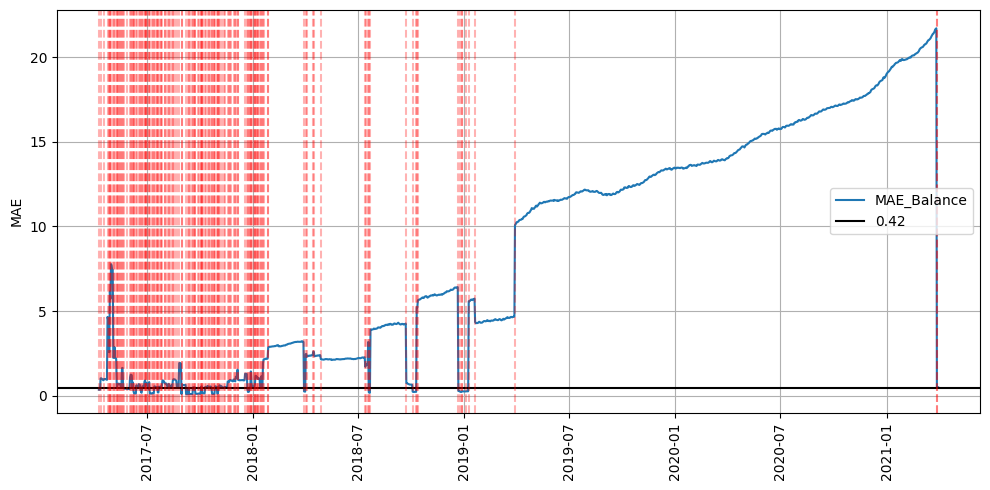

In [126]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_results['Date'], df_results['MAE_Balance'], label='MAE_Balance')
plt.axhline(0.42, color = 'black', label = '0.42')
for d in df_results[df_results['Retrained'].eq(True)]['Date'].values:
    ax.axvline(x=d, color='red', linestyle='--', alpha=0.3)
plt.xticks(rotation=90)
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.grid();

In [121]:
# df_results[df_results['Retrained'].eq(True)]

In [122]:
df_results

,Date,MAE_Balance,Retrained,best_model_income,best_model_outcome
0,2017-04-09,0.348315,True,Lasso,Lasso
1,2017-04-10,0.345850,False,None,None
2,2017-04-11,0.342401,False,None,None
3,2017-04-12,1.016503,True,Lasso,Lasso
4,2017-04-13,1.019777,False,None,None
...,...,...,...,...,...
1448,2021-03-27,21.679343,False,None,None
1449,2021-03-28,21.716650,False,None,None
1450,2021-03-29,0.509561,True,LGBM,LGBM
1451,2021-03-30,0.500961,True,LGBM,LGBM


In [10]:
# создаем периоды для трейна и теста
unique_periods = df_new['period'].unique()
num_periods = len(unique_periods)

print(num_periods)

train_ranges = []
test_ranges = []
for t in range(num_periods):
    if t + 2 <= num_periods-1:
        train_ranges.append([unique_periods[t], unique_periods[t+1]])
        test_ranges.append([unique_periods[t+2]])
    else:
        print(t)

51
49
50


In [109]:
prev = 0.6
curr = 0.8

(curr - prev) / prev

0.3333333333333335

In [36]:
# подбор параметра для lasso
param_grid = {'alpha': np.logspace(-4, 1, 10)}
lasso = Lasso(max_iter=1000)
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_scaled, y_train_in)
best_alpha = grid_search.best_params_['alpha']



NameError: name 'X_train_scaled' is not defined

In [138]:
lasso = Lasso(alpha = best_alpha, max_iter=1000)
lasso.fit(X_train_scaled, y_train_in)


Lasso(alpha=0.0046415888336127815)

In [139]:
data = [[mean_absolute_error(y_train_in, lasso.predict(X_train_scaled))],
        [mean_absolute_error(y_valid_in, lasso.predict(X_valid_scaled))],
        [mean_absolute_error(y_test_in, lasso.predict(X_test_scaled))]]
columns = ['MAE']
index = ['train', 'valid', 'test']
df_metric_lasso = pd.DataFrame(data, columns = columns, index = index)

In [140]:
df_metric_lasso

,MAE
train,0.036087
valid,0.037226
test,0.047393
